In [1]:
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# def normalize(images):
#     min_v=np.min(images)
#     max_v=np.max(images)
#     images-=min_v
#     images/=((max_v-min_v)/2)
#     images-=1.0
#     return images

def normalize01(images):
    min_v=np.min(images)
    max_v=np.max(images)
    images-=min_v
    images/=(max_v-min_v)
    return images

def normalize(images):
    return images

In [4]:
batch_size=64
hidden_size=1024
image_size=784

class Encoder_dense(Layer):
    def __init__(self):
        self.hidden_size_low=1024
        self.hidden_size=1024
        self.encoder_low1=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='encoder_low1')
        self.encoder_low2=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='encoder_low2')
        self.encoder_output1=tf.layers.Dense(units=self.hidden_size,name='encoder_mean')
        self.encoder_output2=tf.layers.Dense(units=self.hidden_size,name='encoder_std')
    
    def __call__(self,inputs):
        encode_hid=self.encoder_low2(self.encoder_low1(inputs))
        encode_mean=self.encoder_output1(encode_hid)
        encode_std=self.encoder_output2(encode_hid)
        return encode_mean,encode_std
    
class Decoder_dense(Layer):
    def __init__(self):
        self.hidden_size_low=1024
        self.decoder_low1=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='decoder_low1')
        self.decoder_low2=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='decoder_low2')
        self.decoder_top=tf.layers.Dense(units=image_size,name='decoder')
    
    def __call__(self,inputs):
        return self.decoder_top(self.decoder_low2(self.decoder_low1(inputs)))
    
class Encoder_conv(Layer):
    def __init__(self):
        self.hidden_size=1024
        self.encoder_low1=tf.layers.Conv2D(filters=64,kernel_size=5,strides=(2,2),activation=tf.nn.relu,name='encoder_low1')
        self.encoder_low2=tf.layers.Conv2D(filters=64,kernel_size=3,activation=tf.nn.relu,name='encoder_low2')
        self.encoder_low3=tf.layers.Conv2D(filters=64,kernel_size=3,activation=tf.nn.relu,name='encoder_low3')
        self.encoder_output1=tf.layers.Dense(units=self.hidden_size,name='encoder_mean')
        self.encoder_output2=tf.layers.Dense(units=self.hidden_size,name='encoder_std')
    
    def __call__(self,inputs):
        encode_hid=self.encoder_low3(self.encoder_low2(self.encoder_low1(inputs)))
        encode_hid=tf.layers.flatten(encode_hid)
        encode_mean=self.encoder_output1(encode_hid)
        encode_std=self.encoder_output2(encode_hid)
        return encode_mean,encode_std
    
class Decoder_conv(Layer):
    def __init__(self):
        self.decoder_top=tf.layers.Dense(units=4096,name='decoder')
        self.decoder_low3=tf.layers.Conv2DTranspose(64,3,activation=tf.nn.relu,name='decoder_low3')
        self.decoder_low2=tf.layers.Conv2DTranspose(64,3,activation=tf.nn.relu,name='decoder_low2')
        self.decoder_low1=tf.layers.Conv2DTranspose(1,6,strides=(2,2),activation=tf.nn.relu,name='decoder_low1')
    
    def __call__(self,inputs):
        decode_hid=self.decoder_top(inputs)
        decode_hid=tf.reshape(decode_hid,shape=[-1,8,8,64])
        decode_hid=self.decoder_low3(decode_hid)
        decode_hid=self.decoder_low2(decode_hid)
        decode_hid=self.decoder_low1(decode_hid)
        return tf.layers.flatten(decode_hid)
        

tf.reset_default_graph()
X=tf.placeholder(shape=[None,image_size],dtype=tf.float32,name='input')
X_conv=tf.reshape(X,shape=[-1,28,28,1])

encoder=Encoder_conv()
decoder=Decoder_conv()

encode_mean,encode_std=encoder(X_conv)
distrib_encode=tf.distributions.Normal(loc=encode_mean,scale=encode_std,name='norm1')
unit_gaussian=tf.distributions.Normal(loc=tf.zeros(encoder.hidden_size),scale=tf.ones(encoder.hidden_size),name='unit_norm')

# Z=encoder(encoder_low2(encoder_low1(X)))  # Vanillia auto_encoder(trivial)
Z=distrib_encode.sample()

X_gen=decoder(Z)

loss1=tf.reduce_mean(tf.square(X_gen-X)) # gaussian distribution
# X_gen=tf.nn.sigmoid(X_gen)
# loss1=-(tf.reduce_mean(X*tf.log(1e-10+X_gen)+(1.0-X)*tf.log(1e-10+1.0-X_gen)))  # Bernoulli distribution
loss2=tf.reduce_mean(tf.distributions.kl_divergence(distrib_encode,unit_gaussian))
# loss2=tf.constant(dtype=tf.float32,value=0)
loss=loss1+loss2

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,num_train//64, 0.98, staircase=True)
optimizier=tf.train.AdamOptimizer(learning_rate=starter_learning_rate)
train_step = optimizier.minimize(loss,global_step=global_step)
# train_step = optimizier.minimize(loss)

In [5]:
def drawImage(sample):
    plt.figure(figsize = (3,3))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.025, hspace=0.05)

    for i in range(9):
        plt.subplot(gs1[i])
        feature_submap=sample[i,:].reshape(28,28)
        plt.imshow(feature_submap)
        plt.axis('off')
    plt.show()

2018-05-07 22:29:35 start epoch 1/300, with learning rate = 0.0010000000
2018-05-07 22:29:36 iteration 1/859: current training loss = 3.603234 (=0.117876+3.485358)
2018-05-07 22:29:37 iteration 100/859: current training loss = 0.076753 (=0.053266+0.023487)
2018-05-07 22:29:38 iteration 200/859: current training loss = 0.054802 (=0.043166+0.011636)
2018-05-07 22:29:39 iteration 300/859: current training loss = 0.054807 (=0.042238+0.012569)
2018-05-07 22:29:39 iteration 400/859: current training loss = 0.049744 (=0.037385+0.012359)
2018-05-07 22:29:40 iteration 500/859: current training loss = 0.050230 (=0.036847+0.013382)
2018-05-07 22:29:41 iteration 600/859: current training loss = 0.051918 (=0.038736+0.013182)
2018-05-07 22:29:42 iteration 700/859: current training loss = 0.052998 (=0.039550+0.013448)
2018-05-07 22:29:42 iteration 800/859: current training loss = 0.050963 (=0.037897+0.013066)
2018-05-07 22:29:43 iteration 859/859: current training loss = 0.050019 (=0.036230+0.013789)

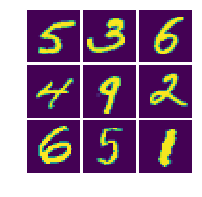

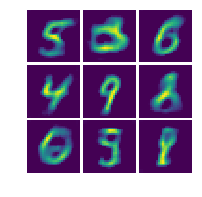

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:29:44 end epoch 1/300: average loss = 0.07361784990230734 (=0.042383+0.031235)

2018-05-07 22:29:44 start epoch 2/300, with learning rate = 0.0009800000
2018-05-07 22:29:44 iteration 1/859: current training loss = 0.049502 (=0.035976+0.013525)
2018-05-07 22:29:45 iteration 100/859: current training loss = 0.049497 (=0.036345+0.013153)
2018-05-07 22:29:46 iteration 200/859: current training loss = 0.047741 (=0.033873+0.013868)
2018-05-07 22:29:47 iteration 300/859: current training loss = 0.046679 (=0.033296+0.013383)
2018-05-07 22:29:47 iteration 400/859: current training loss = 0.048105 (=0.035269+0.012836)
2018-05-07 22:29:48 iteration 500/859: current training loss = 0.043462 (=0.030029+0.013433)
2018-05-07 22:29:49 iteration 600/859: current training loss = 0.050318 (=0.035742+0.014576)
2018-05-07 22:29:50 iteration 700/859: current training loss = 0.048090 (=0.034533+0.013557)
2018-05-07 22:29:50 iteration 800/859: current

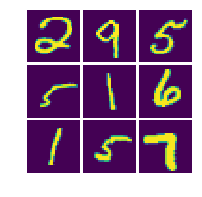

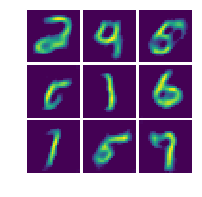

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:29:52 end epoch 2/300: average loss = 0.048126482141309344 (=0.034368+0.013758)

2018-05-07 22:29:52 start epoch 3/300, with learning rate = 0.0009604000
2018-05-07 22:29:52 iteration 1/859: current training loss = 0.045684 (=0.031191+0.014493)
2018-05-07 22:29:53 iteration 100/859: current training loss = 0.047467 (=0.033525+0.013942)
2018-05-07 22:29:54 iteration 200/859: current training loss = 0.045547 (=0.031112+0.014435)
2018-05-07 22:29:54 iteration 300/859: current training loss = 0.047975 (=0.033150+0.014824)
2018-05-07 22:29:55 iteration 400/859: current training loss = 0.051090 (=0.037181+0.013910)
2018-05-07 22:29:56 iteration 500/859: current training loss = 0.046487 (=0.032390+0.014097)
2018-05-07 22:29:57 iteration 600/859: current training loss = 0.046542 (=0.032081+0.014462)
2018-05-07 22:29:57 iteration 700/859: current training loss = 0.046082 (=0.032588+0.013493)
2018-05-07 22:29:58 iteration 800/859: curren

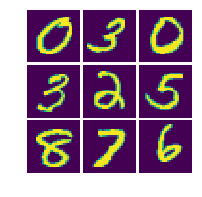

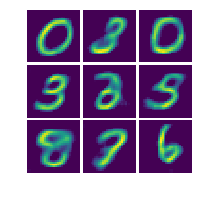

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:00 end epoch 3/300: average loss = 0.04699224379776659 (=0.032886+0.014107)

2018-05-07 22:30:00 start epoch 4/300, with learning rate = 0.0009411921
2018-05-07 22:30:00 iteration 1/859: current training loss = 0.044772 (=0.030728+0.014044)
2018-05-07 22:30:00 iteration 100/859: current training loss = 0.044710 (=0.031071+0.013638)
2018-05-07 22:30:01 iteration 200/859: current training loss = 0.046847 (=0.032732+0.014114)
2018-05-07 22:30:02 iteration 300/859: current training loss = 0.048072 (=0.034405+0.013667)
2018-05-07 22:30:03 iteration 400/859: current training loss = 0.048951 (=0.034307+0.014645)
2018-05-07 22:30:03 iteration 500/859: current training loss = 0.045007 (=0.030500+0.014508)
2018-05-07 22:30:04 iteration 600/859: current training loss = 0.046580 (=0.032654+0.013926)
2018-05-07 22:30:05 iteration 700/859: current training loss = 0.046931 (=0.032277+0.014654)
2018-05-07 22:30:06 iteration 800/859: current

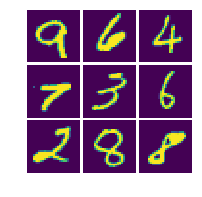

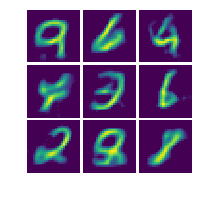

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:07 end epoch 4/300: average loss = 0.0465585326079856 (=0.032295+0.014264)

2018-05-07 22:30:07 start epoch 5/300, with learning rate = 0.0009223682
2018-05-07 22:30:07 iteration 1/859: current training loss = 0.047199 (=0.033035+0.014164)
2018-05-07 22:30:08 iteration 100/859: current training loss = 0.047739 (=0.033461+0.014278)
2018-05-07 22:30:09 iteration 200/859: current training loss = 0.043633 (=0.029649+0.013984)
2018-05-07 22:30:10 iteration 300/859: current training loss = 0.045196 (=0.030522+0.014673)
2018-05-07 22:30:10 iteration 400/859: current training loss = 0.048844 (=0.034300+0.014544)
2018-05-07 22:30:11 iteration 500/859: current training loss = 0.047202 (=0.033266+0.013936)
2018-05-07 22:30:12 iteration 600/859: current training loss = 0.046867 (=0.032056+0.014811)
2018-05-07 22:30:13 iteration 700/859: current training loss = 0.048167 (=0.031968+0.016200)
2018-05-07 22:30:13 iteration 800/859: current 

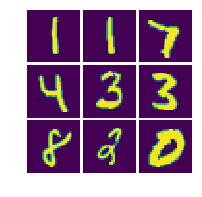

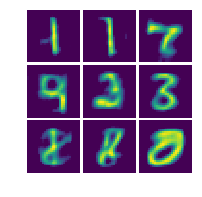

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:15 end epoch 5/300: average loss = 0.046017200734826263 (=0.031720+0.014298)

2018-05-07 22:30:15 start epoch 6/300, with learning rate = 0.0009039209
2018-05-07 22:30:15 iteration 1/859: current training loss = 0.045563 (=0.030866+0.014697)
2018-05-07 22:30:16 iteration 100/859: current training loss = 0.044770 (=0.030321+0.014449)
2018-05-07 22:30:16 iteration 200/859: current training loss = 0.046371 (=0.031038+0.015333)
2018-05-07 22:30:17 iteration 300/859: current training loss = 0.045680 (=0.031416+0.014263)
2018-05-07 22:30:18 iteration 400/859: current training loss = 0.047949 (=0.031971+0.015979)
2018-05-07 22:30:19 iteration 500/859: current training loss = 0.045039 (=0.029126+0.015913)
2018-05-07 22:30:19 iteration 600/859: current training loss = 0.045356 (=0.030022+0.015334)
2018-05-07 22:30:20 iteration 700/859: current training loss = 0.048598 (=0.035590+0.013008)
2018-05-07 22:30:21 iteration 800/859: curren

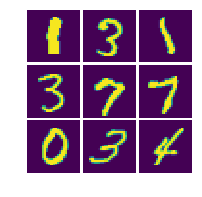

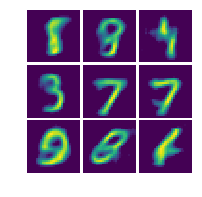

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:22 end epoch 6/300: average loss = 0.045674283040104145 (=0.031255+0.014419)

2018-05-07 22:30:22 start epoch 7/300, with learning rate = 0.0008858425
2018-05-07 22:30:22 iteration 1/859: current training loss = 0.045063 (=0.030373+0.014690)
2018-05-07 22:30:23 iteration 100/859: current training loss = 0.044713 (=0.030517+0.014196)
2018-05-07 22:30:24 iteration 200/859: current training loss = 0.046696 (=0.031578+0.015118)
2018-05-07 22:30:25 iteration 300/859: current training loss = 0.045570 (=0.030436+0.015134)
2018-05-07 22:30:25 iteration 400/859: current training loss = 0.047168 (=0.033181+0.013987)
2018-05-07 22:30:26 iteration 500/859: current training loss = 0.043839 (=0.029371+0.014468)
2018-05-07 22:30:27 iteration 600/859: current training loss = 0.045330 (=0.032351+0.012978)
2018-05-07 22:30:27 iteration 700/859: current training loss = 0.045239 (=0.030741+0.014498)
2018-05-07 22:30:28 iteration 800/859: curren

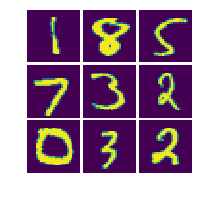

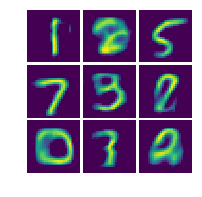

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:30 end epoch 7/300: average loss = 0.04500735695099803 (=0.030703+0.014304)

2018-05-07 22:30:30 start epoch 8/300, with learning rate = 0.0008681256
2018-05-07 22:30:30 iteration 1/859: current training loss = 0.044600 (=0.030260+0.014341)
2018-05-07 22:30:31 iteration 100/859: current training loss = 0.046109 (=0.031952+0.014156)
2018-05-07 22:30:31 iteration 200/859: current training loss = 0.042602 (=0.027817+0.014785)
2018-05-07 22:30:32 iteration 300/859: current training loss = 0.044921 (=0.031432+0.013489)
2018-05-07 22:30:33 iteration 400/859: current training loss = 0.045398 (=0.031200+0.014198)
2018-05-07 22:30:34 iteration 500/859: current training loss = 0.042464 (=0.029248+0.013217)
2018-05-07 22:30:34 iteration 600/859: current training loss = 0.046918 (=0.032520+0.014398)
2018-05-07 22:30:35 iteration 700/859: current training loss = 0.043999 (=0.029864+0.014135)
2018-05-07 22:30:36 iteration 800/859: current

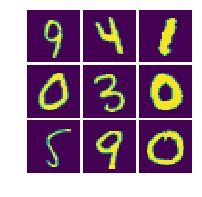

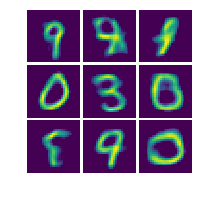

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:37 end epoch 8/300: average loss = 0.044626803680543156 (=0.030340+0.014286)

2018-05-07 22:30:37 start epoch 9/300, with learning rate = 0.0008507632
2018-05-07 22:30:37 iteration 1/859: current training loss = 0.044397 (=0.029655+0.014742)
2018-05-07 22:30:38 iteration 100/859: current training loss = 0.043337 (=0.029753+0.013584)
2018-05-07 22:30:39 iteration 200/859: current training loss = 0.042608 (=0.028731+0.013877)
2018-05-07 22:30:40 iteration 300/859: current training loss = 0.042342 (=0.029805+0.012537)
2018-05-07 22:30:40 iteration 400/859: current training loss = 0.045850 (=0.031062+0.014788)
2018-05-07 22:30:41 iteration 500/859: current training loss = 0.044267 (=0.029659+0.014607)
2018-05-07 22:30:42 iteration 600/859: current training loss = 0.045474 (=0.031088+0.014386)
2018-05-07 22:30:43 iteration 700/859: current training loss = 0.043888 (=0.029209+0.014678)
2018-05-07 22:30:43 iteration 800/859: curren

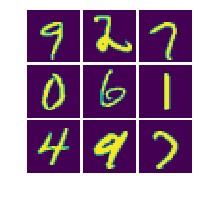

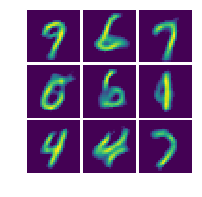

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:45 end epoch 9/300: average loss = 0.04426510831963475 (=0.030043+0.014222)

2018-05-07 22:30:45 start epoch 10/300, with learning rate = 0.0008337479
2018-05-07 22:30:45 iteration 1/859: current training loss = 0.044858 (=0.030322+0.014536)
2018-05-07 22:30:46 iteration 100/859: current training loss = 0.042979 (=0.028850+0.014130)
2018-05-07 22:30:46 iteration 200/859: current training loss = 0.043955 (=0.030178+0.013777)
2018-05-07 22:30:47 iteration 300/859: current training loss = 0.044384 (=0.030969+0.013414)
2018-05-07 22:30:48 iteration 400/859: current training loss = 0.045017 (=0.030964+0.014053)
2018-05-07 22:30:48 iteration 500/859: current training loss = 0.042191 (=0.027523+0.014668)
2018-05-07 22:30:49 iteration 600/859: current training loss = 0.043858 (=0.029152+0.014705)
2018-05-07 22:30:50 iteration 700/859: current training loss = 0.046198 (=0.031253+0.014945)
2018-05-07 22:30:51 iteration 800/859: curren

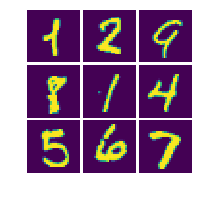

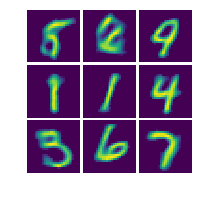

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:30:52 end epoch 10/300: average loss = 0.04407505228751197 (=0.029848+0.014228)

2018-05-07 22:30:52 start epoch 11/300, with learning rate = 0.0008170730
2018-05-07 22:30:52 iteration 1/859: current training loss = 0.043833 (=0.030184+0.013649)
2018-05-07 22:30:53 iteration 100/859: current training loss = 0.043178 (=0.028231+0.014947)
2018-05-07 22:30:54 iteration 200/859: current training loss = 0.044776 (=0.030438+0.014337)
2018-05-07 22:30:54 iteration 300/859: current training loss = 0.043616 (=0.029711+0.013905)
2018-05-07 22:30:55 iteration 400/859: current training loss = 0.042689 (=0.028047+0.014642)
2018-05-07 22:30:56 iteration 500/859: current training loss = 0.041309 (=0.027428+0.013881)
2018-05-07 22:30:57 iteration 600/859: current training loss = 0.043176 (=0.028918+0.014259)
2018-05-07 22:30:57 iteration 700/859: current training loss = 0.042792 (=0.027753+0.015039)
2018-05-07 22:30:58 iteration 800/859: curre

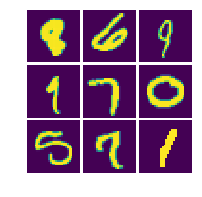

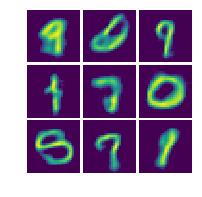

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:00 end epoch 11/300: average loss = 0.04394513325238811 (=0.029702+0.014243)

2018-05-07 22:31:00 start epoch 12/300, with learning rate = 0.0008007316
2018-05-07 22:31:00 iteration 1/859: current training loss = 0.041864 (=0.028743+0.013121)
2018-05-07 22:31:00 iteration 100/859: current training loss = 0.045045 (=0.030267+0.014778)
2018-05-07 22:31:01 iteration 200/859: current training loss = 0.043539 (=0.030477+0.013063)
2018-05-07 22:31:02 iteration 300/859: current training loss = 0.044125 (=0.029511+0.014614)
2018-05-07 22:31:03 iteration 400/859: current training loss = 0.044895 (=0.030208+0.014688)
2018-05-07 22:31:03 iteration 500/859: current training loss = 0.044702 (=0.030373+0.014329)
2018-05-07 22:31:04 iteration 600/859: current training loss = 0.047819 (=0.033016+0.014803)
2018-05-07 22:31:05 iteration 700/859: current training loss = 0.044504 (=0.028615+0.015889)
2018-05-07 22:31:05 iteration 800/859: curre

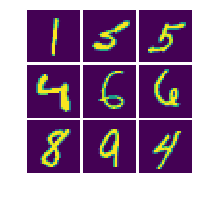

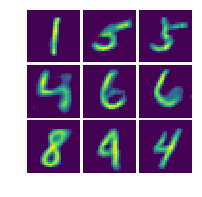

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:07 end epoch 12/300: average loss = 0.043790741978653375 (=0.029588+0.014203)

2018-05-07 22:31:07 start epoch 13/300, with learning rate = 0.0007847169
2018-05-07 22:31:07 iteration 1/859: current training loss = 0.040750 (=0.026392+0.014358)
2018-05-07 22:31:08 iteration 100/859: current training loss = 0.045083 (=0.030337+0.014747)
2018-05-07 22:31:09 iteration 200/859: current training loss = 0.041742 (=0.027110+0.014632)
2018-05-07 22:31:09 iteration 300/859: current training loss = 0.044600 (=0.029651+0.014950)
2018-05-07 22:31:10 iteration 400/859: current training loss = 0.044448 (=0.030536+0.013912)
2018-05-07 22:31:11 iteration 500/859: current training loss = 0.044003 (=0.029753+0.014250)
2018-05-07 22:31:11 iteration 600/859: current training loss = 0.045036 (=0.029854+0.015183)
2018-05-07 22:31:12 iteration 700/859: current training loss = 0.044347 (=0.030358+0.013990)
2018-05-07 22:31:13 iteration 800/859: curr

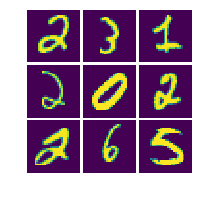

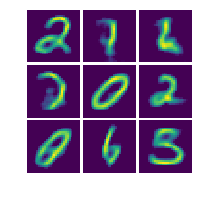

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:15 end epoch 13/300: average loss = 0.04361563349821376 (=0.029413+0.014203)

2018-05-07 22:31:15 start epoch 14/300, with learning rate = 0.0007690226
2018-05-07 22:31:15 iteration 1/859: current training loss = 0.041957 (=0.027549+0.014408)
2018-05-07 22:31:15 iteration 100/859: current training loss = 0.046481 (=0.031084+0.015397)
2018-05-07 22:31:16 iteration 200/859: current training loss = 0.044511 (=0.029199+0.015312)
2018-05-07 22:31:17 iteration 300/859: current training loss = 0.042855 (=0.028871+0.013984)
2018-05-07 22:31:18 iteration 400/859: current training loss = 0.041490 (=0.028109+0.013381)
2018-05-07 22:31:18 iteration 500/859: current training loss = 0.043345 (=0.028849+0.014496)
2018-05-07 22:31:19 iteration 600/859: current training loss = 0.046438 (=0.031268+0.015170)
2018-05-07 22:31:20 iteration 700/859: current training loss = 0.041595 (=0.027029+0.014566)
2018-05-07 22:31:21 iteration 800/859: curre

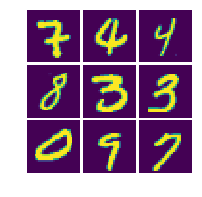

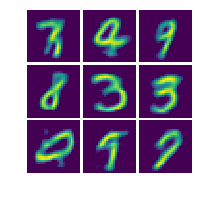

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:22 end epoch 14/300: average loss = 0.043485856527187214 (=0.029321+0.014165)

2018-05-07 22:31:22 start epoch 15/300, with learning rate = 0.0007536422
2018-05-07 22:31:22 iteration 1/859: current training loss = 0.042446 (=0.028501+0.013945)
2018-05-07 22:31:23 iteration 100/859: current training loss = 0.042229 (=0.027902+0.014327)
2018-05-07 22:31:24 iteration 200/859: current training loss = 0.043388 (=0.029335+0.014053)
2018-05-07 22:31:25 iteration 300/859: current training loss = 0.042817 (=0.028407+0.014410)
2018-05-07 22:31:25 iteration 400/859: current training loss = 0.041811 (=0.027105+0.014705)
2018-05-07 22:31:26 iteration 500/859: current training loss = 0.043168 (=0.029323+0.013845)
2018-05-07 22:31:27 iteration 600/859: current training loss = 0.042387 (=0.028354+0.014033)
2018-05-07 22:31:28 iteration 700/859: current training loss = 0.044365 (=0.030000+0.014365)
2018-05-07 22:31:28 iteration 800/859: curr

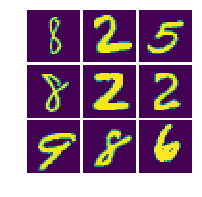

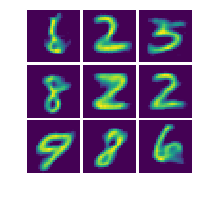

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:30 end epoch 15/300: average loss = 0.043236022808603135 (=0.029043+0.014193)

2018-05-07 22:31:30 start epoch 16/300, with learning rate = 0.0007385694
2018-05-07 22:31:30 iteration 1/859: current training loss = 0.042389 (=0.027805+0.014584)
2018-05-07 22:31:31 iteration 100/859: current training loss = 0.039189 (=0.025994+0.013195)
2018-05-07 22:31:31 iteration 200/859: current training loss = 0.041801 (=0.027456+0.014345)
2018-05-07 22:31:32 iteration 300/859: current training loss = 0.043064 (=0.029671+0.013393)
2018-05-07 22:31:33 iteration 400/859: current training loss = 0.043142 (=0.028495+0.014647)
2018-05-07 22:31:34 iteration 500/859: current training loss = 0.045232 (=0.030104+0.015128)
2018-05-07 22:31:34 iteration 600/859: current training loss = 0.045394 (=0.031992+0.013402)
2018-05-07 22:31:35 iteration 700/859: current training loss = 0.044612 (=0.030008+0.014604)
2018-05-07 22:31:36 iteration 800/859: curr

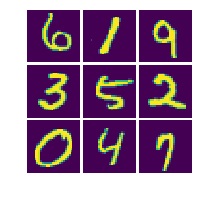

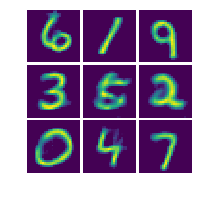

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:38 end epoch 16/300: average loss = 0.042919129835782145 (=0.028708+0.014211)

2018-05-07 22:31:38 start epoch 17/300, with learning rate = 0.0007237979
2018-05-07 22:31:38 iteration 1/859: current training loss = 0.042736 (=0.027806+0.014930)
2018-05-07 22:31:38 iteration 100/859: current training loss = 0.042596 (=0.029098+0.013499)
2018-05-07 22:31:39 iteration 200/859: current training loss = 0.041957 (=0.029000+0.012957)
2018-05-07 22:31:40 iteration 300/859: current training loss = 0.043438 (=0.028653+0.014785)
2018-05-07 22:31:41 iteration 400/859: current training loss = 0.046955 (=0.033191+0.013764)
2018-05-07 22:31:41 iteration 500/859: current training loss = 0.042893 (=0.029456+0.013438)
2018-05-07 22:31:42 iteration 600/859: current training loss = 0.043587 (=0.030108+0.013479)
2018-05-07 22:31:43 iteration 700/859: current training loss = 0.040518 (=0.026925+0.013592)
2018-05-07 22:31:43 iteration 800/859: curr

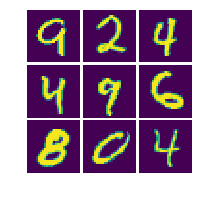

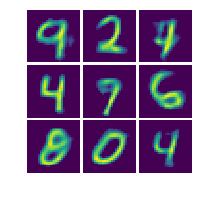

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:45 end epoch 17/300: average loss = 0.04234621294788209 (=0.028239+0.014108)

2018-05-07 22:31:45 start epoch 18/300, with learning rate = 0.0007093220
2018-05-07 22:31:45 iteration 1/859: current training loss = 0.042195 (=0.027939+0.014255)
2018-05-07 22:31:46 iteration 100/859: current training loss = 0.042816 (=0.027510+0.015307)
2018-05-07 22:31:46 iteration 200/859: current training loss = 0.040468 (=0.026768+0.013700)
2018-05-07 22:31:47 iteration 300/859: current training loss = 0.040892 (=0.025998+0.014894)
2018-05-07 22:31:48 iteration 400/859: current training loss = 0.042261 (=0.027021+0.015240)
2018-05-07 22:31:49 iteration 500/859: current training loss = 0.045697 (=0.031595+0.014102)
2018-05-07 22:31:49 iteration 600/859: current training loss = 0.042252 (=0.028401+0.013850)
2018-05-07 22:31:50 iteration 700/859: current training loss = 0.040844 (=0.027105+0.013739)
2018-05-07 22:31:51 iteration 800/859: curre

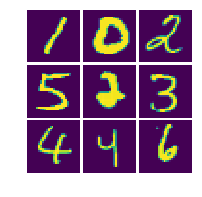

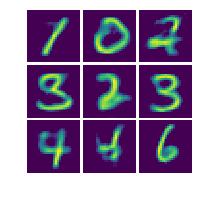

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:31:52 end epoch 18/300: average loss = 0.04180168196975283 (=0.027775+0.014027)

2018-05-07 22:31:52 start epoch 19/300, with learning rate = 0.0006951356
2018-05-07 22:31:52 iteration 1/859: current training loss = 0.041945 (=0.027538+0.014408)
2018-05-07 22:31:53 iteration 100/859: current training loss = 0.042427 (=0.028534+0.013893)
2018-05-07 22:31:54 iteration 200/859: current training loss = 0.040809 (=0.027227+0.013582)
2018-05-07 22:31:55 iteration 300/859: current training loss = 0.039699 (=0.025881+0.013818)
2018-05-07 22:31:56 iteration 400/859: current training loss = 0.039925 (=0.026651+0.013274)
2018-05-07 22:31:56 iteration 500/859: current training loss = 0.042530 (=0.027891+0.014638)
2018-05-07 22:31:57 iteration 600/859: current training loss = 0.043093 (=0.028103+0.014990)
2018-05-07 22:31:58 iteration 700/859: current training loss = 0.042940 (=0.028769+0.014171)
2018-05-07 22:31:58 iteration 800/859: curre

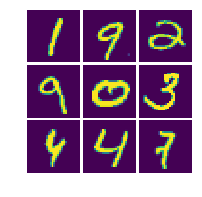

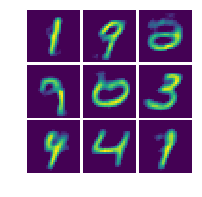

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:00 end epoch 19/300: average loss = 0.04139557384969331 (=0.027482+0.013913)

2018-05-07 22:32:00 start epoch 20/300, with learning rate = 0.0006812329
2018-05-07 22:32:00 iteration 1/859: current training loss = 0.038859 (=0.026278+0.012582)
2018-05-07 22:32:01 iteration 100/859: current training loss = 0.040110 (=0.026840+0.013270)
2018-05-07 22:32:02 iteration 200/859: current training loss = 0.042391 (=0.028175+0.014216)
2018-05-07 22:32:02 iteration 300/859: current training loss = 0.043338 (=0.028957+0.014381)
2018-05-07 22:32:03 iteration 400/859: current training loss = 0.042068 (=0.027703+0.014365)
2018-05-07 22:32:04 iteration 500/859: current training loss = 0.041635 (=0.027619+0.014016)
2018-05-07 22:32:04 iteration 600/859: current training loss = 0.041365 (=0.026702+0.014664)
2018-05-07 22:32:05 iteration 700/859: current training loss = 0.041223 (=0.027655+0.013568)
2018-05-07 22:32:06 iteration 800/859: curre

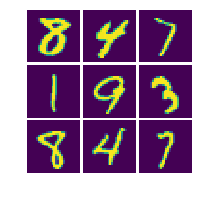

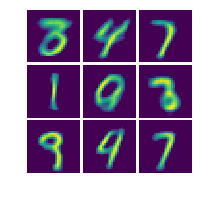

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:07 end epoch 20/300: average loss = 0.04110189618779145 (=0.027252+0.013850)

2018-05-07 22:32:07 start epoch 21/300, with learning rate = 0.0006676083
2018-05-07 22:32:07 iteration 1/859: current training loss = 0.040045 (=0.027075+0.012970)
2018-05-07 22:32:08 iteration 100/859: current training loss = 0.041210 (=0.026709+0.014501)
2018-05-07 22:32:09 iteration 200/859: current training loss = 0.040231 (=0.026436+0.013795)
2018-05-07 22:32:10 iteration 300/859: current training loss = 0.039752 (=0.025804+0.013948)
2018-05-07 22:32:10 iteration 400/859: current training loss = 0.040399 (=0.026326+0.014073)
2018-05-07 22:32:11 iteration 500/859: current training loss = 0.040666 (=0.026195+0.014470)
2018-05-07 22:32:12 iteration 600/859: current training loss = 0.040265 (=0.025784+0.014481)
2018-05-07 22:32:13 iteration 700/859: current training loss = 0.038960 (=0.025164+0.013795)
2018-05-07 22:32:13 iteration 800/859: curre

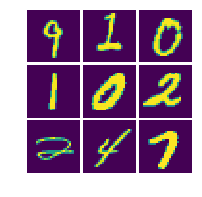

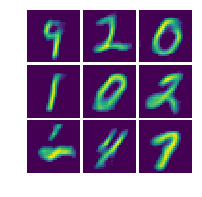

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:15 end epoch 21/300: average loss = 0.040844463848436256 (=0.027032+0.013812)

2018-05-07 22:32:15 start epoch 22/300, with learning rate = 0.0006542561
2018-05-07 22:32:15 iteration 1/859: current training loss = 0.038443 (=0.024970+0.013473)
2018-05-07 22:32:16 iteration 100/859: current training loss = 0.040618 (=0.025569+0.015049)
2018-05-07 22:32:17 iteration 200/859: current training loss = 0.040097 (=0.025894+0.014203)
2018-05-07 22:32:17 iteration 300/859: current training loss = 0.039025 (=0.025934+0.013091)
2018-05-07 22:32:18 iteration 400/859: current training loss = 0.039822 (=0.025278+0.014544)
2018-05-07 22:32:19 iteration 500/859: current training loss = 0.039466 (=0.025639+0.013826)
2018-05-07 22:32:19 iteration 600/859: current training loss = 0.043335 (=0.028833+0.014502)
2018-05-07 22:32:20 iteration 700/859: current training loss = 0.039938 (=0.025691+0.014247)
2018-05-07 22:32:21 iteration 800/859: curr

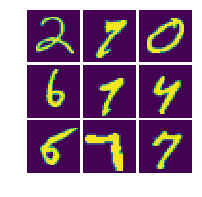

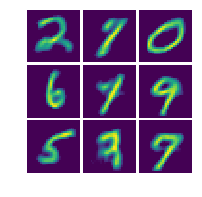

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:22 end epoch 22/300: average loss = 0.04061553465490846 (=0.026851+0.013764)

2018-05-07 22:32:22 start epoch 23/300, with learning rate = 0.0006411710
2018-05-07 22:32:22 iteration 1/859: current training loss = 0.039301 (=0.025125+0.014177)
2018-05-07 22:32:23 iteration 100/859: current training loss = 0.040696 (=0.026904+0.013792)
2018-05-07 22:32:24 iteration 200/859: current training loss = 0.038135 (=0.023700+0.014435)
2018-05-07 22:32:25 iteration 300/859: current training loss = 0.036146 (=0.022509+0.013636)
2018-05-07 22:32:25 iteration 400/859: current training loss = 0.038676 (=0.025572+0.013103)
2018-05-07 22:32:26 iteration 500/859: current training loss = 0.039208 (=0.025419+0.013790)
2018-05-07 22:32:27 iteration 600/859: current training loss = 0.037085 (=0.024840+0.012245)
2018-05-07 22:32:27 iteration 700/859: current training loss = 0.040000 (=0.026312+0.013688)
2018-05-07 22:32:28 iteration 800/859: curre

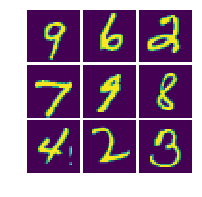

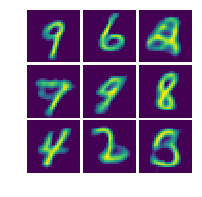

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:30 end epoch 23/300: average loss = 0.040242794411076935 (=0.026507+0.013736)

2018-05-07 22:32:30 start epoch 24/300, with learning rate = 0.0006283476
2018-05-07 22:32:30 iteration 1/859: current training loss = 0.040757 (=0.027658+0.013099)
2018-05-07 22:32:31 iteration 100/859: current training loss = 0.042031 (=0.028333+0.013698)
2018-05-07 22:32:31 iteration 200/859: current training loss = 0.038461 (=0.025009+0.013452)
2018-05-07 22:32:32 iteration 300/859: current training loss = 0.041035 (=0.027582+0.013452)
2018-05-07 22:32:33 iteration 400/859: current training loss = 0.038892 (=0.024896+0.013996)
2018-05-07 22:32:33 iteration 500/859: current training loss = 0.039674 (=0.026261+0.013413)
2018-05-07 22:32:34 iteration 600/859: current training loss = 0.042251 (=0.028563+0.013688)
2018-05-07 22:32:35 iteration 700/859: current training loss = 0.039855 (=0.026023+0.013832)
2018-05-07 22:32:36 iteration 800/859: curr

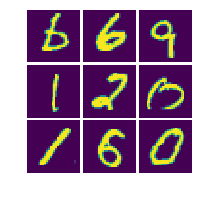

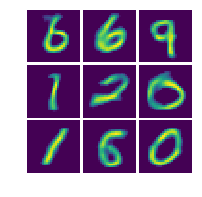

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:37 end epoch 24/300: average loss = 0.03984929150245797 (=0.026183+0.013666)

2018-05-07 22:32:37 start epoch 25/300, with learning rate = 0.0006157807
2018-05-07 22:32:37 iteration 1/859: current training loss = 0.041638 (=0.028388+0.013249)
2018-05-07 22:32:38 iteration 100/859: current training loss = 0.039708 (=0.025600+0.014107)
2018-05-07 22:32:39 iteration 200/859: current training loss = 0.040574 (=0.027213+0.013361)
2018-05-07 22:32:39 iteration 300/859: current training loss = 0.038878 (=0.025240+0.013638)
2018-05-07 22:32:40 iteration 400/859: current training loss = 0.040091 (=0.025755+0.014336)
2018-05-07 22:32:41 iteration 500/859: current training loss = 0.039681 (=0.026072+0.013609)
2018-05-07 22:32:42 iteration 600/859: current training loss = 0.038105 (=0.024668+0.013437)
2018-05-07 22:32:42 iteration 700/859: current training loss = 0.040190 (=0.026855+0.013335)
2018-05-07 22:32:43 iteration 800/859: curre

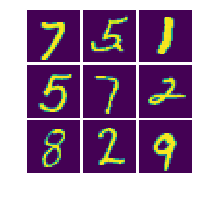

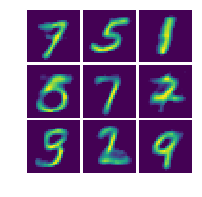

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:45 end epoch 25/300: average loss = 0.03954857400465622 (=0.025958+0.013591)

2018-05-07 22:32:45 start epoch 26/300, with learning rate = 0.0006034651
2018-05-07 22:32:45 iteration 1/859: current training loss = 0.039862 (=0.025329+0.014532)
2018-05-07 22:32:45 iteration 100/859: current training loss = 0.040816 (=0.026503+0.014312)
2018-05-07 22:32:46 iteration 200/859: current training loss = 0.040103 (=0.026193+0.013910)
2018-05-07 22:32:47 iteration 300/859: current training loss = 0.040183 (=0.026072+0.014111)
2018-05-07 22:32:48 iteration 400/859: current training loss = 0.038771 (=0.025423+0.013348)
2018-05-07 22:32:48 iteration 500/859: current training loss = 0.038635 (=0.025286+0.013348)
2018-05-07 22:32:49 iteration 600/859: current training loss = 0.040937 (=0.027173+0.013764)
2018-05-07 22:32:50 iteration 700/859: current training loss = 0.038694 (=0.024603+0.014091)
2018-05-07 22:32:51 iteration 800/859: curre

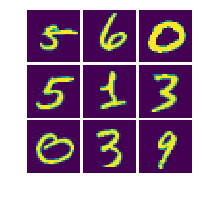

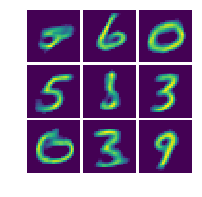

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:52 end epoch 26/300: average loss = 0.039316095541880765 (=0.025741+0.013575)

2018-05-07 22:32:52 start epoch 27/300, with learning rate = 0.0005913958
2018-05-07 22:32:52 iteration 1/859: current training loss = 0.039335 (=0.025965+0.013370)
2018-05-07 22:32:53 iteration 100/859: current training loss = 0.037470 (=0.023985+0.013485)
2018-05-07 22:32:54 iteration 200/859: current training loss = 0.038527 (=0.024589+0.013937)
2018-05-07 22:32:54 iteration 300/859: current training loss = 0.037960 (=0.025250+0.012710)
2018-05-07 22:32:55 iteration 400/859: current training loss = 0.035443 (=0.022053+0.013390)
2018-05-07 22:32:56 iteration 500/859: current training loss = 0.037666 (=0.023962+0.013704)
2018-05-07 22:32:56 iteration 600/859: current training loss = 0.040898 (=0.027367+0.013531)
2018-05-07 22:32:57 iteration 700/859: current training loss = 0.039210 (=0.026655+0.012555)
2018-05-07 22:32:58 iteration 800/859: curr

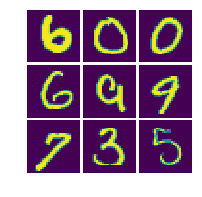

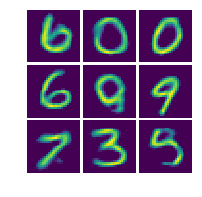

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:32:59 end epoch 27/300: average loss = 0.03907432106602178 (=0.025565+0.013509)

2018-05-07 22:32:59 start epoch 28/300, with learning rate = 0.0005795679
2018-05-07 22:32:59 iteration 1/859: current training loss = 0.038929 (=0.024785+0.014143)
2018-05-07 22:33:00 iteration 100/859: current training loss = 0.035916 (=0.023139+0.012777)
2018-05-07 22:33:01 iteration 200/859: current training loss = 0.038075 (=0.024601+0.013474)
2018-05-07 22:33:02 iteration 300/859: current training loss = 0.041372 (=0.027321+0.014051)
2018-05-07 22:33:02 iteration 400/859: current training loss = 0.038239 (=0.024996+0.013242)
2018-05-07 22:33:03 iteration 500/859: current training loss = 0.037849 (=0.024931+0.012917)
2018-05-07 22:33:04 iteration 600/859: current training loss = 0.041638 (=0.028100+0.013538)
2018-05-07 22:33:04 iteration 700/859: current training loss = 0.040314 (=0.026793+0.013520)
2018-05-07 22:33:05 iteration 800/859: curre

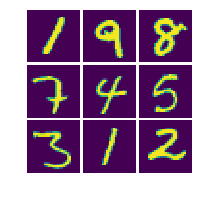

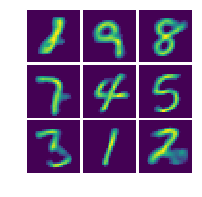

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:07 end epoch 28/300: average loss = 0.03880158132668563 (=0.025312+0.013490)

2018-05-07 22:33:07 start epoch 29/300, with learning rate = 0.0005679765
2018-05-07 22:33:07 iteration 1/859: current training loss = 0.038426 (=0.024923+0.013503)
2018-05-07 22:33:08 iteration 100/859: current training loss = 0.035982 (=0.023147+0.012834)
2018-05-07 22:33:09 iteration 200/859: current training loss = 0.037666 (=0.024527+0.013139)
2018-05-07 22:33:09 iteration 300/859: current training loss = 0.037435 (=0.023766+0.013669)
2018-05-07 22:33:10 iteration 400/859: current training loss = 0.040097 (=0.026020+0.014076)
2018-05-07 22:33:11 iteration 500/859: current training loss = 0.038506 (=0.025235+0.013271)
2018-05-07 22:33:12 iteration 600/859: current training loss = 0.039492 (=0.026180+0.013313)
2018-05-07 22:33:12 iteration 700/859: current training loss = 0.037214 (=0.023615+0.013599)
2018-05-07 22:33:13 iteration 800/859: curre

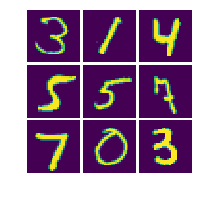

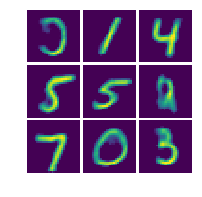

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:14 end epoch 29/300: average loss = 0.03847388500766232 (=0.025027+0.013447)

2018-05-07 22:33:14 start epoch 30/300, with learning rate = 0.0005566170
2018-05-07 22:33:14 iteration 1/859: current training loss = 0.036219 (=0.023025+0.013194)
2018-05-07 22:33:15 iteration 100/859: current training loss = 0.035277 (=0.021844+0.013432)
2018-05-07 22:33:16 iteration 200/859: current training loss = 0.036227 (=0.024248+0.011980)
2018-05-07 22:33:17 iteration 300/859: current training loss = 0.038182 (=0.024698+0.013484)
2018-05-07 22:33:17 iteration 400/859: current training loss = 0.038162 (=0.024452+0.013710)
2018-05-07 22:33:18 iteration 500/859: current training loss = 0.037397 (=0.023978+0.013419)
2018-05-07 22:33:19 iteration 600/859: current training loss = 0.039974 (=0.027081+0.012893)
2018-05-07 22:33:20 iteration 700/859: current training loss = 0.039524 (=0.026542+0.012982)
2018-05-07 22:33:20 iteration 800/859: curre

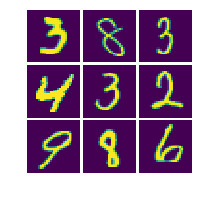

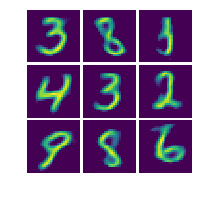

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:22 end epoch 30/300: average loss = 0.03825151566871387 (=0.024827+0.013425)

2018-05-07 22:33:22 start epoch 31/300, with learning rate = 0.0005454847
2018-05-07 22:33:22 iteration 1/859: current training loss = 0.038493 (=0.024228+0.014264)
2018-05-07 22:33:23 iteration 100/859: current training loss = 0.038555 (=0.025488+0.013066)
2018-05-07 22:33:24 iteration 200/859: current training loss = 0.037415 (=0.024240+0.013175)
2018-05-07 22:33:24 iteration 300/859: current training loss = 0.039032 (=0.024447+0.014584)
2018-05-07 22:33:25 iteration 400/859: current training loss = 0.038120 (=0.024445+0.013675)
2018-05-07 22:33:26 iteration 500/859: current training loss = 0.038395 (=0.024994+0.013401)
2018-05-07 22:33:27 iteration 600/859: current training loss = 0.038179 (=0.024638+0.013541)
2018-05-07 22:33:27 iteration 700/859: current training loss = 0.037960 (=0.024206+0.013754)
2018-05-07 22:33:28 iteration 800/859: curre

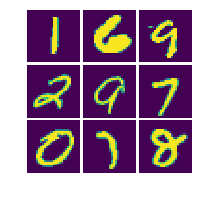

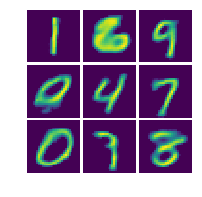

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:30 end epoch 31/300: average loss = 0.03799674476521812 (=0.024594+0.013403)

2018-05-07 22:33:30 start epoch 32/300, with learning rate = 0.0005345750
2018-05-07 22:33:30 iteration 1/859: current training loss = 0.038627 (=0.025142+0.013485)
2018-05-07 22:33:31 iteration 100/859: current training loss = 0.038065 (=0.024981+0.013084)
2018-05-07 22:33:31 iteration 200/859: current training loss = 0.037399 (=0.024552+0.012846)
2018-05-07 22:33:32 iteration 300/859: current training loss = 0.037631 (=0.024809+0.012822)
2018-05-07 22:33:33 iteration 400/859: current training loss = 0.038605 (=0.024573+0.014032)
2018-05-07 22:33:34 iteration 500/859: current training loss = 0.037531 (=0.023854+0.013677)
2018-05-07 22:33:34 iteration 600/859: current training loss = 0.034063 (=0.020922+0.013141)
2018-05-07 22:33:35 iteration 700/859: current training loss = 0.036938 (=0.023205+0.013733)
2018-05-07 22:33:36 iteration 800/859: curre

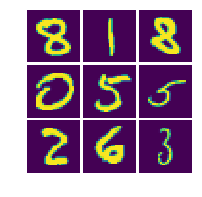

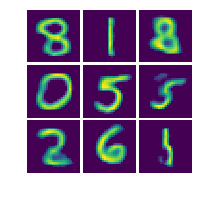

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:37 end epoch 32/300: average loss = 0.03771959968579107 (=0.024349+0.013370)

2018-05-07 22:33:37 start epoch 33/300, with learning rate = 0.0005238835
2018-05-07 22:33:37 iteration 1/859: current training loss = 0.040230 (=0.026322+0.013907)
2018-05-07 22:33:38 iteration 100/859: current training loss = 0.037457 (=0.023817+0.013640)
2018-05-07 22:33:39 iteration 200/859: current training loss = 0.037160 (=0.023664+0.013495)
2018-05-07 22:33:40 iteration 300/859: current training loss = 0.041585 (=0.028268+0.013317)
2018-05-07 22:33:40 iteration 400/859: current training loss = 0.037667 (=0.024397+0.013270)
2018-05-07 22:33:41 iteration 500/859: current training loss = 0.036765 (=0.021926+0.014839)
2018-05-07 22:33:42 iteration 600/859: current training loss = 0.033730 (=0.021044+0.012685)
2018-05-07 22:33:42 iteration 700/859: current training loss = 0.037660 (=0.024554+0.013105)
2018-05-07 22:33:43 iteration 800/859: curre

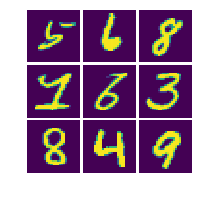

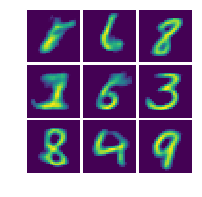

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:45 end epoch 33/300: average loss = 0.03752588978139152 (=0.024181+0.013345)

2018-05-07 22:33:45 start epoch 34/300, with learning rate = 0.0005134058
2018-05-07 22:33:45 iteration 1/859: current training loss = 0.038188 (=0.025461+0.012727)
2018-05-07 22:33:45 iteration 100/859: current training loss = 0.036623 (=0.023665+0.012958)
2018-05-07 22:33:46 iteration 200/859: current training loss = 0.037031 (=0.023315+0.013716)
2018-05-07 22:33:47 iteration 300/859: current training loss = 0.035697 (=0.022567+0.013130)
2018-05-07 22:33:48 iteration 400/859: current training loss = 0.034490 (=0.021589+0.012901)
2018-05-07 22:33:48 iteration 500/859: current training loss = 0.036916 (=0.024040+0.012877)
2018-05-07 22:33:49 iteration 600/859: current training loss = 0.036988 (=0.023429+0.013559)
2018-05-07 22:33:50 iteration 700/859: current training loss = 0.039905 (=0.026028+0.013877)
2018-05-07 22:33:50 iteration 800/859: curre

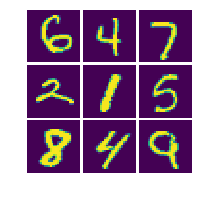

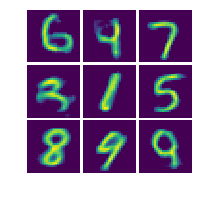

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:52 end epoch 34/300: average loss = 0.03733408446743547 (=0.023960+0.013375)

2018-05-07 22:33:52 start epoch 35/300, with learning rate = 0.0005031377
2018-05-07 22:33:52 iteration 1/859: current training loss = 0.037707 (=0.024379+0.013328)
2018-05-07 22:33:53 iteration 100/859: current training loss = 0.038658 (=0.024708+0.013951)
2018-05-07 22:33:54 iteration 200/859: current training loss = 0.039462 (=0.026064+0.013398)
2018-05-07 22:33:54 iteration 300/859: current training loss = 0.035762 (=0.022440+0.013322)
2018-05-07 22:33:55 iteration 400/859: current training loss = 0.035941 (=0.022927+0.013014)
2018-05-07 22:33:56 iteration 500/859: current training loss = 0.038307 (=0.024716+0.013591)
2018-05-07 22:33:56 iteration 600/859: current training loss = 0.037129 (=0.023551+0.013578)
2018-05-07 22:33:57 iteration 700/859: current training loss = 0.035950 (=0.022457+0.013493)
2018-05-07 22:33:58 iteration 800/859: curre

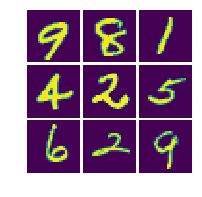

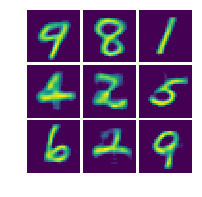

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:33:59 end epoch 35/300: average loss = 0.037100080253254966 (=0.023761+0.013339)

2018-05-07 22:33:59 start epoch 36/300, with learning rate = 0.0004930749
2018-05-07 22:33:59 iteration 1/859: current training loss = 0.036306 (=0.022654+0.013653)
2018-05-07 22:34:00 iteration 100/859: current training loss = 0.035881 (=0.022793+0.013088)
2018-05-07 22:34:01 iteration 200/859: current training loss = 0.037834 (=0.024516+0.013317)
2018-05-07 22:34:02 iteration 300/859: current training loss = 0.040091 (=0.025954+0.014137)
2018-05-07 22:34:02 iteration 400/859: current training loss = 0.036876 (=0.023729+0.013148)
2018-05-07 22:34:03 iteration 500/859: current training loss = 0.035700 (=0.022331+0.013369)
2018-05-07 22:34:04 iteration 600/859: current training loss = 0.036874 (=0.023931+0.012943)
2018-05-07 22:34:04 iteration 700/859: current training loss = 0.034345 (=0.020979+0.013366)
2018-05-07 22:34:05 iteration 800/859: curr

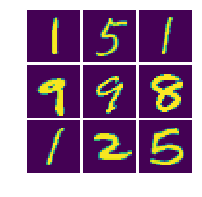

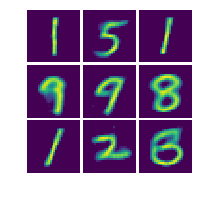

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:07 end epoch 36/300: average loss = 0.03683159243623369 (=0.023488+0.013343)

2018-05-07 22:34:07 start epoch 37/300, with learning rate = 0.0004832135
2018-05-07 22:34:07 iteration 1/859: current training loss = 0.037664 (=0.024019+0.013644)
2018-05-07 22:34:07 iteration 100/859: current training loss = 0.036723 (=0.023272+0.013450)
2018-05-07 22:34:08 iteration 200/859: current training loss = 0.037646 (=0.024341+0.013304)
2018-05-07 22:34:09 iteration 300/859: current training loss = 0.036495 (=0.023298+0.013198)
2018-05-07 22:34:10 iteration 400/859: current training loss = 0.035326 (=0.021508+0.013818)
2018-05-07 22:34:10 iteration 500/859: current training loss = 0.034471 (=0.021455+0.013016)
2018-05-07 22:34:11 iteration 600/859: current training loss = 0.034169 (=0.021758+0.012411)
2018-05-07 22:34:12 iteration 700/859: current training loss = 0.036593 (=0.024004+0.012588)
2018-05-07 22:34:12 iteration 800/859: curre

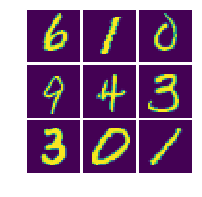

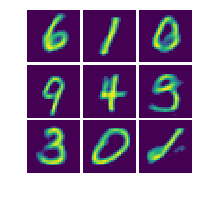

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:14 end epoch 37/300: average loss = 0.03663959966081263 (=0.023274+0.013366)

2018-05-07 22:34:14 start epoch 38/300, with learning rate = 0.0004735492
2018-05-07 22:34:14 iteration 1/859: current training loss = 0.035390 (=0.021885+0.013505)
2018-05-07 22:34:15 iteration 100/859: current training loss = 0.036958 (=0.022821+0.014137)
2018-05-07 22:34:16 iteration 200/859: current training loss = 0.033582 (=0.020536+0.013046)
2018-05-07 22:34:16 iteration 300/859: current training loss = 0.036358 (=0.022795+0.013563)
2018-05-07 22:34:17 iteration 400/859: current training loss = 0.035353 (=0.022484+0.012869)
2018-05-07 22:34:18 iteration 500/859: current training loss = 0.035648 (=0.022775+0.012873)
2018-05-07 22:34:18 iteration 600/859: current training loss = 0.036235 (=0.022978+0.013257)
2018-05-07 22:34:19 iteration 700/859: current training loss = 0.036035 (=0.023383+0.012652)
2018-05-07 22:34:20 iteration 800/859: curre

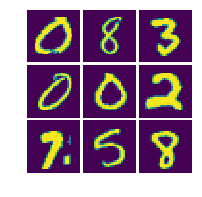

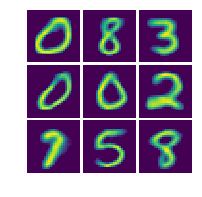

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:21 end epoch 38/300: average loss = 0.036422470569333044 (=0.023062+0.013361)

2018-05-07 22:34:21 start epoch 39/300, with learning rate = 0.0004640782
2018-05-07 22:34:21 iteration 1/859: current training loss = 0.037309 (=0.023521+0.013788)
2018-05-07 22:34:22 iteration 100/859: current training loss = 0.035955 (=0.022610+0.013345)
2018-05-07 22:34:22 iteration 200/859: current training loss = 0.038075 (=0.023343+0.014732)
2018-05-07 22:34:23 iteration 300/859: current training loss = 0.034892 (=0.021849+0.013043)
2018-05-07 22:34:24 iteration 400/859: current training loss = 0.036881 (=0.023915+0.012966)
2018-05-07 22:34:25 iteration 500/859: current training loss = 0.035057 (=0.021519+0.013537)
2018-05-07 22:34:25 iteration 600/859: current training loss = 0.036092 (=0.023721+0.012371)
2018-05-07 22:34:26 iteration 700/859: current training loss = 0.038740 (=0.025106+0.013634)
2018-05-07 22:34:27 iteration 800/859: curr

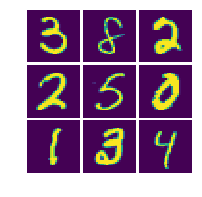

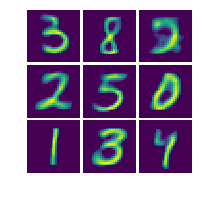

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:28 end epoch 39/300: average loss = 0.03630937316711901 (=0.022969+0.013341)

2018-05-07 22:34:28 start epoch 40/300, with learning rate = 0.0004547967
2018-05-07 22:34:28 iteration 1/859: current training loss = 0.036847 (=0.023961+0.012886)
2018-05-07 22:34:29 iteration 100/859: current training loss = 0.035988 (=0.022820+0.013168)
2018-05-07 22:34:30 iteration 200/859: current training loss = 0.033450 (=0.020527+0.012923)
2018-05-07 22:34:31 iteration 300/859: current training loss = 0.036320 (=0.023157+0.013163)
2018-05-07 22:34:32 iteration 400/859: current training loss = 0.034424 (=0.021369+0.013054)
2018-05-07 22:34:32 iteration 500/859: current training loss = 0.034736 (=0.021915+0.012821)
2018-05-07 22:34:33 iteration 600/859: current training loss = 0.040001 (=0.025735+0.014265)
2018-05-07 22:34:34 iteration 700/859: current training loss = 0.035609 (=0.022470+0.013138)
2018-05-07 22:34:35 iteration 800/859: curre

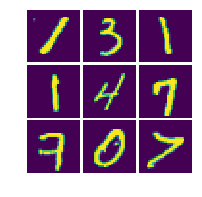

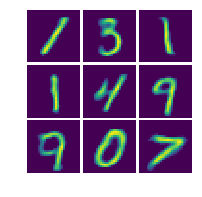

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:36 end epoch 40/300: average loss = 0.03614416601390028 (=0.022820+0.013324)

2018-05-07 22:34:36 start epoch 41/300, with learning rate = 0.0004457007
2018-05-07 22:34:36 iteration 1/859: current training loss = 0.036874 (=0.022848+0.014026)
2018-05-07 22:34:37 iteration 100/859: current training loss = 0.034803 (=0.021099+0.013704)
2018-05-07 22:34:38 iteration 200/859: current training loss = 0.037417 (=0.023937+0.013480)
2018-05-07 22:34:38 iteration 300/859: current training loss = 0.038779 (=0.024590+0.014189)
2018-05-07 22:34:39 iteration 400/859: current training loss = 0.035677 (=0.022805+0.012872)
2018-05-07 22:34:40 iteration 500/859: current training loss = 0.033338 (=0.020487+0.012851)
2018-05-07 22:34:41 iteration 600/859: current training loss = 0.036804 (=0.023551+0.013253)
2018-05-07 22:34:41 iteration 700/859: current training loss = 0.034555 (=0.021660+0.012896)
2018-05-07 22:34:42 iteration 800/859: curre

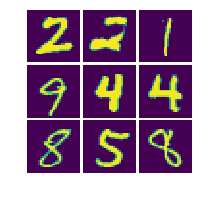

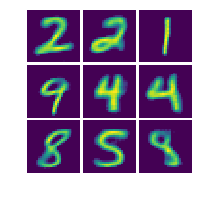

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:44 end epoch 41/300: average loss = 0.03598593462939451 (=0.022640+0.013346)

2018-05-07 22:34:44 start epoch 42/300, with learning rate = 0.0004367868
2018-05-07 22:34:44 iteration 1/859: current training loss = 0.035522 (=0.021945+0.013577)
2018-05-07 22:34:45 iteration 100/859: current training loss = 0.035494 (=0.021760+0.013735)
2018-05-07 22:34:45 iteration 200/859: current training loss = 0.036028 (=0.023012+0.013016)
2018-05-07 22:34:46 iteration 300/859: current training loss = 0.035090 (=0.021995+0.013096)
2018-05-07 22:34:47 iteration 400/859: current training loss = 0.034174 (=0.021665+0.012509)
2018-05-07 22:34:48 iteration 500/859: current training loss = 0.036775 (=0.023189+0.013585)
2018-05-07 22:34:48 iteration 600/859: current training loss = 0.035675 (=0.021999+0.013676)
2018-05-07 22:34:49 iteration 700/859: current training loss = 0.037305 (=0.023959+0.013346)
2018-05-07 22:34:50 iteration 800/859: curre

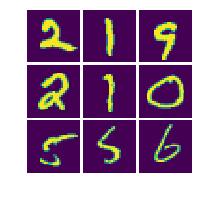

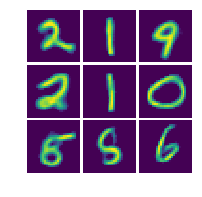

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:51 end epoch 42/300: average loss = 0.0357449158193485 (=0.022406+0.013339)

2018-05-07 22:34:51 start epoch 43/300, with learning rate = 0.0004280510
2018-05-07 22:34:51 iteration 1/859: current training loss = 0.034046 (=0.020984+0.013062)
2018-05-07 22:34:52 iteration 100/859: current training loss = 0.035102 (=0.021561+0.013541)
2018-05-07 22:34:53 iteration 200/859: current training loss = 0.035552 (=0.022433+0.013119)
2018-05-07 22:34:54 iteration 300/859: current training loss = 0.035051 (=0.022603+0.012449)
2018-05-07 22:34:55 iteration 400/859: current training loss = 0.037163 (=0.023407+0.013756)
2018-05-07 22:34:55 iteration 500/859: current training loss = 0.034479 (=0.020631+0.013849)
2018-05-07 22:34:56 iteration 600/859: current training loss = 0.035663 (=0.022802+0.012862)
2018-05-07 22:34:57 iteration 700/859: current training loss = 0.038226 (=0.024147+0.014079)
2018-05-07 22:34:58 iteration 800/859: curren

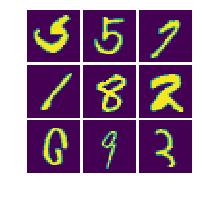

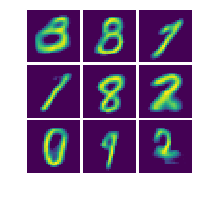

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:34:59 end epoch 43/300: average loss = 0.03549890241632292 (=0.022184+0.013315)

2018-05-07 22:34:59 start epoch 44/300, with learning rate = 0.0004194900
2018-05-07 22:34:59 iteration 1/859: current training loss = 0.034957 (=0.021594+0.013363)
2018-05-07 22:35:00 iteration 100/859: current training loss = 0.035043 (=0.021573+0.013470)
2018-05-07 22:35:01 iteration 200/859: current training loss = 0.035521 (=0.021057+0.014463)
2018-05-07 22:35:01 iteration 300/859: current training loss = 0.033532 (=0.020807+0.012726)
2018-05-07 22:35:02 iteration 400/859: current training loss = 0.035868 (=0.022779+0.013089)
2018-05-07 22:35:03 iteration 500/859: current training loss = 0.033721 (=0.020084+0.013638)
2018-05-07 22:35:04 iteration 600/859: current training loss = 0.037517 (=0.023215+0.014303)
2018-05-07 22:35:04 iteration 700/859: current training loss = 0.033297 (=0.020424+0.012873)
2018-05-07 22:35:05 iteration 800/859: curre

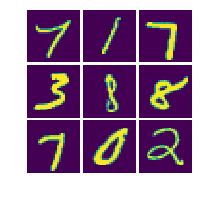

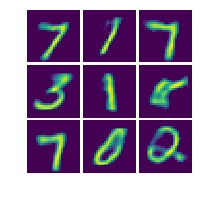

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:07 end epoch 44/300: average loss = 0.03535710917666503 (=0.022011+0.013346)

2018-05-07 22:35:07 start epoch 45/300, with learning rate = 0.0004111002
2018-05-07 22:35:07 iteration 1/859: current training loss = 0.036592 (=0.023029+0.013563)
2018-05-07 22:35:08 iteration 100/859: current training loss = 0.033483 (=0.019878+0.013605)
2018-05-07 22:35:08 iteration 200/859: current training loss = 0.037301 (=0.023237+0.014064)
2018-05-07 22:35:09 iteration 300/859: current training loss = 0.033264 (=0.020255+0.013009)
2018-05-07 22:35:10 iteration 400/859: current training loss = 0.037059 (=0.023997+0.013062)
2018-05-07 22:35:10 iteration 500/859: current training loss = 0.035447 (=0.022284+0.013163)
2018-05-07 22:35:11 iteration 600/859: current training loss = 0.036639 (=0.024073+0.012566)
2018-05-07 22:35:12 iteration 700/859: current training loss = 0.036314 (=0.022422+0.013892)
2018-05-07 22:35:13 iteration 800/859: curre

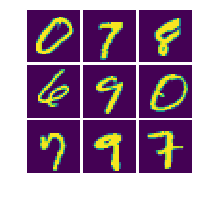

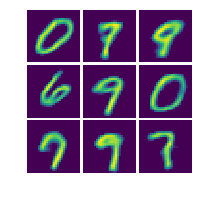

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:14 end epoch 45/300: average loss = 0.035291365457306226 (=0.021952+0.013340)

2018-05-07 22:35:14 start epoch 46/300, with learning rate = 0.0004028782
2018-05-07 22:35:14 iteration 1/859: current training loss = 0.034369 (=0.020858+0.013511)
2018-05-07 22:35:15 iteration 100/859: current training loss = 0.034071 (=0.021139+0.012932)
2018-05-07 22:35:16 iteration 200/859: current training loss = 0.035200 (=0.021735+0.013465)
2018-05-07 22:35:16 iteration 300/859: current training loss = 0.035026 (=0.021498+0.013529)
2018-05-07 22:35:17 iteration 400/859: current training loss = 0.034570 (=0.021003+0.013567)
2018-05-07 22:35:18 iteration 500/859: current training loss = 0.035234 (=0.021968+0.013265)
2018-05-07 22:35:19 iteration 600/859: current training loss = 0.037927 (=0.024256+0.013671)
2018-05-07 22:35:19 iteration 700/859: current training loss = 0.035565 (=0.022210+0.013355)
2018-05-07 22:35:20 iteration 800/859: curr

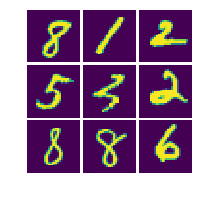

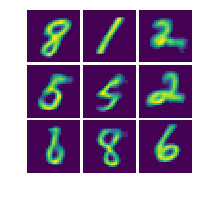

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:22 end epoch 46/300: average loss = 0.03514741591640832 (=0.021819+0.013328)

2018-05-07 22:35:22 start epoch 47/300, with learning rate = 0.0003948207
2018-05-07 22:35:22 iteration 1/859: current training loss = 0.032763 (=0.019562+0.013202)
2018-05-07 22:35:22 iteration 100/859: current training loss = 0.035382 (=0.021934+0.013448)
2018-05-07 22:35:23 iteration 200/859: current training loss = 0.036801 (=0.023204+0.013597)
2018-05-07 22:35:24 iteration 300/859: current training loss = 0.035299 (=0.022130+0.013169)
2018-05-07 22:35:25 iteration 400/859: current training loss = 0.036188 (=0.022888+0.013300)
2018-05-07 22:35:25 iteration 500/859: current training loss = 0.035325 (=0.021742+0.013583)
2018-05-07 22:35:26 iteration 600/859: current training loss = 0.035945 (=0.021934+0.014011)
2018-05-07 22:35:27 iteration 700/859: current training loss = 0.034029 (=0.020917+0.013112)
2018-05-07 22:35:28 iteration 800/859: curre

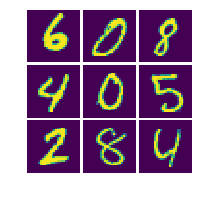

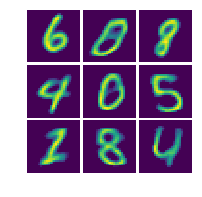

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:29 end epoch 47/300: average loss = 0.035085754241356334 (=0.021747+0.013339)

2018-05-07 22:35:29 start epoch 48/300, with learning rate = 0.0003869243
2018-05-07 22:35:29 iteration 1/859: current training loss = 0.035213 (=0.021902+0.013311)
2018-05-07 22:35:30 iteration 100/859: current training loss = 0.033985 (=0.021045+0.012940)
2018-05-07 22:35:31 iteration 200/859: current training loss = 0.033888 (=0.020896+0.012992)
2018-05-07 22:35:31 iteration 300/859: current training loss = 0.035382 (=0.022328+0.013054)
2018-05-07 22:35:32 iteration 400/859: current training loss = 0.036865 (=0.022911+0.013954)
2018-05-07 22:35:33 iteration 500/859: current training loss = 0.033493 (=0.020519+0.012973)
2018-05-07 22:35:34 iteration 600/859: current training loss = 0.034027 (=0.021231+0.012796)
2018-05-07 22:35:34 iteration 700/859: current training loss = 0.032507 (=0.019461+0.013046)
2018-05-07 22:35:35 iteration 800/859: curr

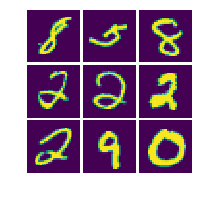

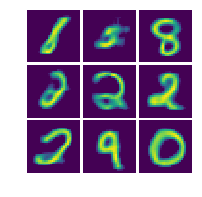

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:36 end epoch 48/300: average loss = 0.03497481367163733 (=0.021657+0.013317)

2018-05-07 22:35:36 start epoch 49/300, with learning rate = 0.0003791858
2018-05-07 22:35:36 iteration 1/859: current training loss = 0.032621 (=0.020080+0.012541)
2018-05-07 22:35:37 iteration 100/859: current training loss = 0.032905 (=0.020268+0.012636)
2018-05-07 22:35:38 iteration 200/859: current training loss = 0.032567 (=0.019701+0.012865)
2018-05-07 22:35:39 iteration 300/859: current training loss = 0.033874 (=0.020641+0.013233)
2018-05-07 22:35:39 iteration 400/859: current training loss = 0.036522 (=0.022845+0.013676)
2018-05-07 22:35:40 iteration 500/859: current training loss = 0.034642 (=0.021526+0.013116)
2018-05-07 22:35:41 iteration 600/859: current training loss = 0.035177 (=0.022649+0.012528)
2018-05-07 22:35:41 iteration 700/859: current training loss = 0.035146 (=0.021767+0.013378)
2018-05-07 22:35:42 iteration 800/859: curre

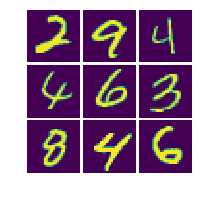

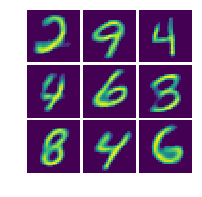

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:44 end epoch 49/300: average loss = 0.03492646650937023 (=0.021598+0.013329)

2018-05-07 22:35:44 start epoch 50/300, with learning rate = 0.0003716021
2018-05-07 22:35:44 iteration 1/859: current training loss = 0.033487 (=0.020750+0.012737)
2018-05-07 22:35:45 iteration 100/859: current training loss = 0.035890 (=0.022391+0.013499)
2018-05-07 22:35:45 iteration 200/859: current training loss = 0.034375 (=0.021081+0.013294)
2018-05-07 22:35:46 iteration 300/859: current training loss = 0.034661 (=0.021516+0.013145)
2018-05-07 22:35:47 iteration 400/859: current training loss = 0.036061 (=0.022936+0.013125)
2018-05-07 22:35:47 iteration 500/859: current training loss = 0.033896 (=0.020594+0.013301)
2018-05-07 22:35:48 iteration 600/859: current training loss = 0.036511 (=0.022977+0.013534)
2018-05-07 22:35:49 iteration 700/859: current training loss = 0.033793 (=0.020700+0.013092)
2018-05-07 22:35:50 iteration 800/859: curre

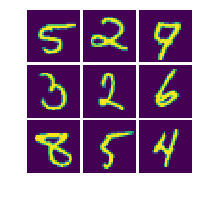

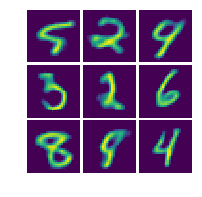

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:51 end epoch 50/300: average loss = 0.03481316945067801 (=0.021502+0.013311)

2018-05-07 22:35:51 start epoch 51/300, with learning rate = 0.0003641700
2018-05-07 22:35:51 iteration 1/859: current training loss = 0.036604 (=0.022800+0.013804)
2018-05-07 22:35:52 iteration 100/859: current training loss = 0.033880 (=0.020557+0.013323)
2018-05-07 22:35:53 iteration 200/859: current training loss = 0.033844 (=0.020775+0.013069)
2018-05-07 22:35:53 iteration 300/859: current training loss = 0.036091 (=0.022662+0.013429)
2018-05-07 22:35:54 iteration 400/859: current training loss = 0.035478 (=0.021584+0.013893)
2018-05-07 22:35:55 iteration 500/859: current training loss = 0.034854 (=0.021764+0.013090)
2018-05-07 22:35:56 iteration 600/859: current training loss = 0.035111 (=0.022336+0.012775)
2018-05-07 22:35:56 iteration 700/859: current training loss = 0.035638 (=0.022206+0.013432)
2018-05-07 22:35:57 iteration 800/859: curre

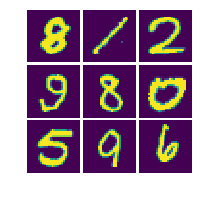

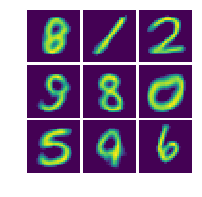

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:35:59 end epoch 51/300: average loss = 0.03472744081086968 (=0.021410+0.013318)

2018-05-07 22:35:59 start epoch 52/300, with learning rate = 0.0003568867
2018-05-07 22:35:59 iteration 1/859: current training loss = 0.033685 (=0.020942+0.012743)
2018-05-07 22:36:00 iteration 100/859: current training loss = 0.034639 (=0.020949+0.013691)
2018-05-07 22:36:00 iteration 200/859: current training loss = 0.034074 (=0.020561+0.013513)
2018-05-07 22:36:01 iteration 300/859: current training loss = 0.036120 (=0.022770+0.013350)
2018-05-07 22:36:02 iteration 400/859: current training loss = 0.035408 (=0.021347+0.014062)
2018-05-07 22:36:03 iteration 500/859: current training loss = 0.032173 (=0.019084+0.013089)
2018-05-07 22:36:03 iteration 600/859: current training loss = 0.036188 (=0.022108+0.014080)
2018-05-07 22:36:04 iteration 700/859: current training loss = 0.034587 (=0.021565+0.013022)
2018-05-07 22:36:05 iteration 800/859: curre

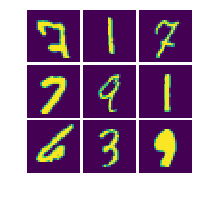

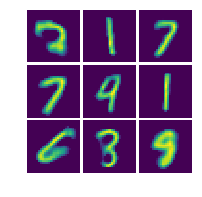

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:06 end epoch 52/300: average loss = 0.03470751120816218 (=0.021384+0.013323)

2018-05-07 22:36:06 start epoch 53/300, with learning rate = 0.0003497489
2018-05-07 22:36:06 iteration 1/859: current training loss = 0.035388 (=0.021969+0.013420)
2018-05-07 22:36:07 iteration 100/859: current training loss = 0.034251 (=0.021164+0.013086)
2018-05-07 22:36:08 iteration 200/859: current training loss = 0.034328 (=0.021461+0.012867)
2018-05-07 22:36:08 iteration 300/859: current training loss = 0.033815 (=0.020869+0.012946)
2018-05-07 22:36:09 iteration 400/859: current training loss = 0.032440 (=0.019501+0.012939)
2018-05-07 22:36:10 iteration 500/859: current training loss = 0.032927 (=0.019792+0.013135)
2018-05-07 22:36:11 iteration 600/859: current training loss = 0.032466 (=0.019313+0.013153)
2018-05-07 22:36:11 iteration 700/859: current training loss = 0.033923 (=0.020394+0.013529)
2018-05-07 22:36:12 iteration 800/859: curre

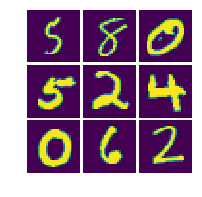

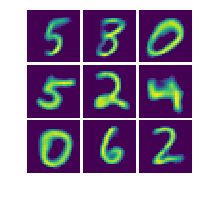

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:14 end epoch 53/300: average loss = 0.034630001933510145 (=0.021331+0.013299)

2018-05-07 22:36:14 start epoch 54/300, with learning rate = 0.0003427539
2018-05-07 22:36:14 iteration 1/859: current training loss = 0.033145 (=0.019995+0.013151)
2018-05-07 22:36:15 iteration 100/859: current training loss = 0.033428 (=0.020501+0.012927)
2018-05-07 22:36:15 iteration 200/859: current training loss = 0.036540 (=0.023452+0.013088)
2018-05-07 22:36:16 iteration 300/859: current training loss = 0.034742 (=0.021259+0.013483)
2018-05-07 22:36:17 iteration 400/859: current training loss = 0.034398 (=0.021158+0.013240)
2018-05-07 22:36:17 iteration 500/859: current training loss = 0.034205 (=0.021220+0.012985)
2018-05-07 22:36:18 iteration 600/859: current training loss = 0.035489 (=0.021669+0.013819)
2018-05-07 22:36:19 iteration 700/859: current training loss = 0.033729 (=0.020155+0.013574)
2018-05-07 22:36:20 iteration 800/859: curr

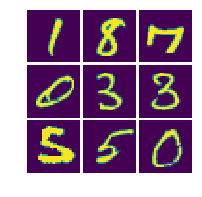

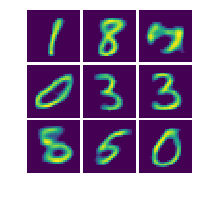

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:21 end epoch 54/300: average loss = 0.03453648219598464 (=0.021245+0.013292)

2018-05-07 22:36:21 start epoch 55/300, with learning rate = 0.0003358989
2018-05-07 22:36:21 iteration 1/859: current training loss = 0.031248 (=0.018855+0.012394)
2018-05-07 22:36:22 iteration 100/859: current training loss = 0.035229 (=0.021801+0.013428)
2018-05-07 22:36:23 iteration 200/859: current training loss = 0.034807 (=0.021548+0.013259)
2018-05-07 22:36:23 iteration 300/859: current training loss = 0.033573 (=0.020623+0.012950)
2018-05-07 22:36:24 iteration 400/859: current training loss = 0.034686 (=0.021375+0.013311)
2018-05-07 22:36:25 iteration 500/859: current training loss = 0.035384 (=0.021824+0.013560)
2018-05-07 22:36:25 iteration 600/859: current training loss = 0.034418 (=0.021207+0.013211)
2018-05-07 22:36:26 iteration 700/859: current training loss = 0.033957 (=0.020820+0.013137)
2018-05-07 22:36:27 iteration 800/859: curre

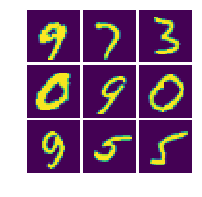

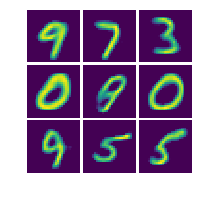

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:28 end epoch 55/300: average loss = 0.03448634888712269 (=0.021186+0.013300)

2018-05-07 22:36:28 start epoch 56/300, with learning rate = 0.0003291809
2018-05-07 22:36:28 iteration 1/859: current training loss = 0.032735 (=0.019611+0.013124)
2018-05-07 22:36:29 iteration 100/859: current training loss = 0.032830 (=0.020226+0.012604)
2018-05-07 22:36:30 iteration 200/859: current training loss = 0.035006 (=0.021882+0.013124)
2018-05-07 22:36:31 iteration 300/859: current training loss = 0.033135 (=0.019889+0.013246)
2018-05-07 22:36:31 iteration 400/859: current training loss = 0.034445 (=0.020910+0.013535)
2018-05-07 22:36:32 iteration 500/859: current training loss = 0.036537 (=0.022915+0.013622)
2018-05-07 22:36:33 iteration 600/859: current training loss = 0.033346 (=0.020156+0.013190)
2018-05-07 22:36:34 iteration 700/859: current training loss = 0.035522 (=0.021731+0.013791)
2018-05-07 22:36:34 iteration 800/859: curre

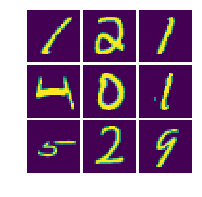

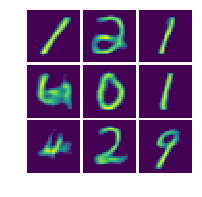

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:36 end epoch 56/300: average loss = 0.03447347532034059 (=0.021217+0.013256)

2018-05-07 22:36:36 start epoch 57/300, with learning rate = 0.0003225973
2018-05-07 22:36:36 iteration 1/859: current training loss = 0.035266 (=0.021587+0.013679)
2018-05-07 22:36:37 iteration 100/859: current training loss = 0.037256 (=0.023592+0.013664)
2018-05-07 22:36:38 iteration 200/859: current training loss = 0.032197 (=0.019108+0.013089)
2018-05-07 22:36:38 iteration 300/859: current training loss = 0.033230 (=0.020516+0.012714)
2018-05-07 22:36:39 iteration 400/859: current training loss = 0.036663 (=0.022614+0.014049)
2018-05-07 22:36:40 iteration 500/859: current training loss = 0.034383 (=0.021069+0.013313)
2018-05-07 22:36:40 iteration 600/859: current training loss = 0.035677 (=0.022599+0.013078)
2018-05-07 22:36:41 iteration 700/859: current training loss = 0.030998 (=0.018296+0.012702)
2018-05-07 22:36:42 iteration 800/859: curre

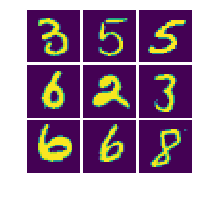

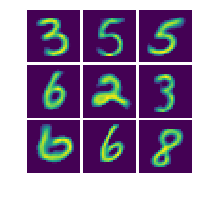

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:43 end epoch 57/300: average loss = 0.034452558359580075 (=0.021169+0.013283)

2018-05-07 22:36:43 start epoch 58/300, with learning rate = 0.0003161453
2018-05-07 22:36:43 iteration 1/859: current training loss = 0.034311 (=0.021219+0.013092)
2018-05-07 22:36:44 iteration 100/859: current training loss = 0.034789 (=0.021470+0.013319)
2018-05-07 22:36:45 iteration 200/859: current training loss = 0.035515 (=0.021743+0.013772)
2018-05-07 22:36:45 iteration 300/859: current training loss = 0.036025 (=0.022724+0.013302)
2018-05-07 22:36:46 iteration 400/859: current training loss = 0.033258 (=0.020112+0.013146)
2018-05-07 22:36:47 iteration 500/859: current training loss = 0.033128 (=0.020011+0.013117)
2018-05-07 22:36:47 iteration 600/859: current training loss = 0.034065 (=0.020722+0.013342)
2018-05-07 22:36:48 iteration 700/859: current training loss = 0.030916 (=0.018460+0.012455)
2018-05-07 22:36:49 iteration 800/859: curr

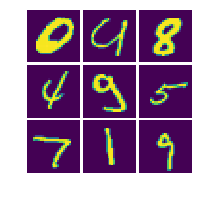

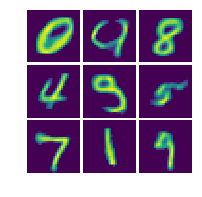

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:50 end epoch 58/300: average loss = 0.03436661862287935 (=0.021086+0.013280)

2018-05-07 22:36:50 start epoch 59/300, with learning rate = 0.0003098224
2018-05-07 22:36:50 iteration 1/859: current training loss = 0.033955 (=0.020646+0.013310)
2018-05-07 22:36:51 iteration 100/859: current training loss = 0.030830 (=0.018599+0.012231)
2018-05-07 22:36:52 iteration 200/859: current training loss = 0.034202 (=0.021485+0.012717)
2018-05-07 22:36:53 iteration 300/859: current training loss = 0.034355 (=0.021184+0.013171)
2018-05-07 22:36:53 iteration 400/859: current training loss = 0.035522 (=0.021608+0.013914)
2018-05-07 22:36:54 iteration 500/859: current training loss = 0.035592 (=0.021606+0.013985)
2018-05-07 22:36:55 iteration 600/859: current training loss = 0.033375 (=0.020561+0.012814)
2018-05-07 22:36:55 iteration 700/859: current training loss = 0.033881 (=0.020375+0.013506)
2018-05-07 22:36:56 iteration 800/859: curre

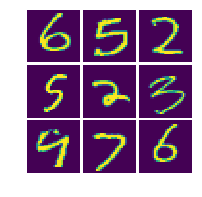

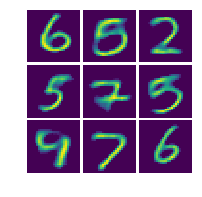

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:36:58 end epoch 59/300: average loss = 0.034300512052005606 (=0.021025+0.013275)

2018-05-07 22:36:58 start epoch 60/300, with learning rate = 0.0003036260
2018-05-07 22:36:58 iteration 1/859: current training loss = 0.036466 (=0.022103+0.014363)
2018-05-07 22:36:59 iteration 100/859: current training loss = 0.033919 (=0.020366+0.013553)
2018-05-07 22:36:59 iteration 200/859: current training loss = 0.034484 (=0.021064+0.013420)
2018-05-07 22:37:00 iteration 300/859: current training loss = 0.035388 (=0.022129+0.013259)
2018-05-07 22:37:01 iteration 400/859: current training loss = 0.038253 (=0.023804+0.014449)
2018-05-07 22:37:01 iteration 500/859: current training loss = 0.034750 (=0.021319+0.013432)
2018-05-07 22:37:02 iteration 600/859: current training loss = 0.036110 (=0.022634+0.013476)
2018-05-07 22:37:03 iteration 700/859: current training loss = 0.033695 (=0.020976+0.012719)
2018-05-07 22:37:03 iteration 800/859: curr

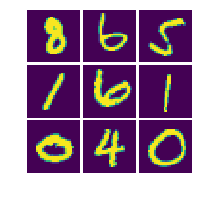

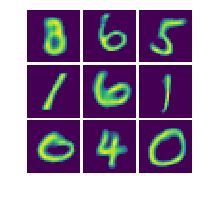

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:05 end epoch 60/300: average loss = 0.0342466876201323 (=0.020972+0.013275)

2018-05-07 22:37:05 start epoch 61/300, with learning rate = 0.0002975535
2018-05-07 22:37:05 iteration 1/859: current training loss = 0.034075 (=0.020705+0.013370)
2018-05-07 22:37:06 iteration 100/859: current training loss = 0.032961 (=0.019534+0.013427)
2018-05-07 22:37:07 iteration 200/859: current training loss = 0.034240 (=0.021208+0.013032)
2018-05-07 22:37:07 iteration 300/859: current training loss = 0.033512 (=0.020641+0.012871)
2018-05-07 22:37:08 iteration 400/859: current training loss = 0.033163 (=0.019986+0.013177)
2018-05-07 22:37:09 iteration 500/859: current training loss = 0.032821 (=0.019644+0.013177)
2018-05-07 22:37:09 iteration 600/859: current training loss = 0.033004 (=0.019994+0.013010)
2018-05-07 22:37:10 iteration 700/859: current training loss = 0.035156 (=0.021068+0.014088)
2018-05-07 22:37:11 iteration 800/859: curren

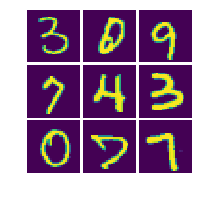

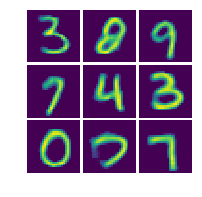

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:12 end epoch 61/300: average loss = 0.03424914198145877 (=0.020984+0.013265)

2018-05-07 22:37:12 start epoch 62/300, with learning rate = 0.0002916025
2018-05-07 22:37:12 iteration 1/859: current training loss = 0.033821 (=0.020945+0.012876)
2018-05-07 22:37:13 iteration 100/859: current training loss = 0.031284 (=0.018719+0.012565)
2018-05-07 22:37:14 iteration 200/859: current training loss = 0.035483 (=0.022062+0.013421)
2018-05-07 22:37:15 iteration 300/859: current training loss = 0.032768 (=0.019761+0.013008)
2018-05-07 22:37:15 iteration 400/859: current training loss = 0.035782 (=0.021842+0.013940)
2018-05-07 22:37:16 iteration 500/859: current training loss = 0.030968 (=0.018212+0.012756)
2018-05-07 22:37:17 iteration 600/859: current training loss = 0.033086 (=0.020016+0.013071)
2018-05-07 22:37:18 iteration 700/859: current training loss = 0.035608 (=0.022350+0.013258)
2018-05-07 22:37:18 iteration 800/859: curre

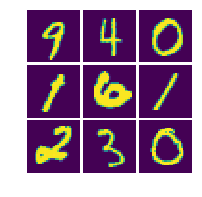

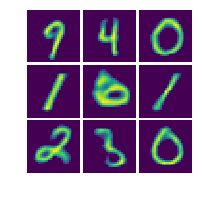

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:20 end epoch 62/300: average loss = 0.03418761889891519 (=0.020918+0.013270)

2018-05-07 22:37:20 start epoch 63/300, with learning rate = 0.0002857704
2018-05-07 22:37:20 iteration 1/859: current training loss = 0.035808 (=0.021944+0.013863)
2018-05-07 22:37:21 iteration 100/859: current training loss = 0.033774 (=0.020941+0.012834)
2018-05-07 22:37:21 iteration 200/859: current training loss = 0.032657 (=0.019386+0.013271)
2018-05-07 22:37:22 iteration 300/859: current training loss = 0.035463 (=0.022368+0.013095)
2018-05-07 22:37:23 iteration 400/859: current training loss = 0.035323 (=0.021576+0.013746)
2018-05-07 22:37:23 iteration 500/859: current training loss = 0.031881 (=0.019007+0.012875)
2018-05-07 22:37:24 iteration 600/859: current training loss = 0.033756 (=0.020607+0.013149)
2018-05-07 22:37:25 iteration 700/859: current training loss = 0.034312 (=0.020678+0.013634)
2018-05-07 22:37:25 iteration 800/859: curre

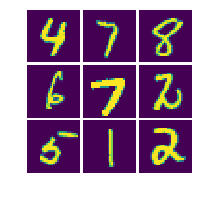

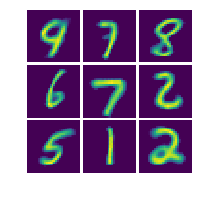

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:27 end epoch 63/300: average loss = 0.03420780127492925 (=0.020936+0.013272)

2018-05-07 22:37:27 start epoch 64/300, with learning rate = 0.0002800550
2018-05-07 22:37:27 iteration 1/859: current training loss = 0.034607 (=0.020864+0.013743)
2018-05-07 22:37:28 iteration 100/859: current training loss = 0.034307 (=0.020973+0.013334)
2018-05-07 22:37:29 iteration 200/859: current training loss = 0.032074 (=0.018650+0.013424)
2018-05-07 22:37:29 iteration 300/859: current training loss = 0.033289 (=0.020077+0.013212)
2018-05-07 22:37:30 iteration 400/859: current training loss = 0.032583 (=0.019563+0.013020)
2018-05-07 22:37:31 iteration 500/859: current training loss = 0.036232 (=0.022821+0.013411)
2018-05-07 22:37:32 iteration 600/859: current training loss = 0.033530 (=0.019584+0.013947)
2018-05-07 22:37:32 iteration 700/859: current training loss = 0.034651 (=0.021525+0.013126)
2018-05-07 22:37:33 iteration 800/859: curre

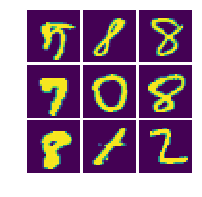

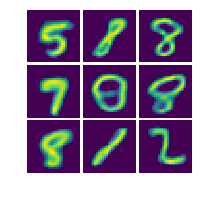

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:34 end epoch 64/300: average loss = 0.0341607371130492 (=0.020917+0.013244)

2018-05-07 22:37:34 start epoch 65/300, with learning rate = 0.0002744539
2018-05-07 22:37:34 iteration 1/859: current training loss = 0.035549 (=0.021679+0.013870)
2018-05-07 22:37:35 iteration 100/859: current training loss = 0.030869 (=0.018498+0.012371)
2018-05-07 22:37:36 iteration 200/859: current training loss = 0.035863 (=0.022396+0.013467)
2018-05-07 22:37:37 iteration 300/859: current training loss = 0.034655 (=0.021264+0.013391)
2018-05-07 22:37:37 iteration 400/859: current training loss = 0.031757 (=0.019117+0.012640)
2018-05-07 22:37:38 iteration 500/859: current training loss = 0.031941 (=0.019559+0.012381)
2018-05-07 22:37:39 iteration 600/859: current training loss = 0.032509 (=0.019343+0.013165)
2018-05-07 22:37:40 iteration 700/859: current training loss = 0.034333 (=0.020986+0.013348)
2018-05-07 22:37:40 iteration 800/859: curren

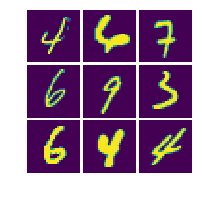

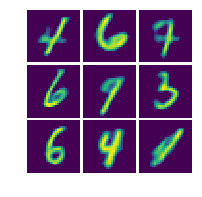

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:42 end epoch 65/300: average loss = 0.034027259211393115 (=0.020786+0.013242)

2018-05-07 22:37:42 start epoch 66/300, with learning rate = 0.0002689648
2018-05-07 22:37:42 iteration 1/859: current training loss = 0.036313 (=0.022297+0.014016)
2018-05-07 22:37:43 iteration 100/859: current training loss = 0.034682 (=0.020840+0.013842)
2018-05-07 22:37:44 iteration 200/859: current training loss = 0.032603 (=0.019334+0.013268)
2018-05-07 22:37:44 iteration 300/859: current training loss = 0.034698 (=0.020874+0.013825)
2018-05-07 22:37:45 iteration 400/859: current training loss = 0.034572 (=0.021147+0.013425)
2018-05-07 22:37:46 iteration 500/859: current training loss = 0.032997 (=0.019751+0.013246)
2018-05-07 22:37:47 iteration 600/859: current training loss = 0.034666 (=0.021317+0.013349)
2018-05-07 22:37:47 iteration 700/859: current training loss = 0.034089 (=0.020749+0.013340)
2018-05-07 22:37:48 iteration 800/859: curr

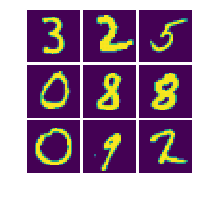

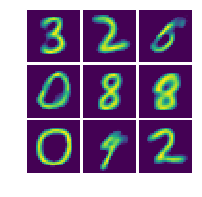

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:50 end epoch 66/300: average loss = 0.03411706442249737 (=0.020854+0.013263)

2018-05-07 22:37:50 start epoch 67/300, with learning rate = 0.0002635856
2018-05-07 22:37:50 iteration 1/859: current training loss = 0.033007 (=0.019814+0.013193)
2018-05-07 22:37:50 iteration 100/859: current training loss = 0.033607 (=0.020354+0.013253)
2018-05-07 22:37:51 iteration 200/859: current training loss = 0.035215 (=0.021861+0.013354)
2018-05-07 22:37:52 iteration 300/859: current training loss = 0.034959 (=0.021513+0.013446)
2018-05-07 22:37:53 iteration 400/859: current training loss = 0.034192 (=0.020963+0.013229)
2018-05-07 22:37:53 iteration 500/859: current training loss = 0.032406 (=0.019259+0.013147)
2018-05-07 22:37:54 iteration 600/859: current training loss = 0.035073 (=0.021455+0.013618)
2018-05-07 22:37:55 iteration 700/859: current training loss = 0.035510 (=0.021755+0.013755)
2018-05-07 22:37:56 iteration 800/859: curre

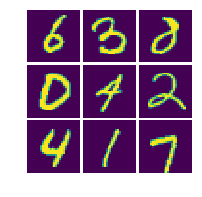

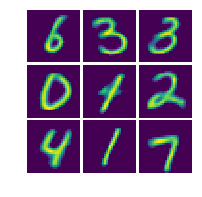

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:37:57 end epoch 67/300: average loss = 0.03405315566881711 (=0.020797+0.013256)

2018-05-07 22:37:57 start epoch 68/300, with learning rate = 0.0002583138
2018-05-07 22:37:57 iteration 1/859: current training loss = 0.033710 (=0.020460+0.013251)
2018-05-07 22:37:58 iteration 100/859: current training loss = 0.034048 (=0.020983+0.013065)
2018-05-07 22:37:59 iteration 200/859: current training loss = 0.034096 (=0.021082+0.013015)
2018-05-07 22:38:00 iteration 300/859: current training loss = 0.034615 (=0.020983+0.013631)
2018-05-07 22:38:00 iteration 400/859: current training loss = 0.034476 (=0.021381+0.013095)
2018-05-07 22:38:01 iteration 500/859: current training loss = 0.035730 (=0.022206+0.013524)
2018-05-07 22:38:02 iteration 600/859: current training loss = 0.031580 (=0.019660+0.011919)
2018-05-07 22:38:02 iteration 700/859: current training loss = 0.037112 (=0.023464+0.013648)
2018-05-07 22:38:03 iteration 800/859: curre

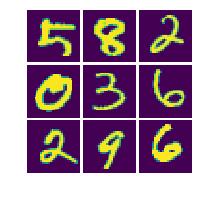

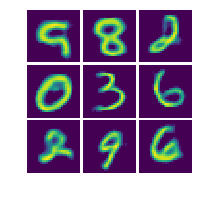

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:05 end epoch 68/300: average loss = 0.03402294262558465 (=0.020782+0.013240)

2018-05-07 22:38:05 start epoch 69/300, with learning rate = 0.0002531476
2018-05-07 22:38:05 iteration 1/859: current training loss = 0.032638 (=0.019768+0.012870)
2018-05-07 22:38:05 iteration 100/859: current training loss = 0.034185 (=0.020873+0.013312)
2018-05-07 22:38:06 iteration 200/859: current training loss = 0.032855 (=0.019786+0.013068)
2018-05-07 22:38:07 iteration 300/859: current training loss = 0.032008 (=0.018775+0.013233)
2018-05-07 22:38:08 iteration 400/859: current training loss = 0.031626 (=0.018678+0.012948)
2018-05-07 22:38:08 iteration 500/859: current training loss = 0.033452 (=0.020364+0.013088)
2018-05-07 22:38:09 iteration 600/859: current training loss = 0.032956 (=0.020083+0.012873)
2018-05-07 22:38:10 iteration 700/859: current training loss = 0.035495 (=0.020747+0.014748)
2018-05-07 22:38:11 iteration 800/859: curre

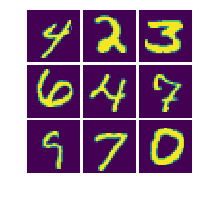

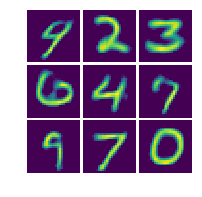

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:12 end epoch 69/300: average loss = 0.03395709456557167 (=0.020719+0.013238)

2018-05-07 22:38:12 start epoch 70/300, with learning rate = 0.0002480846
2018-05-07 22:38:12 iteration 1/859: current training loss = 0.035908 (=0.022204+0.013704)
2018-05-07 22:38:13 iteration 100/859: current training loss = 0.035521 (=0.022157+0.013365)
2018-05-07 22:38:14 iteration 200/859: current training loss = 0.031997 (=0.019237+0.012760)
2018-05-07 22:38:14 iteration 300/859: current training loss = 0.031682 (=0.018502+0.013179)
2018-05-07 22:38:15 iteration 400/859: current training loss = 0.033177 (=0.019947+0.013230)
2018-05-07 22:38:16 iteration 500/859: current training loss = 0.035293 (=0.021326+0.013967)
2018-05-07 22:38:17 iteration 600/859: current training loss = 0.035000 (=0.022128+0.012872)
2018-05-07 22:38:17 iteration 700/859: current training loss = 0.034131 (=0.021191+0.012941)
2018-05-07 22:38:18 iteration 800/859: curre

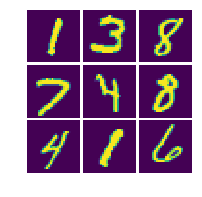

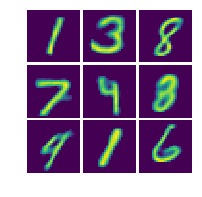

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:20 end epoch 70/300: average loss = 0.03396424631413606 (=0.020720+0.013244)

2018-05-07 22:38:20 start epoch 71/300, with learning rate = 0.0002431229
2018-05-07 22:38:20 iteration 1/859: current training loss = 0.033411 (=0.020231+0.013180)
2018-05-07 22:38:20 iteration 100/859: current training loss = 0.035097 (=0.022059+0.013038)
2018-05-07 22:38:21 iteration 200/859: current training loss = 0.034488 (=0.021450+0.013039)
2018-05-07 22:38:22 iteration 300/859: current training loss = 0.032071 (=0.018952+0.013119)
2018-05-07 22:38:23 iteration 400/859: current training loss = 0.034487 (=0.021528+0.012959)
2018-05-07 22:38:23 iteration 500/859: current training loss = 0.035082 (=0.021532+0.013550)
2018-05-07 22:38:24 iteration 600/859: current training loss = 0.034242 (=0.020998+0.013244)
2018-05-07 22:38:25 iteration 700/859: current training loss = 0.035032 (=0.021227+0.013806)
2018-05-07 22:38:26 iteration 800/859: curre

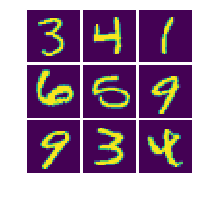

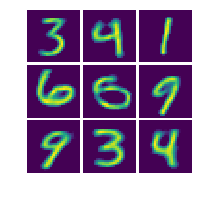

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:27 end epoch 71/300: average loss = 0.03387441459449054 (=0.020639+0.013236)

2018-05-07 22:38:27 start epoch 72/300, with learning rate = 0.0002382605
2018-05-07 22:38:27 iteration 1/859: current training loss = 0.034674 (=0.021164+0.013510)
2018-05-07 22:38:28 iteration 100/859: current training loss = 0.032615 (=0.019522+0.013093)
2018-05-07 22:38:29 iteration 200/859: current training loss = 0.033958 (=0.020512+0.013446)
2018-05-07 22:38:29 iteration 300/859: current training loss = 0.034783 (=0.021196+0.013588)
2018-05-07 22:38:30 iteration 400/859: current training loss = 0.033591 (=0.020457+0.013133)
2018-05-07 22:38:31 iteration 500/859: current training loss = 0.034626 (=0.021256+0.013370)
2018-05-07 22:38:32 iteration 600/859: current training loss = 0.035180 (=0.021652+0.013528)
2018-05-07 22:38:32 iteration 700/859: current training loss = 0.033341 (=0.020360+0.012981)
2018-05-07 22:38:33 iteration 800/859: curre

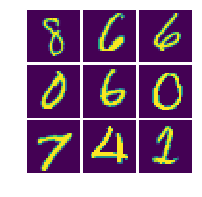

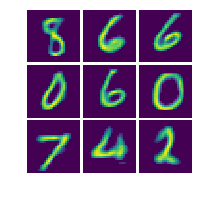

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:35 end epoch 72/300: average loss = 0.033890345004821965 (=0.020641+0.013249)

2018-05-07 22:38:35 start epoch 73/300, with learning rate = 0.0002334953
2018-05-07 22:38:35 iteration 1/859: current training loss = 0.034384 (=0.021024+0.013360)
2018-05-07 22:38:36 iteration 100/859: current training loss = 0.034905 (=0.021123+0.013781)
2018-05-07 22:38:36 iteration 200/859: current training loss = 0.032589 (=0.019693+0.012896)
2018-05-07 22:38:37 iteration 300/859: current training loss = 0.033540 (=0.020430+0.013110)
2018-05-07 22:38:38 iteration 400/859: current training loss = 0.035478 (=0.021924+0.013554)
2018-05-07 22:38:38 iteration 500/859: current training loss = 0.035047 (=0.022185+0.012861)
2018-05-07 22:38:39 iteration 600/859: current training loss = 0.033344 (=0.019955+0.013389)
2018-05-07 22:38:40 iteration 700/859: current training loss = 0.031979 (=0.019153+0.012826)
2018-05-07 22:38:40 iteration 800/859: curr

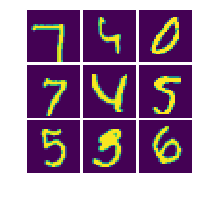

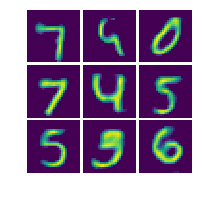

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:42 end epoch 73/300: average loss = 0.03383250263485975 (=0.020616+0.013217)

2018-05-07 22:38:42 start epoch 74/300, with learning rate = 0.0002288253
2018-05-07 22:38:42 iteration 1/859: current training loss = 0.032427 (=0.019420+0.013007)
2018-05-07 22:38:43 iteration 100/859: current training loss = 0.036655 (=0.022885+0.013770)
2018-05-07 22:38:43 iteration 200/859: current training loss = 0.033856 (=0.020584+0.013272)
2018-05-07 22:38:44 iteration 300/859: current training loss = 0.034537 (=0.020930+0.013607)
2018-05-07 22:38:45 iteration 400/859: current training loss = 0.033125 (=0.020105+0.013020)
2018-05-07 22:38:45 iteration 500/859: current training loss = 0.033358 (=0.019944+0.013415)
2018-05-07 22:38:46 iteration 600/859: current training loss = 0.034649 (=0.020937+0.013712)
2018-05-07 22:38:47 iteration 700/859: current training loss = 0.029918 (=0.017645+0.012274)
2018-05-07 22:38:48 iteration 800/859: curre

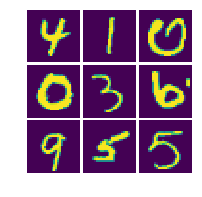

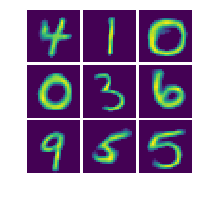

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:49 end epoch 74/300: average loss = 0.033859572437298036 (=0.020615+0.013245)

2018-05-07 22:38:49 start epoch 75/300, with learning rate = 0.0002242489
2018-05-07 22:38:49 iteration 1/859: current training loss = 0.033512 (=0.020375+0.013137)
2018-05-07 22:38:50 iteration 100/859: current training loss = 0.035393 (=0.021758+0.013635)
2018-05-07 22:38:51 iteration 200/859: current training loss = 0.035145 (=0.021653+0.013492)
2018-05-07 22:38:52 iteration 300/859: current training loss = 0.034220 (=0.020944+0.013276)
2018-05-07 22:38:52 iteration 400/859: current training loss = 0.032529 (=0.019588+0.012941)
2018-05-07 22:38:53 iteration 500/859: current training loss = 0.032483 (=0.019329+0.013155)
2018-05-07 22:38:54 iteration 600/859: current training loss = 0.033378 (=0.020183+0.013195)
2018-05-07 22:38:55 iteration 700/859: current training loss = 0.035615 (=0.021809+0.013806)
2018-05-07 22:38:55 iteration 800/859: curr

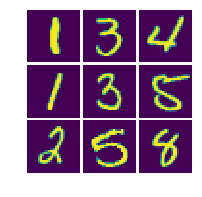

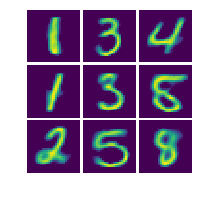

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:38:57 end epoch 75/300: average loss = 0.03379473946468169 (=0.020548+0.013246)

2018-05-07 22:38:57 start epoch 76/300, with learning rate = 0.0002197639
2018-05-07 22:38:57 iteration 1/859: current training loss = 0.036885 (=0.022891+0.013993)
2018-05-07 22:38:58 iteration 100/859: current training loss = 0.034316 (=0.021216+0.013100)
2018-05-07 22:38:58 iteration 200/859: current training loss = 0.033189 (=0.020248+0.012942)
2018-05-07 22:38:59 iteration 300/859: current training loss = 0.034013 (=0.020901+0.013113)
2018-05-07 22:39:00 iteration 400/859: current training loss = 0.033425 (=0.020340+0.013084)
2018-05-07 22:39:00 iteration 500/859: current training loss = 0.033777 (=0.020074+0.013703)
2018-05-07 22:39:01 iteration 600/859: current training loss = 0.035881 (=0.021947+0.013934)
2018-05-07 22:39:02 iteration 700/859: current training loss = 0.035161 (=0.022137+0.013024)
2018-05-07 22:39:03 iteration 800/859: curre

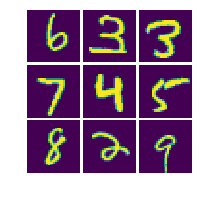

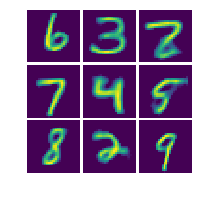

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:04 end epoch 76/300: average loss = 0.03374005805557904 (=0.020528+0.013212)

2018-05-07 22:39:04 start epoch 77/300, with learning rate = 0.0002153686
2018-05-07 22:39:04 iteration 1/859: current training loss = 0.035302 (=0.021791+0.013511)
2018-05-07 22:39:05 iteration 100/859: current training loss = 0.034690 (=0.021119+0.013571)
2018-05-07 22:39:06 iteration 200/859: current training loss = 0.031839 (=0.018772+0.013068)
2018-05-07 22:39:06 iteration 300/859: current training loss = 0.033945 (=0.020956+0.012988)
2018-05-07 22:39:07 iteration 400/859: current training loss = 0.033753 (=0.019819+0.013934)
2018-05-07 22:39:08 iteration 500/859: current training loss = 0.033912 (=0.020633+0.013279)
2018-05-07 22:39:09 iteration 600/859: current training loss = 0.033203 (=0.020097+0.013107)
2018-05-07 22:39:09 iteration 700/859: current training loss = 0.034393 (=0.021111+0.013282)
2018-05-07 22:39:10 iteration 800/859: curre

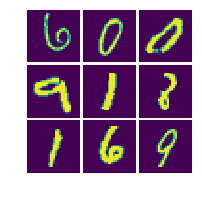

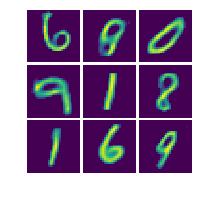

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:12 end epoch 77/300: average loss = 0.03375600553545949 (=0.020519+0.013237)

2018-05-07 22:39:12 start epoch 78/300, with learning rate = 0.0002110613
2018-05-07 22:39:12 iteration 1/859: current training loss = 0.035635 (=0.021662+0.013973)
2018-05-07 22:39:13 iteration 100/859: current training loss = 0.033791 (=0.020056+0.013735)
2018-05-07 22:39:14 iteration 200/859: current training loss = 0.032761 (=0.019302+0.013458)
2018-05-07 22:39:14 iteration 300/859: current training loss = 0.035632 (=0.021671+0.013961)
2018-05-07 22:39:15 iteration 400/859: current training loss = 0.033417 (=0.019908+0.013509)
2018-05-07 22:39:16 iteration 500/859: current training loss = 0.034371 (=0.020912+0.013459)
2018-05-07 22:39:17 iteration 600/859: current training loss = 0.035257 (=0.021425+0.013831)
2018-05-07 22:39:17 iteration 700/859: current training loss = 0.034175 (=0.020568+0.013607)
2018-05-07 22:39:18 iteration 800/859: curre

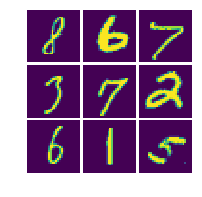

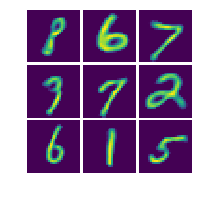

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:20 end epoch 78/300: average loss = 0.03376874733798648 (=0.020508+0.013260)

2018-05-07 22:39:20 start epoch 79/300, with learning rate = 0.0002068400
2018-05-07 22:39:20 iteration 1/859: current training loss = 0.034616 (=0.021064+0.013552)
2018-05-07 22:39:20 iteration 100/859: current training loss = 0.034108 (=0.020476+0.013632)
2018-05-07 22:39:21 iteration 200/859: current training loss = 0.035527 (=0.022048+0.013479)
2018-05-07 22:39:22 iteration 300/859: current training loss = 0.031882 (=0.018725+0.013157)
2018-05-07 22:39:23 iteration 400/859: current training loss = 0.033860 (=0.020233+0.013627)
2018-05-07 22:39:23 iteration 500/859: current training loss = 0.033733 (=0.020495+0.013238)
2018-05-07 22:39:24 iteration 600/859: current training loss = 0.032646 (=0.019946+0.012700)
2018-05-07 22:39:25 iteration 700/859: current training loss = 0.032991 (=0.019899+0.013092)
2018-05-07 22:39:26 iteration 800/859: curre

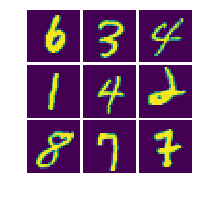

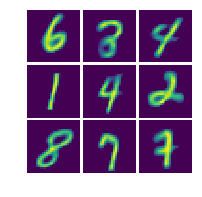

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:27 end epoch 79/300: average loss = 0.033768602899504487 (=0.020506+0.013263)

2018-05-07 22:39:27 start epoch 80/300, with learning rate = 0.0002027032
2018-05-07 22:39:27 iteration 1/859: current training loss = 0.031745 (=0.018989+0.012756)
2018-05-07 22:39:28 iteration 100/859: current training loss = 0.035376 (=0.021805+0.013572)
2018-05-07 22:39:29 iteration 200/859: current training loss = 0.035389 (=0.021613+0.013776)
2018-05-07 22:39:30 iteration 300/859: current training loss = 0.032247 (=0.019442+0.012805)
2018-05-07 22:39:30 iteration 400/859: current training loss = 0.032061 (=0.018772+0.013289)
2018-05-07 22:39:31 iteration 500/859: current training loss = 0.036309 (=0.022190+0.014118)
2018-05-07 22:39:32 iteration 600/859: current training loss = 0.031866 (=0.019309+0.012556)
2018-05-07 22:39:33 iteration 700/859: current training loss = 0.032177 (=0.019188+0.012989)
2018-05-07 22:39:33 iteration 800/859: curr

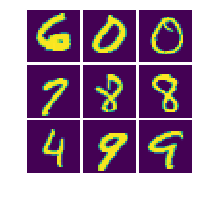

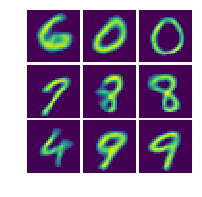

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:35 end epoch 80/300: average loss = 0.03370042652438142 (=0.020499+0.013201)

2018-05-07 22:39:35 start epoch 81/300, with learning rate = 0.0001986491
2018-05-07 22:39:35 iteration 1/859: current training loss = 0.031652 (=0.018971+0.012681)
2018-05-07 22:39:36 iteration 100/859: current training loss = 0.033997 (=0.020686+0.013311)
2018-05-07 22:39:37 iteration 200/859: current training loss = 0.035716 (=0.022140+0.013576)
2018-05-07 22:39:37 iteration 300/859: current training loss = 0.033346 (=0.019651+0.013694)
2018-05-07 22:39:38 iteration 400/859: current training loss = 0.035692 (=0.022046+0.013646)
2018-05-07 22:39:39 iteration 500/859: current training loss = 0.033410 (=0.020752+0.012658)
2018-05-07 22:39:40 iteration 600/859: current training loss = 0.033412 (=0.020624+0.012788)
2018-05-07 22:39:40 iteration 700/859: current training loss = 0.032171 (=0.019592+0.012579)
2018-05-07 22:39:41 iteration 800/859: curre

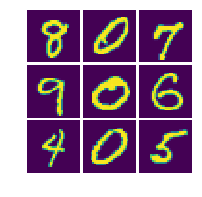

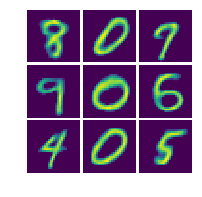

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:43 end epoch 81/300: average loss = 0.03365722121681684 (=0.020432+0.013225)

2018-05-07 22:39:43 start epoch 82/300, with learning rate = 0.0001946762
2018-05-07 22:39:43 iteration 1/859: current training loss = 0.032194 (=0.019361+0.012833)
2018-05-07 22:39:44 iteration 100/859: current training loss = 0.032841 (=0.019809+0.013031)
2018-05-07 22:39:44 iteration 200/859: current training loss = 0.034036 (=0.021013+0.013023)
2018-05-07 22:39:45 iteration 300/859: current training loss = 0.034728 (=0.021028+0.013700)
2018-05-07 22:39:46 iteration 400/859: current training loss = 0.034361 (=0.021290+0.013071)
2018-05-07 22:39:47 iteration 500/859: current training loss = 0.034602 (=0.020927+0.013675)
2018-05-07 22:39:47 iteration 600/859: current training loss = 0.033037 (=0.020149+0.012888)
2018-05-07 22:39:48 iteration 700/859: current training loss = 0.033513 (=0.020148+0.013365)
2018-05-07 22:39:49 iteration 800/859: curre

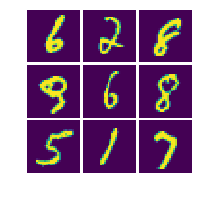

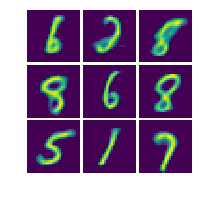

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:51 end epoch 82/300: average loss = 0.03366792378719458 (=0.020457+0.013211)

2018-05-07 22:39:51 start epoch 83/300, with learning rate = 0.0001907827
2018-05-07 22:39:51 iteration 1/859: current training loss = 0.032675 (=0.019741+0.012935)
2018-05-07 22:39:51 iteration 100/859: current training loss = 0.034222 (=0.020643+0.013579)
2018-05-07 22:39:52 iteration 200/859: current training loss = 0.035788 (=0.022348+0.013440)
2018-05-07 22:39:53 iteration 300/859: current training loss = 0.032880 (=0.019888+0.012992)
2018-05-07 22:39:54 iteration 400/859: current training loss = 0.035375 (=0.021739+0.013635)
2018-05-07 22:39:54 iteration 500/859: current training loss = 0.034560 (=0.021898+0.012662)
2018-05-07 22:39:55 iteration 600/859: current training loss = 0.033496 (=0.020417+0.013079)
2018-05-07 22:39:56 iteration 700/859: current training loss = 0.035938 (=0.022112+0.013826)
2018-05-07 22:39:56 iteration 800/859: curre

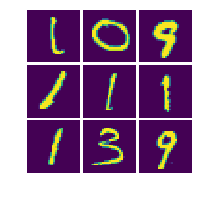

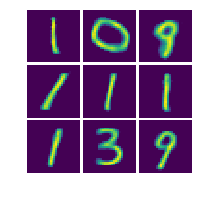

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:39:58 end epoch 83/300: average loss = 0.03364819676395207 (=0.020423+0.013225)

2018-05-07 22:39:58 start epoch 84/300, with learning rate = 0.0001869670
2018-05-07 22:39:58 iteration 1/859: current training loss = 0.033805 (=0.020827+0.012978)
2018-05-07 22:39:59 iteration 100/859: current training loss = 0.033719 (=0.020353+0.013367)
2018-05-07 22:39:59 iteration 200/859: current training loss = 0.033173 (=0.019927+0.013246)
2018-05-07 22:40:00 iteration 300/859: current training loss = 0.033871 (=0.020568+0.013303)
2018-05-07 22:40:01 iteration 400/859: current training loss = 0.034101 (=0.020638+0.013462)
2018-05-07 22:40:01 iteration 500/859: current training loss = 0.034611 (=0.021327+0.013284)
2018-05-07 22:40:02 iteration 600/859: current training loss = 0.033138 (=0.019563+0.013576)
2018-05-07 22:40:03 iteration 700/859: current training loss = 0.034536 (=0.021162+0.013374)
2018-05-07 22:40:04 iteration 800/859: curre

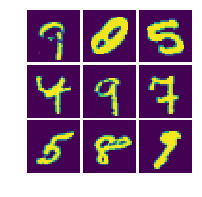

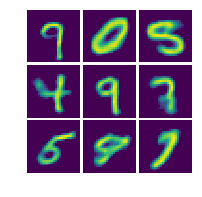

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:05 end epoch 84/300: average loss = 0.03359834772856674 (=0.020386+0.013213)

2018-05-07 22:40:05 start epoch 85/300, with learning rate = 0.0001832277
2018-05-07 22:40:05 iteration 1/859: current training loss = 0.034251 (=0.020552+0.013699)
2018-05-07 22:40:06 iteration 100/859: current training loss = 0.033707 (=0.020651+0.013055)
2018-05-07 22:40:07 iteration 200/859: current training loss = 0.034604 (=0.021346+0.013258)
2018-05-07 22:40:08 iteration 300/859: current training loss = 0.035729 (=0.022120+0.013609)
2018-05-07 22:40:08 iteration 400/859: current training loss = 0.031832 (=0.018717+0.013115)
2018-05-07 22:40:09 iteration 500/859: current training loss = 0.033828 (=0.021242+0.012586)
2018-05-07 22:40:10 iteration 600/859: current training loss = 0.031715 (=0.018856+0.012859)
2018-05-07 22:40:11 iteration 700/859: current training loss = 0.034845 (=0.021086+0.013760)
2018-05-07 22:40:11 iteration 800/859: curre

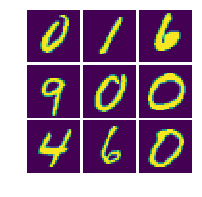

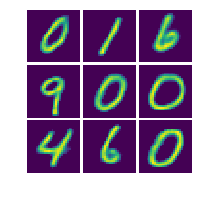

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:13 end epoch 85/300: average loss = 0.03359590193670898 (=0.020353+0.013243)

2018-05-07 22:40:13 start epoch 86/300, with learning rate = 0.0001795631
2018-05-07 22:40:13 iteration 1/859: current training loss = 0.034671 (=0.021455+0.013216)
2018-05-07 22:40:14 iteration 100/859: current training loss = 0.034588 (=0.021496+0.013092)
2018-05-07 22:40:15 iteration 200/859: current training loss = 0.035246 (=0.021743+0.013503)
2018-05-07 22:40:15 iteration 300/859: current training loss = 0.034598 (=0.020908+0.013689)
2018-05-07 22:40:16 iteration 400/859: current training loss = 0.033997 (=0.020623+0.013374)
2018-05-07 22:40:17 iteration 500/859: current training loss = 0.032391 (=0.018519+0.013872)
2018-05-07 22:40:18 iteration 600/859: current training loss = 0.034534 (=0.021029+0.013504)
2018-05-07 22:40:18 iteration 700/859: current training loss = 0.034019 (=0.020519+0.013500)
2018-05-07 22:40:19 iteration 800/859: curre

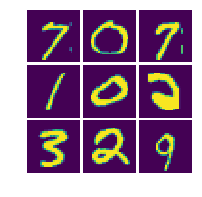

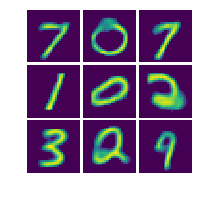

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:21 end epoch 86/300: average loss = 0.033575949758915744 (=0.020335+0.013241)

2018-05-07 22:40:21 start epoch 87/300, with learning rate = 0.0001759719
2018-05-07 22:40:21 iteration 1/859: current training loss = 0.031329 (=0.018632+0.012697)
2018-05-07 22:40:22 iteration 100/859: current training loss = 0.032642 (=0.019160+0.013482)
2018-05-07 22:40:22 iteration 200/859: current training loss = 0.032874 (=0.019591+0.013283)
2018-05-07 22:40:23 iteration 300/859: current training loss = 0.031736 (=0.018989+0.012747)
2018-05-07 22:40:24 iteration 400/859: current training loss = 0.035591 (=0.021593+0.013998)
2018-05-07 22:40:25 iteration 500/859: current training loss = 0.034117 (=0.020723+0.013393)
2018-05-07 22:40:25 iteration 600/859: current training loss = 0.035886 (=0.022189+0.013697)
2018-05-07 22:40:26 iteration 700/859: current training loss = 0.034152 (=0.020672+0.013479)
2018-05-07 22:40:27 iteration 800/859: curr

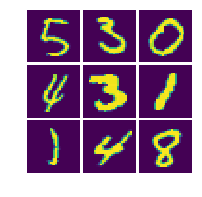

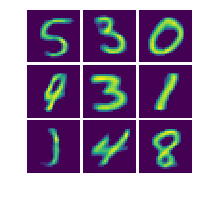

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:28 end epoch 87/300: average loss = 0.033527820974987375 (=0.020312+0.013216)

2018-05-07 22:40:28 start epoch 88/300, with learning rate = 0.0001724524
2018-05-07 22:40:28 iteration 1/859: current training loss = 0.035383 (=0.021976+0.013407)
2018-05-07 22:40:29 iteration 100/859: current training loss = 0.031024 (=0.018258+0.012766)
2018-05-07 22:40:30 iteration 200/859: current training loss = 0.033933 (=0.020594+0.013338)
2018-05-07 22:40:31 iteration 300/859: current training loss = 0.032028 (=0.018813+0.013215)
2018-05-07 22:40:31 iteration 400/859: current training loss = 0.034586 (=0.020873+0.013713)
2018-05-07 22:40:32 iteration 500/859: current training loss = 0.033825 (=0.020636+0.013189)
2018-05-07 22:40:33 iteration 600/859: current training loss = 0.033860 (=0.020705+0.013155)
2018-05-07 22:40:34 iteration 700/859: current training loss = 0.034944 (=0.021839+0.013104)
2018-05-07 22:40:34 iteration 800/859: curr

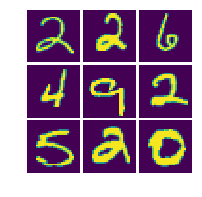

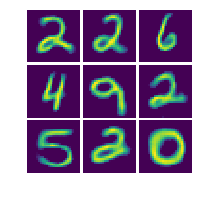

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:36 end epoch 88/300: average loss = 0.033579698780050654 (=0.020342+0.013238)

2018-05-07 22:40:36 start epoch 89/300, with learning rate = 0.0001690034
2018-05-07 22:40:36 iteration 1/859: current training loss = 0.031721 (=0.019210+0.012511)
2018-05-07 22:40:37 iteration 100/859: current training loss = 0.033052 (=0.019818+0.013234)
2018-05-07 22:40:37 iteration 200/859: current training loss = 0.032439 (=0.019607+0.012831)
2018-05-07 22:40:38 iteration 300/859: current training loss = 0.034017 (=0.020421+0.013596)
2018-05-07 22:40:39 iteration 400/859: current training loss = 0.032401 (=0.019239+0.013161)
2018-05-07 22:40:40 iteration 500/859: current training loss = 0.032372 (=0.019350+0.013022)
2018-05-07 22:40:41 iteration 600/859: current training loss = 0.033056 (=0.019582+0.013475)
2018-05-07 22:40:41 iteration 700/859: current training loss = 0.035628 (=0.022333+0.013295)
2018-05-07 22:40:42 iteration 800/859: curr

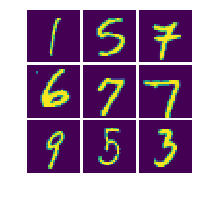

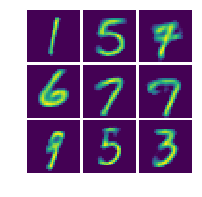

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:44 end epoch 89/300: average loss = 0.03351335567709523 (=0.020287+0.013226)

2018-05-07 22:40:44 start epoch 90/300, with learning rate = 0.0001656233
2018-05-07 22:40:44 iteration 1/859: current training loss = 0.034421 (=0.021143+0.013278)
2018-05-07 22:40:44 iteration 100/859: current training loss = 0.033171 (=0.020126+0.013045)
2018-05-07 22:40:45 iteration 200/859: current training loss = 0.028983 (=0.016625+0.012359)
2018-05-07 22:40:46 iteration 300/859: current training loss = 0.032992 (=0.020289+0.012702)
2018-05-07 22:40:47 iteration 400/859: current training loss = 0.033218 (=0.020018+0.013200)
2018-05-07 22:40:47 iteration 500/859: current training loss = 0.035514 (=0.022185+0.013329)
2018-05-07 22:40:48 iteration 600/859: current training loss = 0.034048 (=0.020599+0.013449)
2018-05-07 22:40:49 iteration 700/859: current training loss = 0.031886 (=0.018727+0.013159)
2018-05-07 22:40:50 iteration 800/859: curre

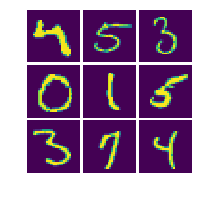

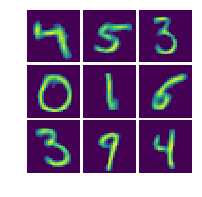

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:51 end epoch 90/300: average loss = 0.033508404460545885 (=0.020301+0.013208)

2018-05-07 22:40:51 start epoch 91/300, with learning rate = 0.0001623109
2018-05-07 22:40:51 iteration 1/859: current training loss = 0.033552 (=0.019982+0.013570)
2018-05-07 22:40:52 iteration 100/859: current training loss = 0.036486 (=0.022773+0.013713)
2018-05-07 22:40:53 iteration 200/859: current training loss = 0.033190 (=0.019824+0.013366)
2018-05-07 22:40:53 iteration 300/859: current training loss = 0.035394 (=0.021469+0.013925)
2018-05-07 22:40:54 iteration 400/859: current training loss = 0.031523 (=0.018788+0.012735)
2018-05-07 22:40:55 iteration 500/859: current training loss = 0.035536 (=0.021242+0.014294)
2018-05-07 22:40:56 iteration 600/859: current training loss = 0.033658 (=0.020369+0.013290)
2018-05-07 22:40:56 iteration 700/859: current training loss = 0.033789 (=0.020353+0.013435)
2018-05-07 22:40:57 iteration 800/859: curr

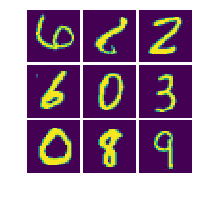

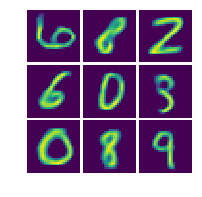

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:40:59 end epoch 91/300: average loss = 0.03352521601262068 (=0.020305+0.013220)

2018-05-07 22:40:59 start epoch 92/300, with learning rate = 0.0001590646
2018-05-07 22:40:59 iteration 1/859: current training loss = 0.032011 (=0.018886+0.013125)
2018-05-07 22:41:00 iteration 100/859: current training loss = 0.033357 (=0.019937+0.013420)
2018-05-07 22:41:00 iteration 200/859: current training loss = 0.033672 (=0.020573+0.013099)
2018-05-07 22:41:01 iteration 300/859: current training loss = 0.033543 (=0.020598+0.012946)
2018-05-07 22:41:02 iteration 400/859: current training loss = 0.034701 (=0.020833+0.013867)
2018-05-07 22:41:02 iteration 500/859: current training loss = 0.032840 (=0.019728+0.013111)
2018-05-07 22:41:03 iteration 600/859: current training loss = 0.034478 (=0.020712+0.013766)
2018-05-07 22:41:04 iteration 700/859: current training loss = 0.031870 (=0.019122+0.012748)
2018-05-07 22:41:05 iteration 800/859: curre

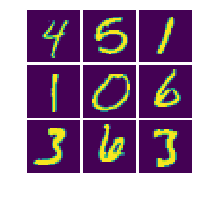

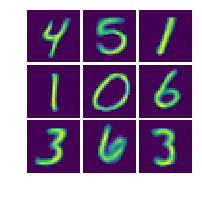

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:06 end epoch 92/300: average loss = 0.03341275385696966 (=0.020189+0.013224)

2018-05-07 22:41:06 start epoch 93/300, with learning rate = 0.0001558833
2018-05-07 22:41:06 iteration 1/859: current training loss = 0.034693 (=0.021503+0.013190)
2018-05-07 22:41:07 iteration 100/859: current training loss = 0.031080 (=0.018518+0.012563)
2018-05-07 22:41:08 iteration 200/859: current training loss = 0.033043 (=0.019979+0.013064)
2018-05-07 22:41:08 iteration 300/859: current training loss = 0.032960 (=0.019755+0.013205)
2018-05-07 22:41:09 iteration 400/859: current training loss = 0.032437 (=0.019338+0.013099)
2018-05-07 22:41:10 iteration 500/859: current training loss = 0.036122 (=0.021776+0.014346)
2018-05-07 22:41:10 iteration 600/859: current training loss = 0.033035 (=0.020042+0.012993)
2018-05-07 22:41:11 iteration 700/859: current training loss = 0.033113 (=0.019870+0.013242)
2018-05-07 22:41:12 iteration 800/859: curre

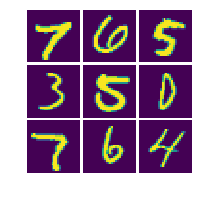

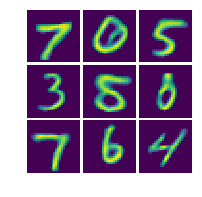

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:13 end epoch 93/300: average loss = 0.033446396016911524 (=0.020234+0.013213)

2018-05-07 22:41:13 start epoch 94/300, with learning rate = 0.0001527657
2018-05-07 22:41:14 iteration 1/859: current training loss = 0.031323 (=0.018517+0.012807)
2018-05-07 22:41:14 iteration 100/859: current training loss = 0.035166 (=0.022144+0.013022)
2018-05-07 22:41:15 iteration 200/859: current training loss = 0.033723 (=0.020690+0.013033)
2018-05-07 22:41:16 iteration 300/859: current training loss = 0.033577 (=0.020568+0.013009)
2018-05-07 22:41:17 iteration 400/859: current training loss = 0.030488 (=0.018076+0.012412)
2018-05-07 22:41:17 iteration 500/859: current training loss = 0.033490 (=0.019998+0.013491)
2018-05-07 22:41:18 iteration 600/859: current training loss = 0.032903 (=0.019492+0.013411)
2018-05-07 22:41:19 iteration 700/859: current training loss = 0.032541 (=0.019222+0.013319)
2018-05-07 22:41:20 iteration 800/859: curr

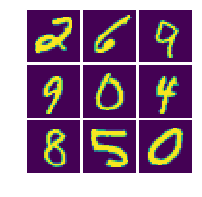

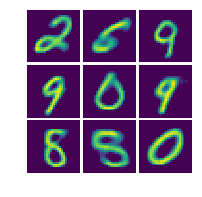

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:21 end epoch 94/300: average loss = 0.03343019083714735 (=0.020213+0.013217)

2018-05-07 22:41:21 start epoch 95/300, with learning rate = 0.0001497104
2018-05-07 22:41:21 iteration 1/859: current training loss = 0.030678 (=0.018094+0.012584)
2018-05-07 22:41:22 iteration 100/859: current training loss = 0.032554 (=0.019447+0.013107)
2018-05-07 22:41:23 iteration 200/859: current training loss = 0.035826 (=0.022296+0.013530)
2018-05-07 22:41:23 iteration 300/859: current training loss = 0.034338 (=0.021204+0.013133)
2018-05-07 22:41:24 iteration 400/859: current training loss = 0.034115 (=0.020668+0.013447)
2018-05-07 22:41:25 iteration 500/859: current training loss = 0.035373 (=0.021109+0.014264)
2018-05-07 22:41:26 iteration 600/859: current training loss = 0.031554 (=0.018703+0.012851)
2018-05-07 22:41:26 iteration 700/859: current training loss = 0.033654 (=0.020226+0.013428)
2018-05-07 22:41:27 iteration 800/859: curre

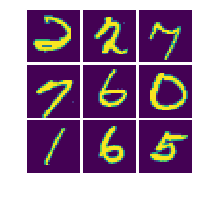

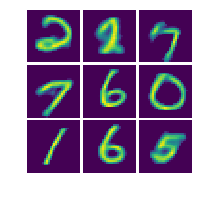

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:29 end epoch 95/300: average loss = 0.03344962772792932 (=0.020229+0.013220)

2018-05-07 22:41:29 start epoch 96/300, with learning rate = 0.0001467162
2018-05-07 22:41:29 iteration 1/859: current training loss = 0.032409 (=0.019631+0.012778)
2018-05-07 22:41:30 iteration 100/859: current training loss = 0.032043 (=0.019102+0.012941)
2018-05-07 22:41:30 iteration 200/859: current training loss = 0.032276 (=0.019866+0.012409)
2018-05-07 22:41:31 iteration 300/859: current training loss = 0.032330 (=0.018936+0.013394)
2018-05-07 22:41:32 iteration 400/859: current training loss = 0.034392 (=0.020322+0.014069)
2018-05-07 22:41:32 iteration 500/859: current training loss = 0.033704 (=0.020331+0.013373)
2018-05-07 22:41:33 iteration 600/859: current training loss = 0.032878 (=0.019829+0.013049)
2018-05-07 22:41:34 iteration 700/859: current training loss = 0.034490 (=0.021164+0.013326)
2018-05-07 22:41:35 iteration 800/859: curre

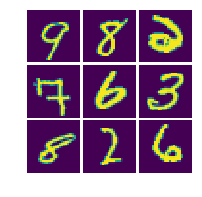

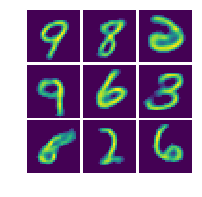

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:36 end epoch 96/300: average loss = 0.033426790193538586 (=0.020212+0.013215)

2018-05-07 22:41:36 start epoch 97/300, with learning rate = 0.0001437819
2018-05-07 22:41:36 iteration 1/859: current training loss = 0.034387 (=0.020506+0.013881)
2018-05-07 22:41:37 iteration 100/859: current training loss = 0.033389 (=0.019632+0.013757)
2018-05-07 22:41:38 iteration 200/859: current training loss = 0.032843 (=0.019568+0.013275)
2018-05-07 22:41:38 iteration 300/859: current training loss = 0.034882 (=0.021672+0.013210)
2018-05-07 22:41:39 iteration 400/859: current training loss = 0.031848 (=0.018891+0.012957)
2018-05-07 22:41:40 iteration 500/859: current training loss = 0.032551 (=0.019516+0.013035)
2018-05-07 22:41:40 iteration 600/859: current training loss = 0.035804 (=0.022329+0.013476)
2018-05-07 22:41:41 iteration 700/859: current training loss = 0.034024 (=0.020892+0.013133)
2018-05-07 22:41:42 iteration 800/859: curr

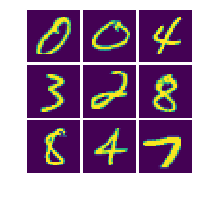

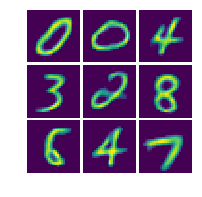

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:43 end epoch 97/300: average loss = 0.03337963549929809 (=0.020155+0.013225)

2018-05-07 22:41:43 start epoch 98/300, with learning rate = 0.0001409062
2018-05-07 22:41:43 iteration 1/859: current training loss = 0.032881 (=0.019449+0.013433)
2018-05-07 22:41:44 iteration 100/859: current training loss = 0.034031 (=0.020577+0.013454)
2018-05-07 22:41:45 iteration 200/859: current training loss = 0.032855 (=0.019755+0.013100)
2018-05-07 22:41:46 iteration 300/859: current training loss = 0.032573 (=0.018949+0.013623)
2018-05-07 22:41:46 iteration 400/859: current training loss = 0.033424 (=0.019819+0.013605)
2018-05-07 22:41:47 iteration 500/859: current training loss = 0.032908 (=0.020190+0.012717)
2018-05-07 22:41:48 iteration 600/859: current training loss = 0.033846 (=0.020668+0.013178)
2018-05-07 22:41:49 iteration 700/859: current training loss = 0.034032 (=0.020761+0.013272)
2018-05-07 22:41:49 iteration 800/859: curre

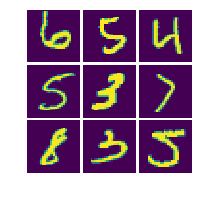

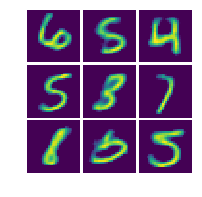

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:51 end epoch 98/300: average loss = 0.0333812746465449 (=0.020176+0.013205)

2018-05-07 22:41:51 start epoch 99/300, with learning rate = 0.0001380881
2018-05-07 22:41:51 iteration 1/859: current training loss = 0.035127 (=0.022461+0.012666)
2018-05-07 22:41:52 iteration 100/859: current training loss = 0.034309 (=0.020723+0.013586)
2018-05-07 22:41:53 iteration 200/859: current training loss = 0.031752 (=0.018653+0.013099)
2018-05-07 22:41:54 iteration 300/859: current training loss = 0.033527 (=0.020301+0.013226)
2018-05-07 22:41:54 iteration 400/859: current training loss = 0.031073 (=0.018229+0.012844)
2018-05-07 22:41:55 iteration 500/859: current training loss = 0.033248 (=0.020485+0.012763)
2018-05-07 22:41:56 iteration 600/859: current training loss = 0.036894 (=0.022711+0.014183)
2018-05-07 22:41:56 iteration 700/859: current training loss = 0.032953 (=0.019013+0.013941)
2018-05-07 22:41:57 iteration 800/859: curren

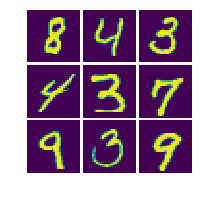

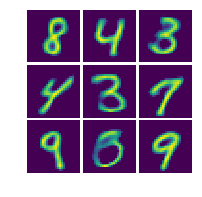

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:41:59 end epoch 99/300: average loss = 0.0333578844681573 (=0.020182+0.013176)

2018-05-07 22:41:59 start epoch 100/300, with learning rate = 0.0001353264
2018-05-07 22:41:59 iteration 1/859: current training loss = 0.033258 (=0.020235+0.013023)
2018-05-07 22:42:00 iteration 100/859: current training loss = 0.034605 (=0.021370+0.013235)
2018-05-07 22:42:00 iteration 200/859: current training loss = 0.031647 (=0.018477+0.013169)
2018-05-07 22:42:01 iteration 300/859: current training loss = 0.032632 (=0.019619+0.013013)
2018-05-07 22:42:02 iteration 400/859: current training loss = 0.035356 (=0.021632+0.013724)
2018-05-07 22:42:03 iteration 500/859: current training loss = 0.033002 (=0.019975+0.013027)
2018-05-07 22:42:03 iteration 600/859: current training loss = 0.033615 (=0.020428+0.013187)
2018-05-07 22:42:04 iteration 700/859: current training loss = 0.032389 (=0.019664+0.012725)
2018-05-07 22:42:05 iteration 800/859: curre

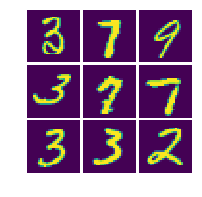

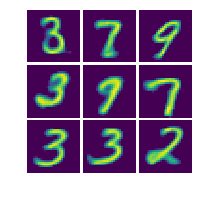

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:06 end epoch 100/300: average loss = 0.033339907106215934 (=0.020144+0.013196)

2018-05-07 22:42:06 start epoch 101/300, with learning rate = 0.0001326198
2018-05-07 22:42:06 iteration 1/859: current training loss = 0.031868 (=0.019007+0.012860)
2018-05-07 22:42:07 iteration 100/859: current training loss = 0.033973 (=0.020294+0.013678)
2018-05-07 22:42:08 iteration 200/859: current training loss = 0.033019 (=0.019862+0.013157)
2018-05-07 22:42:09 iteration 300/859: current training loss = 0.032216 (=0.019174+0.013042)
2018-05-07 22:42:09 iteration 400/859: current training loss = 0.032270 (=0.019642+0.012628)
2018-05-07 22:42:10 iteration 500/859: current training loss = 0.035013 (=0.021221+0.013792)
2018-05-07 22:42:11 iteration 600/859: current training loss = 0.032761 (=0.019408+0.013353)
2018-05-07 22:42:11 iteration 700/859: current training loss = 0.031864 (=0.019355+0.012509)
2018-05-07 22:42:12 iteration 800/859: cu

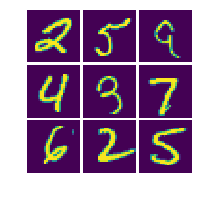

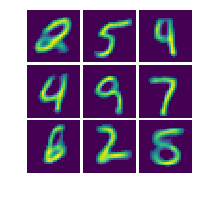

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:14 end epoch 101/300: average loss = 0.033317164091850884 (=0.020105+0.013212)

2018-05-07 22:42:14 start epoch 102/300, with learning rate = 0.0001299674
2018-05-07 22:42:14 iteration 1/859: current training loss = 0.034117 (=0.020834+0.013283)
2018-05-07 22:42:14 iteration 100/859: current training loss = 0.033358 (=0.020312+0.013046)
2018-05-07 22:42:15 iteration 200/859: current training loss = 0.035666 (=0.021583+0.014083)
2018-05-07 22:42:16 iteration 300/859: current training loss = 0.034580 (=0.021350+0.013229)
2018-05-07 22:42:16 iteration 400/859: current training loss = 0.033989 (=0.020019+0.013970)
2018-05-07 22:42:17 iteration 500/859: current training loss = 0.034909 (=0.021612+0.013297)
2018-05-07 22:42:18 iteration 600/859: current training loss = 0.034524 (=0.021679+0.012845)
2018-05-07 22:42:18 iteration 700/859: current training loss = 0.035827 (=0.022937+0.012890)
2018-05-07 22:42:19 iteration 800/859: cu

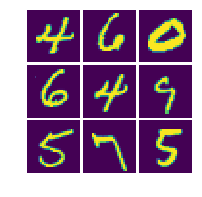

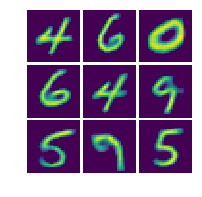

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:21 end epoch 102/300: average loss = 0.03335844349805634 (=0.020136+0.013223)

2018-05-07 22:42:21 start epoch 103/300, with learning rate = 0.0001273681
2018-05-07 22:42:21 iteration 1/859: current training loss = 0.033779 (=0.020434+0.013345)
2018-05-07 22:42:22 iteration 100/859: current training loss = 0.033785 (=0.020143+0.013643)
2018-05-07 22:42:22 iteration 200/859: current training loss = 0.035091 (=0.021823+0.013268)
2018-05-07 22:42:23 iteration 300/859: current training loss = 0.036250 (=0.022708+0.013543)
2018-05-07 22:42:24 iteration 400/859: current training loss = 0.031441 (=0.018478+0.012963)
2018-05-07 22:42:25 iteration 500/859: current training loss = 0.031618 (=0.018697+0.012922)
2018-05-07 22:42:25 iteration 600/859: current training loss = 0.033406 (=0.020108+0.013298)
2018-05-07 22:42:26 iteration 700/859: current training loss = 0.034842 (=0.021391+0.013450)
2018-05-07 22:42:27 iteration 800/859: cur

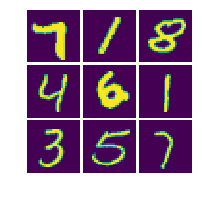

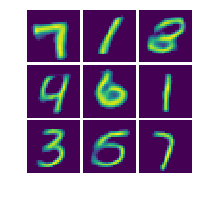

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:28 end epoch 103/300: average loss = 0.03330636448611758 (=0.020101+0.013205)

2018-05-07 22:42:28 start epoch 104/300, with learning rate = 0.0001248207
2018-05-07 22:42:28 iteration 1/859: current training loss = 0.032859 (=0.019526+0.013333)
2018-05-07 22:42:29 iteration 100/859: current training loss = 0.032436 (=0.019163+0.013273)
2018-05-07 22:42:30 iteration 200/859: current training loss = 0.033449 (=0.019908+0.013541)
2018-05-07 22:42:31 iteration 300/859: current training loss = 0.033997 (=0.020171+0.013827)
2018-05-07 22:42:32 iteration 400/859: current training loss = 0.032079 (=0.019255+0.012824)
2018-05-07 22:42:32 iteration 500/859: current training loss = 0.036031 (=0.022596+0.013435)
2018-05-07 22:42:33 iteration 600/859: current training loss = 0.030825 (=0.018477+0.012348)
2018-05-07 22:42:34 iteration 700/859: current training loss = 0.033418 (=0.020375+0.013042)
2018-05-07 22:42:35 iteration 800/859: cur

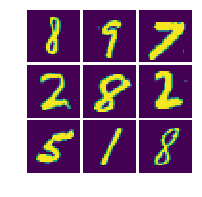

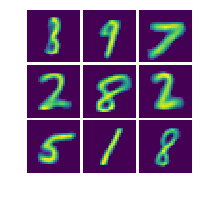

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:36 end epoch 104/300: average loss = 0.033303016250274375 (=0.020102+0.013201)

2018-05-07 22:42:36 start epoch 105/300, with learning rate = 0.0001223243
2018-05-07 22:42:36 iteration 1/859: current training loss = 0.033384 (=0.020744+0.012640)
2018-05-07 22:42:37 iteration 100/859: current training loss = 0.034223 (=0.021113+0.013110)
2018-05-07 22:42:38 iteration 200/859: current training loss = 0.033367 (=0.020374+0.012993)
2018-05-07 22:42:39 iteration 300/859: current training loss = 0.034371 (=0.020585+0.013786)
2018-05-07 22:42:39 iteration 400/859: current training loss = 0.034316 (=0.020331+0.013986)
2018-05-07 22:42:40 iteration 500/859: current training loss = 0.033376 (=0.020116+0.013260)
2018-05-07 22:42:41 iteration 600/859: current training loss = 0.030680 (=0.017485+0.013195)
2018-05-07 22:42:42 iteration 700/859: current training loss = 0.032768 (=0.019667+0.013101)
2018-05-07 22:42:42 iteration 800/859: cu

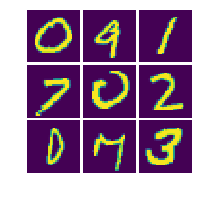

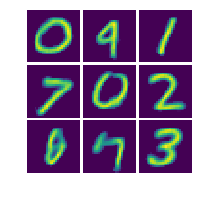

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:44 end epoch 105/300: average loss = 0.03327278265723042 (=0.020099+0.013174)

2018-05-07 22:42:44 start epoch 106/300, with learning rate = 0.0001198778
2018-05-07 22:42:44 iteration 1/859: current training loss = 0.034645 (=0.021241+0.013404)
2018-05-07 22:42:45 iteration 100/859: current training loss = 0.035449 (=0.021412+0.014037)
2018-05-07 22:42:46 iteration 200/859: current training loss = 0.035307 (=0.021881+0.013426)
2018-05-07 22:42:46 iteration 300/859: current training loss = 0.032639 (=0.019504+0.013136)
2018-05-07 22:42:47 iteration 400/859: current training loss = 0.034561 (=0.020882+0.013679)
2018-05-07 22:42:48 iteration 500/859: current training loss = 0.030552 (=0.018095+0.012457)
2018-05-07 22:42:49 iteration 600/859: current training loss = 0.033950 (=0.020615+0.013335)
2018-05-07 22:42:49 iteration 700/859: current training loss = 0.032136 (=0.019501+0.012635)
2018-05-07 22:42:50 iteration 800/859: cur

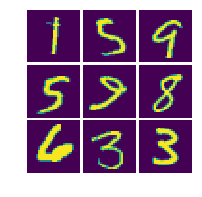

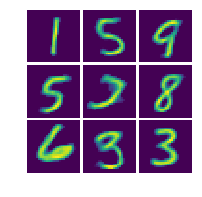

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:42:52 end epoch 106/300: average loss = 0.03323119783576695 (=0.020047+0.013184)

2018-05-07 22:42:52 start epoch 107/300, with learning rate = 0.0001174803
2018-05-07 22:42:52 iteration 1/859: current training loss = 0.033552 (=0.020531+0.013021)
2018-05-07 22:42:53 iteration 100/859: current training loss = 0.033674 (=0.020310+0.013364)
2018-05-07 22:42:53 iteration 200/859: current training loss = 0.032406 (=0.019713+0.012693)
2018-05-07 22:42:54 iteration 300/859: current training loss = 0.032761 (=0.019789+0.012971)
2018-05-07 22:42:55 iteration 400/859: current training loss = 0.033195 (=0.020004+0.013191)
2018-05-07 22:42:55 iteration 500/859: current training loss = 0.032823 (=0.020045+0.012778)
2018-05-07 22:42:56 iteration 600/859: current training loss = 0.035191 (=0.021054+0.014137)
2018-05-07 22:42:57 iteration 700/859: current training loss = 0.032791 (=0.019477+0.013315)
2018-05-07 22:42:58 iteration 800/859: cur

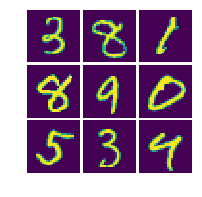

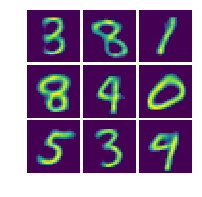

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:00 end epoch 107/300: average loss = 0.033237186029588105 (=0.020034+0.013204)

2018-05-07 22:43:00 start epoch 108/300, with learning rate = 0.0001151307
2018-05-07 22:43:00 iteration 1/859: current training loss = 0.032803 (=0.019372+0.013431)
2018-05-07 22:43:00 iteration 100/859: current training loss = 0.036396 (=0.022579+0.013817)
2018-05-07 22:43:01 iteration 200/859: current training loss = 0.032153 (=0.019127+0.013026)
2018-05-07 22:43:02 iteration 300/859: current training loss = 0.031704 (=0.018249+0.013455)
2018-05-07 22:43:03 iteration 400/859: current training loss = 0.032129 (=0.019068+0.013061)
2018-05-07 22:43:03 iteration 500/859: current training loss = 0.036082 (=0.022793+0.013289)
2018-05-07 22:43:04 iteration 600/859: current training loss = 0.033270 (=0.020502+0.012768)
2018-05-07 22:43:05 iteration 700/859: current training loss = 0.031757 (=0.018928+0.012830)
2018-05-07 22:43:06 iteration 800/859: cu

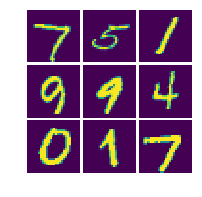

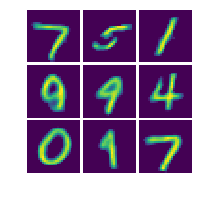

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:07 end epoch 108/300: average loss = 0.03326064610595753 (=0.020045+0.013216)

2018-05-07 22:43:07 start epoch 109/300, with learning rate = 0.0001128280
2018-05-07 22:43:07 iteration 1/859: current training loss = 0.034085 (=0.020873+0.013211)
2018-05-07 22:43:08 iteration 100/859: current training loss = 0.032933 (=0.019586+0.013346)
2018-05-07 22:43:09 iteration 200/859: current training loss = 0.033383 (=0.019631+0.013752)
2018-05-07 22:43:10 iteration 300/859: current training loss = 0.031980 (=0.018569+0.013412)
2018-05-07 22:43:10 iteration 400/859: current training loss = 0.033614 (=0.020043+0.013572)
2018-05-07 22:43:11 iteration 500/859: current training loss = 0.033940 (=0.020315+0.013625)
2018-05-07 22:43:12 iteration 600/859: current training loss = 0.034074 (=0.020747+0.013327)
2018-05-07 22:43:12 iteration 700/859: current training loss = 0.033749 (=0.020307+0.013442)
2018-05-07 22:43:13 iteration 800/859: cur

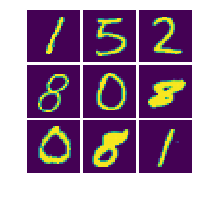

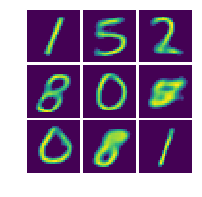

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:15 end epoch 109/300: average loss = 0.03325530562692943 (=0.020047+0.013208)

2018-05-07 22:43:15 start epoch 110/300, with learning rate = 0.0001105715
2018-05-07 22:43:15 iteration 1/859: current training loss = 0.034261 (=0.020640+0.013622)
2018-05-07 22:43:16 iteration 100/859: current training loss = 0.033795 (=0.019708+0.014087)
2018-05-07 22:43:16 iteration 200/859: current training loss = 0.035007 (=0.021258+0.013748)
2018-05-07 22:43:17 iteration 300/859: current training loss = 0.034088 (=0.021005+0.013083)
2018-05-07 22:43:18 iteration 400/859: current training loss = 0.030681 (=0.018323+0.012358)
2018-05-07 22:43:19 iteration 500/859: current training loss = 0.034006 (=0.021149+0.012856)
2018-05-07 22:43:19 iteration 600/859: current training loss = 0.031092 (=0.018022+0.013071)
2018-05-07 22:43:20 iteration 700/859: current training loss = 0.033622 (=0.020480+0.013142)
2018-05-07 22:43:21 iteration 800/859: cur

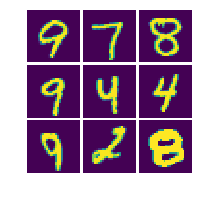

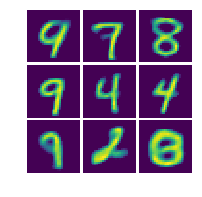

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:22 end epoch 110/300: average loss = 0.03323512303407659 (=0.020058+0.013177)

2018-05-07 22:43:22 start epoch 111/300, with learning rate = 0.0001083601
2018-05-07 22:43:22 iteration 1/859: current training loss = 0.033564 (=0.020516+0.013048)
2018-05-07 22:43:23 iteration 100/859: current training loss = 0.036685 (=0.022713+0.013972)
2018-05-07 22:43:24 iteration 200/859: current training loss = 0.031302 (=0.018675+0.012627)
2018-05-07 22:43:25 iteration 300/859: current training loss = 0.033383 (=0.020563+0.012819)
2018-05-07 22:43:25 iteration 400/859: current training loss = 0.035884 (=0.022299+0.013585)
2018-05-07 22:43:26 iteration 500/859: current training loss = 0.032783 (=0.019658+0.013125)
2018-05-07 22:43:27 iteration 600/859: current training loss = 0.032774 (=0.019472+0.013301)
2018-05-07 22:43:28 iteration 700/859: current training loss = 0.032319 (=0.019779+0.012540)
2018-05-07 22:43:28 iteration 800/859: cur

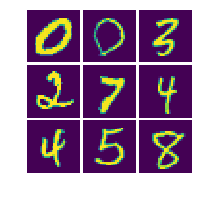

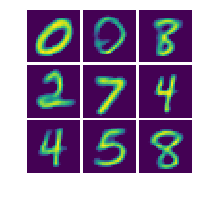

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:30 end epoch 111/300: average loss = 0.03326352242471453 (=0.020056+0.013208)

2018-05-07 22:43:30 start epoch 112/300, with learning rate = 0.0001061929
2018-05-07 22:43:30 iteration 1/859: current training loss = 0.032655 (=0.019937+0.012718)
2018-05-07 22:43:31 iteration 100/859: current training loss = 0.033235 (=0.019822+0.013412)
2018-05-07 22:43:31 iteration 200/859: current training loss = 0.034443 (=0.020745+0.013698)
2018-05-07 22:43:32 iteration 300/859: current training loss = 0.035192 (=0.021285+0.013906)
2018-05-07 22:43:33 iteration 400/859: current training loss = 0.034718 (=0.021460+0.013257)
2018-05-07 22:43:34 iteration 500/859: current training loss = 0.033389 (=0.019951+0.013438)
2018-05-07 22:43:34 iteration 600/859: current training loss = 0.031403 (=0.018539+0.012864)
2018-05-07 22:43:35 iteration 700/859: current training loss = 0.032284 (=0.019514+0.012769)
2018-05-07 22:43:36 iteration 800/859: cur

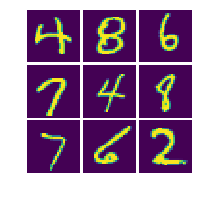

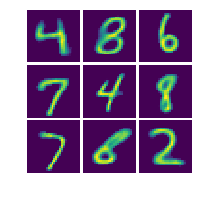

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:37 end epoch 112/300: average loss = 0.03317107604350353 (=0.019994+0.013177)

2018-05-07 22:43:37 start epoch 113/300, with learning rate = 0.0001040690
2018-05-07 22:43:37 iteration 1/859: current training loss = 0.031733 (=0.019448+0.012285)
2018-05-07 22:43:38 iteration 100/859: current training loss = 0.033691 (=0.020509+0.013182)
2018-05-07 22:43:39 iteration 200/859: current training loss = 0.035812 (=0.022147+0.013665)
2018-05-07 22:43:39 iteration 300/859: current training loss = 0.032897 (=0.019881+0.013016)
2018-05-07 22:43:40 iteration 400/859: current training loss = 0.034803 (=0.021177+0.013626)
2018-05-07 22:43:41 iteration 500/859: current training loss = 0.030766 (=0.018249+0.012517)
2018-05-07 22:43:42 iteration 600/859: current training loss = 0.037463 (=0.023026+0.014437)
2018-05-07 22:43:42 iteration 700/859: current training loss = 0.032877 (=0.019673+0.013204)
2018-05-07 22:43:43 iteration 800/859: cur

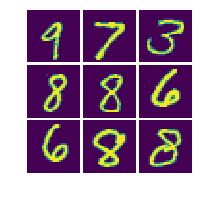

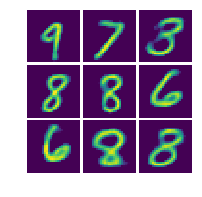

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:45 end epoch 113/300: average loss = 0.033204639892118776 (=0.020009+0.013195)

2018-05-07 22:43:45 start epoch 114/300, with learning rate = 0.0001019876
2018-05-07 22:43:45 iteration 1/859: current training loss = 0.033770 (=0.020545+0.013224)
2018-05-07 22:43:45 iteration 100/859: current training loss = 0.033470 (=0.020062+0.013408)
2018-05-07 22:43:46 iteration 200/859: current training loss = 0.035111 (=0.021652+0.013459)
2018-05-07 22:43:47 iteration 300/859: current training loss = 0.031437 (=0.018898+0.012539)
2018-05-07 22:43:47 iteration 400/859: current training loss = 0.031640 (=0.018948+0.012692)
2018-05-07 22:43:48 iteration 500/859: current training loss = 0.031048 (=0.018183+0.012866)
2018-05-07 22:43:49 iteration 600/859: current training loss = 0.033298 (=0.019795+0.013503)
2018-05-07 22:43:50 iteration 700/859: current training loss = 0.034397 (=0.020910+0.013487)
2018-05-07 22:43:50 iteration 800/859: cu

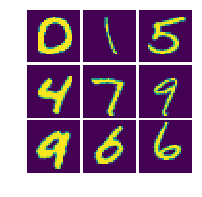

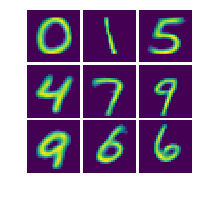

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:43:52 end epoch 114/300: average loss = 0.03317011103936069 (=0.020005+0.013165)

2018-05-07 22:43:52 start epoch 115/300, with learning rate = 0.0000999479
2018-05-07 22:43:52 iteration 1/859: current training loss = 0.031977 (=0.019464+0.012514)
2018-05-07 22:43:53 iteration 100/859: current training loss = 0.030170 (=0.017094+0.013076)
2018-05-07 22:43:54 iteration 200/859: current training loss = 0.034054 (=0.020504+0.013550)
2018-05-07 22:43:54 iteration 300/859: current training loss = 0.034024 (=0.020238+0.013786)
2018-05-07 22:43:55 iteration 400/859: current training loss = 0.033294 (=0.020212+0.013081)
2018-05-07 22:43:56 iteration 500/859: current training loss = 0.033601 (=0.019976+0.013625)
2018-05-07 22:43:57 iteration 600/859: current training loss = 0.033928 (=0.020575+0.013353)
2018-05-07 22:43:57 iteration 700/859: current training loss = 0.035111 (=0.021251+0.013859)
2018-05-07 22:43:58 iteration 800/859: cur

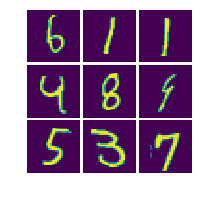

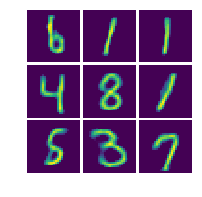

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:00 end epoch 115/300: average loss = 0.03316699732767203 (=0.019963+0.013204)

2018-05-07 22:44:00 start epoch 116/300, with learning rate = 0.0000979489
2018-05-07 22:44:00 iteration 1/859: current training loss = 0.032701 (=0.019725+0.012976)
2018-05-07 22:44:00 iteration 100/859: current training loss = 0.032725 (=0.019737+0.012988)
2018-05-07 22:44:01 iteration 200/859: current training loss = 0.033078 (=0.020230+0.012848)
2018-05-07 22:44:02 iteration 300/859: current training loss = 0.033927 (=0.020516+0.013412)
2018-05-07 22:44:03 iteration 400/859: current training loss = 0.033932 (=0.020312+0.013620)
2018-05-07 22:44:03 iteration 500/859: current training loss = 0.031672 (=0.019153+0.012519)
2018-05-07 22:44:04 iteration 600/859: current training loss = 0.034777 (=0.020700+0.014077)
2018-05-07 22:44:05 iteration 700/859: current training loss = 0.034671 (=0.020715+0.013957)
2018-05-07 22:44:06 iteration 800/859: cur

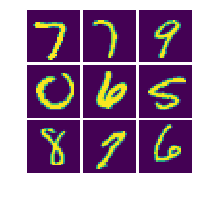

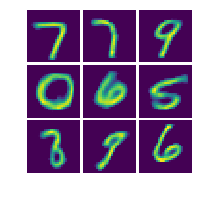

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:07 end epoch 116/300: average loss = 0.03314822668706233 (=0.019961+0.013187)

2018-05-07 22:44:07 start epoch 117/300, with learning rate = 0.0000959899
2018-05-07 22:44:07 iteration 1/859: current training loss = 0.032368 (=0.019068+0.013299)
2018-05-07 22:44:08 iteration 100/859: current training loss = 0.033273 (=0.020485+0.012788)
2018-05-07 22:44:09 iteration 200/859: current training loss = 0.031491 (=0.018592+0.012899)
2018-05-07 22:44:10 iteration 300/859: current training loss = 0.032192 (=0.019424+0.012768)
2018-05-07 22:44:10 iteration 400/859: current training loss = 0.032337 (=0.019415+0.012922)
2018-05-07 22:44:11 iteration 500/859: current training loss = 0.033192 (=0.019993+0.013199)
2018-05-07 22:44:12 iteration 600/859: current training loss = 0.032422 (=0.019817+0.012605)
2018-05-07 22:44:13 iteration 700/859: current training loss = 0.033015 (=0.020065+0.012950)
2018-05-07 22:44:13 iteration 800/859: cur

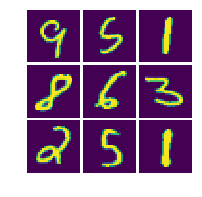

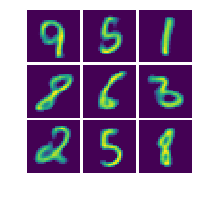

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:15 end epoch 117/300: average loss = 0.03313403364110465 (=0.019950+0.013184)

2018-05-07 22:44:15 start epoch 118/300, with learning rate = 0.0000940702
2018-05-07 22:44:15 iteration 1/859: current training loss = 0.033748 (=0.020576+0.013172)
2018-05-07 22:44:16 iteration 100/859: current training loss = 0.031532 (=0.018898+0.012634)
2018-05-07 22:44:16 iteration 200/859: current training loss = 0.032598 (=0.019314+0.013284)
2018-05-07 22:44:17 iteration 300/859: current training loss = 0.032750 (=0.020071+0.012679)
2018-05-07 22:44:18 iteration 400/859: current training loss = 0.032987 (=0.020144+0.012843)
2018-05-07 22:44:19 iteration 500/859: current training loss = 0.032038 (=0.019694+0.012345)
2018-05-07 22:44:19 iteration 600/859: current training loss = 0.035222 (=0.021611+0.013611)
2018-05-07 22:44:20 iteration 700/859: current training loss = 0.031359 (=0.018396+0.012963)
2018-05-07 22:44:21 iteration 800/859: cur

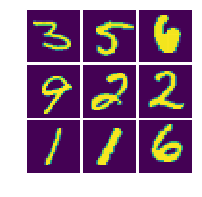

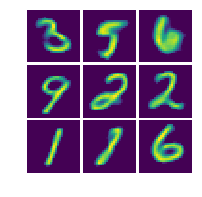

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:22 end epoch 118/300: average loss = 0.03314242879529424 (=0.019966+0.013177)

2018-05-07 22:44:22 start epoch 119/300, with learning rate = 0.0000921888
2018-05-07 22:44:22 iteration 1/859: current training loss = 0.033107 (=0.020407+0.012700)
2018-05-07 22:44:23 iteration 100/859: current training loss = 0.030080 (=0.017090+0.012990)
2018-05-07 22:44:24 iteration 200/859: current training loss = 0.032610 (=0.019730+0.012880)
2018-05-07 22:44:25 iteration 300/859: current training loss = 0.034057 (=0.020839+0.013218)
2018-05-07 22:44:25 iteration 400/859: current training loss = 0.033327 (=0.019537+0.013789)
2018-05-07 22:44:26 iteration 500/859: current training loss = 0.031435 (=0.018348+0.013086)
2018-05-07 22:44:27 iteration 600/859: current training loss = 0.032266 (=0.019789+0.012477)
2018-05-07 22:44:27 iteration 700/859: current training loss = 0.032803 (=0.019557+0.013246)
2018-05-07 22:44:28 iteration 800/859: cur

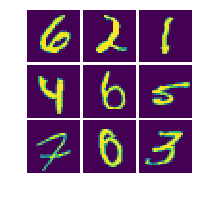

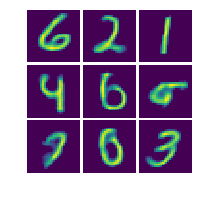

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:30 end epoch 119/300: average loss = 0.033135446694888805 (=0.019961+0.013174)

2018-05-07 22:44:30 start epoch 120/300, with learning rate = 0.0000903450
2018-05-07 22:44:30 iteration 1/859: current training loss = 0.033345 (=0.019998+0.013348)
2018-05-07 22:44:31 iteration 100/859: current training loss = 0.032525 (=0.019129+0.013396)
2018-05-07 22:44:31 iteration 200/859: current training loss = 0.031378 (=0.018581+0.012798)
2018-05-07 22:44:32 iteration 300/859: current training loss = 0.033392 (=0.020192+0.013200)
2018-05-07 22:44:33 iteration 400/859: current training loss = 0.036416 (=0.022786+0.013629)
2018-05-07 22:44:33 iteration 500/859: current training loss = 0.034063 (=0.020829+0.013234)
2018-05-07 22:44:34 iteration 600/859: current training loss = 0.033955 (=0.020603+0.013352)
2018-05-07 22:44:35 iteration 700/859: current training loss = 0.034247 (=0.021153+0.013095)
2018-05-07 22:44:36 iteration 800/859: cu

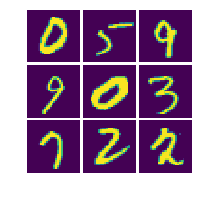

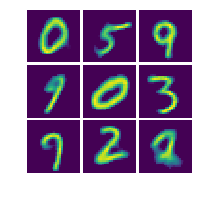

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:37 end epoch 120/300: average loss = 0.03315644879522923 (=0.019959+0.013197)

2018-05-07 22:44:37 start epoch 121/300, with learning rate = 0.0000885381
2018-05-07 22:44:37 iteration 1/859: current training loss = 0.030417 (=0.018013+0.012404)
2018-05-07 22:44:38 iteration 100/859: current training loss = 0.029945 (=0.017255+0.012690)
2018-05-07 22:44:39 iteration 200/859: current training loss = 0.032093 (=0.019299+0.012793)
2018-05-07 22:44:39 iteration 300/859: current training loss = 0.031696 (=0.018767+0.012929)
2018-05-07 22:44:40 iteration 400/859: current training loss = 0.032657 (=0.019821+0.012836)
2018-05-07 22:44:41 iteration 500/859: current training loss = 0.033235 (=0.020170+0.013064)
2018-05-07 22:44:42 iteration 600/859: current training loss = 0.033081 (=0.019905+0.013175)
2018-05-07 22:44:42 iteration 700/859: current training loss = 0.033313 (=0.019591+0.013722)
2018-05-07 22:44:43 iteration 800/859: cur

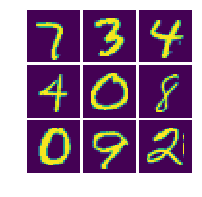

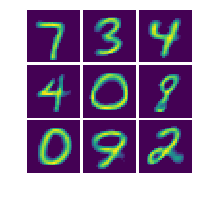

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:45 end epoch 121/300: average loss = 0.03311315124661459 (=0.019936+0.013177)

2018-05-07 22:44:45 start epoch 122/300, with learning rate = 0.0000867673
2018-05-07 22:44:45 iteration 1/859: current training loss = 0.033126 (=0.019983+0.013143)
2018-05-07 22:44:46 iteration 100/859: current training loss = 0.033217 (=0.020299+0.012918)
2018-05-07 22:44:46 iteration 200/859: current training loss = 0.032954 (=0.020091+0.012863)
2018-05-07 22:44:47 iteration 300/859: current training loss = 0.033772 (=0.020401+0.013370)
2018-05-07 22:44:48 iteration 400/859: current training loss = 0.033765 (=0.020240+0.013524)
2018-05-07 22:44:49 iteration 500/859: current training loss = 0.033676 (=0.020854+0.012822)
2018-05-07 22:44:49 iteration 600/859: current training loss = 0.033648 (=0.020978+0.012670)
2018-05-07 22:44:50 iteration 700/859: current training loss = 0.034163 (=0.020659+0.013504)
2018-05-07 22:44:51 iteration 800/859: cur

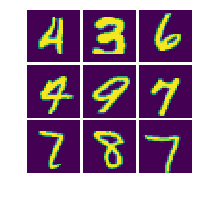

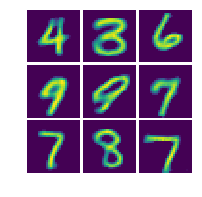

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:44:53 end epoch 122/300: average loss = 0.03310445470169481 (=0.019921+0.013184)

2018-05-07 22:44:53 start epoch 123/300, with learning rate = 0.0000850320
2018-05-07 22:44:53 iteration 1/859: current training loss = 0.032891 (=0.019873+0.013018)
2018-05-07 22:44:53 iteration 100/859: current training loss = 0.031503 (=0.018764+0.012739)
2018-05-07 22:44:54 iteration 200/859: current training loss = 0.034963 (=0.021418+0.013545)
2018-05-07 22:44:55 iteration 300/859: current training loss = 0.032277 (=0.019125+0.013152)
2018-05-07 22:44:56 iteration 400/859: current training loss = 0.029888 (=0.017564+0.012324)
2018-05-07 22:44:56 iteration 500/859: current training loss = 0.032673 (=0.019626+0.013047)
2018-05-07 22:44:57 iteration 600/859: current training loss = 0.029650 (=0.016726+0.012924)
2018-05-07 22:44:58 iteration 700/859: current training loss = 0.032413 (=0.019200+0.013213)
2018-05-07 22:44:58 iteration 800/859: cur

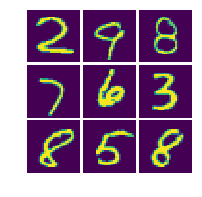

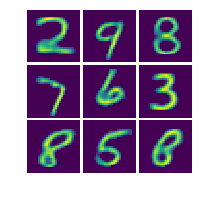

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:00 end epoch 123/300: average loss = 0.033063367648837313 (=0.019883+0.013181)

2018-05-07 22:45:00 start epoch 124/300, with learning rate = 0.0000833313
2018-05-07 22:45:00 iteration 1/859: current training loss = 0.031585 (=0.018699+0.012886)
2018-05-07 22:45:01 iteration 100/859: current training loss = 0.034214 (=0.020848+0.013367)
2018-05-07 22:45:02 iteration 200/859: current training loss = 0.034730 (=0.021173+0.013557)
2018-05-07 22:45:02 iteration 300/859: current training loss = 0.033601 (=0.020010+0.013591)
2018-05-07 22:45:03 iteration 400/859: current training loss = 0.031607 (=0.018819+0.012788)
2018-05-07 22:45:04 iteration 500/859: current training loss = 0.033086 (=0.019676+0.013410)
2018-05-07 22:45:04 iteration 600/859: current training loss = 0.035416 (=0.021760+0.013656)
2018-05-07 22:45:05 iteration 700/859: current training loss = 0.032322 (=0.019408+0.012914)
2018-05-07 22:45:06 iteration 800/859: cu

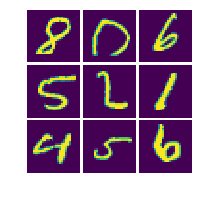

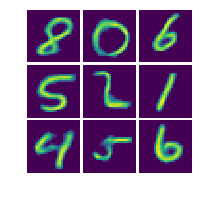

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:07 end epoch 124/300: average loss = 0.03308133285045971 (=0.019905+0.013176)

2018-05-07 22:45:07 start epoch 125/300, with learning rate = 0.0000816647
2018-05-07 22:45:07 iteration 1/859: current training loss = 0.033421 (=0.019987+0.013434)
2018-05-07 22:45:08 iteration 100/859: current training loss = 0.035288 (=0.021845+0.013443)
2018-05-07 22:45:09 iteration 200/859: current training loss = 0.035425 (=0.021551+0.013874)
2018-05-07 22:45:10 iteration 300/859: current training loss = 0.032487 (=0.019859+0.012628)
2018-05-07 22:45:10 iteration 400/859: current training loss = 0.033274 (=0.019992+0.013282)
2018-05-07 22:45:11 iteration 500/859: current training loss = 0.031663 (=0.018458+0.013206)
2018-05-07 22:45:12 iteration 600/859: current training loss = 0.033198 (=0.019820+0.013378)
2018-05-07 22:45:13 iteration 700/859: current training loss = 0.033788 (=0.020652+0.013136)
2018-05-07 22:45:13 iteration 800/859: cur

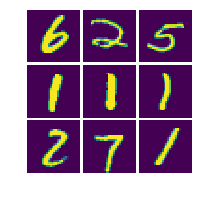

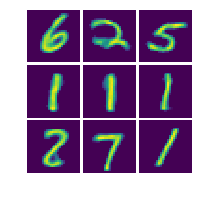

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:15 end epoch 125/300: average loss = 0.03306580689866898 (=0.019901+0.013165)

2018-05-07 22:45:15 start epoch 126/300, with learning rate = 0.0000800314
2018-05-07 22:45:15 iteration 1/859: current training loss = 0.031972 (=0.018952+0.013020)
2018-05-07 22:45:16 iteration 100/859: current training loss = 0.030088 (=0.017575+0.012513)
2018-05-07 22:45:16 iteration 200/859: current training loss = 0.030911 (=0.018275+0.012635)
2018-05-07 22:45:17 iteration 300/859: current training loss = 0.031407 (=0.018563+0.012844)
2018-05-07 22:45:18 iteration 400/859: current training loss = 0.034313 (=0.020636+0.013677)
2018-05-07 22:45:18 iteration 500/859: current training loss = 0.031579 (=0.018401+0.013178)
2018-05-07 22:45:19 iteration 600/859: current training loss = 0.033564 (=0.020280+0.013283)
2018-05-07 22:45:20 iteration 700/859: current training loss = 0.034181 (=0.021295+0.012887)
2018-05-07 22:45:21 iteration 800/859: cur

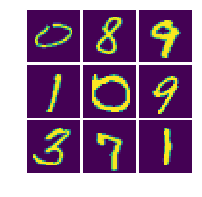

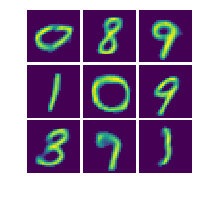

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:22 end epoch 126/300: average loss = 0.0330900997573963 (=0.019897+0.013193)

2018-05-07 22:45:22 start epoch 127/300, with learning rate = 0.0000784308
2018-05-07 22:45:23 iteration 1/859: current training loss = 0.031429 (=0.018831+0.012598)
2018-05-07 22:45:23 iteration 100/859: current training loss = 0.032147 (=0.019352+0.012796)
2018-05-07 22:45:24 iteration 200/859: current training loss = 0.033321 (=0.020068+0.013253)
2018-05-07 22:45:25 iteration 300/859: current training loss = 0.031630 (=0.018811+0.012820)
2018-05-07 22:45:26 iteration 400/859: current training loss = 0.031467 (=0.018926+0.012541)
2018-05-07 22:45:26 iteration 500/859: current training loss = 0.033378 (=0.020706+0.012672)
2018-05-07 22:45:27 iteration 600/859: current training loss = 0.032282 (=0.019239+0.013043)
2018-05-07 22:45:28 iteration 700/859: current training loss = 0.034889 (=0.021326+0.013564)
2018-05-07 22:45:28 iteration 800/859: curr

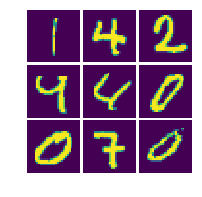

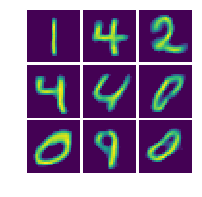

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:30 end epoch 127/300: average loss = 0.033082894584092463 (=0.019891+0.013192)

2018-05-07 22:45:30 start epoch 128/300, with learning rate = 0.0000768622
2018-05-07 22:45:30 iteration 1/859: current training loss = 0.032557 (=0.019240+0.013316)
2018-05-07 22:45:31 iteration 100/859: current training loss = 0.033681 (=0.019974+0.013708)
2018-05-07 22:45:31 iteration 200/859: current training loss = 0.033662 (=0.020170+0.013492)
2018-05-07 22:45:32 iteration 300/859: current training loss = 0.032379 (=0.019558+0.012821)
2018-05-07 22:45:33 iteration 400/859: current training loss = 0.035638 (=0.022233+0.013405)
2018-05-07 22:45:34 iteration 500/859: current training loss = 0.033898 (=0.020172+0.013726)
2018-05-07 22:45:34 iteration 600/859: current training loss = 0.033289 (=0.020074+0.013215)
2018-05-07 22:45:35 iteration 700/859: current training loss = 0.035511 (=0.021783+0.013729)
2018-05-07 22:45:36 iteration 800/859: cu

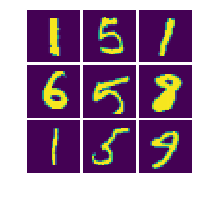

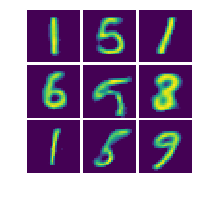

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:37 end epoch 128/300: average loss = 0.03298987912033642 (=0.019813+0.013177)

2018-05-07 22:45:37 start epoch 129/300, with learning rate = 0.0000753249
2018-05-07 22:45:37 iteration 1/859: current training loss = 0.035879 (=0.022735+0.013144)
2018-05-07 22:45:38 iteration 100/859: current training loss = 0.035402 (=0.021399+0.014003)
2018-05-07 22:45:39 iteration 200/859: current training loss = 0.030837 (=0.018002+0.012835)
2018-05-07 22:45:40 iteration 300/859: current training loss = 0.033160 (=0.019820+0.013340)
2018-05-07 22:45:40 iteration 400/859: current training loss = 0.033161 (=0.019525+0.013636)
2018-05-07 22:45:41 iteration 500/859: current training loss = 0.032067 (=0.019429+0.012637)
2018-05-07 22:45:42 iteration 600/859: current training loss = 0.030350 (=0.017805+0.012545)
2018-05-07 22:45:43 iteration 700/859: current training loss = 0.034893 (=0.021323+0.013570)
2018-05-07 22:45:43 iteration 800/859: cur

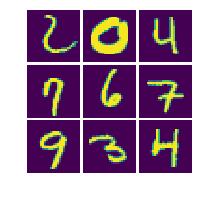

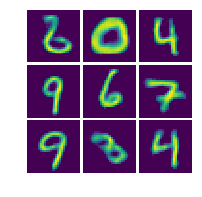

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:45 end epoch 129/300: average loss = 0.03305001647511933 (=0.019872+0.013178)

2018-05-07 22:45:45 start epoch 130/300, with learning rate = 0.0000738184
2018-05-07 22:45:45 iteration 1/859: current training loss = 0.033220 (=0.020220+0.013000)
2018-05-07 22:45:46 iteration 100/859: current training loss = 0.032812 (=0.020120+0.012692)
2018-05-07 22:45:46 iteration 200/859: current training loss = 0.033290 (=0.020413+0.012877)
2018-05-07 22:45:47 iteration 300/859: current training loss = 0.032450 (=0.019509+0.012941)
2018-05-07 22:45:48 iteration 400/859: current training loss = 0.033259 (=0.020075+0.013184)
2018-05-07 22:45:48 iteration 500/859: current training loss = 0.032854 (=0.019244+0.013610)
2018-05-07 22:45:49 iteration 600/859: current training loss = 0.033590 (=0.020244+0.013346)
2018-05-07 22:45:50 iteration 700/859: current training loss = 0.033086 (=0.020157+0.012929)
2018-05-07 22:45:50 iteration 800/859: cur

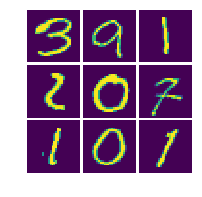

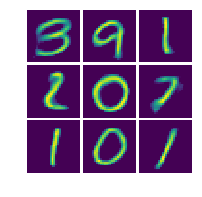

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:52 end epoch 130/300: average loss = 0.033015604893112074 (=0.019829+0.013186)

2018-05-07 22:45:52 start epoch 131/300, with learning rate = 0.0000723421
2018-05-07 22:45:52 iteration 1/859: current training loss = 0.033969 (=0.020785+0.013184)
2018-05-07 22:45:53 iteration 100/859: current training loss = 0.034524 (=0.021125+0.013399)
2018-05-07 22:45:53 iteration 200/859: current training loss = 0.033718 (=0.020110+0.013608)
2018-05-07 22:45:54 iteration 300/859: current training loss = 0.032418 (=0.019606+0.012812)
2018-05-07 22:45:55 iteration 400/859: current training loss = 0.029858 (=0.017403+0.012455)
2018-05-07 22:45:56 iteration 500/859: current training loss = 0.035789 (=0.021756+0.014033)
2018-05-07 22:45:56 iteration 600/859: current training loss = 0.031747 (=0.018758+0.012990)
2018-05-07 22:45:57 iteration 700/859: current training loss = 0.036638 (=0.022633+0.014005)
2018-05-07 22:45:58 iteration 800/859: cu

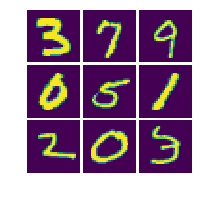

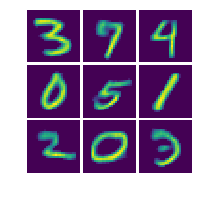

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:45:59 end epoch 131/300: average loss = 0.03301716574637937 (=0.019846+0.013171)

2018-05-07 22:45:59 start epoch 132/300, with learning rate = 0.0000708952
2018-05-07 22:45:59 iteration 1/859: current training loss = 0.032963 (=0.019632+0.013331)
2018-05-07 22:46:00 iteration 100/859: current training loss = 0.030888 (=0.017901+0.012987)
2018-05-07 22:46:01 iteration 200/859: current training loss = 0.033933 (=0.020797+0.013136)
2018-05-07 22:46:01 iteration 300/859: current training loss = 0.033614 (=0.020175+0.013439)
2018-05-07 22:46:02 iteration 400/859: current training loss = 0.037076 (=0.023024+0.014052)
2018-05-07 22:46:03 iteration 500/859: current training loss = 0.033727 (=0.020547+0.013180)
2018-05-07 22:46:04 iteration 600/859: current training loss = 0.031933 (=0.019037+0.012896)
2018-05-07 22:46:04 iteration 700/859: current training loss = 0.032593 (=0.019815+0.012777)
2018-05-07 22:46:05 iteration 800/859: cur

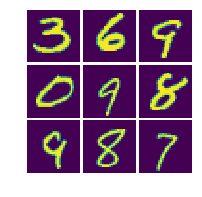

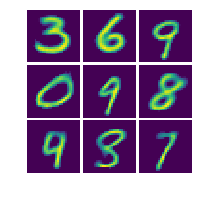

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:07 end epoch 132/300: average loss = 0.03301736900671814 (=0.019834+0.013184)

2018-05-07 22:46:07 start epoch 133/300, with learning rate = 0.0000694773
2018-05-07 22:46:07 iteration 1/859: current training loss = 0.032973 (=0.019861+0.013113)
2018-05-07 22:46:07 iteration 100/859: current training loss = 0.031819 (=0.018337+0.013482)
2018-05-07 22:46:08 iteration 200/859: current training loss = 0.033925 (=0.020921+0.013004)
2018-05-07 22:46:09 iteration 300/859: current training loss = 0.032563 (=0.019465+0.013098)
2018-05-07 22:46:10 iteration 400/859: current training loss = 0.037093 (=0.022793+0.014300)
2018-05-07 22:46:10 iteration 500/859: current training loss = 0.032662 (=0.019595+0.013067)
2018-05-07 22:46:11 iteration 600/859: current training loss = 0.033072 (=0.020048+0.013024)
2018-05-07 22:46:12 iteration 700/859: current training loss = 0.029334 (=0.016556+0.012778)
2018-05-07 22:46:12 iteration 800/859: cur

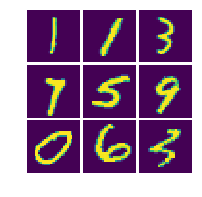

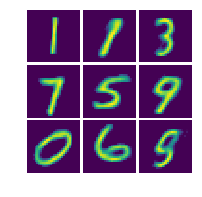

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:14 end epoch 133/300: average loss = 0.03301843932512129 (=0.019813+0.013205)

2018-05-07 22:46:14 start epoch 134/300, with learning rate = 0.0000680878
2018-05-07 22:46:14 iteration 1/859: current training loss = 0.033422 (=0.019992+0.013430)
2018-05-07 22:46:15 iteration 100/859: current training loss = 0.034578 (=0.020980+0.013598)
2018-05-07 22:46:15 iteration 200/859: current training loss = 0.033570 (=0.020406+0.013165)
2018-05-07 22:46:16 iteration 300/859: current training loss = 0.032454 (=0.019374+0.013080)
2018-05-07 22:46:17 iteration 400/859: current training loss = 0.032882 (=0.019633+0.013249)
2018-05-07 22:46:18 iteration 500/859: current training loss = 0.030950 (=0.018446+0.012504)
2018-05-07 22:46:18 iteration 600/859: current training loss = 0.033393 (=0.020144+0.013249)
2018-05-07 22:46:19 iteration 700/859: current training loss = 0.032711 (=0.019523+0.013188)
2018-05-07 22:46:20 iteration 800/859: cur

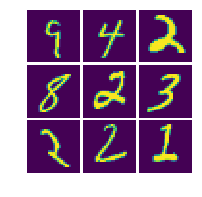

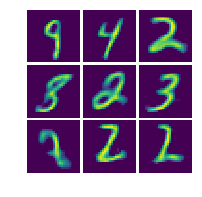

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:21 end epoch 134/300: average loss = 0.033003925212482216 (=0.019824+0.013180)

2018-05-07 22:46:21 start epoch 135/300, with learning rate = 0.0000667260
2018-05-07 22:46:21 iteration 1/859: current training loss = 0.033432 (=0.019896+0.013536)
2018-05-07 22:46:22 iteration 100/859: current training loss = 0.033690 (=0.020644+0.013046)
2018-05-07 22:46:23 iteration 200/859: current training loss = 0.031727 (=0.018812+0.012915)
2018-05-07 22:46:23 iteration 300/859: current training loss = 0.032633 (=0.019165+0.013468)
2018-05-07 22:46:24 iteration 400/859: current training loss = 0.032529 (=0.020085+0.012444)
2018-05-07 22:46:25 iteration 500/859: current training loss = 0.034691 (=0.021107+0.013585)
2018-05-07 22:46:26 iteration 600/859: current training loss = 0.033193 (=0.019980+0.013212)
2018-05-07 22:46:26 iteration 700/859: current training loss = 0.031890 (=0.018840+0.013050)
2018-05-07 22:46:27 iteration 800/859: cu

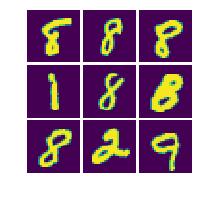

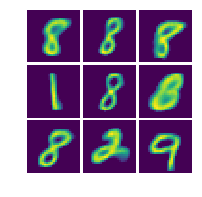

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:29 end epoch 135/300: average loss = 0.03297325805462767 (=0.019782+0.013191)

2018-05-07 22:46:29 start epoch 136/300, with learning rate = 0.0000653915
2018-05-07 22:46:29 iteration 1/859: current training loss = 0.033419 (=0.020466+0.012953)
2018-05-07 22:46:29 iteration 100/859: current training loss = 0.035628 (=0.021602+0.014026)
2018-05-07 22:46:30 iteration 200/859: current training loss = 0.032815 (=0.019748+0.013067)
2018-05-07 22:46:31 iteration 300/859: current training loss = 0.035098 (=0.021414+0.013683)
2018-05-07 22:46:32 iteration 400/859: current training loss = 0.032742 (=0.019632+0.013109)
2018-05-07 22:46:33 iteration 500/859: current training loss = 0.033766 (=0.020308+0.013458)
2018-05-07 22:46:33 iteration 600/859: current training loss = 0.033296 (=0.020203+0.013093)
2018-05-07 22:46:34 iteration 700/859: current training loss = 0.031654 (=0.019080+0.012574)
2018-05-07 22:46:35 iteration 800/859: cur

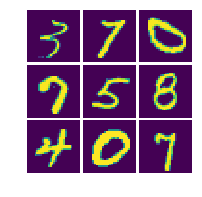

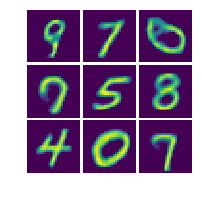

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:36 end epoch 136/300: average loss = 0.032999163057668104 (=0.019810+0.013189)

2018-05-07 22:46:36 start epoch 137/300, with learning rate = 0.0000640837
2018-05-07 22:46:36 iteration 1/859: current training loss = 0.031911 (=0.018496+0.013415)
2018-05-07 22:46:37 iteration 100/859: current training loss = 0.032754 (=0.020130+0.012624)
2018-05-07 22:46:38 iteration 200/859: current training loss = 0.032027 (=0.019125+0.012902)
2018-05-07 22:46:38 iteration 300/859: current training loss = 0.032781 (=0.019944+0.012837)
2018-05-07 22:46:39 iteration 400/859: current training loss = 0.033103 (=0.019771+0.013332)
2018-05-07 22:46:40 iteration 500/859: current training loss = 0.031059 (=0.018395+0.012664)
2018-05-07 22:46:41 iteration 600/859: current training loss = 0.031271 (=0.018111+0.013160)
2018-05-07 22:46:41 iteration 700/859: current training loss = 0.032234 (=0.019415+0.012819)
2018-05-07 22:46:42 iteration 800/859: cu

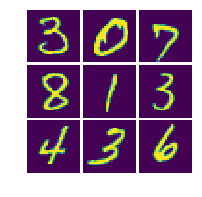

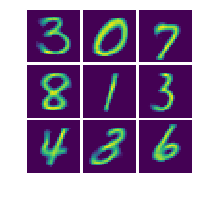

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:44 end epoch 137/300: average loss = 0.032964909531618444 (=0.019796+0.013169)

2018-05-07 22:46:44 start epoch 138/300, with learning rate = 0.0000628020
2018-05-07 22:46:44 iteration 1/859: current training loss = 0.032482 (=0.019521+0.012961)
2018-05-07 22:46:45 iteration 100/859: current training loss = 0.034478 (=0.021062+0.013416)
2018-05-07 22:46:45 iteration 200/859: current training loss = 0.032181 (=0.019234+0.012947)
2018-05-07 22:46:46 iteration 300/859: current training loss = 0.032481 (=0.019665+0.012816)
2018-05-07 22:46:47 iteration 400/859: current training loss = 0.034278 (=0.020726+0.013552)
2018-05-07 22:46:48 iteration 500/859: current training loss = 0.032154 (=0.019333+0.012821)
2018-05-07 22:46:48 iteration 600/859: current training loss = 0.035293 (=0.021627+0.013666)
2018-05-07 22:46:49 iteration 700/859: current training loss = 0.032023 (=0.019477+0.012546)
2018-05-07 22:46:50 iteration 800/859: cu

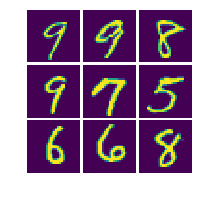

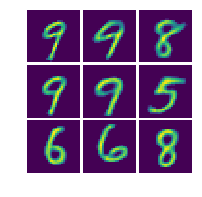

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:51 end epoch 138/300: average loss = 0.03295220910193132 (=0.019790+0.013162)

2018-05-07 22:46:51 start epoch 139/300, with learning rate = 0.0000615460
2018-05-07 22:46:51 iteration 1/859: current training loss = 0.034599 (=0.020916+0.013682)
2018-05-07 22:46:52 iteration 100/859: current training loss = 0.034315 (=0.020855+0.013460)
2018-05-07 22:46:53 iteration 200/859: current training loss = 0.032066 (=0.018910+0.013156)
2018-05-07 22:46:54 iteration 300/859: current training loss = 0.034165 (=0.020717+0.013449)
2018-05-07 22:46:55 iteration 400/859: current training loss = 0.030516 (=0.017368+0.013148)
2018-05-07 22:46:55 iteration 500/859: current training loss = 0.032380 (=0.019234+0.013145)
2018-05-07 22:46:56 iteration 600/859: current training loss = 0.033096 (=0.020078+0.013018)
2018-05-07 22:46:57 iteration 700/859: current training loss = 0.032998 (=0.019729+0.013269)
2018-05-07 22:46:58 iteration 800/859: cur

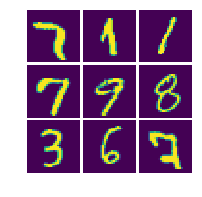

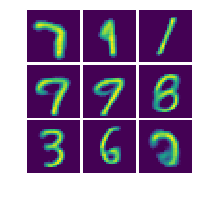

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:46:59 end epoch 139/300: average loss = 0.03295861571437405 (=0.019783+0.013176)

2018-05-07 22:46:59 start epoch 140/300, with learning rate = 0.0000603151
2018-05-07 22:46:59 iteration 1/859: current training loss = 0.036109 (=0.022526+0.013583)
2018-05-07 22:47:00 iteration 100/859: current training loss = 0.028726 (=0.016548+0.012178)
2018-05-07 22:47:01 iteration 200/859: current training loss = 0.035584 (=0.021743+0.013840)
2018-05-07 22:47:01 iteration 300/859: current training loss = 0.032309 (=0.019244+0.013065)
2018-05-07 22:47:02 iteration 400/859: current training loss = 0.034492 (=0.021019+0.013474)
2018-05-07 22:47:03 iteration 500/859: current training loss = 0.031561 (=0.018309+0.013251)
2018-05-07 22:47:03 iteration 600/859: current training loss = 0.035178 (=0.021413+0.013765)
2018-05-07 22:47:04 iteration 700/859: current training loss = 0.032981 (=0.019731+0.013250)
2018-05-07 22:47:05 iteration 800/859: cur

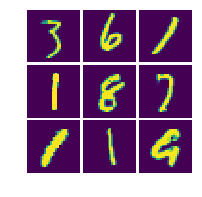

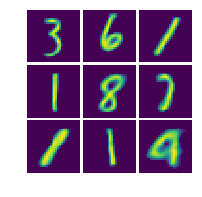

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:06 end epoch 140/300: average loss = 0.03293980270780285 (=0.019766+0.013174)

2018-05-07 22:47:06 start epoch 141/300, with learning rate = 0.0000591088
2018-05-07 22:47:06 iteration 1/859: current training loss = 0.032390 (=0.019073+0.013318)
2018-05-07 22:47:07 iteration 100/859: current training loss = 0.035704 (=0.021815+0.013889)
2018-05-07 22:47:08 iteration 200/859: current training loss = 0.029742 (=0.017670+0.012071)
2018-05-07 22:47:09 iteration 300/859: current training loss = 0.033771 (=0.020785+0.012986)
2018-05-07 22:47:09 iteration 400/859: current training loss = 0.035492 (=0.021435+0.014057)
2018-05-07 22:47:10 iteration 500/859: current training loss = 0.032248 (=0.019244+0.013005)
2018-05-07 22:47:11 iteration 600/859: current training loss = 0.032386 (=0.019690+0.012696)
2018-05-07 22:47:12 iteration 700/859: current training loss = 0.036369 (=0.022150+0.014218)
2018-05-07 22:47:12 iteration 800/859: cur

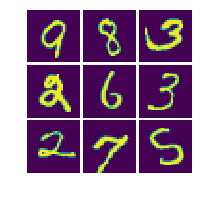

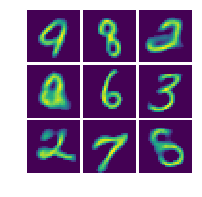

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:14 end epoch 141/300: average loss = 0.03294662585236974 (=0.019767+0.013179)

2018-05-07 22:47:14 start epoch 142/300, with learning rate = 0.0000579266
2018-05-07 22:47:14 iteration 1/859: current training loss = 0.031408 (=0.018519+0.012889)
2018-05-07 22:47:15 iteration 100/859: current training loss = 0.032945 (=0.019589+0.013356)
2018-05-07 22:47:15 iteration 200/859: current training loss = 0.033927 (=0.020138+0.013790)
2018-05-07 22:47:16 iteration 300/859: current training loss = 0.032632 (=0.019230+0.013401)
2018-05-07 22:47:17 iteration 400/859: current training loss = 0.032997 (=0.019898+0.013100)
2018-05-07 22:47:18 iteration 500/859: current training loss = 0.034270 (=0.020691+0.013579)
2018-05-07 22:47:18 iteration 600/859: current training loss = 0.032219 (=0.019504+0.012715)
2018-05-07 22:47:19 iteration 700/859: current training loss = 0.035097 (=0.021478+0.013619)
2018-05-07 22:47:20 iteration 800/859: cur

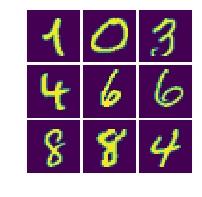

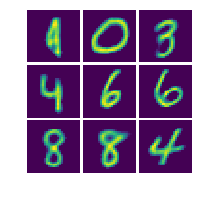

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:21 end epoch 142/300: average loss = 0.0329284478863647 (=0.019770+0.013159)

2018-05-07 22:47:21 start epoch 143/300, with learning rate = 0.0000567680
2018-05-07 22:47:21 iteration 1/859: current training loss = 0.031542 (=0.018825+0.012717)
2018-05-07 22:47:22 iteration 100/859: current training loss = 0.033987 (=0.020644+0.013342)
2018-05-07 22:47:23 iteration 200/859: current training loss = 0.034159 (=0.020309+0.013850)
2018-05-07 22:47:24 iteration 300/859: current training loss = 0.035244 (=0.021408+0.013836)
2018-05-07 22:47:24 iteration 400/859: current training loss = 0.034684 (=0.021205+0.013480)
2018-05-07 22:47:25 iteration 500/859: current training loss = 0.035191 (=0.020998+0.014193)
2018-05-07 22:47:26 iteration 600/859: current training loss = 0.032319 (=0.019393+0.012926)
2018-05-07 22:47:27 iteration 700/859: current training loss = 0.035651 (=0.022125+0.013526)
2018-05-07 22:47:27 iteration 800/859: curr

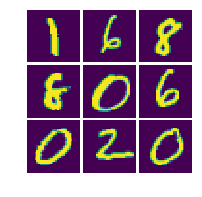

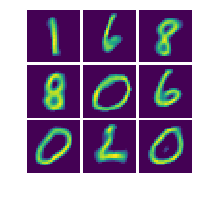

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:29 end epoch 143/300: average loss = 0.0329548193790166 (=0.019777+0.013178)

2018-05-07 22:47:29 start epoch 144/300, with learning rate = 0.0000556327
2018-05-07 22:47:29 iteration 1/859: current training loss = 0.032484 (=0.019339+0.013145)
2018-05-07 22:47:30 iteration 100/859: current training loss = 0.032355 (=0.019536+0.012819)
2018-05-07 22:47:30 iteration 200/859: current training loss = 0.034328 (=0.020874+0.013454)
2018-05-07 22:47:31 iteration 300/859: current training loss = 0.032590 (=0.019215+0.013375)
2018-05-07 22:47:32 iteration 400/859: current training loss = 0.031165 (=0.018362+0.012803)
2018-05-07 22:47:32 iteration 500/859: current training loss = 0.033936 (=0.020271+0.013664)
2018-05-07 22:47:33 iteration 600/859: current training loss = 0.035668 (=0.022199+0.013468)
2018-05-07 22:47:34 iteration 700/859: current training loss = 0.033132 (=0.020000+0.013133)
2018-05-07 22:47:35 iteration 800/859: curr

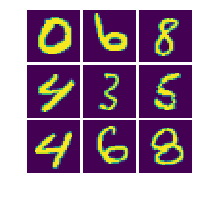

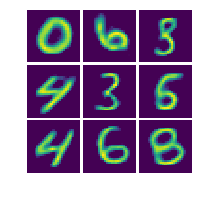

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:36 end epoch 144/300: average loss = 0.032934459899926216 (=0.019760+0.013174)

2018-05-07 22:47:36 start epoch 145/300, with learning rate = 0.0000545200
2018-05-07 22:47:36 iteration 1/859: current training loss = 0.033273 (=0.019830+0.013443)
2018-05-07 22:47:37 iteration 100/859: current training loss = 0.032638 (=0.019296+0.013343)
2018-05-07 22:47:38 iteration 200/859: current training loss = 0.033354 (=0.020264+0.013091)
2018-05-07 22:47:39 iteration 300/859: current training loss = 0.034249 (=0.020936+0.013313)
2018-05-07 22:47:39 iteration 400/859: current training loss = 0.029737 (=0.017924+0.011813)
2018-05-07 22:47:40 iteration 500/859: current training loss = 0.031799 (=0.018418+0.013381)
2018-05-07 22:47:41 iteration 600/859: current training loss = 0.033141 (=0.020139+0.013002)
2018-05-07 22:47:42 iteration 700/859: current training loss = 0.033000 (=0.019788+0.013212)
2018-05-07 22:47:42 iteration 800/859: cu

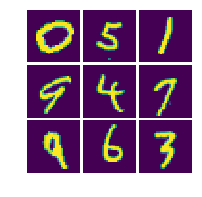

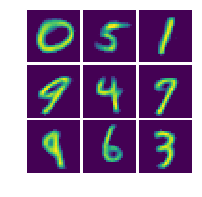

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:44 end epoch 145/300: average loss = 0.032914641975697316 (=0.019739+0.013176)

2018-05-07 22:47:44 start epoch 146/300, with learning rate = 0.0000534296
2018-05-07 22:47:44 iteration 1/859: current training loss = 0.033733 (=0.020671+0.013062)
2018-05-07 22:47:45 iteration 100/859: current training loss = 0.034573 (=0.020638+0.013935)
2018-05-07 22:47:46 iteration 200/859: current training loss = 0.033270 (=0.020007+0.013263)
2018-05-07 22:47:46 iteration 300/859: current training loss = 0.032257 (=0.019314+0.012942)
2018-05-07 22:47:47 iteration 400/859: current training loss = 0.032932 (=0.019787+0.013146)
2018-05-07 22:47:48 iteration 500/859: current training loss = 0.034101 (=0.020393+0.013708)
2018-05-07 22:47:49 iteration 600/859: current training loss = 0.031196 (=0.018251+0.012945)
2018-05-07 22:47:49 iteration 700/859: current training loss = 0.033089 (=0.019767+0.013323)
2018-05-07 22:47:50 iteration 800/859: cu

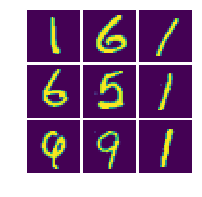

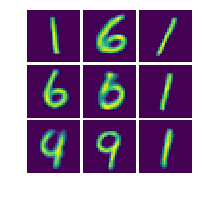

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:52 end epoch 146/300: average loss = 0.03287296380513761 (=0.019688+0.013185)

2018-05-07 22:47:52 start epoch 147/300, with learning rate = 0.0000523610
2018-05-07 22:47:52 iteration 1/859: current training loss = 0.030114 (=0.017838+0.012276)
2018-05-07 22:47:52 iteration 100/859: current training loss = 0.033563 (=0.019908+0.013655)
2018-05-07 22:47:53 iteration 200/859: current training loss = 0.034269 (=0.021027+0.013242)
2018-05-07 22:47:54 iteration 300/859: current training loss = 0.029975 (=0.017249+0.012726)
2018-05-07 22:47:55 iteration 400/859: current training loss = 0.032295 (=0.018913+0.013382)
2018-05-07 22:47:56 iteration 500/859: current training loss = 0.033562 (=0.019878+0.013684)
2018-05-07 22:47:56 iteration 600/859: current training loss = 0.032846 (=0.019895+0.012951)
2018-05-07 22:47:57 iteration 700/859: current training loss = 0.033685 (=0.020072+0.013613)
2018-05-07 22:47:58 iteration 800/859: cur

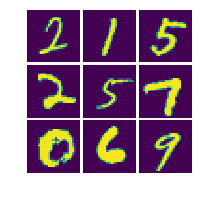

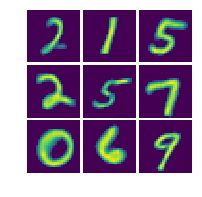

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:47:59 end epoch 147/300: average loss = 0.0329397263263414 (=0.019753+0.013187)

2018-05-07 22:47:59 start epoch 148/300, with learning rate = 0.0000513138
2018-05-07 22:47:59 iteration 1/859: current training loss = 0.036850 (=0.022541+0.014309)
2018-05-07 22:48:00 iteration 100/859: current training loss = 0.032193 (=0.019344+0.012849)
2018-05-07 22:48:01 iteration 200/859: current training loss = 0.032010 (=0.018706+0.013304)
2018-05-07 22:48:02 iteration 300/859: current training loss = 0.033245 (=0.019627+0.013618)
2018-05-07 22:48:02 iteration 400/859: current training loss = 0.030599 (=0.018198+0.012401)
2018-05-07 22:48:03 iteration 500/859: current training loss = 0.031307 (=0.018738+0.012568)
2018-05-07 22:48:04 iteration 600/859: current training loss = 0.033178 (=0.020144+0.013034)
2018-05-07 22:48:05 iteration 700/859: current training loss = 0.033074 (=0.019983+0.013090)
2018-05-07 22:48:05 iteration 800/859: curr

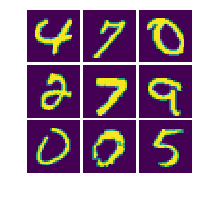

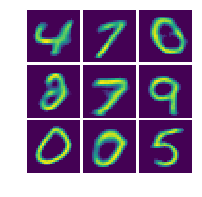

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:07 end epoch 148/300: average loss = 0.03289052433354891 (=0.019726+0.013164)

2018-05-07 22:48:07 start epoch 149/300, with learning rate = 0.0000502876
2018-05-07 22:48:07 iteration 1/859: current training loss = 0.033668 (=0.020153+0.013515)
2018-05-07 22:48:08 iteration 100/859: current training loss = 0.031648 (=0.018606+0.013042)
2018-05-07 22:48:08 iteration 200/859: current training loss = 0.032796 (=0.019377+0.013420)
2018-05-07 22:48:09 iteration 300/859: current training loss = 0.032607 (=0.019482+0.013124)
2018-05-07 22:48:10 iteration 400/859: current training loss = 0.031762 (=0.018954+0.012807)
2018-05-07 22:48:11 iteration 500/859: current training loss = 0.032192 (=0.018971+0.013221)
2018-05-07 22:48:11 iteration 600/859: current training loss = 0.032242 (=0.019613+0.012629)
2018-05-07 22:48:12 iteration 700/859: current training loss = 0.033243 (=0.020498+0.012745)
2018-05-07 22:48:13 iteration 800/859: cur

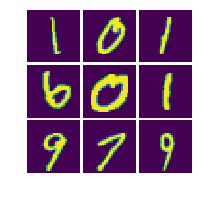

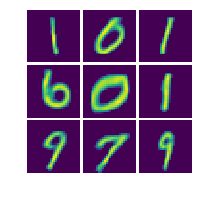

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:15 end epoch 149/300: average loss = 0.03290006626349667 (=0.019730+0.013170)

2018-05-07 22:48:15 start epoch 150/300, with learning rate = 0.0000492818
2018-05-07 22:48:15 iteration 1/859: current training loss = 0.034855 (=0.021552+0.013303)
2018-05-07 22:48:16 iteration 100/859: current training loss = 0.033371 (=0.019994+0.013377)
2018-05-07 22:48:16 iteration 200/859: current training loss = 0.032464 (=0.019966+0.012498)
2018-05-07 22:48:17 iteration 300/859: current training loss = 0.030918 (=0.018224+0.012694)
2018-05-07 22:48:18 iteration 400/859: current training loss = 0.032871 (=0.019525+0.013346)
2018-05-07 22:48:18 iteration 500/859: current training loss = 0.031017 (=0.018558+0.012460)
2018-05-07 22:48:19 iteration 600/859: current training loss = 0.031694 (=0.018906+0.012788)
2018-05-07 22:48:20 iteration 700/859: current training loss = 0.033455 (=0.020068+0.013387)
2018-05-07 22:48:21 iteration 800/859: cur

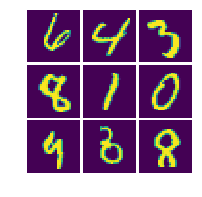

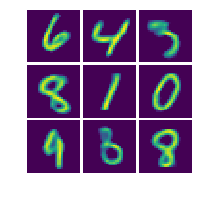

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:22 end epoch 150/300: average loss = 0.03287660436351308 (=0.019691+0.013185)

2018-05-07 22:48:22 start epoch 151/300, with learning rate = 0.0000482962
2018-05-07 22:48:22 iteration 1/859: current training loss = 0.031940 (=0.018971+0.012969)
2018-05-07 22:48:23 iteration 100/859: current training loss = 0.033078 (=0.019887+0.013191)
2018-05-07 22:48:24 iteration 200/859: current training loss = 0.031146 (=0.018703+0.012443)
2018-05-07 22:48:24 iteration 300/859: current training loss = 0.033882 (=0.020271+0.013611)
2018-05-07 22:48:25 iteration 400/859: current training loss = 0.033083 (=0.019695+0.013388)
2018-05-07 22:48:26 iteration 500/859: current training loss = 0.030982 (=0.018357+0.012625)
2018-05-07 22:48:27 iteration 600/859: current training loss = 0.031583 (=0.018757+0.012825)
2018-05-07 22:48:27 iteration 700/859: current training loss = 0.033871 (=0.020218+0.013653)
2018-05-07 22:48:28 iteration 800/859: cur

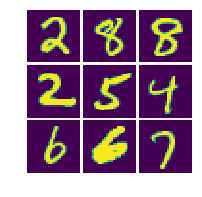

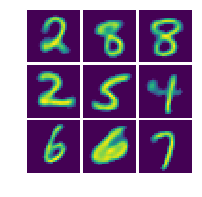

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:30 end epoch 151/300: average loss = 0.03287659500908796 (=0.019697+0.013180)

2018-05-07 22:48:30 start epoch 152/300, with learning rate = 0.0000473302
2018-05-07 22:48:30 iteration 1/859: current training loss = 0.035414 (=0.021269+0.014146)
2018-05-07 22:48:31 iteration 100/859: current training loss = 0.032996 (=0.020030+0.012966)
2018-05-07 22:48:32 iteration 200/859: current training loss = 0.032745 (=0.019093+0.013652)
2018-05-07 22:48:32 iteration 300/859: current training loss = 0.031297 (=0.018082+0.013215)
2018-05-07 22:48:33 iteration 400/859: current training loss = 0.031900 (=0.019158+0.012742)
2018-05-07 22:48:34 iteration 500/859: current training loss = 0.033198 (=0.019984+0.013214)
2018-05-07 22:48:34 iteration 600/859: current training loss = 0.032480 (=0.019690+0.012790)
2018-05-07 22:48:35 iteration 700/859: current training loss = 0.033374 (=0.020155+0.013219)
2018-05-07 22:48:36 iteration 800/859: cur

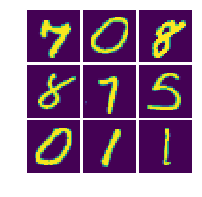

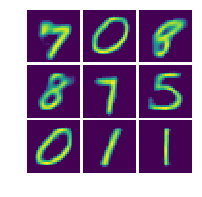

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:37 end epoch 152/300: average loss = 0.03289126744439633 (=0.019703+0.013188)

2018-05-07 22:48:37 start epoch 153/300, with learning rate = 0.0000463836
2018-05-07 22:48:37 iteration 1/859: current training loss = 0.031133 (=0.018657+0.012475)
2018-05-07 22:48:38 iteration 100/859: current training loss = 0.031823 (=0.018837+0.012986)
2018-05-07 22:48:39 iteration 200/859: current training loss = 0.033600 (=0.020024+0.013577)
2018-05-07 22:48:40 iteration 300/859: current training loss = 0.031817 (=0.018496+0.013321)
2018-05-07 22:48:40 iteration 400/859: current training loss = 0.034346 (=0.020760+0.013586)
2018-05-07 22:48:41 iteration 500/859: current training loss = 0.034015 (=0.020780+0.013235)
2018-05-07 22:48:42 iteration 600/859: current training loss = 0.034477 (=0.021132+0.013344)
2018-05-07 22:48:43 iteration 700/859: current training loss = 0.031565 (=0.018568+0.012996)
2018-05-07 22:48:43 iteration 800/859: cur

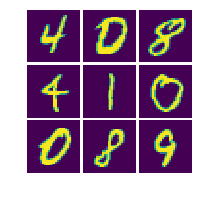

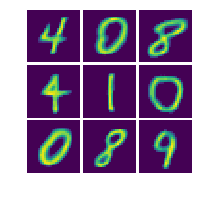

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:45 end epoch 153/300: average loss = 0.03284726740100678 (=0.019671+0.013176)

2018-05-07 22:48:45 start epoch 154/300, with learning rate = 0.0000454560
2018-05-07 22:48:45 iteration 1/859: current training loss = 0.032224 (=0.019449+0.012775)
2018-05-07 22:48:46 iteration 100/859: current training loss = 0.034539 (=0.020946+0.013592)
2018-05-07 22:48:46 iteration 200/859: current training loss = 0.032335 (=0.019245+0.013090)
2018-05-07 22:48:47 iteration 300/859: current training loss = 0.033352 (=0.019723+0.013629)
2018-05-07 22:48:48 iteration 400/859: current training loss = 0.033219 (=0.019806+0.013414)
2018-05-07 22:48:48 iteration 500/859: current training loss = 0.035459 (=0.021695+0.013764)
2018-05-07 22:48:49 iteration 600/859: current training loss = 0.028651 (=0.016641+0.012010)
2018-05-07 22:48:50 iteration 700/859: current training loss = 0.032647 (=0.019657+0.012990)
2018-05-07 22:48:51 iteration 800/859: cur

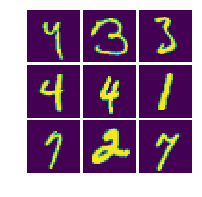

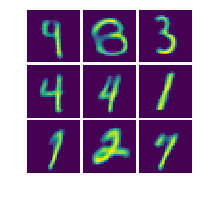

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:48:52 end epoch 154/300: average loss = 0.0328790261361388 (=0.019683+0.013196)

2018-05-07 22:48:52 start epoch 155/300, with learning rate = 0.0000445469
2018-05-07 22:48:52 iteration 1/859: current training loss = 0.033585 (=0.020134+0.013451)
2018-05-07 22:48:53 iteration 100/859: current training loss = 0.033696 (=0.020329+0.013368)
2018-05-07 22:48:54 iteration 200/859: current training loss = 0.031152 (=0.018480+0.012672)
2018-05-07 22:48:54 iteration 300/859: current training loss = 0.033370 (=0.020127+0.013243)
2018-05-07 22:48:55 iteration 400/859: current training loss = 0.031638 (=0.018193+0.013445)
2018-05-07 22:48:56 iteration 500/859: current training loss = 0.032883 (=0.019374+0.013509)
2018-05-07 22:48:57 iteration 600/859: current training loss = 0.036274 (=0.022291+0.013983)
2018-05-07 22:48:57 iteration 700/859: current training loss = 0.034479 (=0.021095+0.013385)
2018-05-07 22:48:58 iteration 800/859: curr

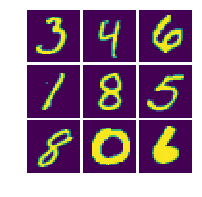

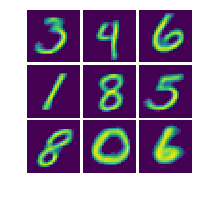

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:00 end epoch 155/300: average loss = 0.03286461650076235 (=0.019693+0.013172)

2018-05-07 22:49:00 start epoch 156/300, with learning rate = 0.0000436559
2018-05-07 22:49:00 iteration 1/859: current training loss = 0.031404 (=0.018723+0.012681)
2018-05-07 22:49:00 iteration 100/859: current training loss = 0.033190 (=0.020433+0.012757)
2018-05-07 22:49:01 iteration 200/859: current training loss = 0.032278 (=0.019638+0.012640)
2018-05-07 22:49:02 iteration 300/859: current training loss = 0.030586 (=0.017926+0.012660)
2018-05-07 22:49:03 iteration 400/859: current training loss = 0.033063 (=0.020226+0.012837)
2018-05-07 22:49:03 iteration 500/859: current training loss = 0.033167 (=0.019387+0.013780)
2018-05-07 22:49:04 iteration 600/859: current training loss = 0.032253 (=0.019246+0.013008)
2018-05-07 22:49:05 iteration 700/859: current training loss = 0.031412 (=0.018535+0.012877)
2018-05-07 22:49:05 iteration 800/859: cur

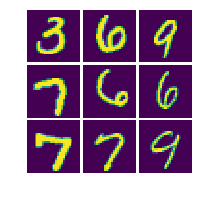

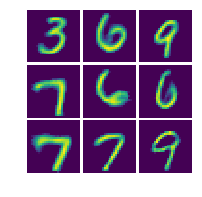

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:07 end epoch 156/300: average loss = 0.032836043244451114 (=0.019688+0.013148)

2018-05-07 22:49:07 start epoch 157/300, with learning rate = 0.0000427828
2018-05-07 22:49:07 iteration 1/859: current training loss = 0.034393 (=0.020733+0.013661)
2018-05-07 22:49:08 iteration 100/859: current training loss = 0.030847 (=0.018260+0.012587)
2018-05-07 22:49:09 iteration 200/859: current training loss = 0.033133 (=0.019605+0.013528)
2018-05-07 22:49:10 iteration 300/859: current training loss = 0.032940 (=0.019553+0.013387)
2018-05-07 22:49:10 iteration 400/859: current training loss = 0.033626 (=0.019917+0.013710)
2018-05-07 22:49:11 iteration 500/859: current training loss = 0.032151 (=0.019471+0.012681)
2018-05-07 22:49:12 iteration 600/859: current training loss = 0.035248 (=0.021747+0.013500)
2018-05-07 22:49:12 iteration 700/859: current training loss = 0.032355 (=0.019374+0.012981)
2018-05-07 22:49:13 iteration 800/859: cu

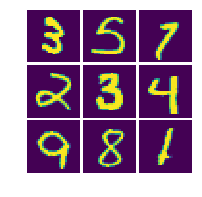

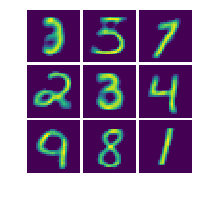

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:15 end epoch 157/300: average loss = 0.03282755861390595 (=0.019657+0.013170)

2018-05-07 22:49:15 start epoch 158/300, with learning rate = 0.0000419271
2018-05-07 22:49:15 iteration 1/859: current training loss = 0.033339 (=0.020414+0.012925)
2018-05-07 22:49:16 iteration 100/859: current training loss = 0.032704 (=0.019786+0.012918)
2018-05-07 22:49:16 iteration 200/859: current training loss = 0.033184 (=0.019773+0.013411)
2018-05-07 22:49:17 iteration 300/859: current training loss = 0.031553 (=0.018478+0.013075)
2018-05-07 22:49:18 iteration 400/859: current training loss = 0.032824 (=0.019266+0.013558)
2018-05-07 22:49:18 iteration 500/859: current training loss = 0.035264 (=0.021016+0.014248)
2018-05-07 22:49:19 iteration 600/859: current training loss = 0.032066 (=0.018998+0.013068)
2018-05-07 22:49:20 iteration 700/859: current training loss = 0.030438 (=0.018605+0.011832)
2018-05-07 22:49:21 iteration 800/859: cur

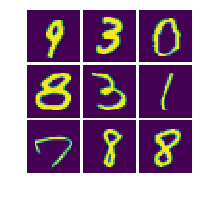

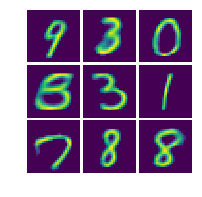

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:22 end epoch 158/300: average loss = 0.03288469094744037 (=0.019694+0.013190)

2018-05-07 22:49:22 start epoch 159/300, with learning rate = 0.0000410886
2018-05-07 22:49:22 iteration 1/859: current training loss = 0.030855 (=0.018485+0.012369)
2018-05-07 22:49:23 iteration 100/859: current training loss = 0.031011 (=0.018161+0.012850)
2018-05-07 22:49:24 iteration 200/859: current training loss = 0.031127 (=0.018171+0.012956)
2018-05-07 22:49:24 iteration 300/859: current training loss = 0.031266 (=0.018367+0.012899)
2018-05-07 22:49:25 iteration 400/859: current training loss = 0.031116 (=0.018330+0.012787)
2018-05-07 22:49:26 iteration 500/859: current training loss = 0.033561 (=0.020077+0.013485)
2018-05-07 22:49:27 iteration 600/859: current training loss = 0.036234 (=0.022131+0.014103)
2018-05-07 22:49:27 iteration 700/859: current training loss = 0.034565 (=0.020903+0.013662)
2018-05-07 22:49:28 iteration 800/859: cur

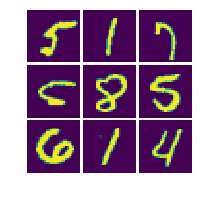

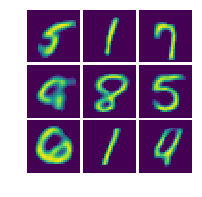

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:30 end epoch 159/300: average loss = 0.03278422451928275 (=0.019616+0.013168)

2018-05-07 22:49:30 start epoch 160/300, with learning rate = 0.0000402668
2018-05-07 22:49:30 iteration 1/859: current training loss = 0.033175 (=0.020169+0.013005)
2018-05-07 22:49:30 iteration 100/859: current training loss = 0.031690 (=0.019650+0.012039)
2018-05-07 22:49:31 iteration 200/859: current training loss = 0.032653 (=0.019828+0.012825)
2018-05-07 22:49:32 iteration 300/859: current training loss = 0.035678 (=0.022048+0.013630)
2018-05-07 22:49:33 iteration 400/859: current training loss = 0.031206 (=0.018681+0.012525)
2018-05-07 22:49:33 iteration 500/859: current training loss = 0.035323 (=0.021902+0.013421)
2018-05-07 22:49:34 iteration 600/859: current training loss = 0.032708 (=0.019640+0.013068)
2018-05-07 22:49:35 iteration 700/859: current training loss = 0.034388 (=0.020898+0.013491)
2018-05-07 22:49:35 iteration 800/859: cur

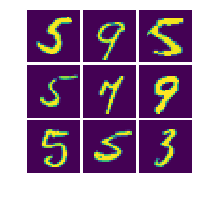

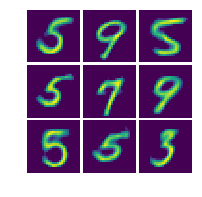

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:37 end epoch 160/300: average loss = 0.03277455796774941 (=0.019617+0.013157)

2018-05-07 22:49:37 start epoch 161/300, with learning rate = 0.0000394615
2018-05-07 22:49:37 iteration 1/859: current training loss = 0.035640 (=0.021668+0.013972)
2018-05-07 22:49:38 iteration 100/859: current training loss = 0.031191 (=0.018234+0.012956)
2018-05-07 22:49:38 iteration 200/859: current training loss = 0.034049 (=0.020506+0.013543)
2018-05-07 22:49:39 iteration 300/859: current training loss = 0.031792 (=0.018764+0.013028)
2018-05-07 22:49:40 iteration 400/859: current training loss = 0.034727 (=0.021691+0.013036)
2018-05-07 22:49:41 iteration 500/859: current training loss = 0.033037 (=0.020254+0.012783)
2018-05-07 22:49:41 iteration 600/859: current training loss = 0.032615 (=0.020053+0.012562)
2018-05-07 22:49:42 iteration 700/859: current training loss = 0.033668 (=0.020778+0.012890)
2018-05-07 22:49:43 iteration 800/859: cur

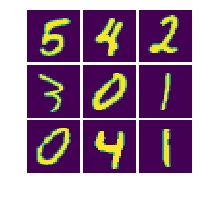

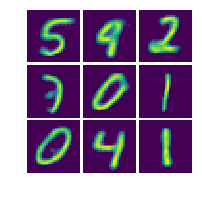

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:45 end epoch 161/300: average loss = 0.032800824822678 (=0.019656+0.013145)

2018-05-07 22:49:45 start epoch 162/300, with learning rate = 0.0000386723
2018-05-07 22:49:45 iteration 1/859: current training loss = 0.031106 (=0.018638+0.012468)
2018-05-07 22:49:45 iteration 100/859: current training loss = 0.034192 (=0.021152+0.013040)
2018-05-07 22:49:46 iteration 200/859: current training loss = 0.032095 (=0.019557+0.012537)
2018-05-07 22:49:47 iteration 300/859: current training loss = 0.034865 (=0.021509+0.013355)
2018-05-07 22:49:48 iteration 400/859: current training loss = 0.034035 (=0.020257+0.013778)
2018-05-07 22:49:48 iteration 500/859: current training loss = 0.033507 (=0.019657+0.013850)
2018-05-07 22:49:49 iteration 600/859: current training loss = 0.033020 (=0.019500+0.013520)
2018-05-07 22:49:50 iteration 700/859: current training loss = 0.032771 (=0.019440+0.013332)
2018-05-07 22:49:51 iteration 800/859: curre

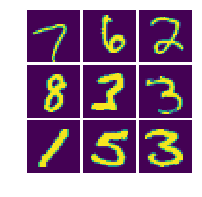

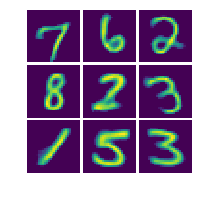

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:49:52 end epoch 162/300: average loss = 0.032856995382967456 (=0.019691+0.013166)

2018-05-07 22:49:52 start epoch 163/300, with learning rate = 0.0000378988
2018-05-07 22:49:52 iteration 1/859: current training loss = 0.034059 (=0.020559+0.013500)
2018-05-07 22:49:53 iteration 100/859: current training loss = 0.032424 (=0.019120+0.013304)
2018-05-07 22:49:54 iteration 200/859: current training loss = 0.033289 (=0.020111+0.013178)
2018-05-07 22:49:55 iteration 300/859: current training loss = 0.031511 (=0.019294+0.012217)
2018-05-07 22:49:55 iteration 400/859: current training loss = 0.032928 (=0.019771+0.013157)
2018-05-07 22:49:56 iteration 500/859: current training loss = 0.032116 (=0.019239+0.012877)
2018-05-07 22:49:57 iteration 600/859: current training loss = 0.036988 (=0.022623+0.014365)
2018-05-07 22:49:58 iteration 700/859: current training loss = 0.033211 (=0.019862+0.013349)
2018-05-07 22:49:58 iteration 800/859: cu

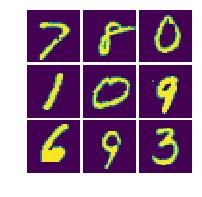

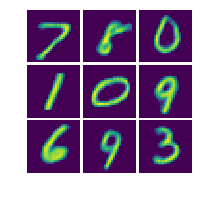

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:00 end epoch 163/300: average loss = 0.03279884690819991 (=0.019618+0.013181)

2018-05-07 22:50:00 start epoch 164/300, with learning rate = 0.0000371408
2018-05-07 22:50:00 iteration 1/859: current training loss = 0.032030 (=0.018377+0.013653)
2018-05-07 22:50:01 iteration 100/859: current training loss = 0.034205 (=0.021020+0.013184)
2018-05-07 22:50:02 iteration 200/859: current training loss = 0.034327 (=0.021429+0.012898)
2018-05-07 22:50:02 iteration 300/859: current training loss = 0.034108 (=0.021058+0.013051)
2018-05-07 22:50:03 iteration 400/859: current training loss = 0.033206 (=0.019987+0.013219)
2018-05-07 22:50:04 iteration 500/859: current training loss = 0.035265 (=0.021270+0.013995)
2018-05-07 22:50:05 iteration 600/859: current training loss = 0.032955 (=0.019991+0.012964)
2018-05-07 22:50:05 iteration 700/859: current training loss = 0.031839 (=0.018341+0.013498)
2018-05-07 22:50:06 iteration 800/859: cur

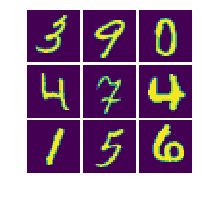

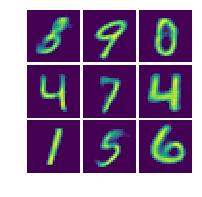

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:07 end epoch 164/300: average loss = 0.032840364568187 (=0.019661+0.013179)

2018-05-07 22:50:07 start epoch 165/300, with learning rate = 0.0000363980
2018-05-07 22:50:07 iteration 1/859: current training loss = 0.033275 (=0.019925+0.013349)
2018-05-07 22:50:08 iteration 100/859: current training loss = 0.030916 (=0.018132+0.012784)
2018-05-07 22:50:09 iteration 200/859: current training loss = 0.031630 (=0.018636+0.012995)
2018-05-07 22:50:10 iteration 300/859: current training loss = 0.034004 (=0.020875+0.013129)
2018-05-07 22:50:10 iteration 400/859: current training loss = 0.030676 (=0.017752+0.012924)
2018-05-07 22:50:11 iteration 500/859: current training loss = 0.030657 (=0.017636+0.013021)
2018-05-07 22:50:12 iteration 600/859: current training loss = 0.030416 (=0.017700+0.012716)
2018-05-07 22:50:13 iteration 700/859: current training loss = 0.035444 (=0.021755+0.013689)
2018-05-07 22:50:13 iteration 800/859: curre

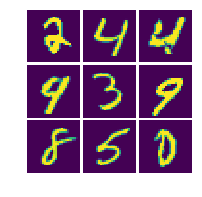

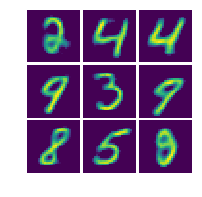

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:15 end epoch 165/300: average loss = 0.0328017577867222 (=0.019631+0.013171)

2018-05-07 22:50:15 start epoch 166/300, with learning rate = 0.0000356701
2018-05-07 22:50:15 iteration 1/859: current training loss = 0.034321 (=0.021168+0.013153)
2018-05-07 22:50:16 iteration 100/859: current training loss = 0.033261 (=0.019920+0.013341)
2018-05-07 22:50:17 iteration 200/859: current training loss = 0.034611 (=0.021176+0.013434)
2018-05-07 22:50:18 iteration 300/859: current training loss = 0.033349 (=0.019580+0.013768)
2018-05-07 22:50:18 iteration 400/859: current training loss = 0.033855 (=0.020302+0.013554)
2018-05-07 22:50:19 iteration 500/859: current training loss = 0.032817 (=0.020082+0.012735)
2018-05-07 22:50:20 iteration 600/859: current training loss = 0.033673 (=0.020612+0.013061)
2018-05-07 22:50:20 iteration 700/859: current training loss = 0.033439 (=0.020076+0.013364)
2018-05-07 22:50:21 iteration 800/859: curr

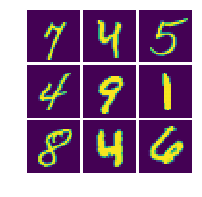

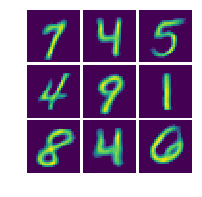

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:23 end epoch 166/300: average loss = 0.032782064230377515 (=0.019615+0.013167)

2018-05-07 22:50:23 start epoch 167/300, with learning rate = 0.0000349567
2018-05-07 22:50:23 iteration 1/859: current training loss = 0.033263 (=0.020232+0.013031)
2018-05-07 22:50:24 iteration 100/859: current training loss = 0.033850 (=0.020332+0.013517)
2018-05-07 22:50:24 iteration 200/859: current training loss = 0.032664 (=0.020041+0.012623)
2018-05-07 22:50:25 iteration 300/859: current training loss = 0.031525 (=0.018873+0.012652)
2018-05-07 22:50:26 iteration 400/859: current training loss = 0.029313 (=0.016967+0.012346)
2018-05-07 22:50:27 iteration 500/859: current training loss = 0.032903 (=0.019741+0.013161)
2018-05-07 22:50:27 iteration 600/859: current training loss = 0.033857 (=0.020526+0.013331)
2018-05-07 22:50:28 iteration 700/859: current training loss = 0.032453 (=0.019538+0.012915)
2018-05-07 22:50:29 iteration 800/859: cu

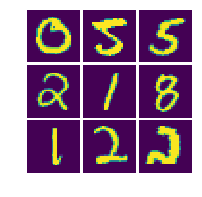

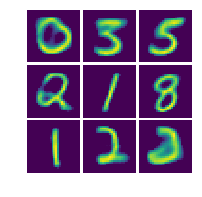

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:30 end epoch 167/300: average loss = 0.03280240200607407 (=0.019629+0.013173)

2018-05-07 22:50:30 start epoch 168/300, with learning rate = 0.0000342575
2018-05-07 22:50:30 iteration 1/859: current training loss = 0.034181 (=0.020599+0.013582)
2018-05-07 22:50:31 iteration 100/859: current training loss = 0.030002 (=0.017638+0.012364)
2018-05-07 22:50:32 iteration 200/859: current training loss = 0.031530 (=0.018791+0.012739)
2018-05-07 22:50:33 iteration 300/859: current training loss = 0.033786 (=0.020928+0.012859)
2018-05-07 22:50:33 iteration 400/859: current training loss = 0.031958 (=0.019432+0.012525)
2018-05-07 22:50:34 iteration 500/859: current training loss = 0.031827 (=0.019372+0.012454)
2018-05-07 22:50:35 iteration 600/859: current training loss = 0.032320 (=0.019034+0.013286)
2018-05-07 22:50:36 iteration 700/859: current training loss = 0.034701 (=0.020385+0.014316)
2018-05-07 22:50:36 iteration 800/859: cur

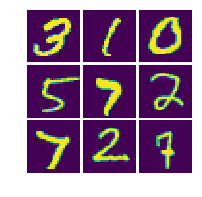

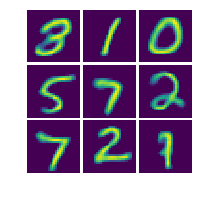

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:38 end epoch 168/300: average loss = 0.032778418669531316 (=0.019600+0.013179)

2018-05-07 22:50:38 start epoch 169/300, with learning rate = 0.0000335724
2018-05-07 22:50:38 iteration 1/859: current training loss = 0.031914 (=0.019334+0.012581)
2018-05-07 22:50:39 iteration 100/859: current training loss = 0.031881 (=0.018689+0.013192)
2018-05-07 22:50:40 iteration 200/859: current training loss = 0.034616 (=0.020769+0.013847)
2018-05-07 22:50:41 iteration 300/859: current training loss = 0.033596 (=0.020479+0.013117)
2018-05-07 22:50:41 iteration 400/859: current training loss = 0.031789 (=0.018981+0.012808)
2018-05-07 22:50:42 iteration 500/859: current training loss = 0.030807 (=0.017985+0.012822)
2018-05-07 22:50:43 iteration 600/859: current training loss = 0.034231 (=0.020949+0.013282)
2018-05-07 22:50:43 iteration 700/859: current training loss = 0.030774 (=0.018061+0.012713)
2018-05-07 22:50:44 iteration 800/859: cu

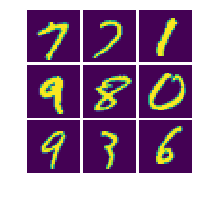

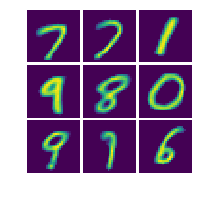

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:46 end epoch 169/300: average loss = 0.032759945672677614 (=0.019582+0.013178)

2018-05-07 22:50:46 start epoch 170/300, with learning rate = 0.0000329009
2018-05-07 22:50:46 iteration 1/859: current training loss = 0.032423 (=0.019165+0.013257)
2018-05-07 22:50:47 iteration 100/859: current training loss = 0.032820 (=0.019689+0.013131)
2018-05-07 22:50:47 iteration 200/859: current training loss = 0.033113 (=0.020077+0.013036)
2018-05-07 22:50:48 iteration 300/859: current training loss = 0.034158 (=0.020972+0.013186)
2018-05-07 22:50:49 iteration 400/859: current training loss = 0.032232 (=0.019466+0.012766)
2018-05-07 22:50:50 iteration 500/859: current training loss = 0.035040 (=0.021863+0.013176)
2018-05-07 22:50:50 iteration 600/859: current training loss = 0.031527 (=0.018929+0.012598)
2018-05-07 22:50:51 iteration 700/859: current training loss = 0.031934 (=0.018990+0.012944)
2018-05-07 22:50:52 iteration 800/859: cu

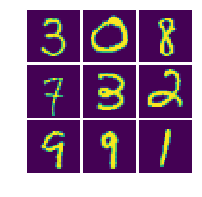

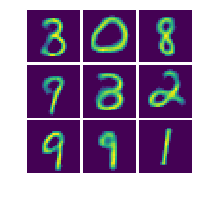

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:50:54 end epoch 170/300: average loss = 0.032772804245057845 (=0.019602+0.013171)

2018-05-07 22:50:54 start epoch 171/300, with learning rate = 0.0000322429
2018-05-07 22:50:54 iteration 1/859: current training loss = 0.033032 (=0.019812+0.013220)
2018-05-07 22:50:54 iteration 100/859: current training loss = 0.032989 (=0.019446+0.013543)
2018-05-07 22:50:55 iteration 200/859: current training loss = 0.033598 (=0.020033+0.013565)
2018-05-07 22:50:56 iteration 300/859: current training loss = 0.032065 (=0.018913+0.013152)
2018-05-07 22:50:56 iteration 400/859: current training loss = 0.032727 (=0.019901+0.012826)
2018-05-07 22:50:57 iteration 500/859: current training loss = 0.033913 (=0.020820+0.013093)
2018-05-07 22:50:58 iteration 600/859: current training loss = 0.032542 (=0.019139+0.013402)
2018-05-07 22:50:58 iteration 700/859: current training loss = 0.032926 (=0.019481+0.013445)
2018-05-07 22:50:59 iteration 800/859: cu

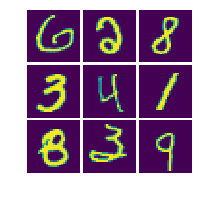

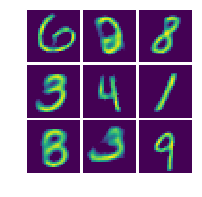

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:01 end epoch 171/300: average loss = 0.03275886150694976 (=0.019582+0.013177)

2018-05-07 22:51:01 start epoch 172/300, with learning rate = 0.0000315981
2018-05-07 22:51:01 iteration 1/859: current training loss = 0.030198 (=0.017516+0.012682)
2018-05-07 22:51:02 iteration 100/859: current training loss = 0.032766 (=0.019582+0.013185)
2018-05-07 22:51:02 iteration 200/859: current training loss = 0.032754 (=0.019671+0.013083)
2018-05-07 22:51:03 iteration 300/859: current training loss = 0.033998 (=0.020582+0.013415)
2018-05-07 22:51:04 iteration 400/859: current training loss = 0.033402 (=0.020074+0.013328)
2018-05-07 22:51:04 iteration 500/859: current training loss = 0.032917 (=0.019045+0.013872)
2018-05-07 22:51:05 iteration 600/859: current training loss = 0.034221 (=0.020765+0.013457)
2018-05-07 22:51:06 iteration 700/859: current training loss = 0.032926 (=0.019470+0.013456)
2018-05-07 22:51:07 iteration 800/859: cur

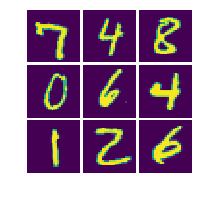

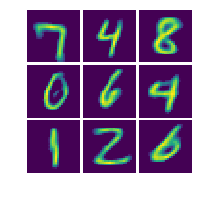

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:08 end epoch 172/300: average loss = 0.03276039926038146 (=0.019594+0.013167)

2018-05-07 22:51:08 start epoch 173/300, with learning rate = 0.0000309661
2018-05-07 22:51:08 iteration 1/859: current training loss = 0.031282 (=0.018595+0.012688)
2018-05-07 22:51:09 iteration 100/859: current training loss = 0.034890 (=0.021371+0.013519)
2018-05-07 22:51:10 iteration 200/859: current training loss = 0.035691 (=0.021877+0.013814)
2018-05-07 22:51:10 iteration 300/859: current training loss = 0.035219 (=0.021074+0.014145)
2018-05-07 22:51:11 iteration 400/859: current training loss = 0.031208 (=0.018224+0.012984)
2018-05-07 22:51:12 iteration 500/859: current training loss = 0.035147 (=0.021325+0.013822)
2018-05-07 22:51:12 iteration 600/859: current training loss = 0.033252 (=0.020057+0.013195)
2018-05-07 22:51:13 iteration 700/859: current training loss = 0.032726 (=0.019493+0.013232)
2018-05-07 22:51:14 iteration 800/859: cur

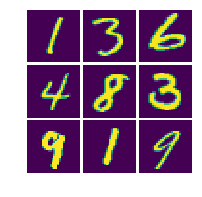

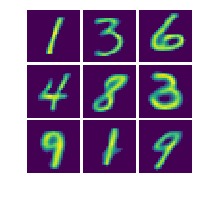

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:15 end epoch 173/300: average loss = 0.032746603135648374 (=0.019588+0.013158)

2018-05-07 22:51:15 start epoch 174/300, with learning rate = 0.0000303468
2018-05-07 22:51:15 iteration 1/859: current training loss = 0.036026 (=0.022254+0.013773)
2018-05-07 22:51:16 iteration 100/859: current training loss = 0.030720 (=0.018308+0.012412)
2018-05-07 22:51:17 iteration 200/859: current training loss = 0.034130 (=0.020799+0.013332)
2018-05-07 22:51:18 iteration 300/859: current training loss = 0.034516 (=0.020628+0.013888)
2018-05-07 22:51:18 iteration 400/859: current training loss = 0.034025 (=0.020950+0.013076)
2018-05-07 22:51:19 iteration 500/859: current training loss = 0.030574 (=0.018091+0.012484)
2018-05-07 22:51:20 iteration 600/859: current training loss = 0.032165 (=0.019033+0.013133)
2018-05-07 22:51:20 iteration 700/859: current training loss = 0.032894 (=0.020043+0.012850)
2018-05-07 22:51:21 iteration 800/859: cu

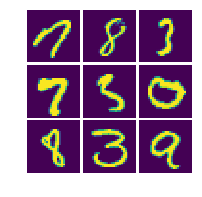

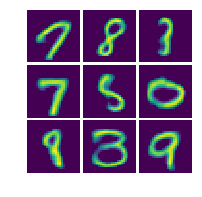

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:23 end epoch 174/300: average loss = 0.032745190420132714 (=0.019591+0.013155)

2018-05-07 22:51:23 start epoch 175/300, with learning rate = 0.0000297398
2018-05-07 22:51:23 iteration 1/859: current training loss = 0.032968 (=0.019733+0.013235)
2018-05-07 22:51:24 iteration 100/859: current training loss = 0.032629 (=0.019720+0.012909)
2018-05-07 22:51:24 iteration 200/859: current training loss = 0.034594 (=0.020784+0.013810)
2018-05-07 22:51:25 iteration 300/859: current training loss = 0.034924 (=0.021272+0.013652)
2018-05-07 22:51:26 iteration 400/859: current training loss = 0.033265 (=0.020369+0.012896)
2018-05-07 22:51:27 iteration 500/859: current training loss = 0.033422 (=0.020448+0.012974)
2018-05-07 22:51:27 iteration 600/859: current training loss = 0.030362 (=0.017734+0.012628)
2018-05-07 22:51:28 iteration 700/859: current training loss = 0.033749 (=0.020145+0.013603)
2018-05-07 22:51:29 iteration 800/859: cu

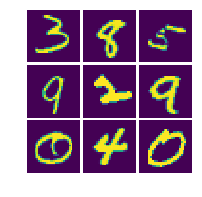

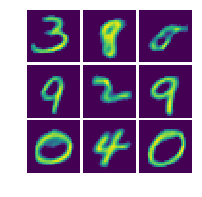

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:30 end epoch 175/300: average loss = 0.03271926768835335 (=0.019564+0.013155)

2018-05-07 22:51:30 start epoch 176/300, with learning rate = 0.0000291450
2018-05-07 22:51:30 iteration 1/859: current training loss = 0.031862 (=0.019015+0.012848)
2018-05-07 22:51:31 iteration 100/859: current training loss = 0.033179 (=0.020511+0.012668)
2018-05-07 22:51:32 iteration 200/859: current training loss = 0.032902 (=0.019621+0.013281)
2018-05-07 22:51:33 iteration 300/859: current training loss = 0.036615 (=0.022463+0.014151)
2018-05-07 22:51:33 iteration 400/859: current training loss = 0.031893 (=0.019017+0.012876)
2018-05-07 22:51:34 iteration 500/859: current training loss = 0.032005 (=0.018860+0.013145)
2018-05-07 22:51:35 iteration 600/859: current training loss = 0.030413 (=0.018046+0.012366)
2018-05-07 22:51:36 iteration 700/859: current training loss = 0.032254 (=0.019552+0.012701)
2018-05-07 22:51:36 iteration 800/859: cur

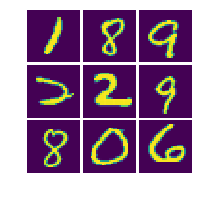

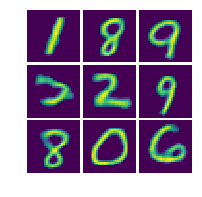

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:38 end epoch 176/300: average loss = 0.03271342101219577 (=0.019555+0.013158)

2018-05-07 22:51:38 start epoch 177/300, with learning rate = 0.0000285621
2018-05-07 22:51:38 iteration 1/859: current training loss = 0.034115 (=0.020746+0.013370)
2018-05-07 22:51:39 iteration 100/859: current training loss = 0.031911 (=0.018666+0.013245)
2018-05-07 22:51:40 iteration 200/859: current training loss = 0.035157 (=0.021602+0.013555)
2018-05-07 22:51:40 iteration 300/859: current training loss = 0.034529 (=0.020970+0.013559)
2018-05-07 22:51:41 iteration 400/859: current training loss = 0.032498 (=0.019293+0.013205)
2018-05-07 22:51:42 iteration 500/859: current training loss = 0.033738 (=0.020398+0.013340)
2018-05-07 22:51:42 iteration 600/859: current training loss = 0.034839 (=0.021555+0.013285)
2018-05-07 22:51:43 iteration 700/859: current training loss = 0.030200 (=0.017727+0.012472)
2018-05-07 22:51:44 iteration 800/859: cur

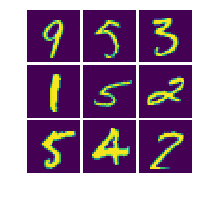

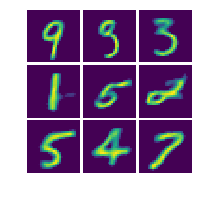

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:45 end epoch 177/300: average loss = 0.03273492636499499 (=0.019566+0.013169)

2018-05-07 22:51:45 start epoch 178/300, with learning rate = 0.0000279909
2018-05-07 22:51:45 iteration 1/859: current training loss = 0.032029 (=0.019210+0.012818)
2018-05-07 22:51:46 iteration 100/859: current training loss = 0.031702 (=0.018644+0.013058)
2018-05-07 22:51:47 iteration 200/859: current training loss = 0.033288 (=0.020124+0.013164)
2018-05-07 22:51:48 iteration 300/859: current training loss = 0.032061 (=0.019003+0.013059)
2018-05-07 22:51:48 iteration 400/859: current training loss = 0.031654 (=0.018482+0.013172)
2018-05-07 22:51:49 iteration 500/859: current training loss = 0.030130 (=0.017904+0.012227)
2018-05-07 22:51:50 iteration 600/859: current training loss = 0.032254 (=0.019368+0.012886)
2018-05-07 22:51:51 iteration 700/859: current training loss = 0.030508 (=0.017493+0.013015)
2018-05-07 22:51:51 iteration 800/859: cur

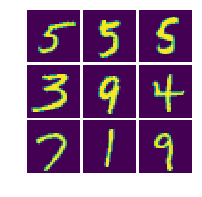

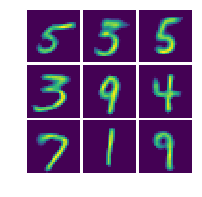

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:51:53 end epoch 178/300: average loss = 0.0327639630968586 (=0.019586+0.013178)

2018-05-07 22:51:53 start epoch 179/300, with learning rate = 0.0000274311
2018-05-07 22:51:53 iteration 1/859: current training loss = 0.031360 (=0.018509+0.012852)
2018-05-07 22:51:54 iteration 100/859: current training loss = 0.033447 (=0.019800+0.013647)
2018-05-07 22:51:54 iteration 200/859: current training loss = 0.032151 (=0.019092+0.013059)
2018-05-07 22:51:55 iteration 300/859: current training loss = 0.034156 (=0.020516+0.013640)
2018-05-07 22:51:56 iteration 400/859: current training loss = 0.033708 (=0.020109+0.013599)
2018-05-07 22:51:57 iteration 500/859: current training loss = 0.032892 (=0.019842+0.013050)
2018-05-07 22:51:57 iteration 600/859: current training loss = 0.032894 (=0.019475+0.013418)
2018-05-07 22:51:58 iteration 700/859: current training loss = 0.031777 (=0.019039+0.012738)
2018-05-07 22:51:59 iteration 800/859: curr

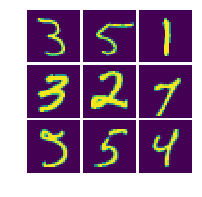

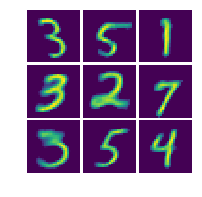

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:01 end epoch 179/300: average loss = 0.03272777850434999 (=0.019564+0.013164)

2018-05-07 22:52:01 start epoch 180/300, with learning rate = 0.0000268825
2018-05-07 22:52:01 iteration 1/859: current training loss = 0.031398 (=0.018583+0.012815)
2018-05-07 22:52:01 iteration 100/859: current training loss = 0.033012 (=0.019809+0.013203)
2018-05-07 22:52:02 iteration 200/859: current training loss = 0.031012 (=0.018545+0.012467)
2018-05-07 22:52:03 iteration 300/859: current training loss = 0.031703 (=0.018491+0.013213)
2018-05-07 22:52:04 iteration 400/859: current training loss = 0.035350 (=0.021405+0.013945)
2018-05-07 22:52:04 iteration 500/859: current training loss = 0.032663 (=0.019961+0.012702)
2018-05-07 22:52:05 iteration 600/859: current training loss = 0.032891 (=0.019739+0.013152)
2018-05-07 22:52:06 iteration 700/859: current training loss = 0.031939 (=0.019014+0.012924)
2018-05-07 22:52:07 iteration 800/859: cur

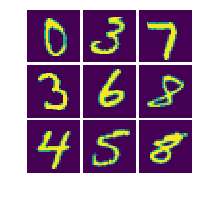

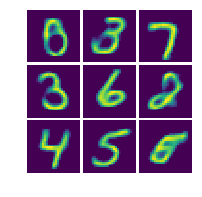

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:08 end epoch 180/300: average loss = 0.03269047162151864 (=0.019547+0.013143)

2018-05-07 22:52:08 start epoch 181/300, with learning rate = 0.0000263448
2018-05-07 22:52:08 iteration 1/859: current training loss = 0.033164 (=0.019853+0.013311)
2018-05-07 22:52:09 iteration 100/859: current training loss = 0.032185 (=0.019318+0.012867)
2018-05-07 22:52:10 iteration 200/859: current training loss = 0.032372 (=0.019887+0.012485)
2018-05-07 22:52:11 iteration 300/859: current training loss = 0.031377 (=0.018464+0.012913)
2018-05-07 22:52:11 iteration 400/859: current training loss = 0.032414 (=0.019026+0.013387)
2018-05-07 22:52:12 iteration 500/859: current training loss = 0.030493 (=0.018022+0.012471)
2018-05-07 22:52:13 iteration 600/859: current training loss = 0.030996 (=0.018684+0.012312)
2018-05-07 22:52:14 iteration 700/859: current training loss = 0.032867 (=0.019747+0.013120)
2018-05-07 22:52:14 iteration 800/859: cur

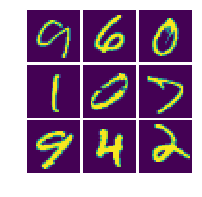

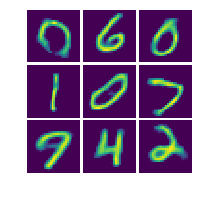

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:16 end epoch 181/300: average loss = 0.03267032101672312 (=0.019531+0.013139)

2018-05-07 22:52:16 start epoch 182/300, with learning rate = 0.0000258179
2018-05-07 22:52:16 iteration 1/859: current training loss = 0.033420 (=0.019877+0.013543)
2018-05-07 22:52:17 iteration 100/859: current training loss = 0.029333 (=0.016853+0.012479)
2018-05-07 22:52:18 iteration 200/859: current training loss = 0.032164 (=0.019157+0.013007)
2018-05-07 22:52:18 iteration 300/859: current training loss = 0.034023 (=0.020721+0.013302)
2018-05-07 22:52:19 iteration 400/859: current training loss = 0.036492 (=0.021992+0.014500)
2018-05-07 22:52:20 iteration 500/859: current training loss = 0.031796 (=0.018870+0.012927)
2018-05-07 22:52:21 iteration 600/859: current training loss = 0.034747 (=0.021538+0.013209)
2018-05-07 22:52:21 iteration 700/859: current training loss = 0.032779 (=0.019684+0.013094)
2018-05-07 22:52:22 iteration 800/859: cur

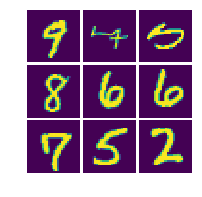

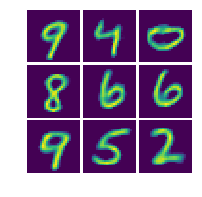

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:24 end epoch 182/300: average loss = 0.03277623760747063 (=0.019570+0.013206)

2018-05-07 22:52:24 start epoch 183/300, with learning rate = 0.0000253016
2018-05-07 22:52:24 iteration 1/859: current training loss = 0.034765 (=0.021155+0.013610)
2018-05-07 22:52:25 iteration 100/859: current training loss = 0.030379 (=0.017767+0.012612)
2018-05-07 22:52:25 iteration 200/859: current training loss = 0.032535 (=0.019293+0.013242)
2018-05-07 22:52:26 iteration 300/859: current training loss = 0.033896 (=0.020901+0.012995)
2018-05-07 22:52:27 iteration 400/859: current training loss = 0.034609 (=0.020825+0.013783)
2018-05-07 22:52:28 iteration 500/859: current training loss = 0.033092 (=0.019504+0.013589)
2018-05-07 22:52:28 iteration 600/859: current training loss = 0.032324 (=0.019003+0.013321)
2018-05-07 22:52:29 iteration 700/859: current training loss = 0.032396 (=0.019437+0.012959)
2018-05-07 22:52:30 iteration 800/859: cur

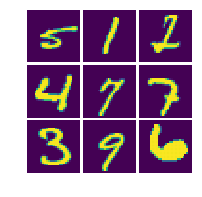

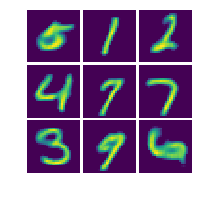

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:31 end epoch 183/300: average loss = 0.03269122901336833 (=0.019527+0.013165)

2018-05-07 22:52:31 start epoch 184/300, with learning rate = 0.0000247955
2018-05-07 22:52:31 iteration 1/859: current training loss = 0.031799 (=0.018671+0.013128)
2018-05-07 22:52:32 iteration 100/859: current training loss = 0.032627 (=0.019630+0.012997)
2018-05-07 22:52:33 iteration 200/859: current training loss = 0.032828 (=0.019574+0.013254)
2018-05-07 22:52:34 iteration 300/859: current training loss = 0.033217 (=0.019773+0.013444)
2018-05-07 22:52:34 iteration 400/859: current training loss = 0.033759 (=0.020649+0.013110)
2018-05-07 22:52:35 iteration 500/859: current training loss = 0.031593 (=0.019154+0.012440)
2018-05-07 22:52:36 iteration 600/859: current training loss = 0.032253 (=0.019596+0.012656)
2018-05-07 22:52:37 iteration 700/859: current training loss = 0.031947 (=0.018999+0.012947)
2018-05-07 22:52:37 iteration 800/859: cur

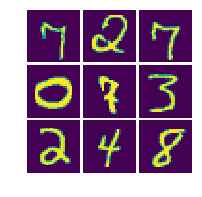

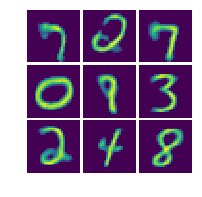

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:39 end epoch 184/300: average loss = 0.03272038872317954 (=0.019553+0.013167)

2018-05-07 22:52:39 start epoch 185/300, with learning rate = 0.0000242996
2018-05-07 22:52:39 iteration 1/859: current training loss = 0.032274 (=0.019237+0.013037)
2018-05-07 22:52:40 iteration 100/859: current training loss = 0.033596 (=0.020685+0.012911)
2018-05-07 22:52:41 iteration 200/859: current training loss = 0.033646 (=0.019934+0.013711)
2018-05-07 22:52:41 iteration 300/859: current training loss = 0.032758 (=0.019764+0.012994)
2018-05-07 22:52:42 iteration 400/859: current training loss = 0.032086 (=0.019034+0.013052)
2018-05-07 22:52:43 iteration 500/859: current training loss = 0.033278 (=0.019820+0.013457)
2018-05-07 22:52:44 iteration 600/859: current training loss = 0.032693 (=0.019941+0.012752)
2018-05-07 22:52:44 iteration 700/859: current training loss = 0.033502 (=0.020277+0.013225)
2018-05-07 22:52:45 iteration 800/859: cur

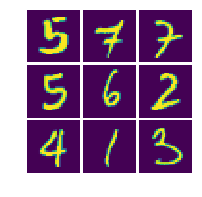

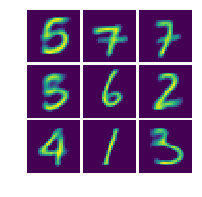

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:47 end epoch 185/300: average loss = 0.03266616282730913 (=0.019513+0.013153)

2018-05-07 22:52:47 start epoch 186/300, with learning rate = 0.0000238136
2018-05-07 22:52:47 iteration 1/859: current training loss = 0.032987 (=0.019731+0.013256)
2018-05-07 22:52:48 iteration 100/859: current training loss = 0.031716 (=0.018810+0.012907)
2018-05-07 22:52:48 iteration 200/859: current training loss = 0.032533 (=0.019149+0.013383)
2018-05-07 22:52:49 iteration 300/859: current training loss = 0.032310 (=0.019132+0.013178)
2018-05-07 22:52:50 iteration 400/859: current training loss = 0.034808 (=0.021265+0.013543)
2018-05-07 22:52:51 iteration 500/859: current training loss = 0.032643 (=0.019614+0.013028)
2018-05-07 22:52:51 iteration 600/859: current training loss = 0.033507 (=0.020548+0.012958)
2018-05-07 22:52:52 iteration 700/859: current training loss = 0.030466 (=0.018053+0.012413)
2018-05-07 22:52:53 iteration 800/859: cur

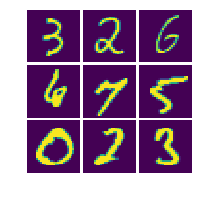

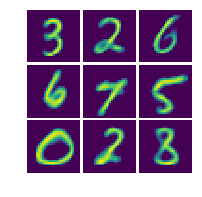

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:52:55 end epoch 186/300: average loss = 0.032631649443829853 (=0.019473+0.013159)

2018-05-07 22:52:55 start epoch 187/300, with learning rate = 0.0000233374
2018-05-07 22:52:55 iteration 1/859: current training loss = 0.032684 (=0.019279+0.013405)
2018-05-07 22:52:55 iteration 100/859: current training loss = 0.031189 (=0.018435+0.012754)
2018-05-07 22:52:56 iteration 200/859: current training loss = 0.033205 (=0.019338+0.013867)
2018-05-07 22:52:57 iteration 300/859: current training loss = 0.032666 (=0.019474+0.013192)
2018-05-07 22:52:58 iteration 400/859: current training loss = 0.029980 (=0.017615+0.012364)
2018-05-07 22:52:58 iteration 500/859: current training loss = 0.033184 (=0.020167+0.013017)
2018-05-07 22:52:59 iteration 600/859: current training loss = 0.034150 (=0.020822+0.013328)
2018-05-07 22:53:00 iteration 700/859: current training loss = 0.033953 (=0.020676+0.013277)
2018-05-07 22:53:01 iteration 800/859: cu

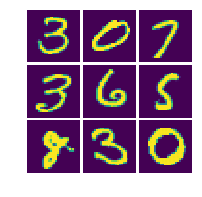

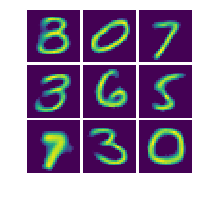

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:02 end epoch 187/300: average loss = 0.03268677572588565 (=0.019525+0.013162)

2018-05-07 22:53:02 start epoch 188/300, with learning rate = 0.0000228706
2018-05-07 22:53:02 iteration 1/859: current training loss = 0.031815 (=0.019204+0.012611)
2018-05-07 22:53:03 iteration 100/859: current training loss = 0.032714 (=0.020127+0.012587)
2018-05-07 22:53:04 iteration 200/859: current training loss = 0.033667 (=0.020298+0.013369)
2018-05-07 22:53:04 iteration 300/859: current training loss = 0.031332 (=0.018220+0.013112)
2018-05-07 22:53:05 iteration 400/859: current training loss = 0.033294 (=0.020128+0.013167)
2018-05-07 22:53:06 iteration 500/859: current training loss = 0.032481 (=0.019318+0.013163)
2018-05-07 22:53:07 iteration 600/859: current training loss = 0.034017 (=0.020662+0.013355)
2018-05-07 22:53:07 iteration 700/859: current training loss = 0.032042 (=0.019287+0.012755)
2018-05-07 22:53:08 iteration 800/859: cur

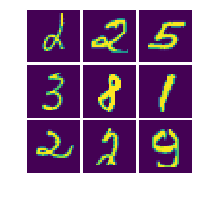

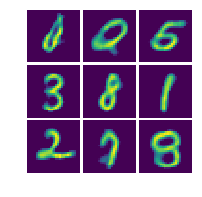

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:10 end epoch 188/300: average loss = 0.03268075205723953 (=0.019510+0.013171)

2018-05-07 22:53:10 start epoch 189/300, with learning rate = 0.0000224132
2018-05-07 22:53:10 iteration 1/859: current training loss = 0.030774 (=0.017988+0.012786)
2018-05-07 22:53:11 iteration 100/859: current training loss = 0.031519 (=0.018258+0.013261)
2018-05-07 22:53:11 iteration 200/859: current training loss = 0.032983 (=0.019805+0.013177)
2018-05-07 22:53:12 iteration 300/859: current training loss = 0.033219 (=0.019651+0.013568)
2018-05-07 22:53:13 iteration 400/859: current training loss = 0.030310 (=0.017948+0.012362)
2018-05-07 22:53:14 iteration 500/859: current training loss = 0.034272 (=0.021214+0.013058)
2018-05-07 22:53:14 iteration 600/859: current training loss = 0.032311 (=0.019070+0.013240)
2018-05-07 22:53:15 iteration 700/859: current training loss = 0.029918 (=0.017514+0.012404)
2018-05-07 22:53:16 iteration 800/859: cur

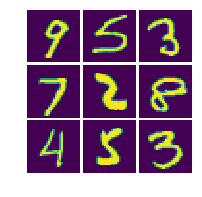

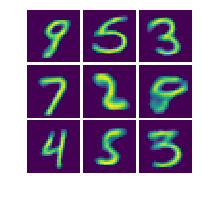

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:18 end epoch 189/300: average loss = 0.03261966391643282 (=0.019473+0.013146)

2018-05-07 22:53:18 start epoch 190/300, with learning rate = 0.0000219649
2018-05-07 22:53:18 iteration 1/859: current training loss = 0.033549 (=0.020739+0.012810)
2018-05-07 22:53:18 iteration 100/859: current training loss = 0.031944 (=0.019231+0.012712)
2018-05-07 22:53:19 iteration 200/859: current training loss = 0.033008 (=0.019621+0.013387)
2018-05-07 22:53:20 iteration 300/859: current training loss = 0.028934 (=0.016509+0.012425)
2018-05-07 22:53:21 iteration 400/859: current training loss = 0.033156 (=0.019336+0.013820)
2018-05-07 22:53:21 iteration 500/859: current training loss = 0.030812 (=0.017810+0.013002)
2018-05-07 22:53:22 iteration 600/859: current training loss = 0.033270 (=0.020261+0.013008)
2018-05-07 22:53:23 iteration 700/859: current training loss = 0.032245 (=0.019240+0.013005)
2018-05-07 22:53:24 iteration 800/859: cur

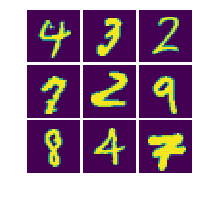

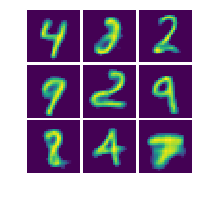

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:25 end epoch 190/300: average loss = 0.03260231488606566 (=0.019457+0.013145)

2018-05-07 22:53:25 start epoch 191/300, with learning rate = 0.0000215256
2018-05-07 22:53:25 iteration 1/859: current training loss = 0.030773 (=0.018192+0.012581)
2018-05-07 22:53:26 iteration 100/859: current training loss = 0.030972 (=0.017828+0.013144)
2018-05-07 22:53:27 iteration 200/859: current training loss = 0.031624 (=0.018970+0.012653)
2018-05-07 22:53:28 iteration 300/859: current training loss = 0.032799 (=0.019704+0.013096)
2018-05-07 22:53:28 iteration 400/859: current training loss = 0.030714 (=0.017593+0.013121)
2018-05-07 22:53:29 iteration 500/859: current training loss = 0.031351 (=0.018432+0.012920)
2018-05-07 22:53:30 iteration 600/859: current training loss = 0.031973 (=0.019461+0.012512)
2018-05-07 22:53:31 iteration 700/859: current training loss = 0.032710 (=0.019482+0.013229)
2018-05-07 22:53:31 iteration 800/859: cur

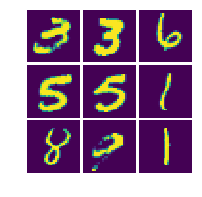

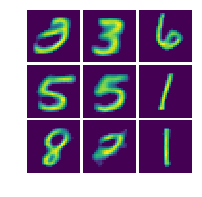

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:33 end epoch 191/300: average loss = 0.03264225519352242 (=0.019477+0.013165)

2018-05-07 22:53:33 start epoch 192/300, with learning rate = 0.0000210951
2018-05-07 22:53:33 iteration 1/859: current training loss = 0.032535 (=0.019180+0.013356)
2018-05-07 22:53:34 iteration 100/859: current training loss = 0.032772 (=0.019587+0.013185)
2018-05-07 22:53:35 iteration 200/859: current training loss = 0.032944 (=0.019758+0.013186)
2018-05-07 22:53:35 iteration 300/859: current training loss = 0.033896 (=0.020047+0.013849)
2018-05-07 22:53:36 iteration 400/859: current training loss = 0.030849 (=0.018143+0.012706)
2018-05-07 22:53:37 iteration 500/859: current training loss = 0.034016 (=0.020444+0.013572)
2018-05-07 22:53:38 iteration 600/859: current training loss = 0.034048 (=0.020319+0.013729)
2018-05-07 22:53:38 iteration 700/859: current training loss = 0.031164 (=0.018898+0.012265)
2018-05-07 22:53:39 iteration 800/859: cur

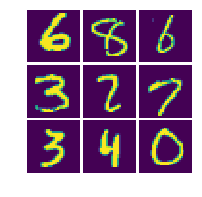

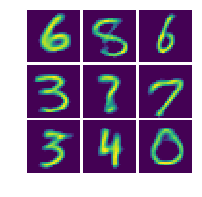

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:40 end epoch 192/300: average loss = 0.032608154066106496 (=0.019458+0.013150)

2018-05-07 22:53:40 start epoch 193/300, with learning rate = 0.0000206732
2018-05-07 22:53:40 iteration 1/859: current training loss = 0.030974 (=0.018131+0.012843)
2018-05-07 22:53:41 iteration 100/859: current training loss = 0.033490 (=0.020443+0.013047)
2018-05-07 22:53:42 iteration 200/859: current training loss = 0.031803 (=0.018428+0.013374)
2018-05-07 22:53:43 iteration 300/859: current training loss = 0.034507 (=0.021418+0.013088)
2018-05-07 22:53:44 iteration 400/859: current training loss = 0.033729 (=0.020648+0.013081)
2018-05-07 22:53:44 iteration 500/859: current training loss = 0.031770 (=0.018240+0.013530)
2018-05-07 22:53:45 iteration 600/859: current training loss = 0.031003 (=0.018396+0.012607)
2018-05-07 22:53:46 iteration 700/859: current training loss = 0.032467 (=0.019639+0.012828)
2018-05-07 22:53:46 iteration 800/859: cu

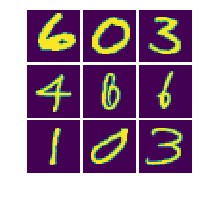

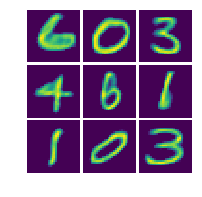

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:48 end epoch 193/300: average loss = 0.032690979941499804 (=0.019510+0.013181)

2018-05-07 22:53:48 start epoch 194/300, with learning rate = 0.0000202598
2018-05-07 22:53:48 iteration 1/859: current training loss = 0.029516 (=0.016780+0.012736)
2018-05-07 22:53:49 iteration 100/859: current training loss = 0.031912 (=0.019151+0.012761)
2018-05-07 22:53:50 iteration 200/859: current training loss = 0.036164 (=0.022476+0.013687)
2018-05-07 22:53:50 iteration 300/859: current training loss = 0.032637 (=0.019429+0.013208)
2018-05-07 22:53:51 iteration 400/859: current training loss = 0.034013 (=0.020660+0.013353)
2018-05-07 22:53:52 iteration 500/859: current training loss = 0.035298 (=0.021395+0.013903)
2018-05-07 22:53:53 iteration 600/859: current training loss = 0.031686 (=0.019096+0.012590)
2018-05-07 22:53:53 iteration 700/859: current training loss = 0.034146 (=0.020569+0.013577)
2018-05-07 22:53:54 iteration 800/859: cu

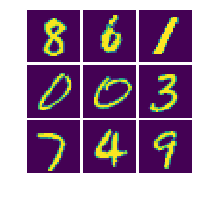

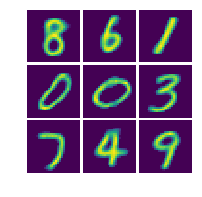

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:53:56 end epoch 194/300: average loss = 0.032638955705206106 (=0.019477+0.013162)

2018-05-07 22:53:56 start epoch 195/300, with learning rate = 0.0000198546
2018-05-07 22:53:56 iteration 1/859: current training loss = 0.031737 (=0.018966+0.012772)
2018-05-07 22:53:56 iteration 100/859: current training loss = 0.033556 (=0.020306+0.013250)
2018-05-07 22:53:57 iteration 200/859: current training loss = 0.033176 (=0.019869+0.013307)
2018-05-07 22:53:58 iteration 300/859: current training loss = 0.032671 (=0.019535+0.013136)
2018-05-07 22:53:59 iteration 400/859: current training loss = 0.031750 (=0.018839+0.012910)
2018-05-07 22:53:59 iteration 500/859: current training loss = 0.033650 (=0.019987+0.013663)
2018-05-07 22:54:00 iteration 600/859: current training loss = 0.032810 (=0.020041+0.012769)
2018-05-07 22:54:01 iteration 700/859: current training loss = 0.034006 (=0.020201+0.013805)
2018-05-07 22:54:02 iteration 800/859: cu

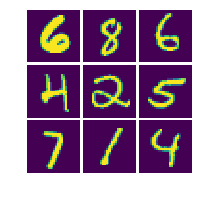

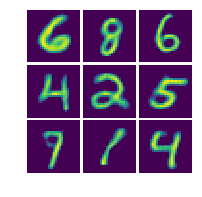

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:03 end epoch 195/300: average loss = 0.03263839619609336 (=0.019467+0.013171)

2018-05-07 22:54:03 start epoch 196/300, with learning rate = 0.0000194575
2018-05-07 22:54:03 iteration 1/859: current training loss = 0.031284 (=0.018449+0.012835)
2018-05-07 22:54:04 iteration 100/859: current training loss = 0.030997 (=0.018272+0.012725)
2018-05-07 22:54:05 iteration 200/859: current training loss = 0.033450 (=0.020011+0.013439)
2018-05-07 22:54:05 iteration 300/859: current training loss = 0.033651 (=0.020257+0.013394)
2018-05-07 22:54:06 iteration 400/859: current training loss = 0.032690 (=0.019909+0.012781)
2018-05-07 22:54:07 iteration 500/859: current training loss = 0.031587 (=0.018767+0.012821)
2018-05-07 22:54:08 iteration 600/859: current training loss = 0.032340 (=0.019334+0.013006)
2018-05-07 22:54:08 iteration 700/859: current training loss = 0.034137 (=0.020366+0.013771)
2018-05-07 22:54:09 iteration 800/859: cur

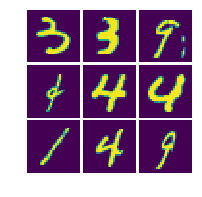

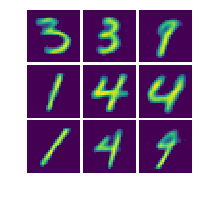

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:11 end epoch 196/300: average loss = 0.03261200191368532 (=0.019446+0.013166)

2018-05-07 22:54:11 start epoch 197/300, with learning rate = 0.0000190683
2018-05-07 22:54:11 iteration 1/859: current training loss = 0.033947 (=0.020544+0.013403)
2018-05-07 22:54:12 iteration 100/859: current training loss = 0.032732 (=0.019769+0.012963)
2018-05-07 22:54:13 iteration 200/859: current training loss = 0.032225 (=0.019317+0.012908)
2018-05-07 22:54:13 iteration 300/859: current training loss = 0.031340 (=0.018810+0.012530)
2018-05-07 22:54:14 iteration 400/859: current training loss = 0.033016 (=0.019703+0.013314)
2018-05-07 22:54:15 iteration 500/859: current training loss = 0.031256 (=0.018666+0.012590)
2018-05-07 22:54:16 iteration 600/859: current training loss = 0.032425 (=0.019027+0.013398)
2018-05-07 22:54:16 iteration 700/859: current training loss = 0.031902 (=0.019080+0.012822)
2018-05-07 22:54:17 iteration 800/859: cur

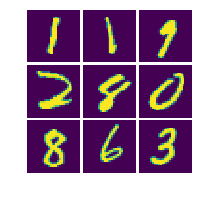

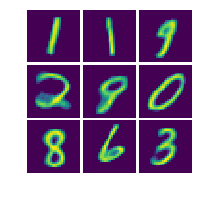

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:19 end epoch 197/300: average loss = 0.03258635871528677 (=0.019445+0.013141)

2018-05-07 22:54:19 start epoch 198/300, with learning rate = 0.0000186870
2018-05-07 22:54:19 iteration 1/859: current training loss = 0.036151 (=0.022594+0.013557)
2018-05-07 22:54:20 iteration 100/859: current training loss = 0.033942 (=0.020079+0.013863)
2018-05-07 22:54:20 iteration 200/859: current training loss = 0.032507 (=0.019413+0.013094)
2018-05-07 22:54:21 iteration 300/859: current training loss = 0.033887 (=0.020563+0.013324)
2018-05-07 22:54:22 iteration 400/859: current training loss = 0.033655 (=0.020060+0.013595)
2018-05-07 22:54:23 iteration 500/859: current training loss = 0.031503 (=0.018817+0.012686)
2018-05-07 22:54:23 iteration 600/859: current training loss = 0.031248 (=0.018499+0.012750)
2018-05-07 22:54:24 iteration 700/859: current training loss = 0.033656 (=0.019861+0.013795)
2018-05-07 22:54:25 iteration 800/859: cur

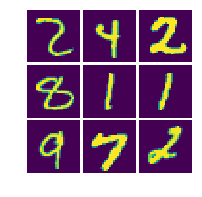

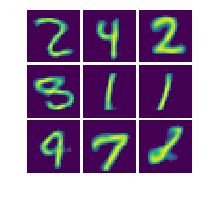

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:27 end epoch 198/300: average loss = 0.0326437358467973 (=0.019451+0.013193)

2018-05-07 22:54:27 start epoch 199/300, with learning rate = 0.0000183132
2018-05-07 22:54:27 iteration 1/859: current training loss = 0.032245 (=0.019078+0.013167)
2018-05-07 22:54:27 iteration 100/859: current training loss = 0.033609 (=0.020256+0.013353)
2018-05-07 22:54:28 iteration 200/859: current training loss = 0.031297 (=0.018233+0.013063)
2018-05-07 22:54:29 iteration 300/859: current training loss = 0.031708 (=0.018604+0.013104)
2018-05-07 22:54:30 iteration 400/859: current training loss = 0.032272 (=0.019252+0.013020)
2018-05-07 22:54:30 iteration 500/859: current training loss = 0.033578 (=0.019986+0.013592)
2018-05-07 22:54:31 iteration 600/859: current training loss = 0.032960 (=0.019624+0.013336)
2018-05-07 22:54:32 iteration 700/859: current training loss = 0.033706 (=0.020792+0.012914)
2018-05-07 22:54:33 iteration 800/859: curr

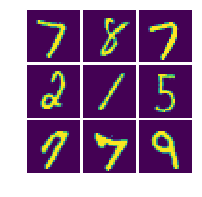

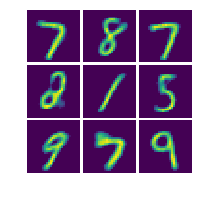

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:34 end epoch 199/300: average loss = 0.03257036250088975 (=0.019429+0.013141)

2018-05-07 22:54:34 start epoch 200/300, with learning rate = 0.0000179470
2018-05-07 22:54:34 iteration 1/859: current training loss = 0.033592 (=0.020018+0.013574)
2018-05-07 22:54:35 iteration 100/859: current training loss = 0.031973 (=0.018994+0.012979)
2018-05-07 22:54:36 iteration 200/859: current training loss = 0.031078 (=0.017905+0.013173)
2018-05-07 22:54:37 iteration 300/859: current training loss = 0.033841 (=0.020018+0.013823)
2018-05-07 22:54:37 iteration 400/859: current training loss = 0.032370 (=0.019186+0.013184)
2018-05-07 22:54:38 iteration 500/859: current training loss = 0.032340 (=0.019204+0.013137)
2018-05-07 22:54:39 iteration 600/859: current training loss = 0.031570 (=0.019005+0.012565)
2018-05-07 22:54:40 iteration 700/859: current training loss = 0.031759 (=0.018597+0.013162)
2018-05-07 22:54:40 iteration 800/859: cur

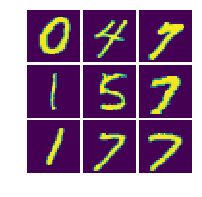

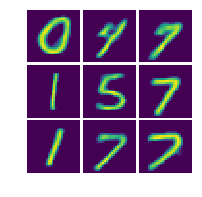

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:42 end epoch 200/300: average loss = 0.032550302944530984 (=0.019413+0.013137)

2018-05-07 22:54:42 start epoch 201/300, with learning rate = 0.0000175880
2018-05-07 22:54:42 iteration 1/859: current training loss = 0.034179 (=0.020654+0.013525)
2018-05-07 22:54:43 iteration 100/859: current training loss = 0.031785 (=0.018756+0.013029)
2018-05-07 22:54:44 iteration 200/859: current training loss = 0.033066 (=0.019582+0.013484)
2018-05-07 22:54:45 iteration 300/859: current training loss = 0.030175 (=0.017285+0.012890)
2018-05-07 22:54:45 iteration 400/859: current training loss = 0.033412 (=0.020390+0.013021)
2018-05-07 22:54:46 iteration 500/859: current training loss = 0.032436 (=0.019343+0.013093)
2018-05-07 22:54:47 iteration 600/859: current training loss = 0.034584 (=0.021133+0.013450)
2018-05-07 22:54:47 iteration 700/859: current training loss = 0.031353 (=0.018450+0.012903)
2018-05-07 22:54:48 iteration 800/859: cu

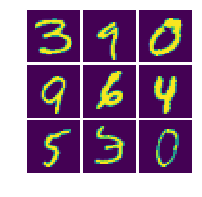

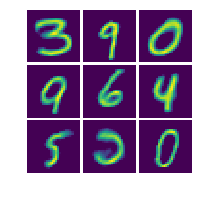

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:50 end epoch 201/300: average loss = 0.03256570136042288 (=0.019383+0.013182)

2018-05-07 22:54:50 start epoch 202/300, with learning rate = 0.0000172363
2018-05-07 22:54:50 iteration 1/859: current training loss = 0.031976 (=0.018902+0.013074)
2018-05-07 22:54:51 iteration 100/859: current training loss = 0.031681 (=0.018446+0.013235)
2018-05-07 22:54:51 iteration 200/859: current training loss = 0.033545 (=0.019835+0.013710)
2018-05-07 22:54:52 iteration 300/859: current training loss = 0.031173 (=0.018041+0.013131)
2018-05-07 22:54:53 iteration 400/859: current training loss = 0.031798 (=0.019085+0.012712)
2018-05-07 22:54:54 iteration 500/859: current training loss = 0.032049 (=0.018993+0.013056)
2018-05-07 22:54:55 iteration 600/859: current training loss = 0.034492 (=0.020923+0.013569)
2018-05-07 22:54:55 iteration 700/859: current training loss = 0.031323 (=0.018389+0.012933)
2018-05-07 22:54:56 iteration 800/859: cur

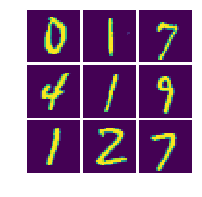

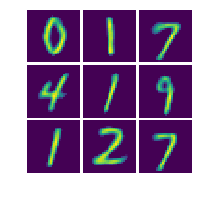

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:54:58 end epoch 202/300: average loss = 0.03258224613357409 (=0.019403+0.013179)

2018-05-07 22:54:58 start epoch 203/300, with learning rate = 0.0000168915
2018-05-07 22:54:58 iteration 1/859: current training loss = 0.033171 (=0.020090+0.013081)
2018-05-07 22:54:58 iteration 100/859: current training loss = 0.031869 (=0.018612+0.013258)
2018-05-07 22:54:59 iteration 200/859: current training loss = 0.031390 (=0.018454+0.012936)
2018-05-07 22:55:00 iteration 300/859: current training loss = 0.034792 (=0.021135+0.013657)
2018-05-07 22:55:01 iteration 400/859: current training loss = 0.031495 (=0.018336+0.013159)
2018-05-07 22:55:01 iteration 500/859: current training loss = 0.035396 (=0.022033+0.013363)
2018-05-07 22:55:02 iteration 600/859: current training loss = 0.031824 (=0.019062+0.012762)
2018-05-07 22:55:03 iteration 700/859: current training loss = 0.032819 (=0.019993+0.012826)
2018-05-07 22:55:04 iteration 800/859: cur

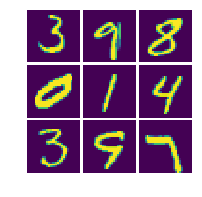

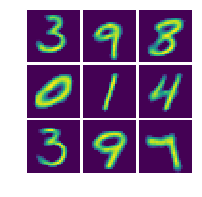

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:06 end epoch 203/300: average loss = 0.03254813087477465 (=0.019374+0.013174)

2018-05-07 22:55:06 start epoch 204/300, with learning rate = 0.0000165537
2018-05-07 22:55:06 iteration 1/859: current training loss = 0.033252 (=0.019663+0.013589)
2018-05-07 22:55:06 iteration 100/859: current training loss = 0.032812 (=0.019556+0.013256)
2018-05-07 22:55:07 iteration 200/859: current training loss = 0.034765 (=0.021157+0.013608)
2018-05-07 22:55:08 iteration 300/859: current training loss = 0.033456 (=0.020023+0.013433)
2018-05-07 22:55:09 iteration 400/859: current training loss = 0.032998 (=0.020250+0.012748)
2018-05-07 22:55:09 iteration 500/859: current training loss = 0.034244 (=0.020861+0.013383)
2018-05-07 22:55:10 iteration 600/859: current training loss = 0.031998 (=0.019067+0.012931)
2018-05-07 22:55:11 iteration 700/859: current training loss = 0.032588 (=0.019227+0.013360)
2018-05-07 22:55:12 iteration 800/859: cur

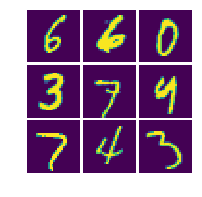

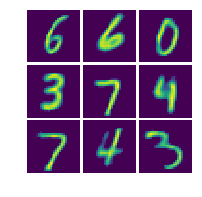

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:13 end epoch 204/300: average loss = 0.03255141783197767 (=0.019391+0.013161)

2018-05-07 22:55:13 start epoch 205/300, with learning rate = 0.0000162226
2018-05-07 22:55:13 iteration 1/859: current training loss = 0.034364 (=0.020913+0.013451)
2018-05-07 22:55:14 iteration 100/859: current training loss = 0.032075 (=0.018885+0.013190)
2018-05-07 22:55:15 iteration 200/859: current training loss = 0.032226 (=0.019134+0.013092)
2018-05-07 22:55:15 iteration 300/859: current training loss = 0.032700 (=0.019351+0.013348)
2018-05-07 22:55:16 iteration 400/859: current training loss = 0.031864 (=0.019045+0.012819)
2018-05-07 22:55:17 iteration 500/859: current training loss = 0.031452 (=0.018646+0.012806)
2018-05-07 22:55:18 iteration 600/859: current training loss = 0.031585 (=0.018258+0.013327)
2018-05-07 22:55:18 iteration 700/859: current training loss = 0.033124 (=0.019716+0.013408)
2018-05-07 22:55:19 iteration 800/859: cur

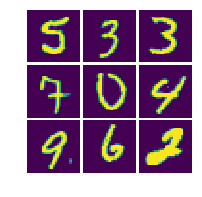

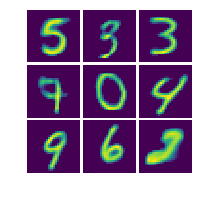

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:21 end epoch 205/300: average loss = 0.03254220087831456 (=0.019346+0.013196)

2018-05-07 22:55:21 start epoch 206/300, with learning rate = 0.0000158982
2018-05-07 22:55:21 iteration 1/859: current training loss = 0.029601 (=0.016889+0.012713)
2018-05-07 22:55:22 iteration 100/859: current training loss = 0.031741 (=0.018681+0.013060)
2018-05-07 22:55:23 iteration 200/859: current training loss = 0.029945 (=0.017628+0.012317)
2018-05-07 22:55:23 iteration 300/859: current training loss = 0.030135 (=0.017453+0.012681)
2018-05-07 22:55:24 iteration 400/859: current training loss = 0.032119 (=0.018596+0.013524)
2018-05-07 22:55:25 iteration 500/859: current training loss = 0.032402 (=0.018982+0.013420)
2018-05-07 22:55:26 iteration 600/859: current training loss = 0.033471 (=0.020538+0.012933)
2018-05-07 22:55:26 iteration 700/859: current training loss = 0.033095 (=0.019886+0.013208)
2018-05-07 22:55:27 iteration 800/859: cur

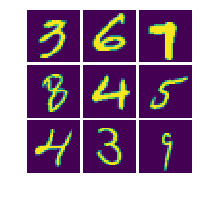

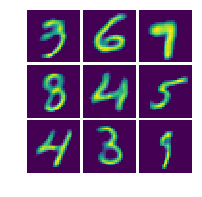

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:29 end epoch 206/300: average loss = 0.03250411672602224 (=0.019312+0.013193)

2018-05-07 22:55:29 start epoch 207/300, with learning rate = 0.0000155802
2018-05-07 22:55:29 iteration 1/859: current training loss = 0.032532 (=0.019371+0.013162)
2018-05-07 22:55:29 iteration 100/859: current training loss = 0.032389 (=0.018853+0.013537)
2018-05-07 22:55:30 iteration 200/859: current training loss = 0.031714 (=0.018982+0.012733)
2018-05-07 22:55:31 iteration 300/859: current training loss = 0.033998 (=0.020257+0.013741)
2018-05-07 22:55:32 iteration 400/859: current training loss = 0.032106 (=0.019359+0.012747)
2018-05-07 22:55:32 iteration 500/859: current training loss = 0.032158 (=0.019368+0.012790)
2018-05-07 22:55:33 iteration 600/859: current training loss = 0.033063 (=0.019955+0.013108)
2018-05-07 22:55:34 iteration 700/859: current training loss = 0.032426 (=0.019128+0.013298)
2018-05-07 22:55:35 iteration 800/859: cur

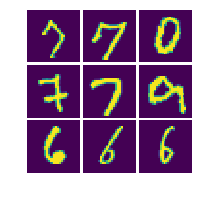

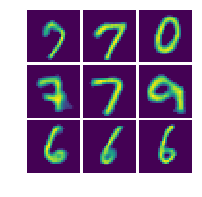

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:36 end epoch 207/300: average loss = 0.032497815876696104 (=0.019311+0.013187)

2018-05-07 22:55:36 start epoch 208/300, with learning rate = 0.0000152686
2018-05-07 22:55:36 iteration 1/859: current training loss = 0.032934 (=0.019752+0.013181)
2018-05-07 22:55:37 iteration 100/859: current training loss = 0.032397 (=0.019076+0.013321)
2018-05-07 22:55:38 iteration 200/859: current training loss = 0.034191 (=0.020362+0.013829)
2018-05-07 22:55:39 iteration 300/859: current training loss = 0.034847 (=0.021142+0.013705)
2018-05-07 22:55:40 iteration 400/859: current training loss = 0.031607 (=0.018771+0.012837)
2018-05-07 22:55:40 iteration 500/859: current training loss = 0.031939 (=0.018486+0.013453)
2018-05-07 22:55:41 iteration 600/859: current training loss = 0.033042 (=0.019757+0.013285)
2018-05-07 22:55:42 iteration 700/859: current training loss = 0.031920 (=0.018618+0.013303)
2018-05-07 22:55:43 iteration 800/859: cu

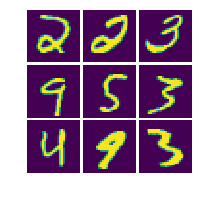

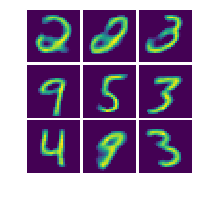

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:44 end epoch 208/300: average loss = 0.032526871104907935 (=0.019323+0.013204)

2018-05-07 22:55:44 start epoch 209/300, with learning rate = 0.0000149632
2018-05-07 22:55:44 iteration 1/859: current training loss = 0.032400 (=0.019241+0.013160)
2018-05-07 22:55:45 iteration 100/859: current training loss = 0.031780 (=0.018802+0.012978)
2018-05-07 22:55:46 iteration 200/859: current training loss = 0.034996 (=0.021270+0.013726)
2018-05-07 22:55:46 iteration 300/859: current training loss = 0.031632 (=0.018828+0.012804)
2018-05-07 22:55:47 iteration 400/859: current training loss = 0.033219 (=0.019411+0.013808)
2018-05-07 22:55:48 iteration 500/859: current training loss = 0.032018 (=0.018944+0.013074)
2018-05-07 22:55:49 iteration 600/859: current training loss = 0.032999 (=0.019236+0.013764)
2018-05-07 22:55:49 iteration 700/859: current training loss = 0.031634 (=0.019095+0.012538)
2018-05-07 22:55:50 iteration 800/859: cu

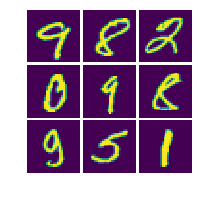

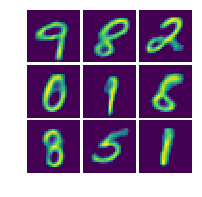

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:52 end epoch 209/300: average loss = 0.03250097161174098 (=0.019271+0.013230)

2018-05-07 22:55:52 start epoch 210/300, with learning rate = 0.0000146640
2018-05-07 22:55:52 iteration 1/859: current training loss = 0.033602 (=0.020095+0.013507)
2018-05-07 22:55:53 iteration 100/859: current training loss = 0.030419 (=0.017573+0.012847)
2018-05-07 22:55:53 iteration 200/859: current training loss = 0.031296 (=0.018678+0.012617)
2018-05-07 22:55:54 iteration 300/859: current training loss = 0.031127 (=0.018182+0.012946)
2018-05-07 22:55:55 iteration 400/859: current training loss = 0.034449 (=0.020529+0.013920)
2018-05-07 22:55:56 iteration 500/859: current training loss = 0.033093 (=0.020091+0.013002)
2018-05-07 22:55:56 iteration 600/859: current training loss = 0.032750 (=0.019243+0.013507)
2018-05-07 22:55:57 iteration 700/859: current training loss = 0.034025 (=0.020209+0.013816)
2018-05-07 22:55:58 iteration 800/859: cur

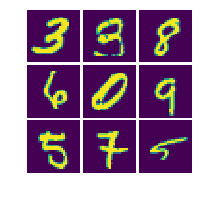

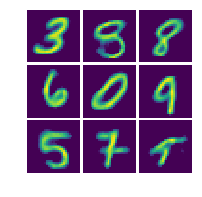

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:55:59 end epoch 210/300: average loss = 0.03246504933127702 (=0.019239+0.013226)

2018-05-07 22:55:59 start epoch 211/300, with learning rate = 0.0000143707
2018-05-07 22:56:00 iteration 1/859: current training loss = 0.034031 (=0.020558+0.013473)
2018-05-07 22:56:00 iteration 100/859: current training loss = 0.033660 (=0.020489+0.013171)
2018-05-07 22:56:01 iteration 200/859: current training loss = 0.030821 (=0.018109+0.012712)
2018-05-07 22:56:02 iteration 300/859: current training loss = 0.032100 (=0.019069+0.013030)
2018-05-07 22:56:03 iteration 400/859: current training loss = 0.033480 (=0.019966+0.013514)
2018-05-07 22:56:03 iteration 500/859: current training loss = 0.032637 (=0.019373+0.013264)
2018-05-07 22:56:04 iteration 600/859: current training loss = 0.034305 (=0.020642+0.013664)
2018-05-07 22:56:05 iteration 700/859: current training loss = 0.033305 (=0.019683+0.013622)
2018-05-07 22:56:06 iteration 800/859: cur

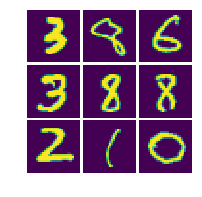

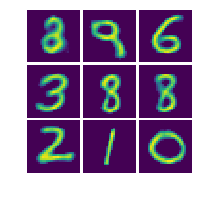

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:07 end epoch 211/300: average loss = 0.03243532412543425 (=0.019217+0.013219)

2018-05-07 22:56:07 start epoch 212/300, with learning rate = 0.0000140833
2018-05-07 22:56:07 iteration 1/859: current training loss = 0.031658 (=0.018795+0.012862)
2018-05-07 22:56:08 iteration 100/859: current training loss = 0.031245 (=0.018219+0.013026)
2018-05-07 22:56:09 iteration 200/859: current training loss = 0.033355 (=0.020006+0.013350)
2018-05-07 22:56:10 iteration 300/859: current training loss = 0.031959 (=0.018960+0.012999)
2018-05-07 22:56:10 iteration 400/859: current training loss = 0.031910 (=0.018927+0.012982)
2018-05-07 22:56:11 iteration 500/859: current training loss = 0.031650 (=0.018618+0.013032)
2018-05-07 22:56:12 iteration 600/859: current training loss = 0.029563 (=0.017211+0.012352)
2018-05-07 22:56:13 iteration 700/859: current training loss = 0.032720 (=0.019114+0.013606)
2018-05-07 22:56:13 iteration 800/859: cur

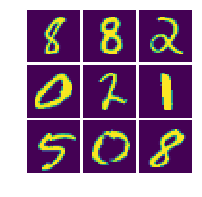

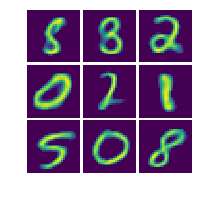

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:15 end epoch 212/300: average loss = 0.03241872345774984 (=0.019185+0.013234)

2018-05-07 22:56:15 start epoch 213/300, with learning rate = 0.0000138016
2018-05-07 22:56:15 iteration 1/859: current training loss = 0.032788 (=0.019386+0.013402)
2018-05-07 22:56:16 iteration 100/859: current training loss = 0.032072 (=0.019726+0.012346)
2018-05-07 22:56:17 iteration 200/859: current training loss = 0.032271 (=0.019229+0.013042)
2018-05-07 22:56:17 iteration 300/859: current training loss = 0.032898 (=0.019456+0.013442)
2018-05-07 22:56:18 iteration 400/859: current training loss = 0.033768 (=0.020042+0.013726)
2018-05-07 22:56:19 iteration 500/859: current training loss = 0.032835 (=0.019593+0.013242)
2018-05-07 22:56:20 iteration 600/859: current training loss = 0.033617 (=0.019864+0.013753)
2018-05-07 22:56:20 iteration 700/859: current training loss = 0.030270 (=0.017253+0.013017)
2018-05-07 22:56:21 iteration 800/859: cur

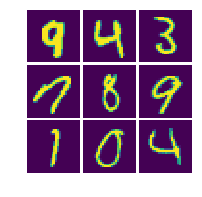

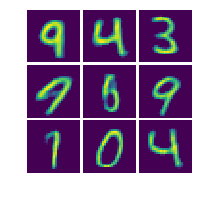

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:23 end epoch 213/300: average loss = 0.03247262767111672 (=0.019239+0.013233)

2018-05-07 22:56:23 start epoch 214/300, with learning rate = 0.0000135256
2018-05-07 22:56:23 iteration 1/859: current training loss = 0.032866 (=0.019215+0.013651)
2018-05-07 22:56:23 iteration 100/859: current training loss = 0.031541 (=0.018828+0.012713)
2018-05-07 22:56:24 iteration 200/859: current training loss = 0.031323 (=0.018674+0.012649)
2018-05-07 22:56:25 iteration 300/859: current training loss = 0.031888 (=0.019026+0.012863)
2018-05-07 22:56:26 iteration 400/859: current training loss = 0.031954 (=0.018637+0.013317)
2018-05-07 22:56:26 iteration 500/859: current training loss = 0.034279 (=0.020767+0.013513)
2018-05-07 22:56:27 iteration 600/859: current training loss = 0.033436 (=0.019980+0.013456)
2018-05-07 22:56:28 iteration 700/859: current training loss = 0.031325 (=0.018641+0.012685)
2018-05-07 22:56:29 iteration 800/859: cur

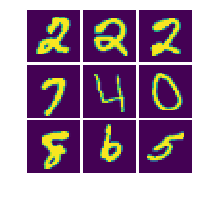

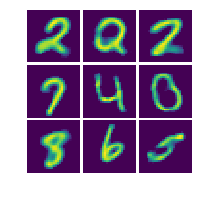

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:30 end epoch 214/300: average loss = 0.03237234003087278 (=0.019133+0.013239)

2018-05-07 22:56:30 start epoch 215/300, with learning rate = 0.0000132551
2018-05-07 22:56:30 iteration 1/859: current training loss = 0.032698 (=0.019274+0.013424)
2018-05-07 22:56:31 iteration 100/859: current training loss = 0.033466 (=0.019957+0.013510)
2018-05-07 22:56:32 iteration 200/859: current training loss = 0.033485 (=0.020269+0.013216)
2018-05-07 22:56:33 iteration 300/859: current training loss = 0.031380 (=0.018404+0.012976)
2018-05-07 22:56:33 iteration 400/859: current training loss = 0.032946 (=0.019695+0.013251)
2018-05-07 22:56:34 iteration 500/859: current training loss = 0.030866 (=0.017638+0.013228)
2018-05-07 22:56:35 iteration 600/859: current training loss = 0.033321 (=0.019497+0.013824)
2018-05-07 22:56:36 iteration 700/859: current training loss = 0.033035 (=0.019137+0.013898)
2018-05-07 22:56:36 iteration 800/859: cur

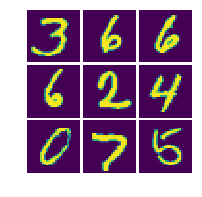

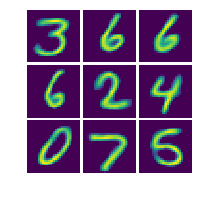

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:38 end epoch 215/300: average loss = 0.03245491168664484 (=0.019201+0.013254)

2018-05-07 22:56:38 start epoch 216/300, with learning rate = 0.0000129900
2018-05-07 22:56:38 iteration 1/859: current training loss = 0.033311 (=0.019796+0.013515)
2018-05-07 22:56:39 iteration 100/859: current training loss = 0.032976 (=0.019490+0.013486)
2018-05-07 22:56:40 iteration 200/859: current training loss = 0.032057 (=0.018875+0.013182)
2018-05-07 22:56:40 iteration 300/859: current training loss = 0.030961 (=0.018015+0.012946)
2018-05-07 22:56:41 iteration 400/859: current training loss = 0.031757 (=0.018457+0.013299)
2018-05-07 22:56:42 iteration 500/859: current training loss = 0.030253 (=0.017371+0.012882)
2018-05-07 22:56:43 iteration 600/859: current training loss = 0.029782 (=0.016983+0.012799)
2018-05-07 22:56:43 iteration 700/859: current training loss = 0.032788 (=0.019586+0.013201)
2018-05-07 22:56:44 iteration 800/859: cur

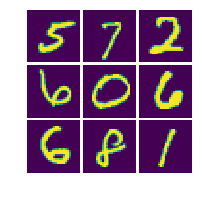

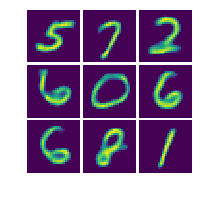

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:46 end epoch 216/300: average loss = 0.032372354327053765 (=0.019116+0.013256)

2018-05-07 22:56:46 start epoch 217/300, with learning rate = 0.0000127302
2018-05-07 22:56:46 iteration 1/859: current training loss = 0.035150 (=0.020956+0.014193)
2018-05-07 22:56:47 iteration 100/859: current training loss = 0.031521 (=0.018196+0.013326)
2018-05-07 22:56:47 iteration 200/859: current training loss = 0.031845 (=0.019089+0.012756)
2018-05-07 22:56:48 iteration 300/859: current training loss = 0.032394 (=0.019022+0.013372)
2018-05-07 22:56:49 iteration 400/859: current training loss = 0.030091 (=0.017334+0.012757)
2018-05-07 22:56:50 iteration 500/859: current training loss = 0.034527 (=0.020795+0.013732)
2018-05-07 22:56:50 iteration 600/859: current training loss = 0.036365 (=0.022131+0.014234)
2018-05-07 22:56:51 iteration 700/859: current training loss = 0.034195 (=0.021034+0.013161)
2018-05-07 22:56:52 iteration 800/859: cu

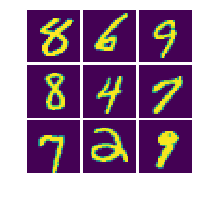

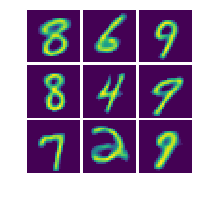

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:56:54 end epoch 217/300: average loss = 0.03234632061284829 (=0.019075+0.013271)

2018-05-07 22:56:54 start epoch 218/300, with learning rate = 0.0000124756
2018-05-07 22:56:54 iteration 1/859: current training loss = 0.033577 (=0.020175+0.013402)
2018-05-07 22:56:55 iteration 100/859: current training loss = 0.031987 (=0.018721+0.013265)
2018-05-07 22:56:55 iteration 200/859: current training loss = 0.033940 (=0.020144+0.013795)
2018-05-07 22:56:56 iteration 300/859: current training loss = 0.031826 (=0.018760+0.013066)
2018-05-07 22:56:57 iteration 400/859: current training loss = 0.032000 (=0.018899+0.013101)
2018-05-07 22:56:58 iteration 500/859: current training loss = 0.032598 (=0.019060+0.013539)
2018-05-07 22:56:58 iteration 600/859: current training loss = 0.032047 (=0.018808+0.013239)
2018-05-07 22:56:59 iteration 700/859: current training loss = 0.032779 (=0.019729+0.013050)
2018-05-07 22:57:00 iteration 800/859: cur

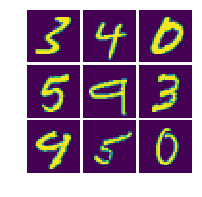

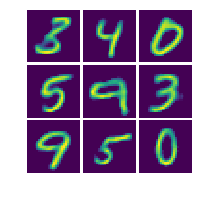

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:02 end epoch 218/300: average loss = 0.03232823086987066 (=0.019077+0.013251)

2018-05-07 22:57:02 start epoch 219/300, with learning rate = 0.0000122261
2018-05-07 22:57:02 iteration 1/859: current training loss = 0.033141 (=0.019529+0.013612)
2018-05-07 22:57:02 iteration 100/859: current training loss = 0.032747 (=0.019380+0.013367)
2018-05-07 22:57:03 iteration 200/859: current training loss = 0.031184 (=0.018002+0.013183)
2018-05-07 22:57:04 iteration 300/859: current training loss = 0.031473 (=0.018675+0.012798)
2018-05-07 22:57:05 iteration 400/859: current training loss = 0.030186 (=0.017554+0.012631)
2018-05-07 22:57:05 iteration 500/859: current training loss = 0.030972 (=0.017349+0.013623)
2018-05-07 22:57:06 iteration 600/859: current training loss = 0.031463 (=0.018673+0.012790)
2018-05-07 22:57:07 iteration 700/859: current training loss = 0.030695 (=0.017714+0.012981)
2018-05-07 22:57:08 iteration 800/859: cur

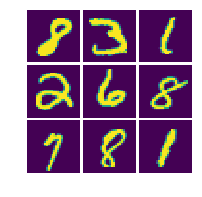

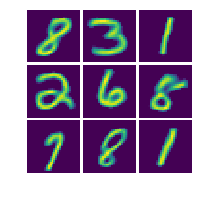

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:09 end epoch 219/300: average loss = 0.03238943234797268 (=0.019121+0.013268)

2018-05-07 22:57:09 start epoch 220/300, with learning rate = 0.0000119815
2018-05-07 22:57:09 iteration 1/859: current training loss = 0.031319 (=0.018379+0.012941)
2018-05-07 22:57:10 iteration 100/859: current training loss = 0.030702 (=0.018242+0.012460)
2018-05-07 22:57:11 iteration 200/859: current training loss = 0.032373 (=0.018823+0.013550)
2018-05-07 22:57:11 iteration 300/859: current training loss = 0.034180 (=0.020441+0.013739)
2018-05-07 22:57:12 iteration 400/859: current training loss = 0.032129 (=0.019197+0.012931)
2018-05-07 22:57:13 iteration 500/859: current training loss = 0.032139 (=0.018964+0.013174)
2018-05-07 22:57:14 iteration 600/859: current training loss = 0.030982 (=0.018080+0.012902)
2018-05-07 22:57:14 iteration 700/859: current training loss = 0.029517 (=0.016886+0.012631)
2018-05-07 22:57:15 iteration 800/859: cur

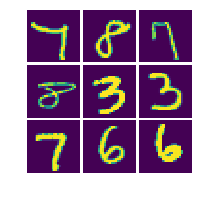

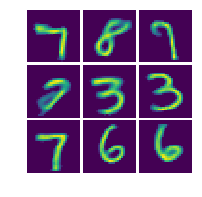

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:17 end epoch 220/300: average loss = 0.03234940905414513 (=0.019089+0.013261)

2018-05-07 22:57:17 start epoch 221/300, with learning rate = 0.0000117419
2018-05-07 22:57:17 iteration 1/859: current training loss = 0.033401 (=0.020168+0.013233)
2018-05-07 22:57:18 iteration 100/859: current training loss = 0.031840 (=0.019133+0.012707)
2018-05-07 22:57:18 iteration 200/859: current training loss = 0.031738 (=0.018907+0.012832)
2018-05-07 22:57:19 iteration 300/859: current training loss = 0.032954 (=0.019194+0.013760)
2018-05-07 22:57:20 iteration 400/859: current training loss = 0.032877 (=0.019364+0.013513)
2018-05-07 22:57:20 iteration 500/859: current training loss = 0.032671 (=0.019257+0.013414)
2018-05-07 22:57:21 iteration 600/859: current training loss = 0.030557 (=0.017582+0.012975)
2018-05-07 22:57:22 iteration 700/859: current training loss = 0.033081 (=0.020591+0.012490)
2018-05-07 22:57:23 iteration 800/859: cur

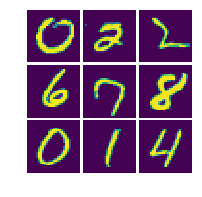

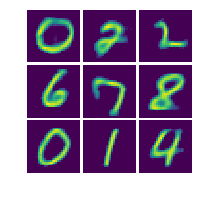

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:24 end epoch 221/300: average loss = 0.0322907781781362 (=0.019018+0.013273)

2018-05-07 22:57:24 start epoch 222/300, with learning rate = 0.0000115071
2018-05-07 22:57:24 iteration 1/859: current training loss = 0.034186 (=0.020289+0.013897)
2018-05-07 22:57:25 iteration 100/859: current training loss = 0.033223 (=0.019741+0.013482)
2018-05-07 22:57:26 iteration 200/859: current training loss = 0.030386 (=0.017652+0.012734)
2018-05-07 22:57:27 iteration 300/859: current training loss = 0.034360 (=0.020382+0.013978)
2018-05-07 22:57:28 iteration 400/859: current training loss = 0.031113 (=0.018329+0.012784)
2018-05-07 22:57:28 iteration 500/859: current training loss = 0.032416 (=0.019493+0.012923)
2018-05-07 22:57:29 iteration 600/859: current training loss = 0.030561 (=0.017359+0.013201)
2018-05-07 22:57:30 iteration 700/859: current training loss = 0.029984 (=0.017053+0.012931)
2018-05-07 22:57:31 iteration 800/859: curr

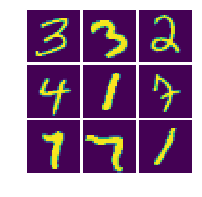

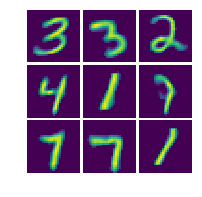

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:32 end epoch 222/300: average loss = 0.032318331305549085 (=0.019041+0.013278)

2018-05-07 22:57:32 start epoch 223/300, with learning rate = 0.0000112769
2018-05-07 22:57:32 iteration 1/859: current training loss = 0.031567 (=0.018545+0.013022)
2018-05-07 22:57:33 iteration 100/859: current training loss = 0.032209 (=0.018800+0.013408)
2018-05-07 22:57:34 iteration 200/859: current training loss = 0.033352 (=0.019801+0.013551)
2018-05-07 22:57:34 iteration 300/859: current training loss = 0.032860 (=0.019182+0.013678)
2018-05-07 22:57:35 iteration 400/859: current training loss = 0.029790 (=0.016826+0.012964)
2018-05-07 22:57:36 iteration 500/859: current training loss = 0.032310 (=0.019194+0.013116)
2018-05-07 22:57:37 iteration 600/859: current training loss = 0.031518 (=0.018523+0.012995)
2018-05-07 22:57:37 iteration 700/859: current training loss = 0.032926 (=0.019867+0.013059)
2018-05-07 22:57:38 iteration 800/859: cu

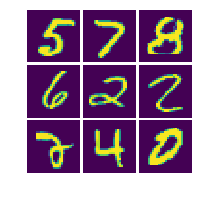

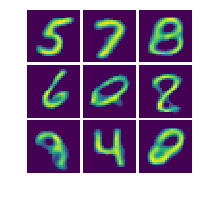

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:40 end epoch 223/300: average loss = 0.03224715354990071 (=0.018983+0.013264)

2018-05-07 22:57:40 start epoch 224/300, with learning rate = 0.0000110514
2018-05-07 22:57:40 iteration 1/859: current training loss = 0.032809 (=0.019135+0.013673)
2018-05-07 22:57:41 iteration 100/859: current training loss = 0.030838 (=0.017877+0.012961)
2018-05-07 22:57:41 iteration 200/859: current training loss = 0.033600 (=0.020078+0.013523)
2018-05-07 22:57:42 iteration 300/859: current training loss = 0.031984 (=0.019010+0.012974)
2018-05-07 22:57:43 iteration 400/859: current training loss = 0.030937 (=0.018289+0.012648)
2018-05-07 22:57:44 iteration 500/859: current training loss = 0.031828 (=0.018611+0.013216)
2018-05-07 22:57:44 iteration 600/859: current training loss = 0.031930 (=0.018948+0.012982)
2018-05-07 22:57:45 iteration 700/859: current training loss = 0.032711 (=0.019399+0.013313)
2018-05-07 22:57:46 iteration 800/859: cur

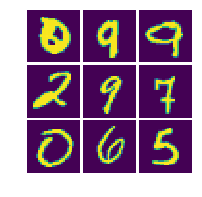

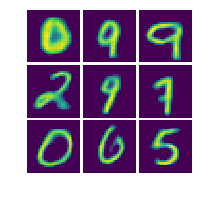

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:47 end epoch 224/300: average loss = 0.03232085426599308 (=0.019033+0.013288)

2018-05-07 22:57:47 start epoch 225/300, with learning rate = 0.0000108304
2018-05-07 22:57:47 iteration 1/859: current training loss = 0.032593 (=0.019208+0.013384)
2018-05-07 22:57:48 iteration 100/859: current training loss = 0.031517 (=0.018450+0.013067)
2018-05-07 22:57:49 iteration 200/859: current training loss = 0.029654 (=0.017159+0.012495)
2018-05-07 22:57:50 iteration 300/859: current training loss = 0.029888 (=0.017236+0.012651)
2018-05-07 22:57:51 iteration 400/859: current training loss = 0.033204 (=0.019717+0.013487)
2018-05-07 22:57:51 iteration 500/859: current training loss = 0.033847 (=0.019908+0.013939)
2018-05-07 22:57:52 iteration 600/859: current training loss = 0.032621 (=0.019367+0.013255)
2018-05-07 22:57:53 iteration 700/859: current training loss = 0.034209 (=0.020337+0.013872)
2018-05-07 22:57:54 iteration 800/859: cur

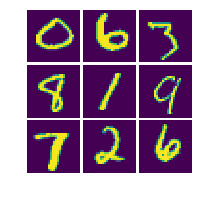

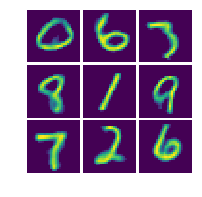

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:57:55 end epoch 225/300: average loss = 0.032270293509342615 (=0.019001+0.013269)

2018-05-07 22:57:55 start epoch 226/300, with learning rate = 0.0000106138
2018-05-07 22:57:55 iteration 1/859: current training loss = 0.031785 (=0.018711+0.013075)
2018-05-07 22:57:56 iteration 100/859: current training loss = 0.033520 (=0.019979+0.013542)
2018-05-07 22:57:57 iteration 200/859: current training loss = 0.031572 (=0.018459+0.013113)
2018-05-07 22:57:58 iteration 300/859: current training loss = 0.032088 (=0.018951+0.013136)
2018-05-07 22:57:58 iteration 400/859: current training loss = 0.032245 (=0.019151+0.013094)
2018-05-07 22:57:59 iteration 500/859: current training loss = 0.032865 (=0.019660+0.013205)
2018-05-07 22:58:00 iteration 600/859: current training loss = 0.031448 (=0.018734+0.012714)
2018-05-07 22:58:00 iteration 700/859: current training loss = 0.032330 (=0.019123+0.013207)
2018-05-07 22:58:01 iteration 800/859: cu

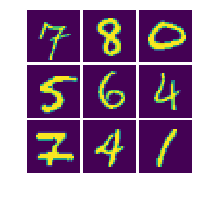

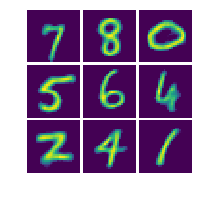

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:03 end epoch 226/300: average loss = 0.03229286272091763 (=0.019011+0.013282)

2018-05-07 22:58:03 start epoch 227/300, with learning rate = 0.0000104015
2018-05-07 22:58:03 iteration 1/859: current training loss = 0.029260 (=0.016979+0.012281)
2018-05-07 22:58:04 iteration 100/859: current training loss = 0.034962 (=0.020473+0.014489)
2018-05-07 22:58:04 iteration 200/859: current training loss = 0.033111 (=0.019393+0.013718)
2018-05-07 22:58:05 iteration 300/859: current training loss = 0.032107 (=0.018953+0.013154)
2018-05-07 22:58:06 iteration 400/859: current training loss = 0.033517 (=0.019795+0.013722)
2018-05-07 22:58:07 iteration 500/859: current training loss = 0.030778 (=0.018031+0.012748)
2018-05-07 22:58:08 iteration 600/859: current training loss = 0.031939 (=0.018768+0.013171)
2018-05-07 22:58:08 iteration 700/859: current training loss = 0.032657 (=0.019362+0.013296)
2018-05-07 22:58:09 iteration 800/859: cur

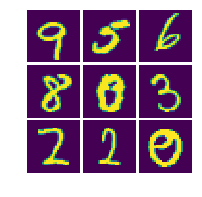

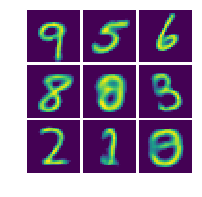

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:11 end epoch 227/300: average loss = 0.03227727013673716 (=0.018995+0.013283)

2018-05-07 22:58:11 start epoch 228/300, with learning rate = 0.0000101934
2018-05-07 22:58:11 iteration 1/859: current training loss = 0.032813 (=0.019770+0.013042)
2018-05-07 22:58:11 iteration 100/859: current training loss = 0.031922 (=0.018624+0.013298)
2018-05-07 22:58:12 iteration 200/859: current training loss = 0.031750 (=0.018244+0.013506)
2018-05-07 22:58:13 iteration 300/859: current training loss = 0.029839 (=0.017226+0.012614)
2018-05-07 22:58:14 iteration 400/859: current training loss = 0.032741 (=0.019311+0.013430)
2018-05-07 22:58:14 iteration 500/859: current training loss = 0.031253 (=0.018043+0.013210)
2018-05-07 22:58:15 iteration 600/859: current training loss = 0.033344 (=0.019575+0.013769)
2018-05-07 22:58:16 iteration 700/859: current training loss = 0.033386 (=0.019983+0.013403)
2018-05-07 22:58:17 iteration 800/859: cur

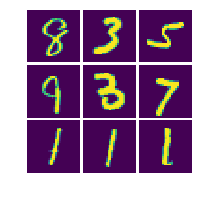

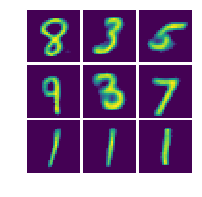

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:18 end epoch 228/300: average loss = 0.03226486614951918 (=0.018979+0.013286)

2018-05-07 22:58:18 start epoch 229/300, with learning rate = 0.0000099896
2018-05-07 22:58:18 iteration 1/859: current training loss = 0.033241 (=0.019436+0.013806)
2018-05-07 22:58:19 iteration 100/859: current training loss = 0.031439 (=0.018390+0.013049)
2018-05-07 22:58:20 iteration 200/859: current training loss = 0.031090 (=0.017822+0.013268)
2018-05-07 22:58:21 iteration 300/859: current training loss = 0.031758 (=0.018352+0.013406)
2018-05-07 22:58:21 iteration 400/859: current training loss = 0.030880 (=0.017865+0.013015)
2018-05-07 22:58:22 iteration 500/859: current training loss = 0.029889 (=0.016550+0.013339)
2018-05-07 22:58:23 iteration 600/859: current training loss = 0.030526 (=0.017517+0.013009)
2018-05-07 22:58:24 iteration 700/859: current training loss = 0.032335 (=0.019065+0.013270)
2018-05-07 22:58:24 iteration 800/859: cur

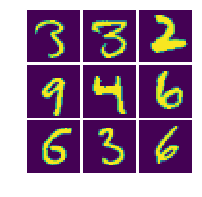

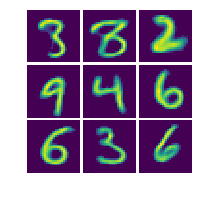

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:26 end epoch 229/300: average loss = 0.032313625327158584 (=0.019017+0.013297)

2018-05-07 22:58:26 start epoch 230/300, with learning rate = 0.0000097898
2018-05-07 22:58:26 iteration 1/859: current training loss = 0.030074 (=0.017236+0.012839)
2018-05-07 22:58:27 iteration 100/859: current training loss = 0.034802 (=0.020848+0.013954)
2018-05-07 22:58:27 iteration 200/859: current training loss = 0.031458 (=0.018248+0.013209)
2018-05-07 22:58:28 iteration 300/859: current training loss = 0.033785 (=0.020034+0.013751)
2018-05-07 22:58:29 iteration 400/859: current training loss = 0.033605 (=0.019899+0.013706)
2018-05-07 22:58:30 iteration 500/859: current training loss = 0.032049 (=0.019350+0.012699)
2018-05-07 22:58:30 iteration 600/859: current training loss = 0.030535 (=0.017551+0.012984)
2018-05-07 22:58:31 iteration 700/859: current training loss = 0.032575 (=0.019216+0.013359)
2018-05-07 22:58:32 iteration 800/859: cu

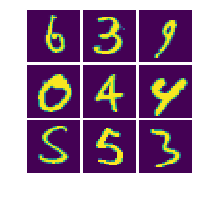

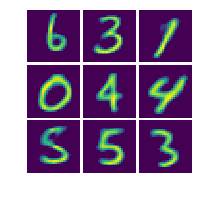

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:33 end epoch 230/300: average loss = 0.03223501041973914 (=0.018955+0.013280)

2018-05-07 22:58:33 start epoch 231/300, with learning rate = 0.0000095940
2018-05-07 22:58:33 iteration 1/859: current training loss = 0.031762 (=0.018529+0.013232)
2018-05-07 22:58:34 iteration 100/859: current training loss = 0.033197 (=0.019782+0.013415)
2018-05-07 22:58:35 iteration 200/859: current training loss = 0.032957 (=0.019522+0.013436)
2018-05-07 22:58:36 iteration 300/859: current training loss = 0.031827 (=0.018362+0.013464)
2018-05-07 22:58:37 iteration 400/859: current training loss = 0.033482 (=0.020335+0.013148)
2018-05-07 22:58:37 iteration 500/859: current training loss = 0.029902 (=0.016612+0.013290)
2018-05-07 22:58:38 iteration 600/859: current training loss = 0.031258 (=0.017616+0.013643)
2018-05-07 22:58:39 iteration 700/859: current training loss = 0.031718 (=0.018355+0.013363)
2018-05-07 22:58:40 iteration 800/859: cur

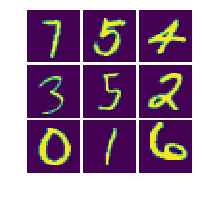

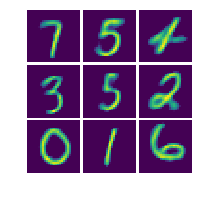

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:41 end epoch 231/300: average loss = 0.032277917463388796 (=0.018998+0.013280)

2018-05-07 22:58:41 start epoch 232/300, with learning rate = 0.0000094021
2018-05-07 22:58:41 iteration 1/859: current training loss = 0.032946 (=0.019124+0.013822)
2018-05-07 22:58:42 iteration 100/859: current training loss = 0.033902 (=0.020466+0.013435)
2018-05-07 22:58:43 iteration 200/859: current training loss = 0.031928 (=0.018876+0.013052)
2018-05-07 22:58:44 iteration 300/859: current training loss = 0.033070 (=0.019350+0.013721)
2018-05-07 22:58:44 iteration 400/859: current training loss = 0.033814 (=0.019773+0.014041)
2018-05-07 22:58:45 iteration 500/859: current training loss = 0.030382 (=0.017521+0.012861)
2018-05-07 22:58:46 iteration 600/859: current training loss = 0.031448 (=0.018309+0.013139)
2018-05-07 22:58:46 iteration 700/859: current training loss = 0.034219 (=0.020285+0.013934)
2018-05-07 22:58:47 iteration 800/859: cu

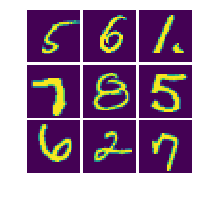

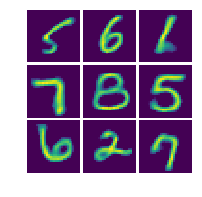

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:49 end epoch 232/300: average loss = 0.032226473784748556 (=0.018941+0.013286)

2018-05-07 22:58:49 start epoch 233/300, with learning rate = 0.0000092141
2018-05-07 22:58:49 iteration 1/859: current training loss = 0.031857 (=0.018144+0.013713)
2018-05-07 22:58:50 iteration 100/859: current training loss = 0.031555 (=0.018765+0.012791)
2018-05-07 22:58:50 iteration 200/859: current training loss = 0.031665 (=0.018537+0.013128)
2018-05-07 22:58:51 iteration 300/859: current training loss = 0.032851 (=0.019196+0.013655)
2018-05-07 22:58:52 iteration 400/859: current training loss = 0.031006 (=0.017876+0.013130)
2018-05-07 22:58:53 iteration 500/859: current training loss = 0.029650 (=0.016986+0.012663)
2018-05-07 22:58:53 iteration 600/859: current training loss = 0.033526 (=0.019962+0.013564)
2018-05-07 22:58:54 iteration 700/859: current training loss = 0.032540 (=0.018904+0.013636)
2018-05-07 22:58:55 iteration 800/859: cu

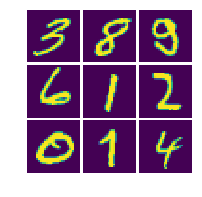

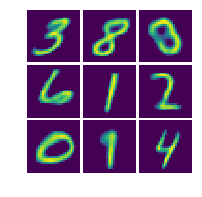

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:58:57 end epoch 233/300: average loss = 0.03223674991346974 (=0.018933+0.013303)

2018-05-07 22:58:57 start epoch 234/300, with learning rate = 0.0000090298
2018-05-07 22:58:57 iteration 1/859: current training loss = 0.034688 (=0.020951+0.013737)
2018-05-07 22:58:57 iteration 100/859: current training loss = 0.031324 (=0.017859+0.013464)
2018-05-07 22:58:58 iteration 200/859: current training loss = 0.029581 (=0.016737+0.012844)
2018-05-07 22:58:59 iteration 300/859: current training loss = 0.031854 (=0.018520+0.013335)
2018-05-07 22:59:00 iteration 400/859: current training loss = 0.030901 (=0.017841+0.013060)
2018-05-07 22:59:00 iteration 500/859: current training loss = 0.032984 (=0.019417+0.013567)
2018-05-07 22:59:01 iteration 600/859: current training loss = 0.031376 (=0.018287+0.013089)
2018-05-07 22:59:02 iteration 700/859: current training loss = 0.032664 (=0.019565+0.013098)
2018-05-07 22:59:03 iteration 800/859: cur

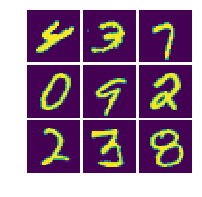

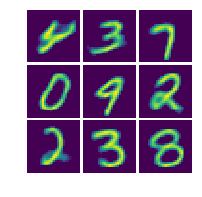

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:04 end epoch 234/300: average loss = 0.03219058061922804 (=0.018902+0.013289)

2018-05-07 22:59:04 start epoch 235/300, with learning rate = 0.0000088492
2018-05-07 22:59:04 iteration 1/859: current training loss = 0.032860 (=0.019441+0.013419)
2018-05-07 22:59:05 iteration 100/859: current training loss = 0.032345 (=0.018854+0.013491)
2018-05-07 22:59:06 iteration 200/859: current training loss = 0.033391 (=0.019576+0.013814)
2018-05-07 22:59:06 iteration 300/859: current training loss = 0.031376 (=0.018146+0.013230)
2018-05-07 22:59:07 iteration 400/859: current training loss = 0.032654 (=0.019442+0.013212)
2018-05-07 22:59:08 iteration 500/859: current training loss = 0.033108 (=0.019551+0.013557)
2018-05-07 22:59:09 iteration 600/859: current training loss = 0.030863 (=0.017376+0.013486)
2018-05-07 22:59:09 iteration 700/859: current training loss = 0.031627 (=0.018612+0.013015)
2018-05-07 22:59:10 iteration 800/859: cur

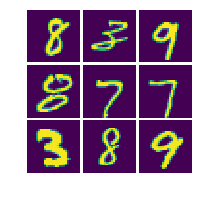

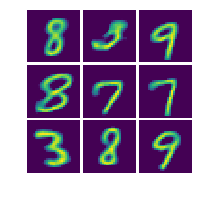

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:12 end epoch 235/300: average loss = 0.032230657532949944 (=0.018926+0.013305)

2018-05-07 22:59:12 start epoch 236/300, with learning rate = 0.0000086722
2018-05-07 22:59:12 iteration 1/859: current training loss = 0.031376 (=0.018116+0.013260)
2018-05-07 22:59:13 iteration 100/859: current training loss = 0.028462 (=0.016068+0.012394)
2018-05-07 22:59:13 iteration 200/859: current training loss = 0.034459 (=0.020759+0.013700)
2018-05-07 22:59:14 iteration 300/859: current training loss = 0.032504 (=0.019111+0.013393)
2018-05-07 22:59:15 iteration 400/859: current training loss = 0.031548 (=0.018524+0.013024)
2018-05-07 22:59:16 iteration 500/859: current training loss = 0.031421 (=0.018129+0.013291)
2018-05-07 22:59:16 iteration 600/859: current training loss = 0.031986 (=0.018689+0.013296)
2018-05-07 22:59:17 iteration 700/859: current training loss = 0.031995 (=0.018776+0.013219)
2018-05-07 22:59:18 iteration 800/859: cu

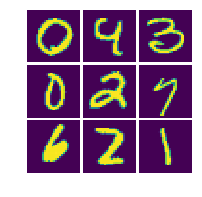

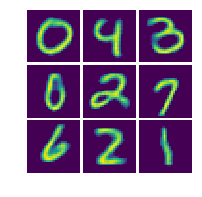

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:19 end epoch 236/300: average loss = 0.032222073076334075 (=0.018918+0.013304)

2018-05-07 22:59:19 start epoch 237/300, with learning rate = 0.0000084988
2018-05-07 22:59:19 iteration 1/859: current training loss = 0.033843 (=0.020557+0.013285)
2018-05-07 22:59:20 iteration 100/859: current training loss = 0.031340 (=0.018413+0.012928)
2018-05-07 22:59:21 iteration 200/859: current training loss = 0.031968 (=0.018260+0.013708)
2018-05-07 22:59:21 iteration 300/859: current training loss = 0.033845 (=0.020234+0.013611)
2018-05-07 22:59:22 iteration 400/859: current training loss = 0.033473 (=0.019867+0.013606)
2018-05-07 22:59:23 iteration 500/859: current training loss = 0.030928 (=0.017484+0.013444)
2018-05-07 22:59:24 iteration 600/859: current training loss = 0.030765 (=0.017841+0.012925)
2018-05-07 22:59:24 iteration 700/859: current training loss = 0.031722 (=0.018755+0.012967)
2018-05-07 22:59:25 iteration 800/859: cu

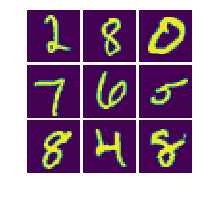

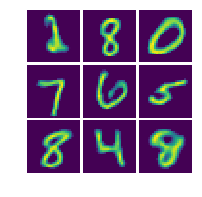

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:27 end epoch 237/300: average loss = 0.032202867660953365 (=0.018914+0.013289)

2018-05-07 22:59:27 start epoch 238/300, with learning rate = 0.0000083288
2018-05-07 22:59:27 iteration 1/859: current training loss = 0.031995 (=0.018649+0.013346)
2018-05-07 22:59:27 iteration 100/859: current training loss = 0.031811 (=0.018640+0.013171)
2018-05-07 22:59:28 iteration 200/859: current training loss = 0.031933 (=0.019128+0.012805)
2018-05-07 22:59:29 iteration 300/859: current training loss = 0.032789 (=0.019125+0.013664)
2018-05-07 22:59:30 iteration 400/859: current training loss = 0.032917 (=0.019288+0.013630)
2018-05-07 22:59:30 iteration 500/859: current training loss = 0.033045 (=0.019705+0.013340)
2018-05-07 22:59:31 iteration 600/859: current training loss = 0.034103 (=0.020274+0.013828)
2018-05-07 22:59:32 iteration 700/859: current training loss = 0.034049 (=0.020208+0.013840)
2018-05-07 22:59:33 iteration 800/859: cu

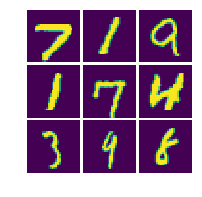

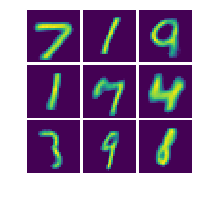

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:34 end epoch 238/300: average loss = 0.0321729736157603 (=0.018871+0.013302)

2018-05-07 22:59:34 start epoch 239/300, with learning rate = 0.0000081622
2018-05-07 22:59:34 iteration 1/859: current training loss = 0.031078 (=0.018376+0.012702)
2018-05-07 22:59:35 iteration 100/859: current training loss = 0.031976 (=0.018876+0.013100)
2018-05-07 22:59:36 iteration 200/859: current training loss = 0.033629 (=0.020191+0.013438)
2018-05-07 22:59:37 iteration 300/859: current training loss = 0.032006 (=0.018440+0.013566)
2018-05-07 22:59:37 iteration 400/859: current training loss = 0.033177 (=0.019621+0.013556)
2018-05-07 22:59:38 iteration 500/859: current training loss = 0.034235 (=0.020041+0.014194)
2018-05-07 22:59:39 iteration 600/859: current training loss = 0.032483 (=0.019126+0.013357)
2018-05-07 22:59:39 iteration 700/859: current training loss = 0.033664 (=0.020117+0.013547)
2018-05-07 22:59:40 iteration 800/859: curr

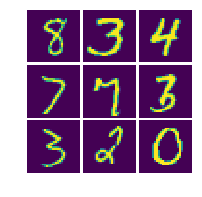

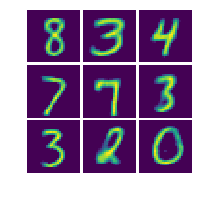

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:42 end epoch 239/300: average loss = 0.03220199485882961 (=0.018907+0.013295)

2018-05-07 22:59:42 start epoch 240/300, with learning rate = 0.0000079990
2018-05-07 22:59:42 iteration 1/859: current training loss = 0.032323 (=0.018852+0.013471)
2018-05-07 22:59:43 iteration 100/859: current training loss = 0.030674 (=0.017469+0.013205)
2018-05-07 22:59:43 iteration 200/859: current training loss = 0.032579 (=0.019008+0.013571)
2018-05-07 22:59:44 iteration 300/859: current training loss = 0.032858 (=0.019241+0.013617)
2018-05-07 22:59:45 iteration 400/859: current training loss = 0.031813 (=0.017834+0.013979)
2018-05-07 22:59:46 iteration 500/859: current training loss = 0.030474 (=0.017635+0.012839)
2018-05-07 22:59:46 iteration 600/859: current training loss = 0.030122 (=0.017237+0.012885)
2018-05-07 22:59:47 iteration 700/859: current training loss = 0.034689 (=0.020972+0.013716)
2018-05-07 22:59:48 iteration 800/859: cur

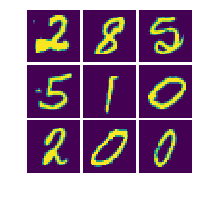

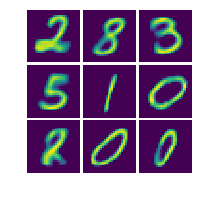

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:49 end epoch 240/300: average loss = 0.032240152994346426 (=0.018927+0.013314)

2018-05-07 22:59:49 start epoch 241/300, with learning rate = 0.0000078390
2018-05-07 22:59:49 iteration 1/859: current training loss = 0.033327 (=0.019766+0.013560)
2018-05-07 22:59:50 iteration 100/859: current training loss = 0.031995 (=0.018843+0.013152)
2018-05-07 22:59:51 iteration 200/859: current training loss = 0.033094 (=0.019846+0.013248)
2018-05-07 22:59:52 iteration 300/859: current training loss = 0.033683 (=0.019825+0.013858)
2018-05-07 22:59:52 iteration 400/859: current training loss = 0.033174 (=0.019320+0.013853)
2018-05-07 22:59:53 iteration 500/859: current training loss = 0.031410 (=0.018291+0.013119)
2018-05-07 22:59:54 iteration 600/859: current training loss = 0.031014 (=0.017893+0.013121)
2018-05-07 22:59:55 iteration 700/859: current training loss = 0.030340 (=0.016957+0.013382)
2018-05-07 22:59:55 iteration 800/859: cu

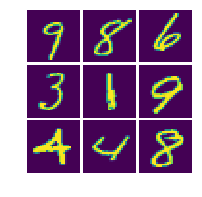

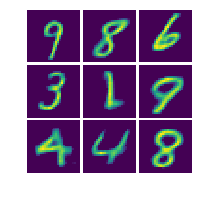

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 22:59:57 end epoch 241/300: average loss = 0.03213213453973547 (=0.018854+0.013278)

2018-05-07 22:59:57 start epoch 242/300, with learning rate = 0.0000076822
2018-05-07 22:59:57 iteration 1/859: current training loss = 0.034434 (=0.020618+0.013815)
2018-05-07 22:59:58 iteration 100/859: current training loss = 0.031550 (=0.017955+0.013595)
2018-05-07 22:59:59 iteration 200/859: current training loss = 0.032368 (=0.019091+0.013277)
2018-05-07 22:59:59 iteration 300/859: current training loss = 0.032052 (=0.018352+0.013700)
2018-05-07 23:00:00 iteration 400/859: current training loss = 0.033798 (=0.020069+0.013729)
2018-05-07 23:00:01 iteration 500/859: current training loss = 0.029351 (=0.016711+0.012640)
2018-05-07 23:00:02 iteration 600/859: current training loss = 0.030470 (=0.018023+0.012447)
2018-05-07 23:00:02 iteration 700/859: current training loss = 0.033482 (=0.019869+0.013613)
2018-05-07 23:00:03 iteration 800/859: cur

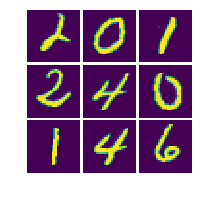

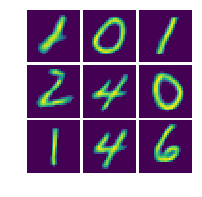

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:05 end epoch 242/300: average loss = 0.03219725912582125 (=0.018909+0.013288)

2018-05-07 23:00:05 start epoch 243/300, with learning rate = 0.0000075286
2018-05-07 23:00:05 iteration 1/859: current training loss = 0.031348 (=0.018440+0.012907)
2018-05-07 23:00:06 iteration 100/859: current training loss = 0.031376 (=0.018118+0.013258)
2018-05-07 23:00:06 iteration 200/859: current training loss = 0.031631 (=0.018088+0.013542)
2018-05-07 23:00:07 iteration 300/859: current training loss = 0.030647 (=0.017230+0.013418)
2018-05-07 23:00:08 iteration 400/859: current training loss = 0.032569 (=0.018883+0.013685)
2018-05-07 23:00:09 iteration 500/859: current training loss = 0.037406 (=0.023326+0.014080)
2018-05-07 23:00:09 iteration 600/859: current training loss = 0.034029 (=0.020313+0.013716)
2018-05-07 23:00:10 iteration 700/859: current training loss = 0.032693 (=0.019233+0.013460)
2018-05-07 23:00:11 iteration 800/859: cur

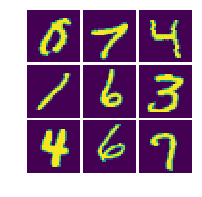

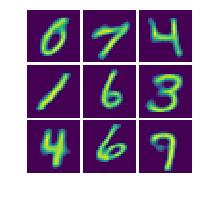

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:12 end epoch 243/300: average loss = 0.03213772728466738 (=0.018853+0.013285)

2018-05-07 23:00:12 start epoch 244/300, with learning rate = 0.0000073780
2018-05-07 23:00:12 iteration 1/859: current training loss = 0.035602 (=0.021730+0.013873)
2018-05-07 23:00:13 iteration 100/859: current training loss = 0.034220 (=0.020741+0.013480)
2018-05-07 23:00:14 iteration 200/859: current training loss = 0.031992 (=0.018654+0.013338)
2018-05-07 23:00:15 iteration 300/859: current training loss = 0.031784 (=0.018355+0.013429)
2018-05-07 23:00:16 iteration 400/859: current training loss = 0.030770 (=0.017661+0.013109)
2018-05-07 23:00:16 iteration 500/859: current training loss = 0.032882 (=0.019329+0.013553)
2018-05-07 23:00:17 iteration 600/859: current training loss = 0.033107 (=0.019879+0.013228)
2018-05-07 23:00:18 iteration 700/859: current training loss = 0.031953 (=0.018371+0.013582)
2018-05-07 23:00:18 iteration 800/859: cur

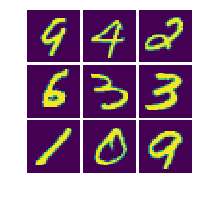

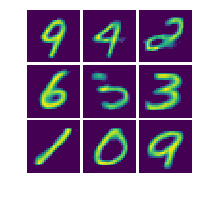

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:20 end epoch 244/300: average loss = 0.03218642236909919 (=0.018875+0.013311)

2018-05-07 23:00:20 start epoch 245/300, with learning rate = 0.0000072304
2018-05-07 23:00:20 iteration 1/859: current training loss = 0.031733 (=0.018751+0.012982)
2018-05-07 23:00:21 iteration 100/859: current training loss = 0.031605 (=0.018579+0.013026)
2018-05-07 23:00:22 iteration 200/859: current training loss = 0.032162 (=0.019430+0.012731)
2018-05-07 23:00:22 iteration 300/859: current training loss = 0.031496 (=0.017995+0.013500)
2018-05-07 23:00:23 iteration 400/859: current training loss = 0.034153 (=0.020571+0.013582)
2018-05-07 23:00:24 iteration 500/859: current training loss = 0.032477 (=0.018849+0.013628)
2018-05-07 23:00:25 iteration 600/859: current training loss = 0.033428 (=0.019997+0.013431)
2018-05-07 23:00:25 iteration 700/859: current training loss = 0.032933 (=0.019606+0.013328)
2018-05-07 23:00:26 iteration 800/859: cur

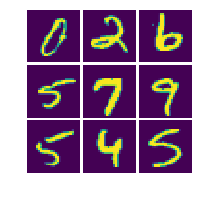

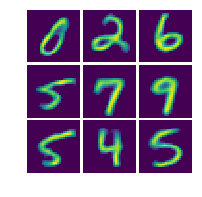

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:28 end epoch 245/300: average loss = 0.032184543443694105 (=0.018873+0.013312)

2018-05-07 23:00:28 start epoch 246/300, with learning rate = 0.0000070858
2018-05-07 23:00:28 iteration 1/859: current training loss = 0.033070 (=0.019507+0.013563)
2018-05-07 23:00:29 iteration 100/859: current training loss = 0.030957 (=0.017870+0.013086)
2018-05-07 23:00:29 iteration 200/859: current training loss = 0.029639 (=0.016973+0.012666)
2018-05-07 23:00:30 iteration 300/859: current training loss = 0.032653 (=0.019512+0.013142)
2018-05-07 23:00:31 iteration 400/859: current training loss = 0.034570 (=0.020201+0.014370)
2018-05-07 23:00:32 iteration 500/859: current training loss = 0.033869 (=0.020493+0.013375)
2018-05-07 23:00:32 iteration 600/859: current training loss = 0.030594 (=0.017553+0.013041)
2018-05-07 23:00:33 iteration 700/859: current training loss = 0.030962 (=0.017977+0.012985)
2018-05-07 23:00:34 iteration 800/859: cu

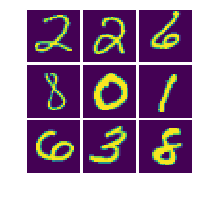

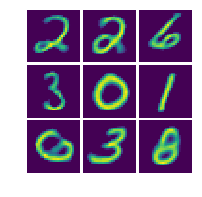

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:35 end epoch 246/300: average loss = 0.03215198661824114 (=0.018859+0.013293)

2018-05-07 23:00:35 start epoch 247/300, with learning rate = 0.0000069441
2018-05-07 23:00:35 iteration 1/859: current training loss = 0.032787 (=0.019377+0.013410)
2018-05-07 23:00:36 iteration 100/859: current training loss = 0.033539 (=0.019915+0.013625)
2018-05-07 23:00:37 iteration 200/859: current training loss = 0.034398 (=0.020741+0.013657)
2018-05-07 23:00:38 iteration 300/859: current training loss = 0.033288 (=0.019711+0.013577)
2018-05-07 23:00:39 iteration 400/859: current training loss = 0.032821 (=0.019180+0.013641)
2018-05-07 23:00:39 iteration 500/859: current training loss = 0.032401 (=0.019152+0.013249)
2018-05-07 23:00:40 iteration 600/859: current training loss = 0.030911 (=0.017675+0.013237)
2018-05-07 23:00:41 iteration 700/859: current training loss = 0.031539 (=0.018395+0.013144)
2018-05-07 23:00:42 iteration 800/859: cur

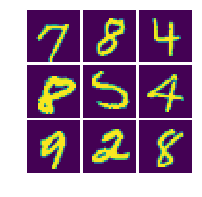

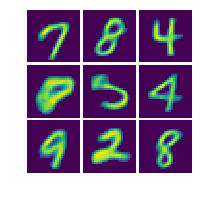

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:43 end epoch 247/300: average loss = 0.03210612532397574 (=0.018814+0.013292)

2018-05-07 23:00:43 start epoch 248/300, with learning rate = 0.0000068052
2018-05-07 23:00:43 iteration 1/859: current training loss = 0.030818 (=0.017634+0.013184)
2018-05-07 23:00:44 iteration 100/859: current training loss = 0.031734 (=0.018695+0.013040)
2018-05-07 23:00:45 iteration 200/859: current training loss = 0.031913 (=0.018468+0.013446)
2018-05-07 23:00:45 iteration 300/859: current training loss = 0.034433 (=0.020445+0.013988)
2018-05-07 23:00:46 iteration 400/859: current training loss = 0.033079 (=0.019348+0.013731)
2018-05-07 23:00:47 iteration 500/859: current training loss = 0.032262 (=0.018796+0.013465)
2018-05-07 23:00:48 iteration 600/859: current training loss = 0.030258 (=0.017386+0.012872)
2018-05-07 23:00:48 iteration 700/859: current training loss = 0.032570 (=0.019399+0.013172)
2018-05-07 23:00:49 iteration 800/859: cur

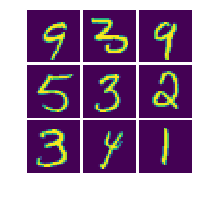

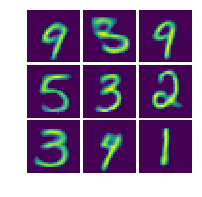

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:51 end epoch 248/300: average loss = 0.03214234865473299 (=0.018858+0.013284)

2018-05-07 23:00:51 start epoch 249/300, with learning rate = 0.0000066691
2018-05-07 23:00:51 iteration 1/859: current training loss = 0.031326 (=0.018531+0.012796)
2018-05-07 23:00:51 iteration 100/859: current training loss = 0.031742 (=0.018369+0.013373)
2018-05-07 23:00:52 iteration 200/859: current training loss = 0.034497 (=0.021026+0.013471)
2018-05-07 23:00:53 iteration 300/859: current training loss = 0.033033 (=0.019623+0.013411)
2018-05-07 23:00:54 iteration 400/859: current training loss = 0.034264 (=0.020562+0.013702)
2018-05-07 23:00:54 iteration 500/859: current training loss = 0.029745 (=0.017325+0.012420)
2018-05-07 23:00:55 iteration 600/859: current training loss = 0.029675 (=0.016996+0.012679)
2018-05-07 23:00:56 iteration 700/859: current training loss = 0.032948 (=0.019859+0.013089)
2018-05-07 23:00:57 iteration 800/859: cur

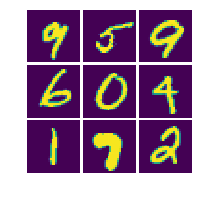

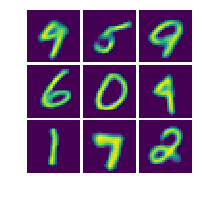

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:00:58 end epoch 249/300: average loss = 0.03212185330012417 (=0.018841+0.013281)

2018-05-07 23:00:58 start epoch 250/300, with learning rate = 0.0000065357
2018-05-07 23:00:58 iteration 1/859: current training loss = 0.030449 (=0.017626+0.012823)
2018-05-07 23:00:59 iteration 100/859: current training loss = 0.032204 (=0.018501+0.013704)
2018-05-07 23:01:00 iteration 200/859: current training loss = 0.033156 (=0.019693+0.013464)
2018-05-07 23:01:00 iteration 300/859: current training loss = 0.033470 (=0.020202+0.013268)
2018-05-07 23:01:01 iteration 400/859: current training loss = 0.031769 (=0.018171+0.013598)
2018-05-07 23:01:02 iteration 500/859: current training loss = 0.031178 (=0.017812+0.013366)
2018-05-07 23:01:03 iteration 600/859: current training loss = 0.034127 (=0.020577+0.013550)
2018-05-07 23:01:03 iteration 700/859: current training loss = 0.034582 (=0.020856+0.013726)
2018-05-07 23:01:04 iteration 800/859: cur

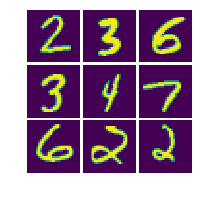

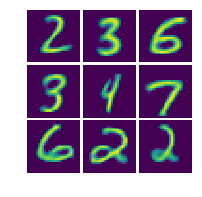

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:06 end epoch 250/300: average loss = 0.03213615053278048 (=0.018837+0.013299)

2018-05-07 23:01:06 start epoch 251/300, with learning rate = 0.0000064050
2018-05-07 23:01:06 iteration 1/859: current training loss = 0.032892 (=0.018901+0.013991)
2018-05-07 23:01:06 iteration 100/859: current training loss = 0.033447 (=0.019627+0.013820)
2018-05-07 23:01:07 iteration 200/859: current training loss = 0.031216 (=0.018081+0.013135)
2018-05-07 23:01:08 iteration 300/859: current training loss = 0.033015 (=0.019545+0.013470)
2018-05-07 23:01:09 iteration 400/859: current training loss = 0.033642 (=0.019740+0.013902)
2018-05-07 23:01:09 iteration 500/859: current training loss = 0.029937 (=0.017051+0.012886)
2018-05-07 23:01:10 iteration 600/859: current training loss = 0.033886 (=0.020194+0.013692)
2018-05-07 23:01:11 iteration 700/859: current training loss = 0.032195 (=0.018801+0.013394)
2018-05-07 23:01:11 iteration 800/859: cur

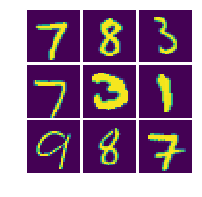

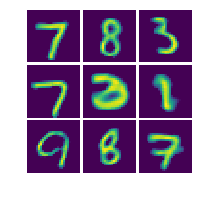

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:13 end epoch 251/300: average loss = 0.032116232418191726 (=0.018835+0.013281)

2018-05-07 23:01:13 start epoch 252/300, with learning rate = 0.0000062769
2018-05-07 23:01:13 iteration 1/859: current training loss = 0.030306 (=0.017283+0.013022)
2018-05-07 23:01:14 iteration 100/859: current training loss = 0.030979 (=0.018292+0.012687)
2018-05-07 23:01:15 iteration 200/859: current training loss = 0.032192 (=0.018604+0.013588)
2018-05-07 23:01:15 iteration 300/859: current training loss = 0.031966 (=0.018513+0.013453)
2018-05-07 23:01:16 iteration 400/859: current training loss = 0.033960 (=0.019983+0.013977)
2018-05-07 23:01:17 iteration 500/859: current training loss = 0.028539 (=0.016023+0.012516)
2018-05-07 23:01:18 iteration 600/859: current training loss = 0.032199 (=0.018711+0.013489)
2018-05-07 23:01:18 iteration 700/859: current training loss = 0.031674 (=0.018090+0.013583)
2018-05-07 23:01:19 iteration 800/859: cu

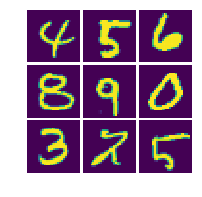

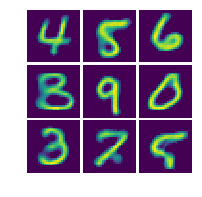

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:21 end epoch 252/300: average loss = 0.03207441333061186 (=0.018787+0.013288)

2018-05-07 23:01:21 start epoch 253/300, with learning rate = 0.0000061514
2018-05-07 23:01:21 iteration 1/859: current training loss = 0.031888 (=0.018248+0.013641)
2018-05-07 23:01:22 iteration 100/859: current training loss = 0.032107 (=0.018608+0.013499)
2018-05-07 23:01:22 iteration 200/859: current training loss = 0.031570 (=0.018454+0.013116)
2018-05-07 23:01:23 iteration 300/859: current training loss = 0.029832 (=0.017077+0.012755)
2018-05-07 23:01:24 iteration 400/859: current training loss = 0.032740 (=0.018990+0.013749)
2018-05-07 23:01:24 iteration 500/859: current training loss = 0.032113 (=0.018570+0.013544)
2018-05-07 23:01:25 iteration 600/859: current training loss = 0.032227 (=0.019042+0.013185)
2018-05-07 23:01:26 iteration 700/859: current training loss = 0.031089 (=0.017606+0.013483)
2018-05-07 23:01:27 iteration 800/859: cur

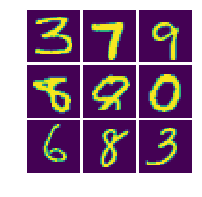

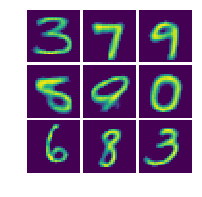

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:28 end epoch 253/300: average loss = 0.032124233346462805 (=0.018826+0.013298)

2018-05-07 23:01:28 start epoch 254/300, with learning rate = 0.0000060284
2018-05-07 23:01:28 iteration 1/859: current training loss = 0.032393 (=0.019004+0.013389)
2018-05-07 23:01:29 iteration 100/859: current training loss = 0.031584 (=0.018301+0.013283)
2018-05-07 23:01:30 iteration 200/859: current training loss = 0.032206 (=0.019008+0.013198)
2018-05-07 23:01:31 iteration 300/859: current training loss = 0.030249 (=0.017532+0.012717)
2018-05-07 23:01:31 iteration 400/859: current training loss = 0.030354 (=0.017610+0.012744)
2018-05-07 23:01:32 iteration 500/859: current training loss = 0.029916 (=0.016967+0.012949)
2018-05-07 23:01:33 iteration 600/859: current training loss = 0.032961 (=0.019381+0.013580)
2018-05-07 23:01:33 iteration 700/859: current training loss = 0.032583 (=0.019120+0.013463)
2018-05-07 23:01:34 iteration 800/859: cu

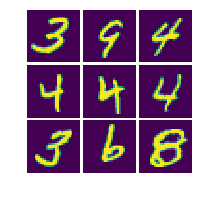

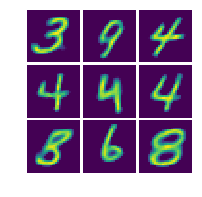

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:36 end epoch 254/300: average loss = 0.03206883984746908 (=0.018765+0.013304)

2018-05-07 23:01:36 start epoch 255/300, with learning rate = 0.0000059078
2018-05-07 23:01:36 iteration 1/859: current training loss = 0.031604 (=0.018356+0.013248)
2018-05-07 23:01:37 iteration 100/859: current training loss = 0.032020 (=0.018471+0.013549)
2018-05-07 23:01:37 iteration 200/859: current training loss = 0.032026 (=0.018745+0.013281)
2018-05-07 23:01:38 iteration 300/859: current training loss = 0.033161 (=0.019636+0.013525)
2018-05-07 23:01:39 iteration 400/859: current training loss = 0.034601 (=0.020641+0.013960)
2018-05-07 23:01:40 iteration 500/859: current training loss = 0.031825 (=0.018476+0.013350)
2018-05-07 23:01:40 iteration 600/859: current training loss = 0.032730 (=0.019415+0.013315)
2018-05-07 23:01:41 iteration 700/859: current training loss = 0.031003 (=0.017639+0.013364)
2018-05-07 23:01:42 iteration 800/859: cur

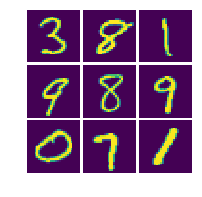

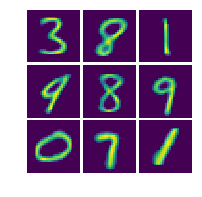

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:43 end epoch 255/300: average loss = 0.03209985234493843 (=0.018778+0.013321)

2018-05-07 23:01:43 start epoch 256/300, with learning rate = 0.0000057896
2018-05-07 23:01:43 iteration 1/859: current training loss = 0.032945 (=0.019429+0.013516)
2018-05-07 23:01:44 iteration 100/859: current training loss = 0.030666 (=0.017960+0.012707)
2018-05-07 23:01:45 iteration 200/859: current training loss = 0.032709 (=0.019121+0.013587)
2018-05-07 23:01:46 iteration 300/859: current training loss = 0.032669 (=0.019395+0.013274)
2018-05-07 23:01:47 iteration 400/859: current training loss = 0.030206 (=0.017257+0.012949)
2018-05-07 23:01:47 iteration 500/859: current training loss = 0.032359 (=0.019100+0.013259)
2018-05-07 23:01:48 iteration 600/859: current training loss = 0.031506 (=0.018789+0.012717)
2018-05-07 23:01:49 iteration 700/859: current training loss = 0.032556 (=0.018957+0.013600)
2018-05-07 23:01:50 iteration 800/859: cur

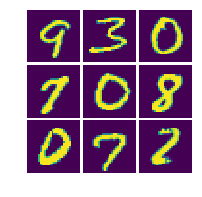

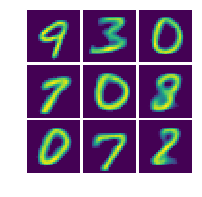

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:51 end epoch 256/300: average loss = 0.03211999774560315 (=0.018816+0.013304)

2018-05-07 23:01:51 start epoch 257/300, with learning rate = 0.0000056738
2018-05-07 23:01:51 iteration 1/859: current training loss = 0.031579 (=0.018221+0.013358)
2018-05-07 23:01:52 iteration 100/859: current training loss = 0.033746 (=0.020078+0.013668)
2018-05-07 23:01:53 iteration 200/859: current training loss = 0.033884 (=0.020315+0.013569)
2018-05-07 23:01:54 iteration 300/859: current training loss = 0.033989 (=0.020016+0.013973)
2018-05-07 23:01:54 iteration 400/859: current training loss = 0.034004 (=0.020511+0.013494)
2018-05-07 23:01:55 iteration 500/859: current training loss = 0.031284 (=0.018282+0.013002)
2018-05-07 23:01:56 iteration 600/859: current training loss = 0.033271 (=0.020291+0.012980)
2018-05-07 23:01:57 iteration 700/859: current training loss = 0.031814 (=0.018434+0.013380)
2018-05-07 23:01:57 iteration 800/859: cur

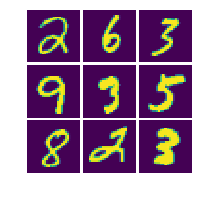

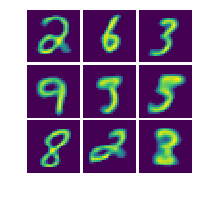

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:01:59 end epoch 257/300: average loss = 0.03210541746894611 (=0.018801+0.013305)

2018-05-07 23:01:59 start epoch 258/300, with learning rate = 0.0000055604
2018-05-07 23:01:59 iteration 1/859: current training loss = 0.033868 (=0.020407+0.013461)
2018-05-07 23:02:00 iteration 100/859: current training loss = 0.031705 (=0.018642+0.013064)
2018-05-07 23:02:01 iteration 200/859: current training loss = 0.030303 (=0.017489+0.012813)
2018-05-07 23:02:01 iteration 300/859: current training loss = 0.030101 (=0.017350+0.012752)
2018-05-07 23:02:02 iteration 400/859: current training loss = 0.032056 (=0.019053+0.013003)
2018-05-07 23:02:03 iteration 500/859: current training loss = 0.031391 (=0.018344+0.013048)
2018-05-07 23:02:04 iteration 600/859: current training loss = 0.031932 (=0.018563+0.013369)
2018-05-07 23:02:04 iteration 700/859: current training loss = 0.031619 (=0.018278+0.013341)
2018-05-07 23:02:05 iteration 800/859: cur

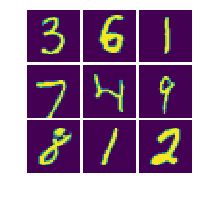

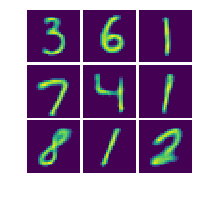

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:07 end epoch 258/300: average loss = 0.032092769984784726 (=0.018772+0.013320)

2018-05-07 23:02:07 start epoch 259/300, with learning rate = 0.0000054492
2018-05-07 23:02:07 iteration 1/859: current training loss = 0.031101 (=0.018244+0.012857)
2018-05-07 23:02:07 iteration 100/859: current training loss = 0.033163 (=0.019439+0.013724)
2018-05-07 23:02:08 iteration 200/859: current training loss = 0.033083 (=0.019621+0.013462)
2018-05-07 23:02:09 iteration 300/859: current training loss = 0.030412 (=0.016977+0.013436)
2018-05-07 23:02:10 iteration 400/859: current training loss = 0.032760 (=0.019094+0.013666)
2018-05-07 23:02:10 iteration 500/859: current training loss = 0.031008 (=0.017868+0.013140)
2018-05-07 23:02:11 iteration 600/859: current training loss = 0.030830 (=0.017701+0.013129)
2018-05-07 23:02:12 iteration 700/859: current training loss = 0.032998 (=0.019578+0.013420)
2018-05-07 23:02:13 iteration 800/859: cu

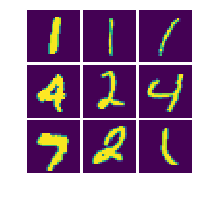

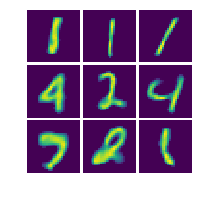

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:14 end epoch 259/300: average loss = 0.03208910514046552 (=0.018777+0.013312)

2018-05-07 23:02:14 start epoch 260/300, with learning rate = 0.0000053402
2018-05-07 23:02:14 iteration 1/859: current training loss = 0.032552 (=0.019035+0.013517)
2018-05-07 23:02:15 iteration 100/859: current training loss = 0.031877 (=0.018848+0.013029)
2018-05-07 23:02:16 iteration 200/859: current training loss = 0.034006 (=0.019798+0.014209)
2018-05-07 23:02:17 iteration 300/859: current training loss = 0.032051 (=0.018587+0.013464)
2018-05-07 23:02:17 iteration 400/859: current training loss = 0.032293 (=0.018826+0.013467)
2018-05-07 23:02:18 iteration 500/859: current training loss = 0.032089 (=0.018681+0.013408)
2018-05-07 23:02:19 iteration 600/859: current training loss = 0.029940 (=0.016884+0.013056)
2018-05-07 23:02:20 iteration 700/859: current training loss = 0.031987 (=0.018791+0.013196)
2018-05-07 23:02:20 iteration 800/859: cur

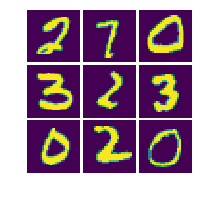

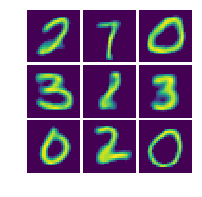

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:22 end epoch 260/300: average loss = 0.032115390556793966 (=0.018819+0.013296)

2018-05-07 23:02:22 start epoch 261/300, with learning rate = 0.0000052334
2018-05-07 23:02:22 iteration 1/859: current training loss = 0.033647 (=0.020611+0.013036)
2018-05-07 23:02:23 iteration 100/859: current training loss = 0.032913 (=0.019661+0.013252)
2018-05-07 23:02:24 iteration 200/859: current training loss = 0.029768 (=0.016638+0.013130)
2018-05-07 23:02:24 iteration 300/859: current training loss = 0.035411 (=0.020739+0.014672)
2018-05-07 23:02:25 iteration 400/859: current training loss = 0.033349 (=0.019937+0.013412)
2018-05-07 23:02:26 iteration 500/859: current training loss = 0.033644 (=0.019743+0.013901)
2018-05-07 23:02:27 iteration 600/859: current training loss = 0.031906 (=0.018874+0.013032)
2018-05-07 23:02:27 iteration 700/859: current training loss = 0.031593 (=0.018744+0.012849)
2018-05-07 23:02:28 iteration 800/859: cu

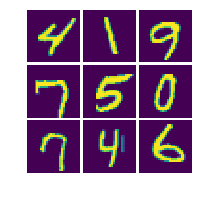

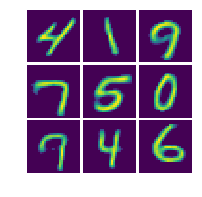

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:30 end epoch 261/300: average loss = 0.03209681387413922 (=0.018812+0.013285)

2018-05-07 23:02:30 start epoch 262/300, with learning rate = 0.0000051287
2018-05-07 23:02:30 iteration 1/859: current training loss = 0.033039 (=0.019313+0.013727)
2018-05-07 23:02:31 iteration 100/859: current training loss = 0.031750 (=0.018780+0.012970)
2018-05-07 23:02:31 iteration 200/859: current training loss = 0.032107 (=0.019043+0.013064)
2018-05-07 23:02:32 iteration 300/859: current training loss = 0.031536 (=0.018168+0.013368)
2018-05-07 23:02:33 iteration 400/859: current training loss = 0.034866 (=0.020952+0.013914)
2018-05-07 23:02:33 iteration 500/859: current training loss = 0.030990 (=0.018113+0.012877)
2018-05-07 23:02:34 iteration 600/859: current training loss = 0.031010 (=0.017776+0.013235)
2018-05-07 23:02:35 iteration 700/859: current training loss = 0.035306 (=0.021294+0.014013)
2018-05-07 23:02:36 iteration 800/859: cur

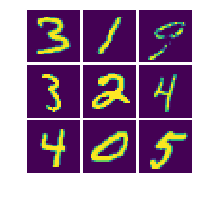

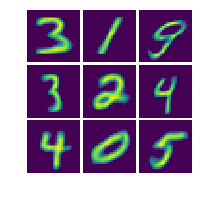

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:37 end epoch 262/300: average loss = 0.03206533464203058 (=0.018771+0.013294)

2018-05-07 23:02:37 start epoch 263/300, with learning rate = 0.0000050261
2018-05-07 23:02:37 iteration 1/859: current training loss = 0.032442 (=0.019138+0.013304)
2018-05-07 23:02:38 iteration 100/859: current training loss = 0.030249 (=0.017498+0.012750)
2018-05-07 23:02:39 iteration 200/859: current training loss = 0.033748 (=0.020156+0.013591)
2018-05-07 23:02:39 iteration 300/859: current training loss = 0.032438 (=0.019081+0.013357)
2018-05-07 23:02:40 iteration 400/859: current training loss = 0.031323 (=0.017797+0.013526)
2018-05-07 23:02:41 iteration 500/859: current training loss = 0.030000 (=0.017003+0.012997)
2018-05-07 23:02:42 iteration 600/859: current training loss = 0.033065 (=0.019264+0.013801)
2018-05-07 23:02:42 iteration 700/859: current training loss = 0.034359 (=0.020333+0.014026)
2018-05-07 23:02:43 iteration 800/859: cur

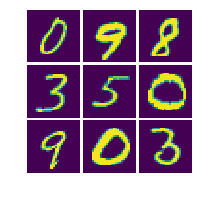

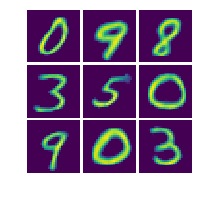

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:45 end epoch 263/300: average loss = 0.03208533764900304 (=0.018772+0.013313)

2018-05-07 23:02:45 start epoch 264/300, with learning rate = 0.0000049256
2018-05-07 23:02:45 iteration 1/859: current training loss = 0.033827 (=0.020176+0.013651)
2018-05-07 23:02:46 iteration 100/859: current training loss = 0.031679 (=0.018603+0.013076)
2018-05-07 23:02:46 iteration 200/859: current training loss = 0.032775 (=0.019539+0.013236)
2018-05-07 23:02:47 iteration 300/859: current training loss = 0.031906 (=0.018595+0.013311)
2018-05-07 23:02:48 iteration 400/859: current training loss = 0.031316 (=0.017785+0.013531)
2018-05-07 23:02:49 iteration 500/859: current training loss = 0.033154 (=0.019628+0.013526)
2018-05-07 23:02:49 iteration 600/859: current training loss = 0.034547 (=0.020826+0.013721)
2018-05-07 23:02:50 iteration 700/859: current training loss = 0.032023 (=0.018642+0.013380)
2018-05-07 23:02:51 iteration 800/859: cur

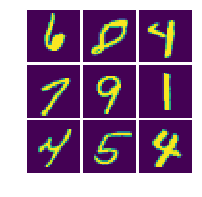

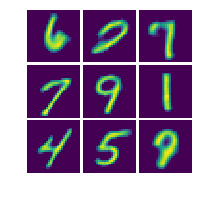

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:02:52 end epoch 264/300: average loss = 0.03205439527719623 (=0.018754+0.013300)

2018-05-07 23:02:52 start epoch 265/300, with learning rate = 0.0000048271
2018-05-07 23:02:52 iteration 1/859: current training loss = 0.031538 (=0.018244+0.013293)
2018-05-07 23:02:53 iteration 100/859: current training loss = 0.034100 (=0.020012+0.014088)
2018-05-07 23:02:54 iteration 200/859: current training loss = 0.030528 (=0.017881+0.012647)
2018-05-07 23:02:55 iteration 300/859: current training loss = 0.032562 (=0.019191+0.013371)
2018-05-07 23:02:55 iteration 400/859: current training loss = 0.031322 (=0.018319+0.013003)
2018-05-07 23:02:56 iteration 500/859: current training loss = 0.035298 (=0.021534+0.013764)
2018-05-07 23:02:57 iteration 600/859: current training loss = 0.033336 (=0.020102+0.013234)
2018-05-07 23:02:58 iteration 700/859: current training loss = 0.031030 (=0.018135+0.012895)
2018-05-07 23:02:58 iteration 800/859: cur

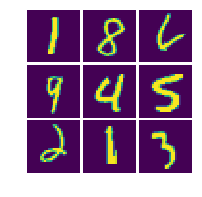

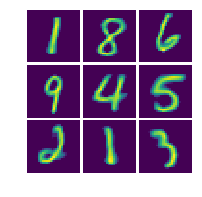

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:00 end epoch 265/300: average loss = 0.03206382343400274 (=0.018743+0.013320)

2018-05-07 23:03:00 start epoch 266/300, with learning rate = 0.0000047306
2018-05-07 23:03:00 iteration 1/859: current training loss = 0.031596 (=0.018256+0.013340)
2018-05-07 23:03:01 iteration 100/859: current training loss = 0.029773 (=0.017124+0.012649)
2018-05-07 23:03:01 iteration 200/859: current training loss = 0.033229 (=0.019474+0.013755)
2018-05-07 23:03:02 iteration 300/859: current training loss = 0.030093 (=0.017209+0.012884)
2018-05-07 23:03:03 iteration 400/859: current training loss = 0.032538 (=0.019082+0.013455)
2018-05-07 23:03:04 iteration 500/859: current training loss = 0.030851 (=0.017849+0.013002)
2018-05-07 23:03:04 iteration 600/859: current training loss = 0.033971 (=0.020494+0.013477)
2018-05-07 23:03:05 iteration 700/859: current training loss = 0.033222 (=0.019695+0.013527)
2018-05-07 23:03:06 iteration 800/859: cur

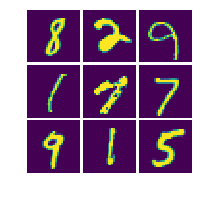

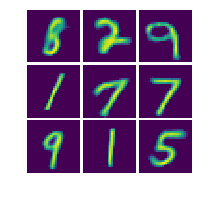

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:08 end epoch 266/300: average loss = 0.03207375879407068 (=0.018785+0.013288)

2018-05-07 23:03:08 start epoch 267/300, with learning rate = 0.0000046359
2018-05-07 23:03:08 iteration 1/859: current training loss = 0.033980 (=0.020245+0.013735)
2018-05-07 23:03:09 iteration 100/859: current training loss = 0.031513 (=0.018244+0.013269)
2018-05-07 23:03:09 iteration 200/859: current training loss = 0.034054 (=0.020673+0.013381)
2018-05-07 23:03:10 iteration 300/859: current training loss = 0.036577 (=0.022527+0.014050)
2018-05-07 23:03:11 iteration 400/859: current training loss = 0.032024 (=0.018973+0.013052)
2018-05-07 23:03:11 iteration 500/859: current training loss = 0.031408 (=0.018564+0.012844)
2018-05-07 23:03:12 iteration 600/859: current training loss = 0.032680 (=0.019169+0.013510)
2018-05-07 23:03:13 iteration 700/859: current training loss = 0.031723 (=0.018503+0.013220)
2018-05-07 23:03:14 iteration 800/859: cur

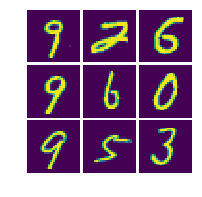

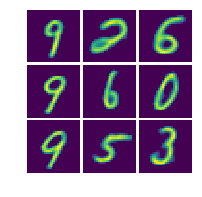

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:15 end epoch 267/300: average loss = 0.03206121494800581 (=0.018755+0.013306)

2018-05-07 23:03:15 start epoch 268/300, with learning rate = 0.0000045432
2018-05-07 23:03:15 iteration 1/859: current training loss = 0.033725 (=0.020043+0.013682)
2018-05-07 23:03:16 iteration 100/859: current training loss = 0.032851 (=0.019520+0.013332)
2018-05-07 23:03:17 iteration 200/859: current training loss = 0.032830 (=0.019335+0.013495)
2018-05-07 23:03:18 iteration 300/859: current training loss = 0.033015 (=0.019617+0.013398)
2018-05-07 23:03:18 iteration 400/859: current training loss = 0.031256 (=0.017829+0.013427)
2018-05-07 23:03:19 iteration 500/859: current training loss = 0.029763 (=0.017220+0.012543)
2018-05-07 23:03:20 iteration 600/859: current training loss = 0.031691 (=0.018767+0.012924)
2018-05-07 23:03:21 iteration 700/859: current training loss = 0.031924 (=0.018271+0.013653)
2018-05-07 23:03:21 iteration 800/859: cur

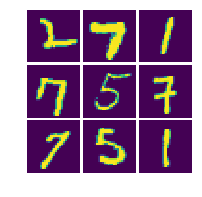

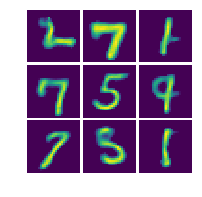

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:23 end epoch 268/300: average loss = 0.03207892678652015 (=0.018759+0.013320)

2018-05-07 23:03:23 start epoch 269/300, with learning rate = 0.0000044524
2018-05-07 23:03:23 iteration 1/859: current training loss = 0.031337 (=0.018060+0.013277)
2018-05-07 23:03:24 iteration 100/859: current training loss = 0.031586 (=0.018362+0.013224)
2018-05-07 23:03:25 iteration 200/859: current training loss = 0.033126 (=0.019423+0.013703)
2018-05-07 23:03:25 iteration 300/859: current training loss = 0.032172 (=0.019040+0.013132)
2018-05-07 23:03:26 iteration 400/859: current training loss = 0.032096 (=0.018779+0.013317)
2018-05-07 23:03:27 iteration 500/859: current training loss = 0.030440 (=0.017560+0.012881)
2018-05-07 23:03:27 iteration 600/859: current training loss = 0.032677 (=0.018704+0.013973)
2018-05-07 23:03:28 iteration 700/859: current training loss = 0.032204 (=0.018960+0.013244)
2018-05-07 23:03:29 iteration 800/859: cur

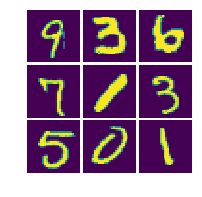

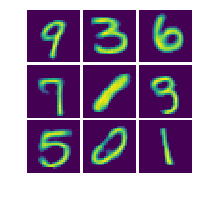

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:31 end epoch 269/300: average loss = 0.032092711277852515 (=0.018764+0.013328)

2018-05-07 23:03:31 start epoch 270/300, with learning rate = 0.0000043633
2018-05-07 23:03:31 iteration 1/859: current training loss = 0.032866 (=0.019189+0.013677)
2018-05-07 23:03:31 iteration 100/859: current training loss = 0.033560 (=0.019698+0.013862)
2018-05-07 23:03:32 iteration 200/859: current training loss = 0.030960 (=0.018128+0.012833)
2018-05-07 23:03:33 iteration 300/859: current training loss = 0.030962 (=0.018130+0.012831)
2018-05-07 23:03:34 iteration 400/859: current training loss = 0.029597 (=0.016812+0.012785)
2018-05-07 23:03:34 iteration 500/859: current training loss = 0.033031 (=0.019954+0.013077)
2018-05-07 23:03:35 iteration 600/859: current training loss = 0.033453 (=0.020131+0.013322)
2018-05-07 23:03:36 iteration 700/859: current training loss = 0.030570 (=0.017662+0.012908)
2018-05-07 23:03:37 iteration 800/859: cu

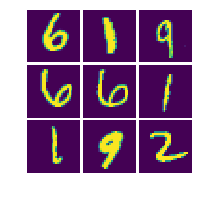

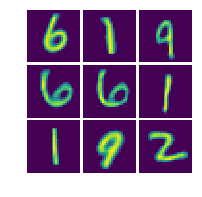

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:38 end epoch 270/300: average loss = 0.032065808005431476 (=0.018760+0.013305)

2018-05-07 23:03:38 start epoch 271/300, with learning rate = 0.0000042760
2018-05-07 23:03:38 iteration 1/859: current training loss = 0.031989 (=0.019123+0.012866)
2018-05-07 23:03:39 iteration 100/859: current training loss = 0.031898 (=0.018782+0.013115)
2018-05-07 23:03:40 iteration 200/859: current training loss = 0.031251 (=0.018199+0.013052)
2018-05-07 23:03:41 iteration 300/859: current training loss = 0.029809 (=0.017280+0.012529)
2018-05-07 23:03:41 iteration 400/859: current training loss = 0.031340 (=0.018488+0.012852)
2018-05-07 23:03:42 iteration 500/859: current training loss = 0.031177 (=0.017755+0.013422)
2018-05-07 23:03:43 iteration 600/859: current training loss = 0.031304 (=0.018587+0.012718)
2018-05-07 23:03:44 iteration 700/859: current training loss = 0.031952 (=0.018417+0.013535)
2018-05-07 23:03:44 iteration 800/859: cu

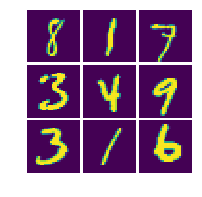

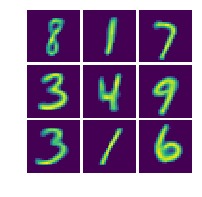

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:46 end epoch 271/300: average loss = 0.03200216427861742 (=0.018728+0.013274)

2018-05-07 23:03:46 start epoch 272/300, with learning rate = 0.0000041905
2018-05-07 23:03:46 iteration 1/859: current training loss = 0.032462 (=0.018715+0.013747)
2018-05-07 23:03:47 iteration 100/859: current training loss = 0.030644 (=0.017760+0.012884)
2018-05-07 23:03:47 iteration 200/859: current training loss = 0.032146 (=0.018884+0.013262)
2018-05-07 23:03:48 iteration 300/859: current training loss = 0.031814 (=0.018640+0.013174)
2018-05-07 23:03:49 iteration 400/859: current training loss = 0.033566 (=0.020345+0.013221)
2018-05-07 23:03:50 iteration 500/859: current training loss = 0.032814 (=0.019376+0.013438)
2018-05-07 23:03:51 iteration 600/859: current training loss = 0.030500 (=0.017745+0.012755)
2018-05-07 23:03:51 iteration 700/859: current training loss = 0.032917 (=0.019214+0.013703)
2018-05-07 23:03:52 iteration 800/859: cur

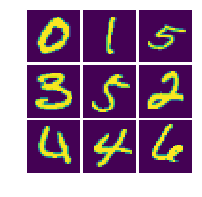

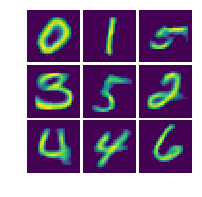

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:03:54 end epoch 272/300: average loss = 0.0320482293471295 (=0.018753+0.013295)

2018-05-07 23:03:54 start epoch 273/300, with learning rate = 0.0000041067
2018-05-07 23:03:54 iteration 1/859: current training loss = 0.031577 (=0.018368+0.013210)
2018-05-07 23:03:54 iteration 100/859: current training loss = 0.030706 (=0.017855+0.012850)
2018-05-07 23:03:55 iteration 200/859: current training loss = 0.035863 (=0.021380+0.014483)
2018-05-07 23:03:56 iteration 300/859: current training loss = 0.032143 (=0.018716+0.013428)
2018-05-07 23:03:57 iteration 400/859: current training loss = 0.031056 (=0.018102+0.012954)
2018-05-07 23:03:57 iteration 500/859: current training loss = 0.031790 (=0.018335+0.013455)
2018-05-07 23:03:58 iteration 600/859: current training loss = 0.032572 (=0.019099+0.013473)
2018-05-07 23:03:59 iteration 700/859: current training loss = 0.031953 (=0.018719+0.013235)
2018-05-07 23:04:00 iteration 800/859: curr

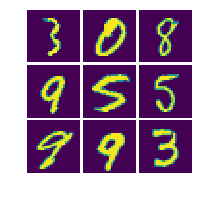

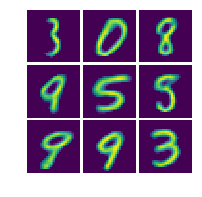

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:02 end epoch 273/300: average loss = 0.0320346696287116 (=0.018701+0.013333)

2018-05-07 23:04:02 start epoch 274/300, with learning rate = 0.0000040246
2018-05-07 23:04:02 iteration 1/859: current training loss = 0.032590 (=0.019528+0.013062)
2018-05-07 23:04:02 iteration 100/859: current training loss = 0.030803 (=0.018286+0.012517)
2018-05-07 23:04:03 iteration 200/859: current training loss = 0.030983 (=0.018108+0.012875)
2018-05-07 23:04:04 iteration 300/859: current training loss = 0.030539 (=0.017520+0.013019)
2018-05-07 23:04:05 iteration 400/859: current training loss = 0.031942 (=0.018736+0.013206)
2018-05-07 23:04:05 iteration 500/859: current training loss = 0.033665 (=0.019942+0.013722)
2018-05-07 23:04:06 iteration 600/859: current training loss = 0.031313 (=0.018061+0.013252)
2018-05-07 23:04:07 iteration 700/859: current training loss = 0.033252 (=0.019679+0.013573)
2018-05-07 23:04:08 iteration 800/859: curr

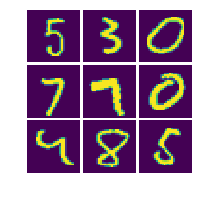

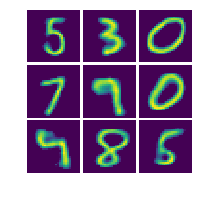

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:09 end epoch 274/300: average loss = 0.031999858499562085 (=0.018713+0.013286)

2018-05-07 23:04:09 start epoch 275/300, with learning rate = 0.0000039441
2018-05-07 23:04:09 iteration 1/859: current training loss = 0.031510 (=0.018441+0.013069)
2018-05-07 23:04:10 iteration 100/859: current training loss = 0.032001 (=0.018923+0.013078)
2018-05-07 23:04:11 iteration 200/859: current training loss = 0.032124 (=0.018784+0.013339)
2018-05-07 23:04:12 iteration 300/859: current training loss = 0.031111 (=0.018482+0.012629)
2018-05-07 23:04:12 iteration 400/859: current training loss = 0.032629 (=0.019460+0.013169)
2018-05-07 23:04:13 iteration 500/859: current training loss = 0.032110 (=0.018940+0.013170)
2018-05-07 23:04:14 iteration 600/859: current training loss = 0.029642 (=0.016613+0.013028)
2018-05-07 23:04:14 iteration 700/859: current training loss = 0.031907 (=0.018256+0.013651)
2018-05-07 23:04:15 iteration 800/859: cu

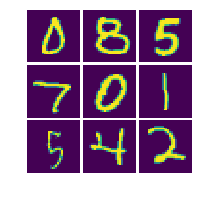

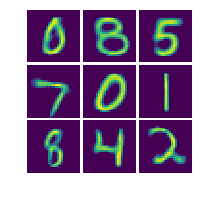

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:17 end epoch 275/300: average loss = 0.032030364060481716 (=0.018730+0.013301)

2018-05-07 23:04:17 start epoch 276/300, with learning rate = 0.0000038652
2018-05-07 23:04:17 iteration 1/859: current training loss = 0.032377 (=0.018774+0.013603)
2018-05-07 23:04:18 iteration 100/859: current training loss = 0.032469 (=0.019273+0.013196)
2018-05-07 23:04:18 iteration 200/859: current training loss = 0.033105 (=0.019493+0.013612)
2018-05-07 23:04:19 iteration 300/859: current training loss = 0.030927 (=0.017546+0.013380)
2018-05-07 23:04:20 iteration 400/859: current training loss = 0.033707 (=0.019916+0.013792)
2018-05-07 23:04:21 iteration 500/859: current training loss = 0.032426 (=0.019193+0.013233)
2018-05-07 23:04:21 iteration 600/859: current training loss = 0.031548 (=0.017983+0.013564)
2018-05-07 23:04:22 iteration 700/859: current training loss = 0.032087 (=0.018481+0.013605)
2018-05-07 23:04:23 iteration 800/859: cu

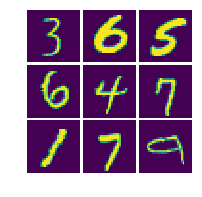

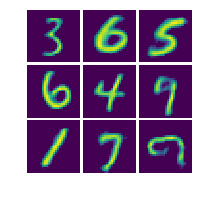

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:25 end epoch 276/300: average loss = 0.03204459763360801 (=0.018715+0.013330)

2018-05-07 23:04:25 start epoch 277/300, with learning rate = 0.0000037879
2018-05-07 23:04:25 iteration 1/859: current training loss = 0.030696 (=0.017681+0.013015)
2018-05-07 23:04:25 iteration 100/859: current training loss = 0.034065 (=0.019719+0.014346)
2018-05-07 23:04:26 iteration 200/859: current training loss = 0.028877 (=0.015920+0.012957)
2018-05-07 23:04:27 iteration 300/859: current training loss = 0.034862 (=0.020673+0.014189)
2018-05-07 23:04:28 iteration 400/859: current training loss = 0.031660 (=0.018354+0.013306)
2018-05-07 23:04:28 iteration 500/859: current training loss = 0.032421 (=0.019363+0.013058)
2018-05-07 23:04:29 iteration 600/859: current training loss = 0.031091 (=0.017605+0.013486)
2018-05-07 23:04:30 iteration 700/859: current training loss = 0.032259 (=0.019143+0.013116)
2018-05-07 23:04:30 iteration 800/859: cur

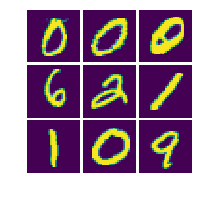

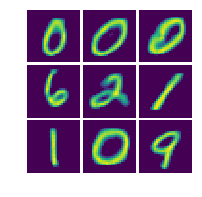

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:32 end epoch 277/300: average loss = 0.032018542161799 (=0.018714+0.013305)

2018-05-07 23:04:32 start epoch 278/300, with learning rate = 0.0000037121
2018-05-07 23:04:32 iteration 1/859: current training loss = 0.031570 (=0.018544+0.013026)
2018-05-07 23:04:33 iteration 100/859: current training loss = 0.029739 (=0.016810+0.012930)
2018-05-07 23:04:34 iteration 200/859: current training loss = 0.030634 (=0.017809+0.012826)
2018-05-07 23:04:35 iteration 300/859: current training loss = 0.032470 (=0.019330+0.013140)
2018-05-07 23:04:35 iteration 400/859: current training loss = 0.033227 (=0.019240+0.013988)
2018-05-07 23:04:36 iteration 500/859: current training loss = 0.032210 (=0.018724+0.013486)
2018-05-07 23:04:37 iteration 600/859: current training loss = 0.034955 (=0.020640+0.014315)
2018-05-07 23:04:37 iteration 700/859: current training loss = 0.032389 (=0.018795+0.013594)
2018-05-07 23:04:38 iteration 800/859: curre

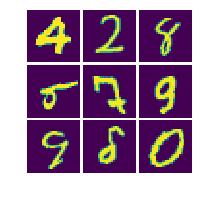

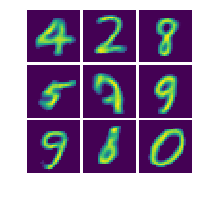

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:40 end epoch 278/300: average loss = 0.03206432998674782 (=0.018744+0.013321)

2018-05-07 23:04:40 start epoch 279/300, with learning rate = 0.0000036379
2018-05-07 23:04:40 iteration 1/859: current training loss = 0.030104 (=0.017431+0.012672)
2018-05-07 23:04:41 iteration 100/859: current training loss = 0.033142 (=0.019197+0.013945)
2018-05-07 23:04:41 iteration 200/859: current training loss = 0.030476 (=0.017247+0.013229)
2018-05-07 23:04:42 iteration 300/859: current training loss = 0.030050 (=0.017453+0.012598)
2018-05-07 23:04:43 iteration 400/859: current training loss = 0.031969 (=0.018652+0.013316)
2018-05-07 23:04:44 iteration 500/859: current training loss = 0.031736 (=0.018156+0.013580)
2018-05-07 23:04:44 iteration 600/859: current training loss = 0.030688 (=0.017647+0.013041)
2018-05-07 23:04:45 iteration 700/859: current training loss = 0.032091 (=0.018648+0.013444)
2018-05-07 23:04:46 iteration 800/859: cur

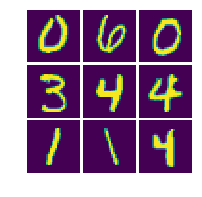

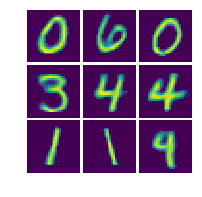

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:47 end epoch 279/300: average loss = 0.032031684096932966 (=0.018711+0.013321)

2018-05-07 23:04:47 start epoch 280/300, with learning rate = 0.0000035651
2018-05-07 23:04:47 iteration 1/859: current training loss = 0.033061 (=0.019980+0.013081)
2018-05-07 23:04:48 iteration 100/859: current training loss = 0.032218 (=0.018506+0.013712)
2018-05-07 23:04:49 iteration 200/859: current training loss = 0.031701 (=0.018464+0.013238)
2018-05-07 23:04:50 iteration 300/859: current training loss = 0.032411 (=0.019168+0.013242)
2018-05-07 23:04:50 iteration 400/859: current training loss = 0.032381 (=0.019332+0.013049)
2018-05-07 23:04:51 iteration 500/859: current training loss = 0.033480 (=0.019745+0.013735)
2018-05-07 23:04:52 iteration 600/859: current training loss = 0.031548 (=0.017674+0.013874)
2018-05-07 23:04:53 iteration 700/859: current training loss = 0.032640 (=0.019248+0.013393)
2018-05-07 23:04:53 iteration 800/859: cu

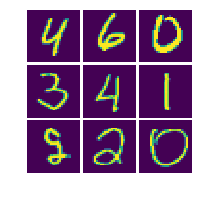

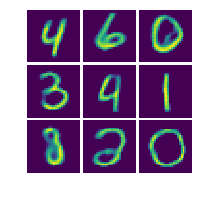

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:04:55 end epoch 280/300: average loss = 0.0320317206819725 (=0.018721+0.013310)

2018-05-07 23:04:55 start epoch 281/300, with learning rate = 0.0000034938
2018-05-07 23:04:55 iteration 1/859: current training loss = 0.032344 (=0.019029+0.013315)
2018-05-07 23:04:56 iteration 100/859: current training loss = 0.033146 (=0.019372+0.013774)
2018-05-07 23:04:57 iteration 200/859: current training loss = 0.033279 (=0.019649+0.013630)
2018-05-07 23:04:57 iteration 300/859: current training loss = 0.034535 (=0.021327+0.013208)
2018-05-07 23:04:58 iteration 400/859: current training loss = 0.032331 (=0.018712+0.013619)
2018-05-07 23:04:59 iteration 500/859: current training loss = 0.032102 (=0.018163+0.013939)
2018-05-07 23:05:00 iteration 600/859: current training loss = 0.032842 (=0.019092+0.013750)
2018-05-07 23:05:00 iteration 700/859: current training loss = 0.030488 (=0.017887+0.012601)
2018-05-07 23:05:01 iteration 800/859: curr

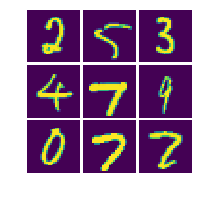

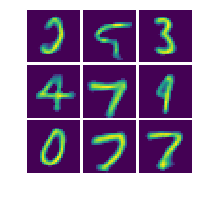

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:03 end epoch 281/300: average loss = 0.03202706895230882 (=0.018724+0.013303)

2018-05-07 23:05:03 start epoch 282/300, with learning rate = 0.0000034240
2018-05-07 23:05:03 iteration 1/859: current training loss = 0.031869 (=0.018537+0.013333)
2018-05-07 23:05:04 iteration 100/859: current training loss = 0.033533 (=0.019624+0.013909)
2018-05-07 23:05:04 iteration 200/859: current training loss = 0.031919 (=0.018546+0.013374)
2018-05-07 23:05:05 iteration 300/859: current training loss = 0.029399 (=0.016696+0.012703)
2018-05-07 23:05:06 iteration 400/859: current training loss = 0.031602 (=0.018191+0.013411)
2018-05-07 23:05:07 iteration 500/859: current training loss = 0.030543 (=0.017855+0.012688)
2018-05-07 23:05:07 iteration 600/859: current training loss = 0.032401 (=0.018761+0.013640)
2018-05-07 23:05:08 iteration 700/859: current training loss = 0.031315 (=0.018360+0.012955)
2018-05-07 23:05:09 iteration 800/859: cur

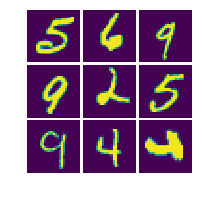

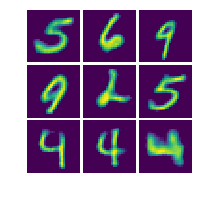

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:11 end epoch 282/300: average loss = 0.03199113757979467 (=0.018683+0.013308)

2018-05-07 23:05:11 start epoch 283/300, with learning rate = 0.0000033555
2018-05-07 23:05:11 iteration 1/859: current training loss = 0.032842 (=0.019423+0.013419)
2018-05-07 23:05:11 iteration 100/859: current training loss = 0.032139 (=0.018963+0.013177)
2018-05-07 23:05:12 iteration 200/859: current training loss = 0.032408 (=0.019201+0.013207)
2018-05-07 23:05:13 iteration 300/859: current training loss = 0.031888 (=0.018408+0.013480)
2018-05-07 23:05:14 iteration 400/859: current training loss = 0.030194 (=0.017398+0.012796)
2018-05-07 23:05:14 iteration 500/859: current training loss = 0.030767 (=0.017875+0.012891)
2018-05-07 23:05:15 iteration 600/859: current training loss = 0.034883 (=0.021058+0.013825)
2018-05-07 23:05:16 iteration 700/859: current training loss = 0.029130 (=0.016600+0.012530)
2018-05-07 23:05:17 iteration 800/859: cur

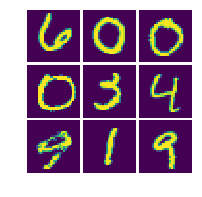

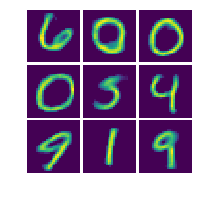

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:18 end epoch 283/300: average loss = 0.03204293048163232 (=0.018735+0.013308)

2018-05-07 23:05:18 start epoch 284/300, with learning rate = 0.0000032884
2018-05-07 23:05:18 iteration 1/859: current training loss = 0.031992 (=0.018741+0.013251)
2018-05-07 23:05:19 iteration 100/859: current training loss = 0.032275 (=0.018474+0.013801)
2018-05-07 23:05:20 iteration 200/859: current training loss = 0.031938 (=0.018648+0.013290)
2018-05-07 23:05:21 iteration 300/859: current training loss = 0.031861 (=0.018985+0.012876)
2018-05-07 23:05:21 iteration 400/859: current training loss = 0.032163 (=0.019036+0.013128)
2018-05-07 23:05:22 iteration 500/859: current training loss = 0.032692 (=0.019384+0.013308)
2018-05-07 23:05:23 iteration 600/859: current training loss = 0.032509 (=0.018882+0.013627)
2018-05-07 23:05:24 iteration 700/859: current training loss = 0.032728 (=0.019103+0.013625)
2018-05-07 23:05:24 iteration 800/859: cur

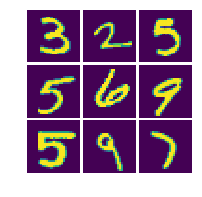

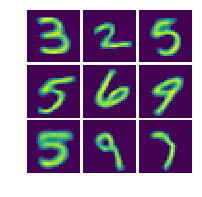

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:26 end epoch 284/300: average loss = 0.03201531498271178 (=0.018699+0.013316)

2018-05-07 23:05:26 start epoch 285/300, with learning rate = 0.0000032226
2018-05-07 23:05:26 iteration 1/859: current training loss = 0.032064 (=0.018507+0.013557)
2018-05-07 23:05:27 iteration 100/859: current training loss = 0.032894 (=0.019552+0.013342)
2018-05-07 23:05:28 iteration 200/859: current training loss = 0.030852 (=0.017727+0.013125)
2018-05-07 23:05:28 iteration 300/859: current training loss = 0.032301 (=0.019007+0.013294)
2018-05-07 23:05:29 iteration 400/859: current training loss = 0.031388 (=0.018432+0.012956)
2018-05-07 23:05:30 iteration 500/859: current training loss = 0.033724 (=0.020519+0.013205)
2018-05-07 23:05:31 iteration 600/859: current training loss = 0.032222 (=0.018573+0.013649)
2018-05-07 23:05:32 iteration 700/859: current training loss = 0.031696 (=0.018080+0.013616)
2018-05-07 23:05:32 iteration 800/859: cur

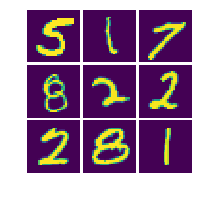

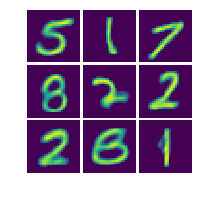

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:34 end epoch 285/300: average loss = 0.03196641655337408 (=0.018668+0.013299)

2018-05-07 23:05:34 start epoch 286/300, with learning rate = 0.0000031582
2018-05-07 23:05:34 iteration 1/859: current training loss = 0.030763 (=0.017858+0.012906)
2018-05-07 23:05:35 iteration 100/859: current training loss = 0.029077 (=0.016202+0.012875)
2018-05-07 23:05:35 iteration 200/859: current training loss = 0.030693 (=0.017803+0.012890)
2018-05-07 23:05:36 iteration 300/859: current training loss = 0.031428 (=0.018090+0.013337)
2018-05-07 23:05:37 iteration 400/859: current training loss = 0.031602 (=0.018157+0.013444)
2018-05-07 23:05:38 iteration 500/859: current training loss = 0.029863 (=0.016676+0.013187)
2018-05-07 23:05:38 iteration 600/859: current training loss = 0.032694 (=0.018723+0.013971)
2018-05-07 23:05:39 iteration 700/859: current training loss = 0.031445 (=0.017954+0.013491)
2018-05-07 23:05:40 iteration 800/859: cur

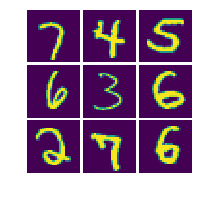

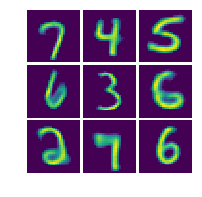

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:41 end epoch 286/300: average loss = 0.03200045274191116 (=0.018697+0.013303)

2018-05-07 23:05:41 start epoch 287/300, with learning rate = 0.0000030950
2018-05-07 23:05:41 iteration 1/859: current training loss = 0.032219 (=0.019151+0.013067)
2018-05-07 23:05:42 iteration 100/859: current training loss = 0.029041 (=0.016686+0.012355)
2018-05-07 23:05:43 iteration 200/859: current training loss = 0.031336 (=0.018171+0.013165)
2018-05-07 23:05:44 iteration 300/859: current training loss = 0.033363 (=0.019694+0.013669)
2018-05-07 23:05:45 iteration 400/859: current training loss = 0.032312 (=0.018626+0.013685)
2018-05-07 23:05:45 iteration 500/859: current training loss = 0.030288 (=0.017905+0.012383)
2018-05-07 23:05:46 iteration 600/859: current training loss = 0.032456 (=0.019278+0.013177)
2018-05-07 23:05:47 iteration 700/859: current training loss = 0.032374 (=0.018987+0.013388)
2018-05-07 23:05:47 iteration 800/859: cur

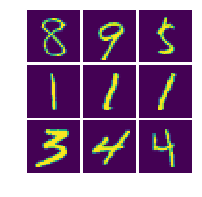

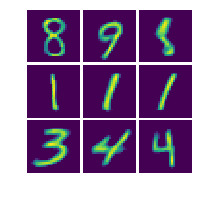

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:49 end epoch 287/300: average loss = 0.03198146549236719 (=0.018675+0.013307)

2018-05-07 23:05:49 start epoch 288/300, with learning rate = 0.0000030331
2018-05-07 23:05:49 iteration 1/859: current training loss = 0.032249 (=0.019033+0.013216)
2018-05-07 23:05:50 iteration 100/859: current training loss = 0.030010 (=0.017092+0.012918)
2018-05-07 23:05:51 iteration 200/859: current training loss = 0.033653 (=0.019339+0.014314)
2018-05-07 23:05:52 iteration 300/859: current training loss = 0.031827 (=0.018401+0.013426)
2018-05-07 23:05:52 iteration 400/859: current training loss = 0.031941 (=0.019021+0.012920)
2018-05-07 23:05:53 iteration 500/859: current training loss = 0.033725 (=0.020163+0.013562)
2018-05-07 23:05:54 iteration 600/859: current training loss = 0.029930 (=0.017245+0.012685)
2018-05-07 23:05:55 iteration 700/859: current training loss = 0.031915 (=0.018396+0.013519)
2018-05-07 23:05:55 iteration 800/859: cur

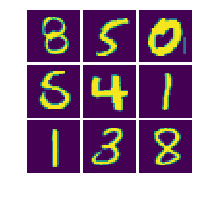

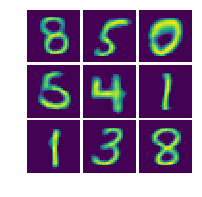

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:05:57 end epoch 288/300: average loss = 0.032012048451722154 (=0.018692+0.013320)

2018-05-07 23:05:57 start epoch 289/300, with learning rate = 0.0000029724
2018-05-07 23:05:57 iteration 1/859: current training loss = 0.033013 (=0.019161+0.013852)
2018-05-07 23:05:58 iteration 100/859: current training loss = 0.032422 (=0.018773+0.013648)
2018-05-07 23:05:58 iteration 200/859: current training loss = 0.031555 (=0.018619+0.012935)
2018-05-07 23:05:59 iteration 300/859: current training loss = 0.032098 (=0.018356+0.013742)
2018-05-07 23:06:00 iteration 400/859: current training loss = 0.033049 (=0.019439+0.013611)
2018-05-07 23:06:01 iteration 500/859: current training loss = 0.031598 (=0.018155+0.013444)
2018-05-07 23:06:01 iteration 600/859: current training loss = 0.031329 (=0.018067+0.013263)
2018-05-07 23:06:02 iteration 700/859: current training loss = 0.031582 (=0.018478+0.013104)
2018-05-07 23:06:03 iteration 800/859: cu

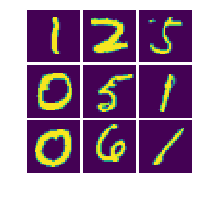

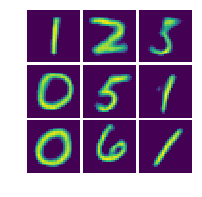

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:05 end epoch 289/300: average loss = 0.031963877551196895 (=0.018662+0.013302)

2018-05-07 23:06:05 start epoch 290/300, with learning rate = 0.0000029130
2018-05-07 23:06:05 iteration 1/859: current training loss = 0.034803 (=0.020837+0.013965)
2018-05-07 23:06:06 iteration 100/859: current training loss = 0.031532 (=0.018531+0.013001)
2018-05-07 23:06:06 iteration 200/859: current training loss = 0.031705 (=0.018199+0.013506)
2018-05-07 23:06:07 iteration 300/859: current training loss = 0.033565 (=0.020005+0.013560)
2018-05-07 23:06:08 iteration 400/859: current training loss = 0.032287 (=0.018456+0.013830)
2018-05-07 23:06:08 iteration 500/859: current training loss = 0.032005 (=0.018603+0.013402)
2018-05-07 23:06:09 iteration 600/859: current training loss = 0.031931 (=0.018434+0.013498)
2018-05-07 23:06:10 iteration 700/859: current training loss = 0.032357 (=0.019052+0.013306)
2018-05-07 23:06:11 iteration 800/859: cu

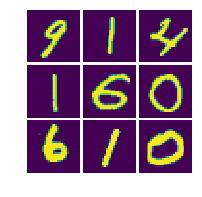

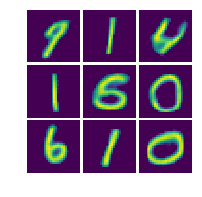

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:12 end epoch 290/300: average loss = 0.03197522751110952 (=0.018664+0.013311)

2018-05-07 23:06:12 start epoch 291/300, with learning rate = 0.0000028547
2018-05-07 23:06:12 iteration 1/859: current training loss = 0.031467 (=0.017794+0.013673)
2018-05-07 23:06:13 iteration 100/859: current training loss = 0.032802 (=0.018971+0.013832)
2018-05-07 23:06:14 iteration 200/859: current training loss = 0.032938 (=0.019564+0.013373)
2018-05-07 23:06:15 iteration 300/859: current training loss = 0.032897 (=0.019441+0.013457)
2018-05-07 23:06:15 iteration 400/859: current training loss = 0.030018 (=0.016746+0.013272)
2018-05-07 23:06:16 iteration 500/859: current training loss = 0.032228 (=0.018475+0.013753)
2018-05-07 23:06:17 iteration 600/859: current training loss = 0.033221 (=0.019059+0.014162)
2018-05-07 23:06:18 iteration 700/859: current training loss = 0.032523 (=0.018990+0.013533)
2018-05-07 23:06:18 iteration 800/859: cur

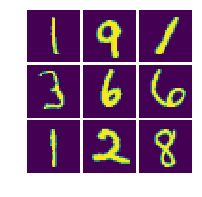

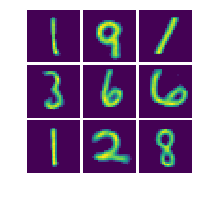

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:20 end epoch 291/300: average loss = 0.0320053367492796 (=0.018686+0.013320)

2018-05-07 23:06:20 start epoch 292/300, with learning rate = 0.0000027976
2018-05-07 23:06:20 iteration 1/859: current training loss = 0.030186 (=0.017136+0.013050)
2018-05-07 23:06:21 iteration 100/859: current training loss = 0.033068 (=0.018971+0.014098)
2018-05-07 23:06:22 iteration 200/859: current training loss = 0.029612 (=0.017191+0.012422)
2018-05-07 23:06:22 iteration 300/859: current training loss = 0.030790 (=0.017576+0.013214)
2018-05-07 23:06:23 iteration 400/859: current training loss = 0.032570 (=0.019268+0.013302)
2018-05-07 23:06:24 iteration 500/859: current training loss = 0.030332 (=0.017355+0.012977)
2018-05-07 23:06:25 iteration 600/859: current training loss = 0.032082 (=0.018767+0.013315)
2018-05-07 23:06:25 iteration 700/859: current training loss = 0.032819 (=0.019418+0.013401)
2018-05-07 23:06:26 iteration 800/859: curr

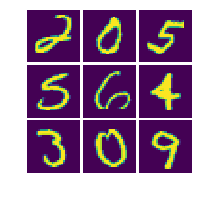

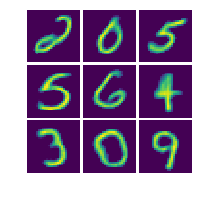

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:28 end epoch 292/300: average loss = 0.031940847836929236 (=0.018641+0.013300)

2018-05-07 23:06:28 start epoch 293/300, with learning rate = 0.0000027417
2018-05-07 23:06:28 iteration 1/859: current training loss = 0.033496 (=0.019634+0.013863)
2018-05-07 23:06:28 iteration 100/859: current training loss = 0.032306 (=0.018609+0.013698)
2018-05-07 23:06:29 iteration 200/859: current training loss = 0.030858 (=0.017844+0.013014)
2018-05-07 23:06:30 iteration 300/859: current training loss = 0.032253 (=0.019188+0.013065)
2018-05-07 23:06:31 iteration 400/859: current training loss = 0.030817 (=0.017744+0.013072)
2018-05-07 23:06:31 iteration 500/859: current training loss = 0.033615 (=0.019550+0.014065)
2018-05-07 23:06:32 iteration 600/859: current training loss = 0.030132 (=0.017072+0.013060)
2018-05-07 23:06:33 iteration 700/859: current training loss = 0.034787 (=0.021041+0.013745)
2018-05-07 23:06:34 iteration 800/859: cu

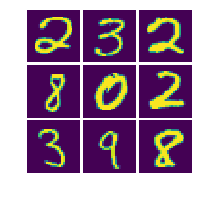

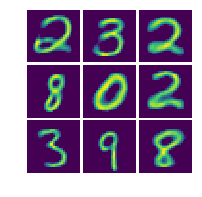

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:35 end epoch 293/300: average loss = 0.031955926647633144 (=0.018629+0.013327)

2018-05-07 23:06:35 start epoch 294/300, with learning rate = 0.0000026868
2018-05-07 23:06:35 iteration 1/859: current training loss = 0.031616 (=0.018595+0.013021)
2018-05-07 23:06:36 iteration 100/859: current training loss = 0.031259 (=0.018700+0.012559)
2018-05-07 23:06:37 iteration 200/859: current training loss = 0.034150 (=0.019858+0.014292)
2018-05-07 23:06:38 iteration 300/859: current training loss = 0.032873 (=0.019206+0.013667)
2018-05-07 23:06:38 iteration 400/859: current training loss = 0.031312 (=0.018705+0.012607)
2018-05-07 23:06:39 iteration 500/859: current training loss = 0.030062 (=0.017007+0.013056)
2018-05-07 23:06:40 iteration 600/859: current training loss = 0.032414 (=0.018991+0.013423)
2018-05-07 23:06:40 iteration 700/859: current training loss = 0.032173 (=0.018939+0.013234)
2018-05-07 23:06:41 iteration 800/859: cu

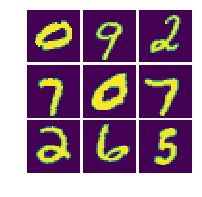

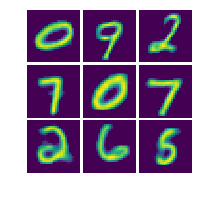

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:43 end epoch 294/300: average loss = 0.03197008452234015 (=0.018639+0.013331)

2018-05-07 23:06:43 start epoch 295/300, with learning rate = 0.0000026331
2018-05-07 23:06:43 iteration 1/859: current training loss = 0.031911 (=0.018566+0.013345)
2018-05-07 23:06:44 iteration 100/859: current training loss = 0.034026 (=0.020552+0.013474)
2018-05-07 23:06:44 iteration 200/859: current training loss = 0.030581 (=0.017638+0.012943)
2018-05-07 23:06:45 iteration 300/859: current training loss = 0.032748 (=0.019090+0.013657)
2018-05-07 23:06:46 iteration 400/859: current training loss = 0.031589 (=0.018363+0.013226)
2018-05-07 23:06:46 iteration 500/859: current training loss = 0.033540 (=0.019851+0.013689)
2018-05-07 23:06:47 iteration 600/859: current training loss = 0.033886 (=0.020043+0.013843)
2018-05-07 23:06:48 iteration 700/859: current training loss = 0.030927 (=0.018035+0.012892)
2018-05-07 23:06:49 iteration 800/859: cur

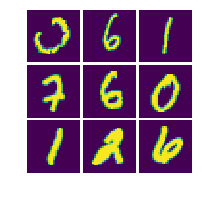

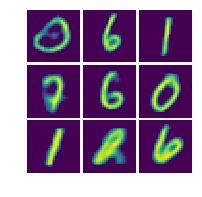

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:50 end epoch 295/300: average loss = 0.03195102490068384 (=0.018643+0.013308)

2018-05-07 23:06:50 start epoch 296/300, with learning rate = 0.0000025804
2018-05-07 23:06:50 iteration 1/859: current training loss = 0.030956 (=0.017808+0.013148)
2018-05-07 23:06:51 iteration 100/859: current training loss = 0.031995 (=0.018268+0.013727)
2018-05-07 23:06:52 iteration 200/859: current training loss = 0.030826 (=0.017589+0.013236)
2018-05-07 23:06:53 iteration 300/859: current training loss = 0.031473 (=0.018219+0.013254)
2018-05-07 23:06:53 iteration 400/859: current training loss = 0.031058 (=0.017652+0.013406)
2018-05-07 23:06:54 iteration 500/859: current training loss = 0.031572 (=0.018237+0.013335)
2018-05-07 23:06:55 iteration 600/859: current training loss = 0.033215 (=0.019976+0.013239)
2018-05-07 23:06:56 iteration 700/859: current training loss = 0.029948 (=0.016948+0.013000)
2018-05-07 23:06:56 iteration 800/859: cur

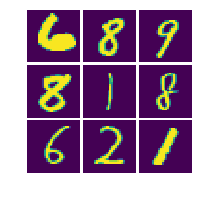

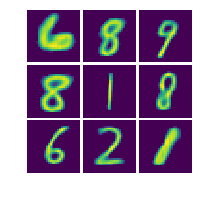

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:06:58 end epoch 296/300: average loss = 0.03195757416052022 (=0.018639+0.013319)

2018-05-07 23:06:58 start epoch 297/300, with learning rate = 0.0000025288
2018-05-07 23:06:58 iteration 1/859: current training loss = 0.030785 (=0.017808+0.012976)
2018-05-07 23:06:59 iteration 100/859: current training loss = 0.032178 (=0.018652+0.013526)
2018-05-07 23:07:00 iteration 200/859: current training loss = 0.030128 (=0.017535+0.012592)
2018-05-07 23:07:00 iteration 300/859: current training loss = 0.031081 (=0.017697+0.013384)
2018-05-07 23:07:01 iteration 400/859: current training loss = 0.031420 (=0.018171+0.013249)
2018-05-07 23:07:02 iteration 500/859: current training loss = 0.032514 (=0.018751+0.013763)
2018-05-07 23:07:03 iteration 600/859: current training loss = 0.032691 (=0.019318+0.013373)
2018-05-07 23:07:03 iteration 700/859: current training loss = 0.032491 (=0.019165+0.013327)
2018-05-07 23:07:04 iteration 800/859: cur

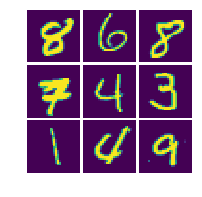

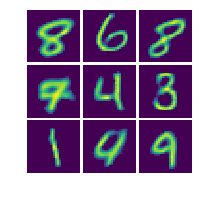

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:07:06 end epoch 297/300: average loss = 0.031950506283028854 (=0.018625+0.013326)

2018-05-07 23:07:06 start epoch 298/300, with learning rate = 0.0000024783
2018-05-07 23:07:06 iteration 1/859: current training loss = 0.031479 (=0.018079+0.013400)
2018-05-07 23:07:07 iteration 100/859: current training loss = 0.032387 (=0.019465+0.012922)
2018-05-07 23:07:07 iteration 200/859: current training loss = 0.031288 (=0.017657+0.013631)
2018-05-07 23:07:08 iteration 300/859: current training loss = 0.034128 (=0.020092+0.014036)
2018-05-07 23:07:09 iteration 400/859: current training loss = 0.029512 (=0.016917+0.012595)
2018-05-07 23:07:09 iteration 500/859: current training loss = 0.033934 (=0.020362+0.013572)
2018-05-07 23:07:10 iteration 600/859: current training loss = 0.033508 (=0.019935+0.013573)
2018-05-07 23:07:11 iteration 700/859: current training loss = 0.033030 (=0.019066+0.013964)
2018-05-07 23:07:12 iteration 800/859: cu

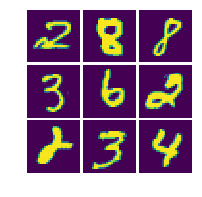

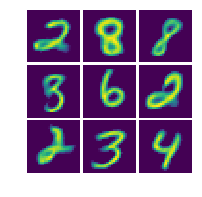

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:07:13 end epoch 298/300: average loss = 0.03197592527229378 (=0.018657+0.013319)

2018-05-07 23:07:13 start epoch 299/300, with learning rate = 0.0000024287
2018-05-07 23:07:13 iteration 1/859: current training loss = 0.032445 (=0.019434+0.013011)
2018-05-07 23:07:14 iteration 100/859: current training loss = 0.032028 (=0.018826+0.013202)
2018-05-07 23:07:15 iteration 200/859: current training loss = 0.031246 (=0.017971+0.013275)
2018-05-07 23:07:15 iteration 300/859: current training loss = 0.030659 (=0.017632+0.013027)
2018-05-07 23:07:16 iteration 400/859: current training loss = 0.034062 (=0.020039+0.014024)
2018-05-07 23:07:17 iteration 500/859: current training loss = 0.030677 (=0.017934+0.012744)
2018-05-07 23:07:18 iteration 600/859: current training loss = 0.032239 (=0.018563+0.013676)
2018-05-07 23:07:18 iteration 700/859: current training loss = 0.032203 (=0.019035+0.013168)
2018-05-07 23:07:19 iteration 800/859: cur

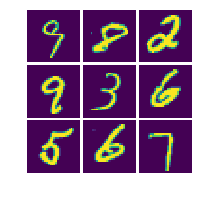

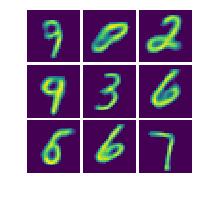

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:07:21 end epoch 299/300: average loss = 0.03194647046224549 (=0.018639+0.013307)

2018-05-07 23:07:21 start epoch 300/300, with learning rate = 0.0000023801
2018-05-07 23:07:21 iteration 1/859: current training loss = 0.029866 (=0.017075+0.012791)
2018-05-07 23:07:21 iteration 100/859: current training loss = 0.032050 (=0.018510+0.013540)
2018-05-07 23:07:22 iteration 200/859: current training loss = 0.034586 (=0.020722+0.013864)
2018-05-07 23:07:23 iteration 300/859: current training loss = 0.031940 (=0.018666+0.013274)
2018-05-07 23:07:24 iteration 400/859: current training loss = 0.032807 (=0.019366+0.013441)
2018-05-07 23:07:24 iteration 500/859: current training loss = 0.029856 (=0.017280+0.012576)
2018-05-07 23:07:25 iteration 600/859: current training loss = 0.031713 (=0.018297+0.013416)
2018-05-07 23:07:26 iteration 700/859: current training loss = 0.031325 (=0.018069+0.013257)
2018-05-07 23:07:26 iteration 800/859: cur

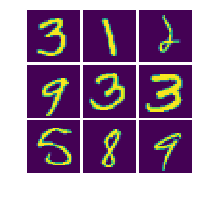

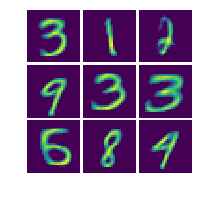

model saved in path: parameters/VAE/VAE.ckpt
2018-05-07 23:07:28 end epoch 300/300: average loss = 0.03189174675873813 (=0.018594+0.013298)



In [6]:
max_epoch=300
print_every=100
num_iteration=num_train//batch_size
loss_his=[]
loss1_his=[]
loss2_his=[]

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'start epoch %d/%d, with learning rate = %.10f' % (epoch+1,max_epoch,sess.run(learning_rate)))
        average_loss=0
        average_loss1=0
        average_loss2=0
        for it in range(num_iteration):
            images,labels=mnist.train.next_batch(batch_size)
            loss_num,l1,l2,_=sess.run([loss,loss1,loss2,train_step],feed_dict={X:normalize(images)})
            average_loss+=loss_num
            average_loss1+=l1
            average_loss2+=l2
            if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f (=%f+%f)' % (loss_num,l1,l2))
        average_loss/=num_iteration
        average_loss1/=num_iteration
        average_loss2/=num_iteration
        images,labels=mnist.train.next_batch(9)
        drawImage(images)
        d_output=sess.run(X_gen,feed_dict={X:normalize(images)})
        drawImage(d_output)
#         g_output=sess.run(generate_output,feed_dict={sample_size:9})
#         drawImage(g_output)
        loss_his.append(average_loss)
        loss1_his.append(average_loss1)
        loss2_his.append(average_loss2)
        save_path = saver.save(sess, "parameters/VAE/VAE.ckpt")
        print("model saved in path: %s" % save_path)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'average loss =',average_loss,'(=%f+%f)' % (average_loss1,average_loss2))
        print()

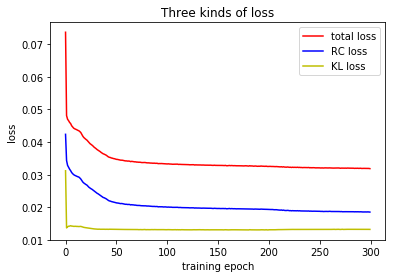

In [7]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),loss_his,'r-')
pva,=plt.plot(range(max_epoch),loss1_his,'b-')
pte,=plt.plot(range(max_epoch),loss2_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('Three kinds of loss')
plt.legend((ptr,pva,pte),('total loss','RC loss','KL loss'))
plt.show()

INFO:tensorflow:Restoring parameters from parameters/VAE/VAE.ckpt


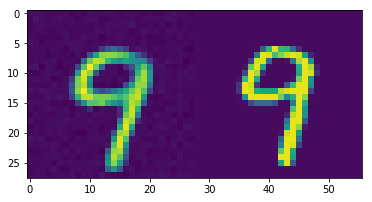

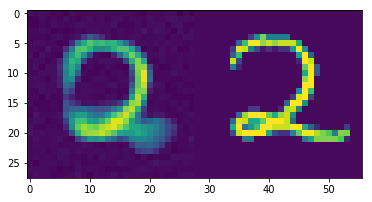

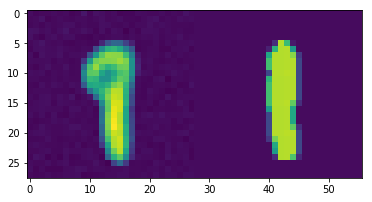

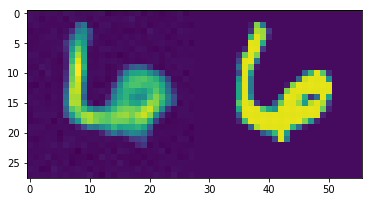

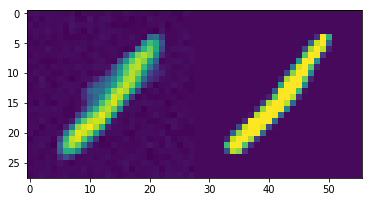

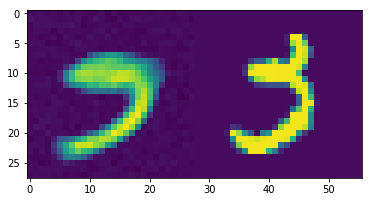

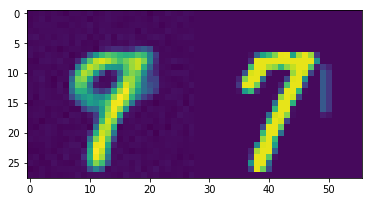

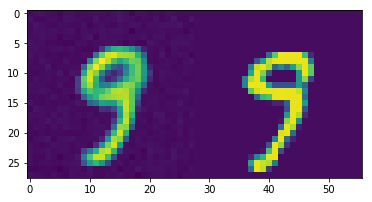

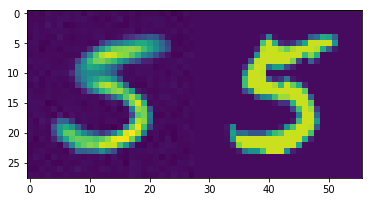

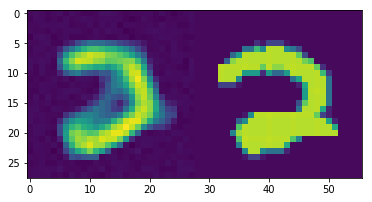

In [8]:
std=0.01
Z_gt=tf.expand_dims(unit_gaussian.sample(),axis=0)
X_generate_mean=decoder(Z_gt)
generate_distrib=tf.distributions.Normal(loc=X_generate_mean,scale=tf.ones(784)*std)
generate_result=generate_distrib.sample()

def nearest_neighbour(X_train,image):
    dis=np.sum(np.square(X_train-image),axis=1)
    index=np.argmin(dis)
    return X_train[index,:]

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "parameters/VAE/VAE.ckpt")
    for i in range(10):
        img_np=sess.run(generate_result)
        nn=nearest_neighbour(mnist.train.images,img_np)
#         img_np=normalize01(img_np)
#         img_np[np.where(img_np>0.3)]=1
        img=np.hstack((img_np.reshape(28,28),nn.reshape(28,28)))
        plt.imshow(img)
        plt.show()